In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, BatchNormalization, Input, Flatten, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')
display(csv_data.head()), display(csv_data.shape)
train_path = 'unseen-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'unseen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(train_images)+len(val_images)

imagename  pen_pressure  letter_spacing  size  dimension  \
0  0968c_num1.png             2               2     2          1   
1  0809c_num2.png             2               2     2          2   
2  0237b_num6.png             2               2     2          2   
3  0069b_num2.png             2               2     2          1   
4  0966c_num4.png             2               2     2          2   

   is_lowercase  is_continuous  slantness  tilt  entry_stroke_a  staff_of_a  \
0             2              2          3     2               1           2   
1             2              2          3     1               1           2   
2             2              2          2     2               1           2   
3             2              2          1     1               1           1   
4             2              2          2     1               1           2   

   formation_n  staff_of_d  exit_stroke_d  word_formation  constancy  
0            2           3              2               2          1  
1            2           3              1               2          2  
2            2           2              2               2          2  
3            1           1              1               1          1  
4            2           2              2               2          2

(13570, 16)

13794

In [5]:
# len(list(set(list(x[:4] for x in images['image'])))), len(list(set(list(x[:4] for x in csv_data['ImageId']))))

In [6]:
dataset_columns = csv_data.columns
csv_data['imagename'] = csv_data['imagename'].astype('str')
display(csv_data.head(20))
csv_data.shape

imagename  pen_pressure  letter_spacing  size  dimension  \
0   0968c_num1.png             2               2     2          1   
1   0809c_num2.png             2               2     2          2   
2   0237b_num6.png             2               2     2          2   
3   0069b_num2.png             2               2     2          1   
4   0966c_num4.png             2               2     2          2   
5   1316a_num2.png             2               2     1          1   
6   1503c_num2.png             2               1     2          2   
7   0113c_num1.png             2               3     2          2   
8   0221a_num6.png             2               2     2          2   
9   0068a_num4.png             1               1     2          2   
10  1094b_num1.png             2               3     1          1   
11  0337c_num6.png             2               2     2          2   
12  0837a_num4.png             2               2     2          2   
13  0941b_num3.png             2               2     2          2   
14  0260a_num3.png             2               2     2          2   
15  0598c_num4.png             1               3     2          2   
16  0380a_num2.png             2               2     2          2   
17  0384b_num2.png             2               2     2          2   
18  1224a_num3.png             2               2     2          2   
19  1131b_num3.png             2               2     2          2   

    is_lowercase  is_continuous  slantness  tilt  entry_stroke_a  staff_of_a  \
0              2              2          3     2               1           2   
1              2              2          3     1               1           2   
2              2              2          2     2               1           2   
3              2              2          1     1               1           1   
4              2              2          2     1               1           2   
5              2              2          3     1               1           2   
6              2              2          2     1               1           3   
7              2              1          2     1               1           1   
8              2              1          1     1               1           4   
9              2              2          1     1               1           2   
10             2              2          2     1               1           1   
11             2              2          3     1               1           2   
12             2              2          1     1               1           3   
13             2              2          2     1               1           1   
14             2              2          2     1               1           2   
15             1              1          2     1               1           1   
16             2              2          4     1               1           2   
17             2              2          2     1               1           2   
18             2              2          1     1               1           4   
19             2              2          1     1               1           2   

    formation_n  staff_of_d  exit_stroke_d  word_formation  constancy  
0             2           3              2               2          1  
1             2           3              1               2          2  
2             2           2              2               2          2  
3             1           1              1               1          1  
4             2           2              2               2          2  
5             2           2              3               2          2  
6             2           2              3               2          2  
7             2           2              2               2          2  
8             1           2              3               1          2  
9             2           2              2               2          2  
10            1           3              2               1          1  
11            

(13570, 16)

In [7]:
# train_csv_data =  csv_data[:700]
# val_csv_data =  csv_data[700:]
# train_csv_data.shape, val_csv_data.shape

In [8]:
f = []
for col in dataset_columns[1:]:
    f.append(csv_data[col].unique().shape[0])
f,len(f)

([2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2], 15)

In [9]:

# model = Sequential()
input_layer = Input((64,64,1))
model = BatchNormalization()(input_layer)

model = Conv2D(activation='relu',filters=32, kernel_size=(32,32), padding='same')(model)
model = Conv2D(activation='relu',filters=64, kernel_size=(32,32), strides=(1,1), padding='same')(model)
model = MaxPool2D((2,2))(model)
model = Dropout(0.25)(model)

model = Conv2D(activation='relu',filters=128, kernel_size=(16,16), padding='same')(model)
model = Conv2D(activation='relu',filters=256, kernel_size=(16,16), strides=(1,1), padding='same')(model)
model = MaxPool2D((2,2))(model)
model = Dropout(0.25)(model)

model = Conv2D(activation='relu',filters=128, kernel_size=(8,8), padding='same')(model)
model = Conv2D(activation='relu',filters=256, kernel_size=(8,8), strides=(1,1), padding='same')(model)
model = MaxPool2D((2,2))(model)
model = Dropout(0.25)(model)
# model = Flatten()(model)

dense_layer = Dense(512, activation='relu')(model)
dense_layer = Dropout(0.5)(dense_layer)
out_dense_layer=[]
for i in range(1,len(f)+1):
    out_dense_layer.append(Dense(f[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Flatten()(Dense(64 , activation='relu', name = 'dense_layer_'+str(i))(dense_layer))))

human_features = Model(inputs=[input_layer], outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   32800       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   2097216     conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

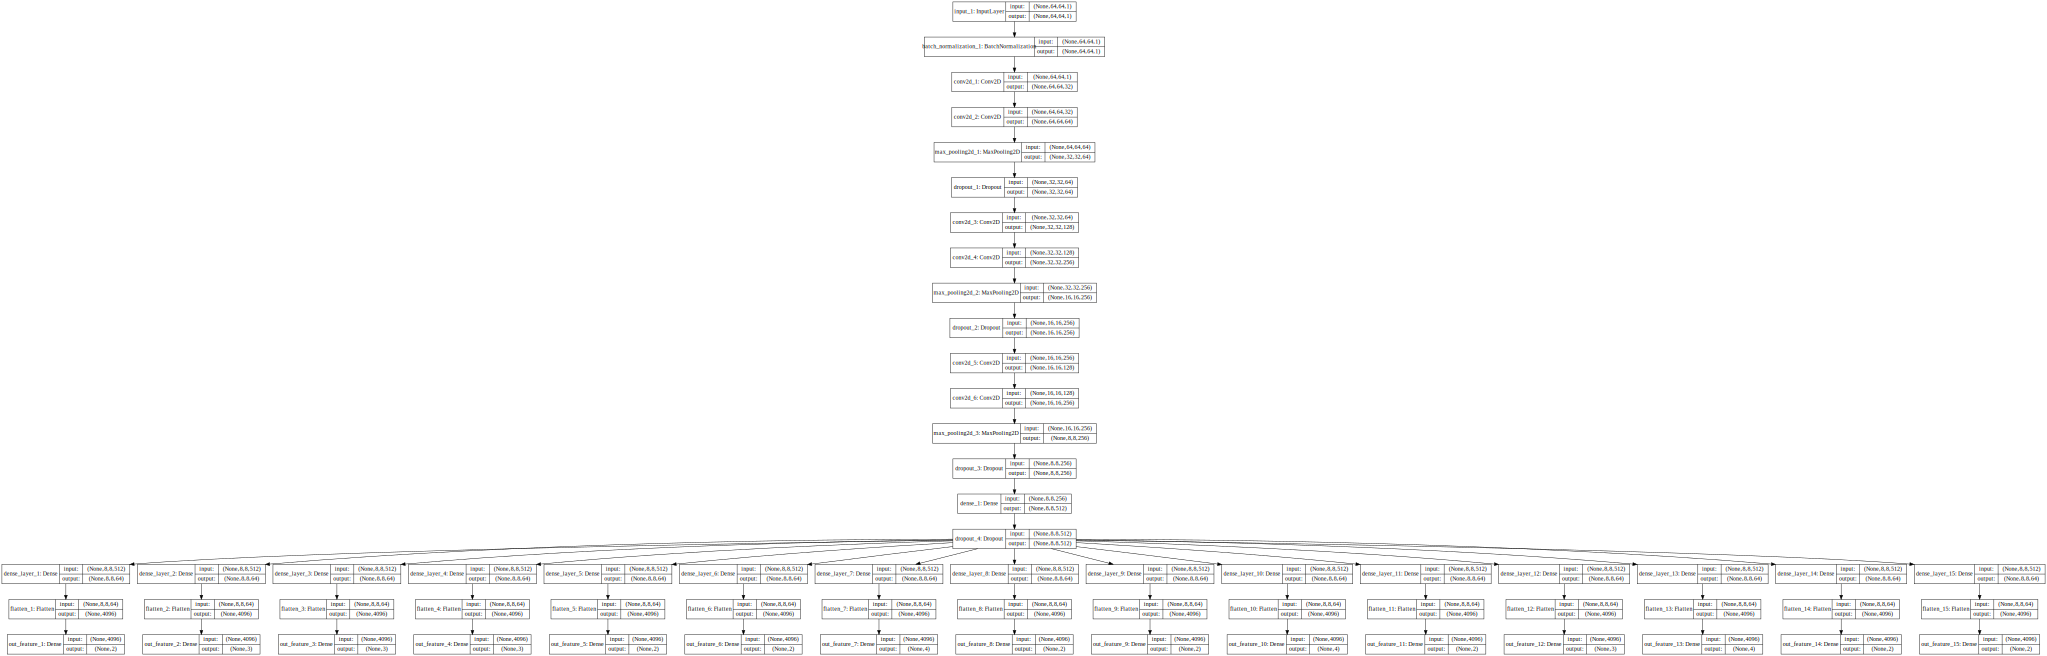

In [142]:
SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
feature_lengths = {}
for col in dataset_columns[1:]:
    feature_lengths[col] = len(csv_data[col].unique())
feature_lengths = list(feature_lengths.values())
feature_lengths

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

In [12]:
# df_data[df_data['f8']==2]

In [13]:
# im = images[images['image'].str.match('1229b')]
# im.iloc[0]['image']

In [14]:

# stop_at = 20
# identitycounter = 1
# unique_writers = list(set(list(x[:4] for x in df_data['ImageId'])))
# for writer in unique_writers:
#     print(identitycounter*100/stop_at, end='\r')
#     writer_samples = list(images[images['image'].str.match(writer)]['image'])
# #     print('lne',len(writer_samples))
#     f,ax = plt.subplots(1,len(writer_samples))
#     f.subplots_adjust(hspace = .5, wspace=.15)
#     f.set_size_inches(15,15)
#     imgcounter = 0
#     for sample in writer_samples:
#         imagepath = os.path.join(image_path,sample)
#         raw_img = cv2.imread(imagepath)
#         if len(writer_samples)>1:
#             ax[imgcounter].imshow(raw_img)
#             ax[imgcounter].set_title(writer+'\n'+sample)
#         else:
#             ax.imshow(raw_img)
#             ax.set_title(writer+'\n'+sample)
# #         ax[imgcounter].axis('off')
#         imgcounter+=1
#         if imgcounter == stop_at:
#             break
#     imgcounter=0
#     identitycounter += 1
#     if identitycounter == stop_at+1:
#         break

In [15]:
# csv_data[csv_data['ImageId'].str.match('1302c')]

In [16]:

def datagen(batch_size,image_path,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
#         counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        
        writer_index = np.random.randint(0,len(list_of_writers))
        
#         for writer_index in writer_indexes:
#             class_vectors = []
#             features = None
        imagename = list_of_writers[writer_index]
#             print('-->',csv_data['imagename'][0],imagename)
#             display(csv_data[csv_data['imagename']==imagename].values[0][1:])
        features = csv_data[csv_data['imagename']==imagename].values
        if len(features)==0:
#             print('no features', imagename)
            continue
        features = features[0][1:]-1
#             print(features)
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]


        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)
#         print(imagename)
        counter+=1
#         print('counter:', counter, end='\r')
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):
#                 print(feature_list[1])
                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]    

In [17]:

batch_size = 64

tg = datagen(batch_size,image_path=train_path,vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)


In [18]:
# images
inputs,o = next(tg)
print(inputs.shape)
for op in o:
    print((np.argmax(op, axis=1)+1)[0])
#     print('------')
# feature_list

(64, 64, 64, 1)
2
3
1
2
2
1
1
1
1
4
2
1
3
2
2


In [19]:
csv_data[csv_data['imagename']=='0066c_num3.png'].values[0][1:]

array([2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1], dtype=object)

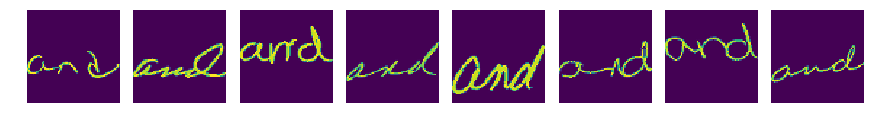

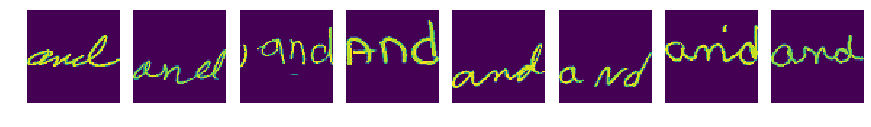

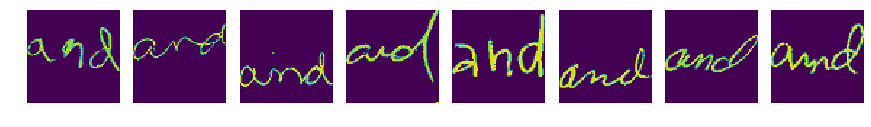

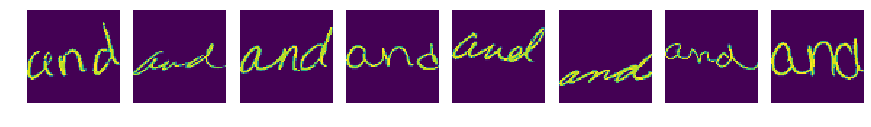

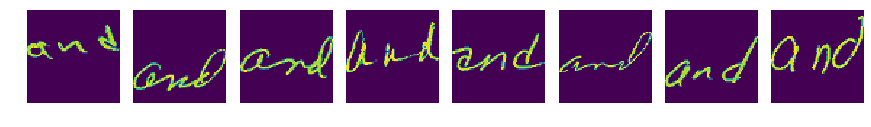

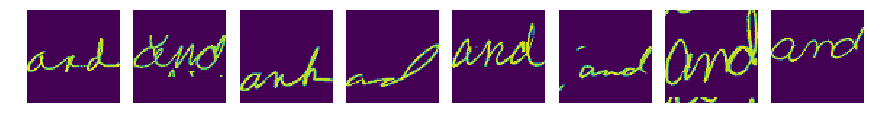

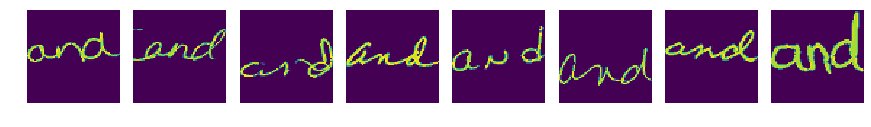

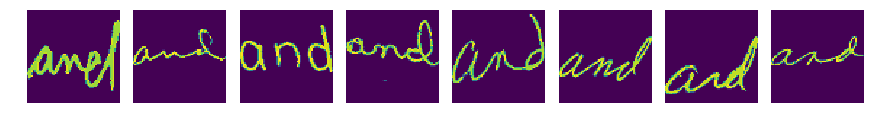

In [20]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [21]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0
# lossWeights["out_feature_1"] = 10.0
# lossWeights["out_feature_2"] = 8.0
# lossWeights["out_feature_3"] = 0.1
# lossWeights["out_feature_4"] = 8.0
# lossWeights["out_feature_5"] = 1.0
# lossWeights["out_feature_6"] = 5.0
# lossWeights["out_feature_7"] = 5.0
# lossWeights["out_feature_8"] = 10.0


In [22]:
mc = ModelCheckpoint(filepath='15_human_features_weights_unseen_v1.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')

In [23]:
EPOCHS = 50000
INIT_LR = 0.0001
# opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
opt = Adadelta(lr=INIT_LR, decay=1e-04)

# feat_extractor.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])


human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 1)    4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 32)   32800       batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 64)   2097216     conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [24]:
# human_features.load_weights('human_features_weights_v3.h5')
# inputs,o = next(vg)
# for i in range(64):
#     print(i)
#     f_probs = human_features.predict(np.expand_dims(inputs[i],0))
# #     print(f_probs)
#     for prob in f_probs:
#         print(np.argmax(prob),end=',')
#     print('++++++++++++')
human_features.load_weights('15_human_features_weights_unseen_v1.h5')

In [25]:

hist = human_features.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/50000

Epoch 00001: val_loss improved from inf to 11.35151, saving model to 15_human_features_weights_unseen_v1.h5
Epoch 2/50000

Epoch 00002: val_loss improved from 11.35151 to 10.95232, saving model to 15_human_features_weights_unseen_v1.h5
Epoch 3/50000

Epoch 00003: val_loss did not improve from 10.95232
Epoch 4/50000

Epoch 00004: val_loss did not improve from 10.95232
Epoch 5/50000

Epoch 00005: val_loss did not improve from 10.95232
Epoch 6/50000

Epoch 00006: val_loss did not improve from 10.95232
Epoch 7/50000

Epoch 00007: val_loss did not improve from 10.95232
Epoch 8/50000

Epoch 00008: val_loss did not improve from 10.95232
Epoch 9/50000

Epoch 00009: val_loss did not improve from 10.95232
Epoch 10/50000

Epoch 00010: val_loss did not improve from 10.95232
Epoch 11/50000

Epoch 00011: val_loss did not improve from 10.95232
Epoch 12/50000

Epoch 00012: val_loss did not improve from 10.95232
Epoch 13/50000

Epoch 00013: val_loss did not improve from 10.95232
Epoch 14


Epoch 00119: val_loss did not improve from 10.89397
Epoch 120/50000

Epoch 00120: val_loss did not improve from 10.89397
Epoch 121/50000

Epoch 00121: val_loss did not improve from 10.89397
Epoch 122/50000

Epoch 00122: val_loss did not improve from 10.89397
Epoch 123/50000

Epoch 00123: val_loss did not improve from 10.89397
Epoch 124/50000

Epoch 00124: val_loss did not improve from 10.89397
Epoch 125/50000

Epoch 00125: val_loss did not improve from 10.89397
Epoch 126/50000

Epoch 00126: val_loss did not improve from 10.89397
Epoch 127/50000

Epoch 00127: val_loss did not improve from 10.89397
Epoch 128/50000

Epoch 00128: val_loss did not improve from 10.89397
Epoch 129/50000

Epoch 00129: val_loss did not improve from 10.89397
Epoch 130/50000

Epoch 00130: val_loss did not improve from 10.89397
Epoch 131/50000

Epoch 00131: val_loss did not improve from 10.89397
Epoch 132/50000

Epoch 00132: val_loss did not improve from 10.89397
Epoch 133/50000

Epoch 00133: val_loss did not imp


Epoch 00237: val_loss did not improve from 10.77525
Epoch 238/50000

Epoch 00238: val_loss did not improve from 10.77525
Epoch 239/50000

Epoch 00239: val_loss did not improve from 10.77525
Epoch 240/50000

Epoch 00240: val_loss did not improve from 10.77525
Epoch 241/50000

Epoch 00241: val_loss did not improve from 10.77525
Epoch 242/50000

Epoch 00242: val_loss did not improve from 10.77525
Epoch 243/50000

Epoch 00243: val_loss did not improve from 10.77525
Epoch 244/50000

Epoch 00244: val_loss did not improve from 10.77525
Epoch 245/50000

Epoch 00245: val_loss did not improve from 10.77525
Epoch 246/50000

Epoch 00246: val_loss did not improve from 10.77525
Epoch 247/50000

Epoch 00247: val_loss did not improve from 10.77525
Epoch 248/50000

Epoch 00248: val_loss did not improve from 10.77525
Epoch 249/50000

Epoch 00249: val_loss did not improve from 10.77525
Epoch 250/50000

Epoch 00250: val_loss did not improve from 10.77525
Epoch 251/50000

Epoch 00251: val_loss did not imp


Epoch 00356: val_loss did not improve from 10.77525
Epoch 357/50000

Epoch 00357: val_loss did not improve from 10.77525
Epoch 358/50000

Epoch 00358: val_loss did not improve from 10.77525
Epoch 359/50000

Epoch 00359: val_loss did not improve from 10.77525
Epoch 360/50000

Epoch 00360: val_loss did not improve from 10.77525
Epoch 361/50000

Epoch 00361: val_loss did not improve from 10.77525
Epoch 362/50000

Epoch 00362: val_loss did not improve from 10.77525
Epoch 363/50000

Epoch 00363: val_loss did not improve from 10.77525
Epoch 364/50000

Epoch 00364: val_loss did not improve from 10.77525
Epoch 365/50000

Epoch 00365: val_loss did not improve from 10.77525
Epoch 366/50000

Epoch 00366: val_loss did not improve from 10.77525
Epoch 367/50000

Epoch 00367: val_loss did not improve from 10.77525
Epoch 368/50000

Epoch 00368: val_loss did not improve from 10.77525
Epoch 369/50000

Epoch 00369: val_loss did not improve from 10.77525
Epoch 370/50000

Epoch 00370: val_loss did not imp


Epoch 00474: val_loss did not improve from 10.75707
Epoch 475/50000

Epoch 00475: val_loss did not improve from 10.75707
Epoch 476/50000

Epoch 00476: val_loss did not improve from 10.75707
Epoch 477/50000

Epoch 00477: val_loss did not improve from 10.75707
Epoch 478/50000

Epoch 00478: val_loss did not improve from 10.75707
Epoch 479/50000

Epoch 00479: val_loss did not improve from 10.75707
Epoch 480/50000

Epoch 00480: val_loss did not improve from 10.75707
Epoch 481/50000

Epoch 00481: val_loss did not improve from 10.75707
Epoch 482/50000

Epoch 00482: val_loss did not improve from 10.75707
Epoch 483/50000

Epoch 00483: val_loss did not improve from 10.75707
Epoch 484/50000

Epoch 00484: val_loss did not improve from 10.75707
Epoch 485/50000

Epoch 00485: val_loss did not improve from 10.75707
Epoch 486/50000

Epoch 00486: val_loss did not improve from 10.75707
Epoch 487/50000

Epoch 00487: val_loss did not improve from 10.75707
Epoch 488/50000

Epoch 00488: val_loss did not imp


Epoch 00593: val_loss did not improve from 10.75707
Epoch 594/50000

Epoch 00594: val_loss did not improve from 10.75707
Epoch 595/50000

Epoch 00595: val_loss did not improve from 10.75707
Epoch 596/50000

Epoch 00596: val_loss did not improve from 10.75707
Epoch 597/50000

Epoch 00597: val_loss did not improve from 10.75707
Epoch 598/50000

Epoch 00598: val_loss did not improve from 10.75707
Epoch 599/50000

Epoch 00599: val_loss improved from 10.75707 to 10.73159, saving model to 15_human_features_weights_unseen_v1.h5
Epoch 600/50000

Epoch 00600: val_loss did not improve from 10.73159
Epoch 601/50000

Epoch 00601: val_loss did not improve from 10.73159
Epoch 602/50000

Epoch 00602: val_loss did not improve from 10.73159
Epoch 603/50000

Epoch 00603: val_loss did not improve from 10.73159
Epoch 604/50000

Epoch 00604: val_loss did not improve from 10.73159
Epoch 605/50000

Epoch 00605: val_loss did not improve from 10.73159
Epoch 606/50000

Epoch 00606: val_loss did not improve fro


Epoch 00711: val_loss did not improve from 10.73159
Epoch 712/50000

Epoch 00712: val_loss did not improve from 10.73159
Epoch 713/50000

Epoch 00713: val_loss did not improve from 10.73159
Epoch 714/50000

Epoch 00714: val_loss did not improve from 10.73159
Epoch 715/50000

Epoch 00715: val_loss did not improve from 10.73159
Epoch 716/50000

Epoch 00716: val_loss did not improve from 10.73159
Epoch 717/50000

Epoch 00717: val_loss did not improve from 10.73159
Epoch 718/50000

Epoch 00718: val_loss did not improve from 10.73159
Epoch 719/50000

Epoch 00719: val_loss did not improve from 10.73159
Epoch 720/50000

Epoch 00720: val_loss did not improve from 10.73159
Epoch 721/50000

Epoch 00721: val_loss did not improve from 10.73159
Epoch 722/50000

Epoch 00722: val_loss did not improve from 10.73159
Epoch 723/50000

Epoch 00723: val_loss did not improve from 10.73159
Epoch 724/50000

Epoch 00724: val_loss did not improve from 10.73159
Epoch 725/50000

Epoch 00725: val_loss did not imp


Epoch 00830: val_loss did not improve from 10.73159
Epoch 831/50000

Epoch 00831: val_loss did not improve from 10.73159
Epoch 832/50000

Epoch 00832: val_loss did not improve from 10.73159
Epoch 833/50000

Epoch 00833: val_loss did not improve from 10.73159
Epoch 834/50000

Epoch 00834: val_loss did not improve from 10.73159
Epoch 835/50000

Epoch 00835: val_loss did not improve from 10.73159
Epoch 836/50000

Epoch 00836: val_loss did not improve from 10.73159
Epoch 837/50000

Epoch 00837: val_loss did not improve from 10.73159
Epoch 838/50000

Epoch 00838: val_loss did not improve from 10.73159
Epoch 839/50000

Epoch 00839: val_loss did not improve from 10.73159
Epoch 840/50000

Epoch 00840: val_loss did not improve from 10.73159
Epoch 841/50000

Epoch 00841: val_loss did not improve from 10.73159
Epoch 842/50000

Epoch 00842: val_loss did not improve from 10.73159
Epoch 843/50000

Epoch 00843: val_loss did not improve from 10.73159
Epoch 844/50000

Epoch 00844: val_loss did not imp


Epoch 00949: val_loss did not improve from 10.73159
Epoch 950/50000

Epoch 00950: val_loss did not improve from 10.73159
Epoch 951/50000

Epoch 00951: val_loss did not improve from 10.73159
Epoch 952/50000

Epoch 00952: val_loss did not improve from 10.73159
Epoch 953/50000

Epoch 00953: val_loss did not improve from 10.73159
Epoch 954/50000

Epoch 00954: val_loss did not improve from 10.73159
Epoch 955/50000

Epoch 00955: val_loss did not improve from 10.73159
Epoch 956/50000

Epoch 00956: val_loss did not improve from 10.73159
Epoch 957/50000

Epoch 00957: val_loss did not improve from 10.73159
Epoch 958/50000

Epoch 00958: val_loss did not improve from 10.73159
Epoch 959/50000

Epoch 00959: val_loss did not improve from 10.73159
Epoch 960/50000

Epoch 00960: val_loss did not improve from 10.73159
Epoch 961/50000

Epoch 00961: val_loss did not improve from 10.73159
Epoch 962/50000

Epoch 00962: val_loss did not improve from 10.73159
Epoch 963/50000

Epoch 00963: val_loss did not imp


Epoch 01067: val_loss did not improve from 10.73159
Epoch 1068/50000

Epoch 01068: val_loss did not improve from 10.73159
Epoch 1069/50000

Epoch 01069: val_loss did not improve from 10.73159
Epoch 1070/50000

Epoch 01070: val_loss did not improve from 10.73159
Epoch 1071/50000

Epoch 01071: val_loss did not improve from 10.73159
Epoch 1072/50000

Epoch 01072: val_loss did not improve from 10.73159
Epoch 1073/50000

Epoch 01073: val_loss did not improve from 10.73159
Epoch 1074/50000

Epoch 01074: val_loss did not improve from 10.73159
Epoch 1075/50000

Epoch 01075: val_loss did not improve from 10.73159
Epoch 1076/50000

Epoch 01076: val_loss did not improve from 10.73159
Epoch 1077/50000

Epoch 01077: val_loss did not improve from 10.73159
Epoch 1078/50000

Epoch 01078: val_loss did not improve from 10.73159
Epoch 1079/50000

Epoch 01079: val_loss did not improve from 10.73159
Epoch 1080/50000

Epoch 01080: val_loss did not improve from 10.73159
Epoch 1081/50000

Epoch 01081: val_lo


Epoch 01184: val_loss did not improve from 10.41051
Epoch 1185/50000

Epoch 01185: val_loss did not improve from 10.41051
Epoch 1186/50000

Epoch 01186: val_loss did not improve from 10.41051
Epoch 1187/50000

Epoch 01187: val_loss did not improve from 10.41051
Epoch 1188/50000

Epoch 01188: val_loss did not improve from 10.41051
Epoch 1189/50000

Epoch 01189: val_loss did not improve from 10.41051
Epoch 1190/50000

Epoch 01190: val_loss did not improve from 10.41051
Epoch 1191/50000

Epoch 01191: val_loss did not improve from 10.41051
Epoch 1192/50000

Epoch 01192: val_loss did not improve from 10.41051
Epoch 1193/50000

Epoch 01193: val_loss did not improve from 10.41051
Epoch 1194/50000

Epoch 01194: val_loss did not improve from 10.41051
Epoch 1195/50000

Epoch 01195: val_loss did not improve from 10.41051
Epoch 1196/50000

Epoch 01196: val_loss did not improve from 10.41051
Epoch 1197/50000

Epoch 01197: val_loss did not improve from 10.41051
Epoch 1198/50000

Epoch 01198: val_lo


Epoch 01302: val_loss did not improve from 10.41051
Epoch 1303/50000

Epoch 01303: val_loss did not improve from 10.41051
Epoch 1304/50000

Epoch 01304: val_loss did not improve from 10.41051
Epoch 1305/50000

Epoch 01305: val_loss did not improve from 10.41051
Epoch 1306/50000

Epoch 01306: val_loss did not improve from 10.41051
Epoch 1307/50000

Epoch 01307: val_loss did not improve from 10.41051
Epoch 1308/50000

Epoch 01308: val_loss did not improve from 10.41051
Epoch 1309/50000

Epoch 01309: val_loss did not improve from 10.41051
Epoch 1310/50000

Epoch 01310: val_loss did not improve from 10.41051
Epoch 1311/50000

Epoch 01311: val_loss did not improve from 10.41051
Epoch 1312/50000

Epoch 01312: val_loss did not improve from 10.41051
Epoch 1313/50000

Epoch 01313: val_loss did not improve from 10.41051
Epoch 1314/50000

Epoch 01314: val_loss did not improve from 10.41051
Epoch 1315/50000

Epoch 01315: val_loss did not improve from 10.41051
Epoch 1316/50000

Epoch 01316: val_lo


Epoch 01420: val_loss did not improve from 10.41051
Epoch 1421/50000

Epoch 01421: val_loss did not improve from 10.41051
Epoch 1422/50000

Epoch 01422: val_loss did not improve from 10.41051
Epoch 1423/50000

Epoch 01423: val_loss did not improve from 10.41051
Epoch 1424/50000

Epoch 01424: val_loss did not improve from 10.41051
Epoch 1425/50000

Epoch 01425: val_loss did not improve from 10.41051
Epoch 1426/50000

Epoch 01426: val_loss did not improve from 10.41051
Epoch 1427/50000

Epoch 01427: val_loss did not improve from 10.41051
Epoch 1428/50000

Epoch 01428: val_loss did not improve from 10.41051
Epoch 1429/50000

Epoch 01429: val_loss did not improve from 10.41051
Epoch 1430/50000

Epoch 01430: val_loss did not improve from 10.41051
Epoch 1431/50000

Epoch 01431: val_loss did not improve from 10.41051
Epoch 1432/50000

Epoch 01432: val_loss did not improve from 10.41051
Epoch 1433/50000

Epoch 01433: val_loss did not improve from 10.41051
Epoch 1434/50000

Epoch 01434: val_lo


Epoch 01538: val_loss did not improve from 10.41051
Epoch 1539/50000

Epoch 01539: val_loss did not improve from 10.41051
Epoch 1540/50000

Epoch 01540: val_loss did not improve from 10.41051
Epoch 1541/50000

Epoch 01541: val_loss did not improve from 10.41051
Epoch 1542/50000

Epoch 01542: val_loss did not improve from 10.41051
Epoch 1543/50000

Epoch 01543: val_loss did not improve from 10.41051
Epoch 1544/50000

Epoch 01544: val_loss did not improve from 10.41051
Epoch 1545/50000

Epoch 01545: val_loss did not improve from 10.41051
Epoch 1546/50000

Epoch 01546: val_loss did not improve from 10.41051
Epoch 1547/50000

Epoch 01547: val_loss did not improve from 10.41051
Epoch 1548/50000

Epoch 01548: val_loss did not improve from 10.41051
Epoch 1549/50000

Epoch 01549: val_loss did not improve from 10.41051
Epoch 1550/50000

Epoch 01550: val_loss did not improve from 10.41051
Epoch 1551/50000

Epoch 01551: val_loss did not improve from 10.41051
Epoch 1552/50000

Epoch 01552: val_lo


Epoch 01656: val_loss did not improve from 10.41051
Epoch 1657/50000

Epoch 01657: val_loss did not improve from 10.41051
Epoch 1658/50000

Epoch 01658: val_loss did not improve from 10.41051
Epoch 1659/50000

Epoch 01659: val_loss did not improve from 10.41051
Epoch 1660/50000

Epoch 01660: val_loss did not improve from 10.41051
Epoch 1661/50000

Epoch 01661: val_loss did not improve from 10.41051
Epoch 1662/50000

Epoch 01662: val_loss did not improve from 10.41051
Epoch 1663/50000

Epoch 01663: val_loss did not improve from 10.41051
Epoch 1664/50000

Epoch 01664: val_loss did not improve from 10.41051
Epoch 1665/50000

Epoch 01665: val_loss did not improve from 10.41051
Epoch 1666/50000

Epoch 01666: val_loss did not improve from 10.41051
Epoch 1667/50000

Epoch 01667: val_loss did not improve from 10.41051
Epoch 1668/50000

Epoch 01668: val_loss did not improve from 10.41051
Epoch 1669/50000

Epoch 01669: val_loss did not improve from 10.41051
Epoch 1670/50000

Epoch 01670: val_lo


Epoch 01774: val_loss did not improve from 10.41051
Epoch 1775/50000

Epoch 01775: val_loss did not improve from 10.41051
Epoch 1776/50000

Epoch 01776: val_loss did not improve from 10.41051
Epoch 1777/50000

Epoch 01777: val_loss did not improve from 10.41051
Epoch 1778/50000

Epoch 01778: val_loss did not improve from 10.41051
Epoch 1779/50000

Epoch 01779: val_loss did not improve from 10.41051
Epoch 1780/50000

Epoch 01780: val_loss did not improve from 10.41051
Epoch 1781/50000

Epoch 01781: val_loss did not improve from 10.41051
Epoch 1782/50000

Epoch 01782: val_loss did not improve from 10.41051
Epoch 1783/50000

Epoch 01783: val_loss did not improve from 10.41051
Epoch 1784/50000

Epoch 01784: val_loss did not improve from 10.41051
Epoch 1785/50000

Epoch 01785: val_loss did not improve from 10.41051
Epoch 1786/50000

Epoch 01786: val_loss did not improve from 10.41051
Epoch 1787/50000

Epoch 01787: val_loss did not improve from 10.41051
Epoch 1788/50000

Epoch 01788: val_lo


Epoch 01892: val_loss did not improve from 10.41051
Epoch 1893/50000

Epoch 01893: val_loss did not improve from 10.41051
Epoch 1894/50000

Epoch 01894: val_loss did not improve from 10.41051
Epoch 1895/50000

Epoch 01895: val_loss did not improve from 10.41051
Epoch 1896/50000

Epoch 01896: val_loss did not improve from 10.41051
Epoch 1897/50000

Epoch 01897: val_loss did not improve from 10.41051
Epoch 1898/50000

Epoch 01898: val_loss did not improve from 10.41051
Epoch 1899/50000

Epoch 01899: val_loss did not improve from 10.41051
Epoch 1900/50000

Epoch 01900: val_loss did not improve from 10.41051
Epoch 1901/50000

Epoch 01901: val_loss did not improve from 10.41051
Epoch 1902/50000

Epoch 01902: val_loss did not improve from 10.41051
Epoch 1903/50000

Epoch 01903: val_loss did not improve from 10.41051
Epoch 1904/50000

Epoch 01904: val_loss did not improve from 10.41051
Epoch 1905/50000

Epoch 01905: val_loss did not improve from 10.41051
Epoch 1906/50000

Epoch 01906: val_lo


Epoch 02010: val_loss did not improve from 10.41051
Epoch 2011/50000

Epoch 02011: val_loss did not improve from 10.41051
Epoch 2012/50000

Epoch 02012: val_loss did not improve from 10.41051
Epoch 2013/50000

Epoch 02013: val_loss did not improve from 10.41051
Epoch 2014/50000

Epoch 02014: val_loss did not improve from 10.41051
Epoch 2015/50000

Epoch 02015: val_loss did not improve from 10.41051
Epoch 2016/50000

Epoch 02016: val_loss did not improve from 10.41051
Epoch 2017/50000

Epoch 02017: val_loss did not improve from 10.41051
Epoch 2018/50000

Epoch 02018: val_loss did not improve from 10.41051
Epoch 2019/50000

Epoch 02019: val_loss did not improve from 10.41051
Epoch 2020/50000

Epoch 02020: val_loss did not improve from 10.41051
Epoch 2021/50000

Epoch 02021: val_loss did not improve from 10.41051
Epoch 2022/50000

Epoch 02022: val_loss did not improve from 10.41051
Epoch 2023/50000

Epoch 02023: val_loss did not improve from 10.41051
Epoch 2024/50000

Epoch 02024: val_lo


Epoch 02128: val_loss did not improve from 10.41051
Epoch 2129/50000

Epoch 02129: val_loss did not improve from 10.41051
Epoch 2130/50000

Epoch 02130: val_loss did not improve from 10.41051
Epoch 2131/50000

Epoch 02131: val_loss did not improve from 10.41051
Epoch 2132/50000

Epoch 02132: val_loss did not improve from 10.41051
Epoch 2133/50000

Epoch 02133: val_loss did not improve from 10.41051
Epoch 2134/50000

Epoch 02134: val_loss did not improve from 10.41051
Epoch 2135/50000

Epoch 02135: val_loss did not improve from 10.41051
Epoch 2136/50000

Epoch 02136: val_loss did not improve from 10.41051
Epoch 2137/50000

Epoch 02137: val_loss did not improve from 10.41051
Epoch 2138/50000

Epoch 02138: val_loss did not improve from 10.41051
Epoch 2139/50000

Epoch 02139: val_loss did not improve from 10.41051
Epoch 2140/50000

Epoch 02140: val_loss did not improve from 10.41051
Epoch 2141/50000

Epoch 02141: val_loss did not improve from 10.41051
Epoch 2142/50000

Epoch 02142: val_lo


Epoch 02246: val_loss did not improve from 10.41051
Epoch 2247/50000

Epoch 02247: val_loss did not improve from 10.41051
Epoch 2248/50000

Epoch 02248: val_loss did not improve from 10.41051
Epoch 2249/50000

Epoch 02249: val_loss did not improve from 10.41051
Epoch 2250/50000

Epoch 02250: val_loss did not improve from 10.41051
Epoch 2251/50000

Epoch 02251: val_loss did not improve from 10.41051
Epoch 2252/50000

Epoch 02252: val_loss did not improve from 10.41051
Epoch 2253/50000

Epoch 02253: val_loss did not improve from 10.41051
Epoch 2254/50000

Epoch 02254: val_loss did not improve from 10.41051
Epoch 2255/50000

Epoch 02255: val_loss did not improve from 10.41051
Epoch 2256/50000

Epoch 02256: val_loss did not improve from 10.41051
Epoch 2257/50000

Epoch 02257: val_loss did not improve from 10.41051
Epoch 2258/50000

Epoch 02258: val_loss did not improve from 10.41051
Epoch 2259/50000

Epoch 02259: val_loss did not improve from 10.41051
Epoch 2260/50000

Epoch 02260: val_lo


Epoch 02364: val_loss did not improve from 10.41051
Epoch 2365/50000

Epoch 02365: val_loss did not improve from 10.41051
Epoch 2366/50000

Epoch 02366: val_loss did not improve from 10.41051
Epoch 2367/50000

Epoch 02367: val_loss did not improve from 10.41051
Epoch 2368/50000

Epoch 02368: val_loss did not improve from 10.41051
Epoch 2369/50000

Epoch 02369: val_loss did not improve from 10.41051
Epoch 2370/50000

Epoch 02370: val_loss did not improve from 10.41051
Epoch 2371/50000

Epoch 02371: val_loss did not improve from 10.41051
Epoch 2372/50000

Epoch 02372: val_loss did not improve from 10.41051
Epoch 2373/50000

Epoch 02373: val_loss did not improve from 10.41051
Epoch 2374/50000

Epoch 02374: val_loss did not improve from 10.41051
Epoch 2375/50000

Epoch 02375: val_loss did not improve from 10.41051
Epoch 2376/50000

Epoch 02376: val_loss did not improve from 10.41051
Epoch 2377/50000

Epoch 02377: val_loss did not improve from 10.41051
Epoch 2378/50000

Epoch 02378: val_lo


Epoch 02482: val_loss did not improve from 10.41051
Epoch 2483/50000

Epoch 02483: val_loss did not improve from 10.41051
Epoch 2484/50000

Epoch 02484: val_loss did not improve from 10.41051
Epoch 2485/50000

Epoch 02485: val_loss did not improve from 10.41051
Epoch 2486/50000

Epoch 02486: val_loss did not improve from 10.41051
Epoch 2487/50000

Epoch 02487: val_loss did not improve from 10.41051
Epoch 2488/50000

Epoch 02488: val_loss did not improve from 10.41051
Epoch 2489/50000

Epoch 02489: val_loss did not improve from 10.41051
Epoch 2490/50000

Epoch 02490: val_loss did not improve from 10.41051
Epoch 2491/50000

Epoch 02491: val_loss did not improve from 10.41051
Epoch 2492/50000

Epoch 02492: val_loss did not improve from 10.41051
Epoch 2493/50000

Epoch 02493: val_loss did not improve from 10.41051
Epoch 2494/50000

Epoch 02494: val_loss did not improve from 10.41051
Epoch 2495/50000

Epoch 02495: val_loss did not improve from 10.41051
Epoch 2496/50000

Epoch 02496: val_lo


Epoch 02600: val_loss did not improve from 10.41051
Epoch 2601/50000

Epoch 02601: val_loss did not improve from 10.41051
Epoch 2602/50000

Epoch 02602: val_loss did not improve from 10.41051
Epoch 2603/50000

Epoch 02603: val_loss did not improve from 10.41051
Epoch 2604/50000

Epoch 02604: val_loss did not improve from 10.41051
Epoch 2605/50000

Epoch 02605: val_loss did not improve from 10.41051
Epoch 2606/50000

Epoch 02606: val_loss did not improve from 10.41051
Epoch 2607/50000

Epoch 02607: val_loss did not improve from 10.41051
Epoch 2608/50000

Epoch 02608: val_loss did not improve from 10.41051
Epoch 2609/50000

Epoch 02609: val_loss did not improve from 10.41051
Epoch 2610/50000

Epoch 02610: val_loss did not improve from 10.41051
Epoch 2611/50000

Epoch 02611: val_loss did not improve from 10.41051
Epoch 2612/50000

Epoch 02612: val_loss did not improve from 10.41051
Epoch 2613/50000

Epoch 02613: val_loss did not improve from 10.41051
Epoch 2614/50000

Epoch 02614: val_lo


Epoch 02718: val_loss did not improve from 10.41051
Epoch 2719/50000

Epoch 02719: val_loss did not improve from 10.41051
Epoch 2720/50000

Epoch 02720: val_loss did not improve from 10.41051
Epoch 2721/50000

Epoch 02721: val_loss did not improve from 10.41051
Epoch 2722/50000

Epoch 02722: val_loss did not improve from 10.41051
Epoch 2723/50000

Epoch 02723: val_loss did not improve from 10.41051
Epoch 2724/50000

Epoch 02724: val_loss did not improve from 10.41051
Epoch 2725/50000

Epoch 02725: val_loss did not improve from 10.41051
Epoch 2726/50000

Epoch 02726: val_loss did not improve from 10.41051
Epoch 2727/50000

Epoch 02727: val_loss did not improve from 10.41051
Epoch 2728/50000

Epoch 02728: val_loss did not improve from 10.41051
Epoch 2729/50000

Epoch 02729: val_loss did not improve from 10.41051
Epoch 2730/50000

Epoch 02730: val_loss did not improve from 10.41051
Epoch 2731/50000

Epoch 02731: val_loss did not improve from 10.41051
Epoch 2732/50000

Epoch 02732: val_lo


Epoch 02836: val_loss did not improve from 10.41051
Epoch 2837/50000

Epoch 02837: val_loss did not improve from 10.41051
Epoch 2838/50000

Epoch 02838: val_loss did not improve from 10.41051
Epoch 2839/50000

Epoch 02839: val_loss did not improve from 10.41051
Epoch 2840/50000

Epoch 02840: val_loss did not improve from 10.41051
Epoch 2841/50000

Epoch 02841: val_loss did not improve from 10.41051
Epoch 2842/50000

Epoch 02842: val_loss did not improve from 10.41051
Epoch 2843/50000

Epoch 02843: val_loss did not improve from 10.41051
Epoch 2844/50000

Epoch 02844: val_loss did not improve from 10.41051
Epoch 2845/50000

Epoch 02845: val_loss did not improve from 10.41051
Epoch 2846/50000

Epoch 02846: val_loss did not improve from 10.41051
Epoch 2847/50000

Epoch 02847: val_loss did not improve from 10.41051
Epoch 2848/50000

Epoch 02848: val_loss did not improve from 10.41051
Epoch 2849/50000

Epoch 02849: val_loss did not improve from 10.41051
Epoch 2850/50000

Epoch 02850: val_lo


Epoch 02954: val_loss did not improve from 10.41051
Epoch 2955/50000

Epoch 02955: val_loss did not improve from 10.41051
Epoch 2956/50000

Epoch 02956: val_loss did not improve from 10.41051
Epoch 2957/50000

Epoch 02957: val_loss did not improve from 10.41051
Epoch 2958/50000

Epoch 02958: val_loss did not improve from 10.41051
Epoch 2959/50000

Epoch 02959: val_loss did not improve from 10.41051
Epoch 2960/50000

Epoch 02960: val_loss did not improve from 10.41051
Epoch 2961/50000

Epoch 02961: val_loss did not improve from 10.41051
Epoch 2962/50000

Epoch 02962: val_loss did not improve from 10.41051
Epoch 2963/50000

Epoch 02963: val_loss did not improve from 10.41051
Epoch 2964/50000

Epoch 02964: val_loss did not improve from 10.41051
Epoch 2965/50000

Epoch 02965: val_loss did not improve from 10.41051
Epoch 2966/50000

Epoch 02966: val_loss did not improve from 10.41051
Epoch 2967/50000

Epoch 02967: val_loss did not improve from 10.41051
Epoch 2968/50000

Epoch 02968: val_lo


Epoch 03072: val_loss did not improve from 10.41051
Epoch 3073/50000

Epoch 03073: val_loss did not improve from 10.41051
Epoch 3074/50000

Epoch 03074: val_loss did not improve from 10.41051
Epoch 3075/50000

Epoch 03075: val_loss did not improve from 10.41051
Epoch 3076/50000

Epoch 03076: val_loss did not improve from 10.41051
Epoch 3077/50000

Epoch 03077: val_loss did not improve from 10.41051
Epoch 3078/50000

Epoch 03078: val_loss did not improve from 10.41051
Epoch 3079/50000

Epoch 03079: val_loss did not improve from 10.41051
Epoch 3080/50000

Epoch 03080: val_loss did not improve from 10.41051
Epoch 3081/50000

Epoch 03081: val_loss did not improve from 10.41051
Epoch 3082/50000

Epoch 03082: val_loss did not improve from 10.41051
Epoch 3083/50000

Epoch 03083: val_loss did not improve from 10.41051
Epoch 3084/50000

Epoch 03084: val_loss did not improve from 10.41051
Epoch 3085/50000

Epoch 03085: val_loss did not improve from 10.41051
Epoch 3086/50000

Epoch 03086: val_lo


Epoch 03190: val_loss did not improve from 10.41051
Epoch 3191/50000

Epoch 03191: val_loss did not improve from 10.41051
Epoch 3192/50000

Epoch 03192: val_loss did not improve from 10.41051
Epoch 3193/50000

Epoch 03193: val_loss did not improve from 10.41051
Epoch 3194/50000

Epoch 03194: val_loss did not improve from 10.41051
Epoch 3195/50000

Epoch 03195: val_loss did not improve from 10.41051
Epoch 3196/50000

Epoch 03196: val_loss did not improve from 10.41051
Epoch 3197/50000

Epoch 03197: val_loss did not improve from 10.41051
Epoch 3198/50000

Epoch 03198: val_loss did not improve from 10.41051
Epoch 3199/50000

Epoch 03199: val_loss did not improve from 10.41051
Epoch 3200/50000

Epoch 03200: val_loss did not improve from 10.41051
Epoch 3201/50000

Epoch 03201: val_loss did not improve from 10.41051
Epoch 3202/50000

Epoch 03202: val_loss did not improve from 10.41051
Epoch 3203/50000

Epoch 03203: val_loss did not improve from 10.41051
Epoch 3204/50000

Epoch 03204: val_lo


Epoch 03308: val_loss did not improve from 10.41051
Epoch 3309/50000

Epoch 03309: val_loss did not improve from 10.41051
Epoch 3310/50000

Epoch 03310: val_loss did not improve from 10.41051
Epoch 3311/50000

Epoch 03311: val_loss did not improve from 10.41051
Epoch 3312/50000

Epoch 03312: val_loss did not improve from 10.41051
Epoch 3313/50000

Epoch 03313: val_loss did not improve from 10.41051
Epoch 3314/50000

Epoch 03314: val_loss did not improve from 10.41051
Epoch 3315/50000

Epoch 03315: val_loss did not improve from 10.41051
Epoch 3316/50000

Epoch 03316: val_loss did not improve from 10.41051
Epoch 3317/50000

Epoch 03317: val_loss did not improve from 10.41051
Epoch 3318/50000

Epoch 03318: val_loss did not improve from 10.41051
Epoch 3319/50000

Epoch 03319: val_loss did not improve from 10.41051
Epoch 3320/50000

Epoch 03320: val_loss did not improve from 10.41051
Epoch 3321/50000

Epoch 03321: val_loss did not improve from 10.41051
Epoch 3322/50000

Epoch 03322: val_lo


Epoch 03426: val_loss did not improve from 10.41051
Epoch 3427/50000

Epoch 03427: val_loss did not improve from 10.41051
Epoch 3428/50000

Epoch 03428: val_loss did not improve from 10.41051
Epoch 3429/50000

Epoch 03429: val_loss did not improve from 10.41051
Epoch 3430/50000

Epoch 03430: val_loss did not improve from 10.41051
Epoch 3431/50000

Epoch 03431: val_loss did not improve from 10.41051
Epoch 3432/50000

Epoch 03432: val_loss did not improve from 10.41051
Epoch 3433/50000

Epoch 03433: val_loss did not improve from 10.41051
Epoch 3434/50000

Epoch 03434: val_loss did not improve from 10.41051
Epoch 3435/50000

Epoch 03435: val_loss did not improve from 10.41051
Epoch 3436/50000

Epoch 03436: val_loss did not improve from 10.41051
Epoch 3437/50000

Epoch 03437: val_loss did not improve from 10.41051
Epoch 3438/50000

Epoch 03438: val_loss did not improve from 10.41051
Epoch 3439/50000

Epoch 03439: val_loss did not improve from 10.41051
Epoch 3440/50000

Epoch 03440: val_lo


Epoch 03544: val_loss did not improve from 10.41051
Epoch 3545/50000

Epoch 03545: val_loss did not improve from 10.41051
Epoch 3546/50000

Epoch 03546: val_loss did not improve from 10.41051
Epoch 3547/50000

Epoch 03547: val_loss did not improve from 10.41051
Epoch 3548/50000

Epoch 03548: val_loss did not improve from 10.41051
Epoch 3549/50000

Epoch 03549: val_loss did not improve from 10.41051
Epoch 3550/50000

Epoch 03550: val_loss did not improve from 10.41051
Epoch 3551/50000

Epoch 03551: val_loss did not improve from 10.41051
Epoch 3552/50000

Epoch 03552: val_loss did not improve from 10.41051
Epoch 3553/50000

Epoch 03553: val_loss did not improve from 10.41051
Epoch 3554/50000

Epoch 03554: val_loss did not improve from 10.41051
Epoch 3555/50000

Epoch 03555: val_loss did not improve from 10.41051
Epoch 3556/50000

Epoch 03556: val_loss did not improve from 10.41051
Epoch 3557/50000

Epoch 03557: val_loss did not improve from 10.41051
Epoch 3558/50000

Epoch 03558: val_lo


Epoch 03662: val_loss did not improve from 10.41051
Epoch 3663/50000

Epoch 03663: val_loss did not improve from 10.41051
Epoch 3664/50000

Epoch 03664: val_loss did not improve from 10.41051
Epoch 3665/50000

Epoch 03665: val_loss did not improve from 10.41051
Epoch 3666/50000

Epoch 03666: val_loss did not improve from 10.41051
Epoch 3667/50000

Epoch 03667: val_loss did not improve from 10.41051
Epoch 3668/50000

Epoch 03668: val_loss did not improve from 10.41051
Epoch 3669/50000

Epoch 03669: val_loss did not improve from 10.41051
Epoch 3670/50000

Epoch 03670: val_loss did not improve from 10.41051
Epoch 3671/50000

Epoch 03671: val_loss did not improve from 10.41051
Epoch 3672/50000

Epoch 03672: val_loss did not improve from 10.41051
Epoch 3673/50000

Epoch 03673: val_loss did not improve from 10.41051
Epoch 3674/50000

Epoch 03674: val_loss did not improve from 10.41051
Epoch 3675/50000

Epoch 03675: val_loss did not improve from 10.41051
Epoch 3676/50000

Epoch 03676: val_lo


Epoch 03780: val_loss did not improve from 10.41051
Epoch 3781/50000

Epoch 03781: val_loss did not improve from 10.41051
Epoch 3782/50000

Epoch 03782: val_loss did not improve from 10.41051
Epoch 3783/50000

Epoch 03783: val_loss did not improve from 10.41051
Epoch 3784/50000

Epoch 03784: val_loss did not improve from 10.41051
Epoch 3785/50000

Epoch 03785: val_loss did not improve from 10.41051
Epoch 3786/50000

Epoch 03786: val_loss did not improve from 10.41051
Epoch 3787/50000

Epoch 03787: val_loss did not improve from 10.41051
Epoch 3788/50000

Epoch 03788: val_loss did not improve from 10.41051
Epoch 3789/50000

Epoch 03789: val_loss did not improve from 10.41051
Epoch 3790/50000

Epoch 03790: val_loss did not improve from 10.41051
Epoch 3791/50000

Epoch 03791: val_loss did not improve from 10.41051
Epoch 3792/50000

Epoch 03792: val_loss did not improve from 10.41051
Epoch 3793/50000

Epoch 03793: val_loss did not improve from 10.41051
Epoch 3794/50000

Epoch 03794: val_lo


Epoch 03898: val_loss did not improve from 10.41051
Epoch 3899/50000

Epoch 03899: val_loss did not improve from 10.41051
Epoch 3900/50000

Epoch 03900: val_loss did not improve from 10.41051
Epoch 3901/50000

Epoch 03901: val_loss did not improve from 10.41051
Epoch 3902/50000

Epoch 03902: val_loss did not improve from 10.41051
Epoch 3903/50000

Epoch 03903: val_loss did not improve from 10.41051
Epoch 3904/50000

Epoch 03904: val_loss did not improve from 10.41051
Epoch 3905/50000

Epoch 03905: val_loss did not improve from 10.41051
Epoch 3906/50000

Epoch 03906: val_loss did not improve from 10.41051
Epoch 3907/50000

Epoch 03907: val_loss did not improve from 10.41051
Epoch 3908/50000

Epoch 03908: val_loss did not improve from 10.41051
Epoch 3909/50000

Epoch 03909: val_loss did not improve from 10.41051
Epoch 3910/50000

Epoch 03910: val_loss did not improve from 10.41051
Epoch 3911/50000

Epoch 03911: val_loss did not improve from 10.41051
Epoch 3912/50000

Epoch 03912: val_lo


Epoch 04016: val_loss did not improve from 10.41051
Epoch 4017/50000

Epoch 04017: val_loss did not improve from 10.41051
Epoch 4018/50000

Epoch 04018: val_loss did not improve from 10.41051
Epoch 4019/50000

Epoch 04019: val_loss did not improve from 10.41051
Epoch 4020/50000

Epoch 04020: val_loss did not improve from 10.41051
Epoch 4021/50000

Epoch 04021: val_loss did not improve from 10.41051
Epoch 4022/50000

Epoch 04022: val_loss did not improve from 10.41051
Epoch 4023/50000

Epoch 04023: val_loss did not improve from 10.41051
Epoch 4024/50000

Epoch 04024: val_loss did not improve from 10.41051
Epoch 4025/50000

Epoch 04025: val_loss did not improve from 10.41051
Epoch 4026/50000

Epoch 04026: val_loss did not improve from 10.41051
Epoch 4027/50000

Epoch 04027: val_loss did not improve from 10.41051
Epoch 4028/50000

Epoch 04028: val_loss did not improve from 10.41051
Epoch 4029/50000

Epoch 04029: val_loss did not improve from 10.41051
Epoch 4030/50000

Epoch 04030: val_lo


Epoch 04134: val_loss did not improve from 10.41051
Epoch 4135/50000

Epoch 04135: val_loss did not improve from 10.41051
Epoch 4136/50000

Epoch 04136: val_loss did not improve from 10.41051
Epoch 4137/50000

Epoch 04137: val_loss did not improve from 10.41051
Epoch 4138/50000

Epoch 04138: val_loss did not improve from 10.41051
Epoch 4139/50000

Epoch 04139: val_loss did not improve from 10.41051
Epoch 4140/50000

Epoch 04140: val_loss did not improve from 10.41051
Epoch 4141/50000

Epoch 04141: val_loss did not improve from 10.41051
Epoch 4142/50000

Epoch 04142: val_loss did not improve from 10.41051
Epoch 4143/50000

Epoch 04143: val_loss did not improve from 10.41051
Epoch 4144/50000

Epoch 04144: val_loss did not improve from 10.41051
Epoch 4145/50000

Epoch 04145: val_loss did not improve from 10.41051
Epoch 4146/50000

Epoch 04146: val_loss did not improve from 10.41051
Epoch 4147/50000

Epoch 04147: val_loss did not improve from 10.41051
Epoch 4148/50000

Epoch 04148: val_lo


Epoch 04252: val_loss did not improve from 10.41051
Epoch 4253/50000

Epoch 04253: val_loss did not improve from 10.41051
Epoch 4254/50000

Epoch 04254: val_loss did not improve from 10.41051
Epoch 4255/50000

Epoch 04255: val_loss did not improve from 10.41051
Epoch 4256/50000

Epoch 04256: val_loss did not improve from 10.41051
Epoch 4257/50000

Epoch 04257: val_loss did not improve from 10.41051
Epoch 4258/50000

Epoch 04258: val_loss did not improve from 10.41051
Epoch 4259/50000

Epoch 04259: val_loss did not improve from 10.41051
Epoch 4260/50000

Epoch 04260: val_loss did not improve from 10.41051
Epoch 4261/50000

Epoch 04261: val_loss did not improve from 10.41051
Epoch 4262/50000

Epoch 04262: val_loss did not improve from 10.41051
Epoch 4263/50000

Epoch 04263: val_loss did not improve from 10.41051
Epoch 4264/50000

Epoch 04264: val_loss did not improve from 10.41051
Epoch 4265/50000

Epoch 04265: val_loss did not improve from 10.41051
Epoch 4266/50000

Epoch 04266: val_lo


Epoch 04370: val_loss did not improve from 10.41051
Epoch 4371/50000

Epoch 04371: val_loss did not improve from 10.41051
Epoch 4372/50000

Epoch 04372: val_loss did not improve from 10.41051
Epoch 4373/50000

Epoch 04373: val_loss did not improve from 10.41051
Epoch 4374/50000

Epoch 04374: val_loss did not improve from 10.41051
Epoch 4375/50000

Epoch 04375: val_loss did not improve from 10.41051
Epoch 4376/50000

Epoch 04376: val_loss did not improve from 10.41051
Epoch 4377/50000

Epoch 04377: val_loss did not improve from 10.41051
Epoch 4378/50000

Epoch 04378: val_loss did not improve from 10.41051
Epoch 4379/50000

Epoch 04379: val_loss did not improve from 10.41051
Epoch 4380/50000

Epoch 04380: val_loss did not improve from 10.41051
Epoch 4381/50000

Epoch 04381: val_loss did not improve from 10.41051
Epoch 4382/50000

Epoch 04382: val_loss did not improve from 10.41051
Epoch 4383/50000

Epoch 04383: val_loss did not improve from 10.41051
Epoch 4384/50000

Epoch 04384: val_lo


Epoch 04488: val_loss did not improve from 10.41051
Epoch 4489/50000

Epoch 04489: val_loss did not improve from 10.41051
Epoch 4490/50000

Epoch 04490: val_loss did not improve from 10.41051
Epoch 4491/50000

Epoch 04491: val_loss did not improve from 10.41051
Epoch 4492/50000

Epoch 04492: val_loss did not improve from 10.41051
Epoch 4493/50000

Epoch 04493: val_loss did not improve from 10.41051
Epoch 4494/50000

Epoch 04494: val_loss did not improve from 10.41051
Epoch 4495/50000

Epoch 04495: val_loss did not improve from 10.41051
Epoch 4496/50000

Epoch 04496: val_loss did not improve from 10.41051
Epoch 4497/50000

Epoch 04497: val_loss did not improve from 10.41051
Epoch 4498/50000

Epoch 04498: val_loss did not improve from 10.41051
Epoch 4499/50000

Epoch 04499: val_loss did not improve from 10.41051
Epoch 4500/50000

Epoch 04500: val_loss did not improve from 10.41051
Epoch 4501/50000

Epoch 04501: val_loss did not improve from 10.41051
Epoch 4502/50000

Epoch 04502: val_lo


Epoch 04606: val_loss did not improve from 10.41051
Epoch 4607/50000

Epoch 04607: val_loss did not improve from 10.41051
Epoch 4608/50000

Epoch 04608: val_loss did not improve from 10.41051
Epoch 4609/50000

Epoch 04609: val_loss did not improve from 10.41051
Epoch 4610/50000

Epoch 04610: val_loss did not improve from 10.41051
Epoch 4611/50000

Epoch 04611: val_loss did not improve from 10.41051
Epoch 4612/50000

Epoch 04612: val_loss did not improve from 10.41051
Epoch 4613/50000

Epoch 04613: val_loss did not improve from 10.41051
Epoch 4614/50000

Epoch 04614: val_loss did not improve from 10.41051
Epoch 4615/50000

Epoch 04615: val_loss did not improve from 10.41051
Epoch 4616/50000

Epoch 04616: val_loss did not improve from 10.41051
Epoch 4617/50000

Epoch 04617: val_loss did not improve from 10.41051
Epoch 4618/50000

Epoch 04618: val_loss did not improve from 10.41051
Epoch 4619/50000

Epoch 04619: val_loss did not improve from 10.41051
Epoch 4620/50000

Epoch 04620: val_lo


Epoch 04724: val_loss did not improve from 10.41051
Epoch 4725/50000

Epoch 04725: val_loss did not improve from 10.41051
Epoch 4726/50000

Epoch 04726: val_loss did not improve from 10.41051
Epoch 4727/50000

Epoch 04727: val_loss did not improve from 10.41051
Epoch 4728/50000

Epoch 04728: val_loss did not improve from 10.41051
Epoch 4729/50000

Epoch 04729: val_loss did not improve from 10.41051
Epoch 4730/50000

Epoch 04730: val_loss did not improve from 10.41051
Epoch 4731/50000

Epoch 04731: val_loss did not improve from 10.41051
Epoch 4732/50000

Epoch 04732: val_loss did not improve from 10.41051
Epoch 4733/50000

Epoch 04733: val_loss did not improve from 10.41051
Epoch 4734/50000

Epoch 04734: val_loss did not improve from 10.41051
Epoch 4735/50000

Epoch 04735: val_loss did not improve from 10.41051
Epoch 4736/50000

Epoch 04736: val_loss did not improve from 10.41051
Epoch 4737/50000

Epoch 04737: val_loss did not improve from 10.41051
Epoch 4738/50000

Epoch 04738: val_lo


Epoch 04842: val_loss did not improve from 10.41051
Epoch 4843/50000

Epoch 04843: val_loss did not improve from 10.41051
Epoch 4844/50000

Epoch 04844: val_loss did not improve from 10.41051
Epoch 4845/50000

Epoch 04845: val_loss did not improve from 10.41051
Epoch 4846/50000

Epoch 04846: val_loss did not improve from 10.41051
Epoch 4847/50000

Epoch 04847: val_loss did not improve from 10.41051
Epoch 4848/50000

Epoch 04848: val_loss did not improve from 10.41051
Epoch 4849/50000

Epoch 04849: val_loss did not improve from 10.41051
Epoch 4850/50000

Epoch 04850: val_loss did not improve from 10.41051
Epoch 4851/50000

Epoch 04851: val_loss did not improve from 10.41051
Epoch 4852/50000

Epoch 04852: val_loss did not improve from 10.41051
Epoch 4853/50000

Epoch 04853: val_loss did not improve from 10.41051
Epoch 4854/50000

Epoch 04854: val_loss did not improve from 10.41051
Epoch 4855/50000

Epoch 04855: val_loss did not improve from 10.41051
Epoch 4856/50000

Epoch 04856: val_lo


Epoch 04960: val_loss did not improve from 10.41051
Epoch 4961/50000

Epoch 04961: val_loss did not improve from 10.41051
Epoch 4962/50000

Epoch 04962: val_loss did not improve from 10.41051
Epoch 4963/50000

Epoch 04963: val_loss did not improve from 10.41051
Epoch 4964/50000

Epoch 04964: val_loss did not improve from 10.41051
Epoch 4965/50000

Epoch 04965: val_loss did not improve from 10.41051
Epoch 4966/50000

Epoch 04966: val_loss did not improve from 10.41051
Epoch 4967/50000

Epoch 04967: val_loss did not improve from 10.41051
Epoch 4968/50000

Epoch 04968: val_loss did not improve from 10.41051
Epoch 4969/50000

Epoch 04969: val_loss did not improve from 10.41051
Epoch 4970/50000

Epoch 04970: val_loss did not improve from 10.41051
Epoch 4971/50000

Epoch 04971: val_loss did not improve from 10.41051
Epoch 4972/50000

Epoch 04972: val_loss did not improve from 10.41051
Epoch 4973/50000

Epoch 04973: val_loss did not improve from 10.41051
Epoch 4974/50000

Epoch 04974: val_lo


Epoch 05078: val_loss did not improve from 10.41051
Epoch 5079/50000

Epoch 05079: val_loss did not improve from 10.41051
Epoch 5080/50000

Epoch 05080: val_loss did not improve from 10.41051
Epoch 5081/50000

Epoch 05081: val_loss did not improve from 10.41051
Epoch 5082/50000

Epoch 05082: val_loss did not improve from 10.41051
Epoch 5083/50000

Epoch 05083: val_loss did not improve from 10.41051
Epoch 5084/50000

Epoch 05084: val_loss did not improve from 10.41051
Epoch 5085/50000

Epoch 05085: val_loss did not improve from 10.41051
Epoch 5086/50000

Epoch 05086: val_loss did not improve from 10.41051
Epoch 5087/50000

Epoch 05087: val_loss did not improve from 10.41051
Epoch 5088/50000

Epoch 05088: val_loss did not improve from 10.41051
Epoch 5089/50000

Epoch 05089: val_loss did not improve from 10.41051
Epoch 5090/50000

Epoch 05090: val_loss did not improve from 10.41051
Epoch 5091/50000

Epoch 05091: val_loss did not improve from 10.41051
Epoch 5092/50000

Epoch 05092: val_lo


Epoch 05196: val_loss did not improve from 10.41051
Epoch 5197/50000

Epoch 05197: val_loss did not improve from 10.41051
Epoch 5198/50000

Epoch 05198: val_loss did not improve from 10.41051
Epoch 5199/50000

Epoch 05199: val_loss did not improve from 10.41051
Epoch 5200/50000

Epoch 05200: val_loss did not improve from 10.41051
Epoch 5201/50000

Epoch 05201: val_loss did not improve from 10.41051
Epoch 5202/50000

Epoch 05202: val_loss did not improve from 10.41051
Epoch 5203/50000

Epoch 05203: val_loss improved from 10.41051 to 10.39644, saving model to 15_human_features_weights_unseen_v1.h5
Epoch 5204/50000

Epoch 05204: val_loss did not improve from 10.39644
Epoch 5205/50000

Epoch 05205: val_loss did not improve from 10.39644
Epoch 5206/50000

Epoch 05206: val_loss did not improve from 10.39644
Epoch 5207/50000

Epoch 05207: val_loss did not improve from 10.39644
Epoch 5208/50000

Epoch 05208: val_loss did not improve from 10.39644
Epoch 5209/50000

Epoch 05209: val_loss did no


Epoch 05313: val_loss did not improve from 10.39644
Epoch 5314/50000

Epoch 05314: val_loss did not improve from 10.39644
Epoch 5315/50000

Epoch 05315: val_loss did not improve from 10.39644
Epoch 5316/50000

Epoch 05316: val_loss did not improve from 10.39644
Epoch 5317/50000

Epoch 05317: val_loss did not improve from 10.39644
Epoch 5318/50000

Epoch 05318: val_loss did not improve from 10.39644
Epoch 5319/50000

Epoch 05319: val_loss did not improve from 10.39644
Epoch 5320/50000

Epoch 05320: val_loss did not improve from 10.39644
Epoch 5321/50000

Epoch 05321: val_loss did not improve from 10.39644
Epoch 5322/50000

Epoch 05322: val_loss did not improve from 10.39644
Epoch 5323/50000

Epoch 05323: val_loss did not improve from 10.39644
Epoch 5324/50000

Epoch 05324: val_loss did not improve from 10.39644
Epoch 5325/50000

Epoch 05325: val_loss did not improve from 10.39644
Epoch 5326/50000

Epoch 05326: val_loss did not improve from 10.39644
Epoch 5327/50000

Epoch 05327: val_lo


Epoch 05431: val_loss did not improve from 10.39644
Epoch 5432/50000

Epoch 05432: val_loss did not improve from 10.39644
Epoch 5433/50000

Epoch 05433: val_loss did not improve from 10.39644
Epoch 5434/50000

Epoch 05434: val_loss did not improve from 10.39644
Epoch 5435/50000

Epoch 05435: val_loss did not improve from 10.39644
Epoch 5436/50000

Epoch 05436: val_loss did not improve from 10.39644
Epoch 5437/50000

Epoch 05437: val_loss did not improve from 10.39644
Epoch 5438/50000

Epoch 05438: val_loss did not improve from 10.39644
Epoch 5439/50000

Epoch 05439: val_loss did not improve from 10.39644
Epoch 5440/50000

Epoch 05440: val_loss did not improve from 10.39644
Epoch 5441/50000

Epoch 05441: val_loss did not improve from 10.39644
Epoch 5442/50000

Epoch 05442: val_loss did not improve from 10.39644
Epoch 5443/50000

Epoch 05443: val_loss did not improve from 10.39644
Epoch 5444/50000

Epoch 05444: val_loss did not improve from 10.39644
Epoch 5445/50000

Epoch 05445: val_lo


Epoch 05549: val_loss did not improve from 10.39644
Epoch 5550/50000

Epoch 05550: val_loss did not improve from 10.39644
Epoch 5551/50000

Epoch 05551: val_loss did not improve from 10.39644
Epoch 5552/50000

Epoch 05552: val_loss did not improve from 10.39644
Epoch 5553/50000

Epoch 05553: val_loss did not improve from 10.39644
Epoch 5554/50000

Epoch 05554: val_loss did not improve from 10.39644
Epoch 5555/50000

Epoch 05555: val_loss did not improve from 10.39644
Epoch 5556/50000

Epoch 05556: val_loss did not improve from 10.39644
Epoch 5557/50000

Epoch 05557: val_loss did not improve from 10.39644
Epoch 5558/50000

Epoch 05558: val_loss did not improve from 10.39644
Epoch 5559/50000

Epoch 05559: val_loss did not improve from 10.39644
Epoch 5560/50000

Epoch 05560: val_loss did not improve from 10.39644
Epoch 5561/50000

Epoch 05561: val_loss did not improve from 10.39644
Epoch 5562/50000

Epoch 05562: val_loss did not improve from 10.39644
Epoch 5563/50000

Epoch 05563: val_lo


Epoch 05667: val_loss did not improve from 10.39644
Epoch 5668/50000

Epoch 05668: val_loss did not improve from 10.39644
Epoch 5669/50000

Epoch 05669: val_loss did not improve from 10.39644
Epoch 5670/50000

Epoch 05670: val_loss did not improve from 10.39644
Epoch 5671/50000

Epoch 05671: val_loss did not improve from 10.39644
Epoch 5672/50000

Epoch 05672: val_loss did not improve from 10.39644
Epoch 5673/50000

Epoch 05673: val_loss did not improve from 10.39644
Epoch 5674/50000

Epoch 05674: val_loss did not improve from 10.39644
Epoch 5675/50000

Epoch 05675: val_loss did not improve from 10.39644
Epoch 5676/50000

Epoch 05676: val_loss did not improve from 10.39644
Epoch 5677/50000

Epoch 05677: val_loss did not improve from 10.39644
Epoch 5678/50000

Epoch 05678: val_loss did not improve from 10.39644
Epoch 5679/50000

Epoch 05679: val_loss did not improve from 10.39644
Epoch 5680/50000

Epoch 05680: val_loss did not improve from 10.39644
Epoch 5681/50000

Epoch 05681: val_lo


Epoch 05785: val_loss did not improve from 10.39644
Epoch 5786/50000

Epoch 05786: val_loss did not improve from 10.39644
Epoch 5787/50000

Epoch 05787: val_loss did not improve from 10.39644
Epoch 5788/50000

Epoch 05788: val_loss did not improve from 10.39644
Epoch 5789/50000

Epoch 05789: val_loss did not improve from 10.39644
Epoch 5790/50000

Epoch 05790: val_loss did not improve from 10.39644
Epoch 5791/50000

Epoch 05791: val_loss did not improve from 10.39644
Epoch 5792/50000

Epoch 05792: val_loss did not improve from 10.39644
Epoch 5793/50000

Epoch 05793: val_loss did not improve from 10.39644
Epoch 5794/50000

Epoch 05794: val_loss did not improve from 10.39644
Epoch 5795/50000

Epoch 05795: val_loss did not improve from 10.39644
Epoch 5796/50000

Epoch 05796: val_loss did not improve from 10.39644
Epoch 5797/50000

Epoch 05797: val_loss did not improve from 10.39644
Epoch 5798/50000

Epoch 05798: val_loss did not improve from 10.39644
Epoch 5799/50000

Epoch 05799: val_lo


Epoch 05903: val_loss did not improve from 10.39644
Epoch 5904/50000

Epoch 05904: val_loss did not improve from 10.39644
Epoch 5905/50000

Epoch 05905: val_loss did not improve from 10.39644
Epoch 5906/50000

Epoch 05906: val_loss did not improve from 10.39644
Epoch 5907/50000

Epoch 05907: val_loss did not improve from 10.39644
Epoch 5908/50000

Epoch 05908: val_loss did not improve from 10.39644
Epoch 5909/50000

Epoch 05909: val_loss did not improve from 10.39644
Epoch 5910/50000

Epoch 05910: val_loss did not improve from 10.39644
Epoch 5911/50000

Epoch 05911: val_loss did not improve from 10.39644
Epoch 5912/50000

Epoch 05912: val_loss did not improve from 10.39644
Epoch 5913/50000

Epoch 05913: val_loss did not improve from 10.39644
Epoch 5914/50000

Epoch 05914: val_loss did not improve from 10.39644
Epoch 5915/50000

Epoch 05915: val_loss did not improve from 10.39644
Epoch 5916/50000

Epoch 05916: val_loss did not improve from 10.39644
Epoch 5917/50000

Epoch 05917: val_lo


Epoch 06021: val_loss did not improve from 10.39644
Epoch 6022/50000

Epoch 06022: val_loss did not improve from 10.39644
Epoch 6023/50000

Epoch 06023: val_loss did not improve from 10.39644
Epoch 6024/50000

Epoch 06024: val_loss did not improve from 10.39644
Epoch 6025/50000

Epoch 06025: val_loss did not improve from 10.39644
Epoch 6026/50000

Epoch 06026: val_loss did not improve from 10.39644
Epoch 6027/50000

Epoch 06027: val_loss did not improve from 10.39644
Epoch 6028/50000

Epoch 06028: val_loss did not improve from 10.39644
Epoch 6029/50000

Epoch 06029: val_loss did not improve from 10.39644
Epoch 6030/50000

Epoch 06030: val_loss did not improve from 10.39644
Epoch 6031/50000

Epoch 06031: val_loss did not improve from 10.39644
Epoch 6032/50000

Epoch 06032: val_loss did not improve from 10.39644
Epoch 6033/50000

Epoch 06033: val_loss did not improve from 10.39644
Epoch 6034/50000

Epoch 06034: val_loss did not improve from 10.39644
Epoch 6035/50000

Epoch 06035: val_lo


Epoch 06139: val_loss did not improve from 10.39644
Epoch 6140/50000

Epoch 06140: val_loss did not improve from 10.39644
Epoch 6141/50000

Epoch 06141: val_loss did not improve from 10.39644
Epoch 6142/50000

Epoch 06142: val_loss did not improve from 10.39644
Epoch 6143/50000

Epoch 06143: val_loss did not improve from 10.39644
Epoch 6144/50000

Epoch 06144: val_loss did not improve from 10.39644
Epoch 6145/50000

Epoch 06145: val_loss did not improve from 10.39644
Epoch 6146/50000

Epoch 06146: val_loss did not improve from 10.39644
Epoch 6147/50000

Epoch 06147: val_loss did not improve from 10.39644
Epoch 6148/50000

Epoch 06148: val_loss did not improve from 10.39644
Epoch 6149/50000

Epoch 06149: val_loss did not improve from 10.39644
Epoch 6150/50000

Epoch 06150: val_loss did not improve from 10.39644
Epoch 6151/50000

Epoch 06151: val_loss did not improve from 10.39644
Epoch 6152/50000

Epoch 06152: val_loss did not improve from 10.39644
Epoch 6153/50000

Epoch 06153: val_lo


Epoch 06257: val_loss did not improve from 10.39644
Epoch 6258/50000

Epoch 06258: val_loss did not improve from 10.39644
Epoch 6259/50000

Epoch 06259: val_loss did not improve from 10.39644
Epoch 6260/50000

Epoch 06260: val_loss did not improve from 10.39644
Epoch 6261/50000

Epoch 06261: val_loss did not improve from 10.39644
Epoch 6262/50000

Epoch 06262: val_loss did not improve from 10.39644
Epoch 6263/50000

Epoch 06263: val_loss did not improve from 10.39644
Epoch 6264/50000

Epoch 06264: val_loss did not improve from 10.39644
Epoch 6265/50000

Epoch 06265: val_loss did not improve from 10.39644
Epoch 6266/50000

Epoch 06266: val_loss did not improve from 10.39644
Epoch 6267/50000

Epoch 06267: val_loss did not improve from 10.39644
Epoch 6268/50000

Epoch 06268: val_loss did not improve from 10.39644
Epoch 6269/50000

Epoch 06269: val_loss did not improve from 10.39644
Epoch 6270/50000

Epoch 06270: val_loss did not improve from 10.39644
Epoch 6271/50000

Epoch 06271: val_lo


Epoch 06375: val_loss did not improve from 10.39644
Epoch 6376/50000

Epoch 06376: val_loss did not improve from 10.39644
Epoch 6377/50000

Epoch 06377: val_loss did not improve from 10.39644
Epoch 6378/50000

Epoch 06378: val_loss did not improve from 10.39644
Epoch 6379/50000

Epoch 06379: val_loss did not improve from 10.39644
Epoch 6380/50000

Epoch 06380: val_loss did not improve from 10.39644
Epoch 6381/50000

Epoch 06381: val_loss did not improve from 10.39644
Epoch 6382/50000

Epoch 06382: val_loss did not improve from 10.39644
Epoch 6383/50000

Epoch 06383: val_loss did not improve from 10.39644
Epoch 6384/50000

Epoch 06384: val_loss did not improve from 10.39644
Epoch 6385/50000

Epoch 06385: val_loss did not improve from 10.39644
Epoch 6386/50000

Epoch 06386: val_loss did not improve from 10.39644
Epoch 6387/50000

Epoch 06387: val_loss did not improve from 10.39644
Epoch 6388/50000

Epoch 06388: val_loss did not improve from 10.39644
Epoch 6389/50000

Epoch 06389: val_lo


Epoch 06493: val_loss did not improve from 10.39644
Epoch 6494/50000

Epoch 06494: val_loss did not improve from 10.39644
Epoch 6495/50000

Epoch 06495: val_loss did not improve from 10.39644
Epoch 6496/50000

Epoch 06496: val_loss did not improve from 10.39644
Epoch 6497/50000

Epoch 06497: val_loss did not improve from 10.39644
Epoch 6498/50000

Epoch 06498: val_loss did not improve from 10.39644
Epoch 6499/50000

Epoch 06499: val_loss did not improve from 10.39644
Epoch 6500/50000

Epoch 06500: val_loss did not improve from 10.39644
Epoch 6501/50000

Epoch 06501: val_loss did not improve from 10.39644
Epoch 6502/50000

Epoch 06502: val_loss did not improve from 10.39644
Epoch 6503/50000

Epoch 06503: val_loss did not improve from 10.39644
Epoch 6504/50000

Epoch 06504: val_loss did not improve from 10.39644
Epoch 6505/50000

Epoch 06505: val_loss did not improve from 10.39644
Epoch 6506/50000

Epoch 06506: val_loss did not improve from 10.39644
Epoch 6507/50000

Epoch 06507: val_lo


Epoch 06610: val_loss did not improve from 10.36657
Epoch 6611/50000

Epoch 06611: val_loss did not improve from 10.36657
Epoch 6612/50000

Epoch 06612: val_loss did not improve from 10.36657
Epoch 6613/50000

Epoch 06613: val_loss did not improve from 10.36657
Epoch 6614/50000

Epoch 06614: val_loss did not improve from 10.36657
Epoch 6615/50000

Epoch 06615: val_loss did not improve from 10.36657
Epoch 6616/50000

Epoch 06616: val_loss did not improve from 10.36657
Epoch 6617/50000

Epoch 06617: val_loss did not improve from 10.36657
Epoch 6618/50000

Epoch 06618: val_loss did not improve from 10.36657
Epoch 6619/50000

Epoch 06619: val_loss did not improve from 10.36657
Epoch 6620/50000

Epoch 06620: val_loss did not improve from 10.36657
Epoch 6621/50000

Epoch 06621: val_loss did not improve from 10.36657
Epoch 6622/50000

Epoch 06622: val_loss did not improve from 10.36657
Epoch 6623/50000

Epoch 06623: val_loss did not improve from 10.36657
Epoch 6624/50000

Epoch 06624: val_lo


Epoch 06728: val_loss did not improve from 10.36657
Epoch 6729/50000

Epoch 06729: val_loss did not improve from 10.36657
Epoch 6730/50000

Epoch 06730: val_loss did not improve from 10.36657
Epoch 6731/50000

Epoch 06731: val_loss did not improve from 10.36657
Epoch 6732/50000

Epoch 06732: val_loss did not improve from 10.36657
Epoch 6733/50000

Epoch 06733: val_loss did not improve from 10.36657
Epoch 6734/50000

Epoch 06734: val_loss did not improve from 10.36657
Epoch 6735/50000

Epoch 06735: val_loss did not improve from 10.36657
Epoch 6736/50000

Epoch 06736: val_loss did not improve from 10.36657
Epoch 6737/50000

Epoch 06737: val_loss did not improve from 10.36657
Epoch 6738/50000

Epoch 06738: val_loss did not improve from 10.36657
Epoch 6739/50000

Epoch 06739: val_loss did not improve from 10.36657
Epoch 6740/50000

Epoch 06740: val_loss did not improve from 10.36657
Epoch 6741/50000

Epoch 06741: val_loss did not improve from 10.36657
Epoch 6742/50000

Epoch 06742: val_lo


Epoch 06846: val_loss did not improve from 10.36657
Epoch 6847/50000

Epoch 06847: val_loss did not improve from 10.36657
Epoch 6848/50000

Epoch 06848: val_loss did not improve from 10.36657
Epoch 6849/50000

Epoch 06849: val_loss did not improve from 10.36657
Epoch 6850/50000

Epoch 06850: val_loss did not improve from 10.36657
Epoch 6851/50000

Epoch 06851: val_loss did not improve from 10.36657
Epoch 6852/50000

Epoch 06852: val_loss did not improve from 10.36657
Epoch 6853/50000

Epoch 06853: val_loss did not improve from 10.36657
Epoch 6854/50000

Epoch 06854: val_loss did not improve from 10.36657
Epoch 6855/50000

Epoch 06855: val_loss did not improve from 10.36657
Epoch 6856/50000

Epoch 06856: val_loss did not improve from 10.36657
Epoch 6857/50000

Epoch 06857: val_loss did not improve from 10.36657
Epoch 6858/50000

Epoch 06858: val_loss did not improve from 10.36657
Epoch 6859/50000

Epoch 06859: val_loss did not improve from 10.36657
Epoch 6860/50000

Epoch 06860: val_lo


Epoch 06964: val_loss did not improve from 10.36657
Epoch 6965/50000

Epoch 06965: val_loss did not improve from 10.36657
Epoch 6966/50000

Epoch 06966: val_loss did not improve from 10.36657
Epoch 6967/50000

Epoch 06967: val_loss did not improve from 10.36657
Epoch 6968/50000

Epoch 06968: val_loss did not improve from 10.36657
Epoch 6969/50000

Epoch 06969: val_loss did not improve from 10.36657
Epoch 6970/50000

Epoch 06970: val_loss did not improve from 10.36657
Epoch 6971/50000

Epoch 06971: val_loss did not improve from 10.36657
Epoch 6972/50000

Epoch 06972: val_loss did not improve from 10.36657
Epoch 6973/50000

Epoch 06973: val_loss did not improve from 10.36657
Epoch 6974/50000

Epoch 06974: val_loss did not improve from 10.36657
Epoch 6975/50000

Epoch 06975: val_loss did not improve from 10.36657
Epoch 6976/50000

Epoch 06976: val_loss did not improve from 10.36657
Epoch 6977/50000

Epoch 06977: val_loss did not improve from 10.36657
Epoch 6978/50000

Epoch 06978: val_lo


Epoch 07082: val_loss did not improve from 10.36657
Epoch 7083/50000

Epoch 07083: val_loss did not improve from 10.36657
Epoch 7084/50000

Epoch 07084: val_loss did not improve from 10.36657
Epoch 7085/50000

Epoch 07085: val_loss did not improve from 10.36657
Epoch 7086/50000

Epoch 07086: val_loss did not improve from 10.36657
Epoch 7087/50000

Epoch 07087: val_loss did not improve from 10.36657
Epoch 7088/50000

Epoch 07088: val_loss did not improve from 10.36657
Epoch 7089/50000

Epoch 07089: val_loss did not improve from 10.36657
Epoch 7090/50000

Epoch 07090: val_loss did not improve from 10.36657
Epoch 7091/50000

Epoch 07091: val_loss did not improve from 10.36657
Epoch 7092/50000

Epoch 07092: val_loss did not improve from 10.36657
Epoch 7093/50000

Epoch 07093: val_loss did not improve from 10.36657
Epoch 7094/50000

Epoch 07094: val_loss did not improve from 10.36657
Epoch 7095/50000

Epoch 07095: val_loss did not improve from 10.36657
Epoch 7096/50000

Epoch 07096: val_lo


Epoch 07200: val_loss did not improve from 10.36657
Epoch 7201/50000

Epoch 07201: val_loss did not improve from 10.36657
Epoch 7202/50000

Epoch 07202: val_loss did not improve from 10.36657
Epoch 7203/50000

Epoch 07203: val_loss did not improve from 10.36657
Epoch 7204/50000

Epoch 07204: val_loss did not improve from 10.36657
Epoch 7205/50000

Epoch 07205: val_loss did not improve from 10.36657
Epoch 7206/50000

Epoch 07206: val_loss did not improve from 10.36657
Epoch 7207/50000

Epoch 07207: val_loss did not improve from 10.36657
Epoch 7208/50000

Epoch 07208: val_loss did not improve from 10.36657
Epoch 7209/50000

Epoch 07209: val_loss did not improve from 10.36657
Epoch 7210/50000

Epoch 07210: val_loss did not improve from 10.36657
Epoch 7211/50000

Epoch 07211: val_loss did not improve from 10.36657
Epoch 7212/50000

Epoch 07212: val_loss did not improve from 10.36657
Epoch 7213/50000

Epoch 07213: val_loss did not improve from 10.36657
Epoch 7214/50000

Epoch 07214: val_lo


Epoch 07318: val_loss did not improve from 10.36657
Epoch 7319/50000

Epoch 07319: val_loss did not improve from 10.36657
Epoch 7320/50000

Epoch 07320: val_loss did not improve from 10.36657
Epoch 7321/50000

Epoch 07321: val_loss did not improve from 10.36657
Epoch 7322/50000

Epoch 07322: val_loss did not improve from 10.36657
Epoch 7323/50000

Epoch 07323: val_loss did not improve from 10.36657
Epoch 7324/50000

Epoch 07324: val_loss did not improve from 10.36657
Epoch 7325/50000

Epoch 07325: val_loss did not improve from 10.36657
Epoch 7326/50000

Epoch 07326: val_loss did not improve from 10.36657
Epoch 7327/50000

Epoch 07327: val_loss did not improve from 10.36657
Epoch 7328/50000

Epoch 07328: val_loss did not improve from 10.36657
Epoch 7329/50000

Epoch 07329: val_loss did not improve from 10.36657
Epoch 7330/50000

Epoch 07330: val_loss did not improve from 10.36657
Epoch 7331/50000

Epoch 07331: val_loss did not improve from 10.36657
Epoch 7332/50000

Epoch 07332: val_lo


Epoch 07436: val_loss did not improve from 10.36657
Epoch 7437/50000

Epoch 07437: val_loss did not improve from 10.36657
Epoch 7438/50000

Epoch 07438: val_loss did not improve from 10.36657
Epoch 7439/50000

Epoch 07439: val_loss did not improve from 10.36657
Epoch 7440/50000

Epoch 07440: val_loss did not improve from 10.36657
Epoch 7441/50000

Epoch 07441: val_loss did not improve from 10.36657
Epoch 7442/50000

Epoch 07442: val_loss did not improve from 10.36657
Epoch 7443/50000

Epoch 07443: val_loss did not improve from 10.36657
Epoch 7444/50000

Epoch 07444: val_loss did not improve from 10.36657
Epoch 7445/50000

Epoch 07445: val_loss did not improve from 10.36657
Epoch 7446/50000

Epoch 07446: val_loss did not improve from 10.36657
Epoch 7447/50000

Epoch 07447: val_loss did not improve from 10.36657
Epoch 7448/50000

Epoch 07448: val_loss did not improve from 10.36657
Epoch 7449/50000

Epoch 07449: val_loss did not improve from 10.36657
Epoch 7450/50000

Epoch 07450: val_lo


Epoch 07554: val_loss did not improve from 10.36657
Epoch 7555/50000

Epoch 07555: val_loss did not improve from 10.36657
Epoch 7556/50000

Epoch 07556: val_loss did not improve from 10.36657
Epoch 7557/50000

Epoch 07557: val_loss did not improve from 10.36657
Epoch 7558/50000

Epoch 07558: val_loss did not improve from 10.36657
Epoch 7559/50000

Epoch 07559: val_loss did not improve from 10.36657
Epoch 7560/50000

Epoch 07560: val_loss did not improve from 10.36657
Epoch 7561/50000

Epoch 07561: val_loss did not improve from 10.36657
Epoch 7562/50000

Epoch 07562: val_loss did not improve from 10.36657
Epoch 7563/50000

Epoch 07563: val_loss did not improve from 10.36657
Epoch 7564/50000

Epoch 07564: val_loss did not improve from 10.36657
Epoch 7565/50000

Epoch 07565: val_loss did not improve from 10.36657
Epoch 7566/50000

Epoch 07566: val_loss did not improve from 10.36657
Epoch 7567/50000

Epoch 07567: val_loss did not improve from 10.36657
Epoch 7568/50000

Epoch 07568: val_lo


Epoch 07671: val_loss did not improve from 10.24503
Epoch 7672/50000

Epoch 07672: val_loss did not improve from 10.24503
Epoch 7673/50000

Epoch 07673: val_loss did not improve from 10.24503
Epoch 7674/50000

Epoch 07674: val_loss did not improve from 10.24503
Epoch 7675/50000

Epoch 07675: val_loss did not improve from 10.24503
Epoch 7676/50000

Epoch 07676: val_loss did not improve from 10.24503
Epoch 7677/50000

Epoch 07677: val_loss did not improve from 10.24503
Epoch 7678/50000

Epoch 07678: val_loss did not improve from 10.24503
Epoch 7679/50000

Epoch 07679: val_loss did not improve from 10.24503
Epoch 7680/50000

Epoch 07680: val_loss did not improve from 10.24503
Epoch 7681/50000

Epoch 07681: val_loss did not improve from 10.24503
Epoch 7682/50000

Epoch 07682: val_loss did not improve from 10.24503
Epoch 7683/50000

Epoch 07683: val_loss did not improve from 10.24503
Epoch 7684/50000

Epoch 07684: val_loss did not improve from 10.24503
Epoch 7685/50000

Epoch 07685: val_lo


Epoch 07789: val_loss did not improve from 10.24503
Epoch 7790/50000

Epoch 07790: val_loss did not improve from 10.24503
Epoch 7791/50000

Epoch 07791: val_loss did not improve from 10.24503
Epoch 7792/50000

Epoch 07792: val_loss did not improve from 10.24503
Epoch 7793/50000

Epoch 07793: val_loss did not improve from 10.24503
Epoch 7794/50000

Epoch 07794: val_loss did not improve from 10.24503
Epoch 7795/50000

Epoch 07795: val_loss did not improve from 10.24503
Epoch 7796/50000

Epoch 07796: val_loss did not improve from 10.24503
Epoch 7797/50000

Epoch 07797: val_loss did not improve from 10.24503
Epoch 7798/50000

Epoch 07798: val_loss did not improve from 10.24503
Epoch 7799/50000

Epoch 07799: val_loss did not improve from 10.24503
Epoch 7800/50000

Epoch 07800: val_loss did not improve from 10.24503
Epoch 7801/50000

Epoch 07801: val_loss did not improve from 10.24503
Epoch 7802/50000

Epoch 07802: val_loss did not improve from 10.24503
Epoch 7803/50000

Epoch 07803: val_lo


Epoch 07907: val_loss did not improve from 10.24503
Epoch 7908/50000

Epoch 07908: val_loss did not improve from 10.24503
Epoch 7909/50000

Epoch 07909: val_loss did not improve from 10.24503
Epoch 7910/50000

Epoch 07910: val_loss did not improve from 10.24503
Epoch 7911/50000

Epoch 07911: val_loss did not improve from 10.24503
Epoch 7912/50000

Epoch 07912: val_loss did not improve from 10.24503
Epoch 7913/50000

Epoch 07913: val_loss did not improve from 10.24503
Epoch 7914/50000

Epoch 07914: val_loss did not improve from 10.24503
Epoch 7915/50000

Epoch 07915: val_loss did not improve from 10.24503
Epoch 7916/50000

Epoch 07916: val_loss did not improve from 10.24503
Epoch 7917/50000

Epoch 07917: val_loss did not improve from 10.24503
Epoch 7918/50000

Epoch 07918: val_loss did not improve from 10.24503
Epoch 7919/50000

Epoch 07919: val_loss did not improve from 10.24503
Epoch 7920/50000

Epoch 07920: val_loss did not improve from 10.24503
Epoch 7921/50000

Epoch 07921: val_lo


Epoch 08025: val_loss did not improve from 10.24503
Epoch 8026/50000

Epoch 08026: val_loss did not improve from 10.24503
Epoch 8027/50000

Epoch 08027: val_loss did not improve from 10.24503
Epoch 8028/50000

Epoch 08028: val_loss did not improve from 10.24503
Epoch 8029/50000

Epoch 08029: val_loss did not improve from 10.24503
Epoch 8030/50000

Epoch 08030: val_loss did not improve from 10.24503
Epoch 8031/50000

Epoch 08031: val_loss did not improve from 10.24503
Epoch 8032/50000

Epoch 08032: val_loss did not improve from 10.24503
Epoch 8033/50000

Epoch 08033: val_loss did not improve from 10.24503
Epoch 8034/50000

Epoch 08034: val_loss did not improve from 10.24503
Epoch 8035/50000

Epoch 08035: val_loss did not improve from 10.24503
Epoch 8036/50000

Epoch 08036: val_loss did not improve from 10.24503
Epoch 8037/50000

Epoch 08037: val_loss did not improve from 10.24503
Epoch 8038/50000

Epoch 08038: val_loss did not improve from 10.24503
Epoch 8039/50000

Epoch 08039: val_lo


Epoch 08143: val_loss did not improve from 10.24503
Epoch 8144/50000

Epoch 08144: val_loss did not improve from 10.24503
Epoch 8145/50000

Epoch 08145: val_loss did not improve from 10.24503
Epoch 8146/50000

Epoch 08146: val_loss did not improve from 10.24503
Epoch 8147/50000

Epoch 08147: val_loss did not improve from 10.24503
Epoch 8148/50000

Epoch 08148: val_loss did not improve from 10.24503
Epoch 8149/50000

Epoch 08149: val_loss did not improve from 10.24503
Epoch 8150/50000

Epoch 08150: val_loss did not improve from 10.24503
Epoch 8151/50000

Epoch 08151: val_loss did not improve from 10.24503
Epoch 8152/50000

Epoch 08152: val_loss did not improve from 10.24503
Epoch 8153/50000

Epoch 08153: val_loss did not improve from 10.24503
Epoch 8154/50000

Epoch 08154: val_loss did not improve from 10.24503
Epoch 8155/50000

Epoch 08155: val_loss did not improve from 10.24503
Epoch 8156/50000

Epoch 08156: val_loss did not improve from 10.24503
Epoch 8157/50000

Epoch 08157: val_lo


Epoch 08261: val_loss did not improve from 10.24503
Epoch 8262/50000

Epoch 08262: val_loss did not improve from 10.24503
Epoch 8263/50000

Epoch 08263: val_loss did not improve from 10.24503
Epoch 8264/50000

Epoch 08264: val_loss did not improve from 10.24503
Epoch 8265/50000

Epoch 08265: val_loss did not improve from 10.24503
Epoch 8266/50000

Epoch 08266: val_loss did not improve from 10.24503
Epoch 8267/50000

Epoch 08267: val_loss did not improve from 10.24503
Epoch 8268/50000

Epoch 08268: val_loss did not improve from 10.24503
Epoch 8269/50000

Epoch 08269: val_loss did not improve from 10.24503
Epoch 8270/50000

Epoch 08270: val_loss did not improve from 10.24503
Epoch 8271/50000

Epoch 08271: val_loss did not improve from 10.24503
Epoch 8272/50000

Epoch 08272: val_loss did not improve from 10.24503
Epoch 8273/50000

Epoch 08273: val_loss did not improve from 10.24503
Epoch 8274/50000

Epoch 08274: val_loss did not improve from 10.24503
Epoch 8275/50000

Epoch 08275: val_lo


Epoch 08379: val_loss did not improve from 10.24503
Epoch 8380/50000

Epoch 08380: val_loss did not improve from 10.24503
Epoch 8381/50000

Epoch 08381: val_loss did not improve from 10.24503
Epoch 8382/50000

Epoch 08382: val_loss did not improve from 10.24503
Epoch 8383/50000

Epoch 08383: val_loss did not improve from 10.24503
Epoch 8384/50000

Epoch 08384: val_loss did not improve from 10.24503
Epoch 8385/50000

Epoch 08385: val_loss did not improve from 10.24503
Epoch 8386/50000

Epoch 08386: val_loss did not improve from 10.24503
Epoch 8387/50000

Epoch 08387: val_loss did not improve from 10.24503
Epoch 8388/50000

Epoch 08388: val_loss did not improve from 10.24503
Epoch 8389/50000

Epoch 08389: val_loss did not improve from 10.24503
Epoch 8390/50000

Epoch 08390: val_loss did not improve from 10.24503
Epoch 8391/50000

Epoch 08391: val_loss did not improve from 10.24503
Epoch 8392/50000

Epoch 08392: val_loss did not improve from 10.24503
Epoch 8393/50000

Epoch 08393: val_lo


Epoch 08497: val_loss did not improve from 10.24503
Epoch 8498/50000

Epoch 08498: val_loss did not improve from 10.24503
Epoch 8499/50000

Epoch 08499: val_loss did not improve from 10.24503
Epoch 8500/50000

Epoch 08500: val_loss did not improve from 10.24503
Epoch 8501/50000

Epoch 08501: val_loss did not improve from 10.24503
Epoch 8502/50000

Epoch 08502: val_loss did not improve from 10.24503
Epoch 8503/50000

Epoch 08503: val_loss did not improve from 10.24503
Epoch 8504/50000

Epoch 08504: val_loss did not improve from 10.24503
Epoch 8505/50000

Epoch 08505: val_loss did not improve from 10.24503
Epoch 8506/50000

Epoch 08506: val_loss did not improve from 10.24503
Epoch 8507/50000

Epoch 08507: val_loss did not improve from 10.24503
Epoch 8508/50000

Epoch 08508: val_loss did not improve from 10.24503
Epoch 8509/50000

Epoch 08509: val_loss did not improve from 10.24503
Epoch 8510/50000

Epoch 08510: val_loss did not improve from 10.24503
Epoch 8511/50000

Epoch 08511: val_lo


Epoch 08615: val_loss did not improve from 10.24503
Epoch 8616/50000

Epoch 08616: val_loss did not improve from 10.24503
Epoch 8617/50000

Epoch 08617: val_loss did not improve from 10.24503
Epoch 8618/50000

Epoch 08618: val_loss did not improve from 10.24503
Epoch 8619/50000

Epoch 08619: val_loss did not improve from 10.24503
Epoch 8620/50000

Epoch 08620: val_loss did not improve from 10.24503
Epoch 8621/50000

Epoch 08621: val_loss did not improve from 10.24503
Epoch 8622/50000

Epoch 08622: val_loss did not improve from 10.24503
Epoch 8623/50000

Epoch 08623: val_loss did not improve from 10.24503
Epoch 8624/50000

Epoch 08624: val_loss did not improve from 10.24503
Epoch 8625/50000

Epoch 08625: val_loss did not improve from 10.24503
Epoch 8626/50000

Epoch 08626: val_loss did not improve from 10.24503
Epoch 8627/50000

Epoch 08627: val_loss did not improve from 10.24503
Epoch 8628/50000

Epoch 08628: val_loss did not improve from 10.24503
Epoch 8629/50000

Epoch 08629: val_lo


Epoch 08733: val_loss did not improve from 10.24503
Epoch 8734/50000

Epoch 08734: val_loss did not improve from 10.24503
Epoch 8735/50000

Epoch 08735: val_loss did not improve from 10.24503
Epoch 8736/50000

Epoch 08736: val_loss did not improve from 10.24503
Epoch 8737/50000

Epoch 08737: val_loss did not improve from 10.24503
Epoch 8738/50000

Epoch 08738: val_loss did not improve from 10.24503
Epoch 8739/50000

Epoch 08739: val_loss did not improve from 10.24503
Epoch 8740/50000

Epoch 08740: val_loss did not improve from 10.24503
Epoch 8741/50000

Epoch 08741: val_loss did not improve from 10.24503
Epoch 8742/50000

Epoch 08742: val_loss did not improve from 10.24503
Epoch 8743/50000

Epoch 08743: val_loss did not improve from 10.24503
Epoch 8744/50000

Epoch 08744: val_loss did not improve from 10.24503
Epoch 8745/50000

Epoch 08745: val_loss did not improve from 10.24503
Epoch 8746/50000

Epoch 08746: val_loss did not improve from 10.24503
Epoch 8747/50000

Epoch 08747: val_lo


Epoch 08851: val_loss did not improve from 10.24503
Epoch 8852/50000

Epoch 08852: val_loss did not improve from 10.24503
Epoch 8853/50000

Epoch 08853: val_loss did not improve from 10.24503
Epoch 8854/50000

Epoch 08854: val_loss did not improve from 10.24503
Epoch 8855/50000

Epoch 08855: val_loss did not improve from 10.24503
Epoch 8856/50000

Epoch 08856: val_loss did not improve from 10.24503
Epoch 8857/50000

Epoch 08857: val_loss did not improve from 10.24503
Epoch 8858/50000

Epoch 08858: val_loss did not improve from 10.24503
Epoch 8859/50000

Epoch 08859: val_loss did not improve from 10.24503
Epoch 8860/50000

Epoch 08860: val_loss did not improve from 10.24503
Epoch 8861/50000

Epoch 08861: val_loss did not improve from 10.24503
Epoch 8862/50000

Epoch 08862: val_loss did not improve from 10.24503
Epoch 8863/50000

Epoch 08863: val_loss did not improve from 10.24503
Epoch 8864/50000

Epoch 08864: val_loss did not improve from 10.24503
Epoch 8865/50000

Epoch 08865: val_lo


Epoch 08969: val_loss did not improve from 10.24503
Epoch 8970/50000

Epoch 08970: val_loss did not improve from 10.24503
Epoch 8971/50000

Epoch 08971: val_loss did not improve from 10.24503
Epoch 8972/50000

Epoch 08972: val_loss did not improve from 10.24503
Epoch 8973/50000

Epoch 08973: val_loss did not improve from 10.24503
Epoch 8974/50000

Epoch 08974: val_loss did not improve from 10.24503
Epoch 8975/50000

Epoch 08975: val_loss did not improve from 10.24503
Epoch 8976/50000

Epoch 08976: val_loss did not improve from 10.24503
Epoch 8977/50000

Epoch 08977: val_loss did not improve from 10.24503
Epoch 8978/50000

Epoch 08978: val_loss did not improve from 10.24503
Epoch 8979/50000

Epoch 08979: val_loss did not improve from 10.24503
Epoch 8980/50000

Epoch 08980: val_loss did not improve from 10.24503
Epoch 8981/50000

Epoch 08981: val_loss did not improve from 10.24503
Epoch 8982/50000

Epoch 08982: val_loss did not improve from 10.24503
Epoch 8983/50000

Epoch 08983: val_lo


Epoch 09087: val_loss did not improve from 10.24503
Epoch 9088/50000

Epoch 09088: val_loss did not improve from 10.24503
Epoch 9089/50000

Epoch 09089: val_loss did not improve from 10.24503
Epoch 9090/50000

Epoch 09090: val_loss did not improve from 10.24503
Epoch 9091/50000

Epoch 09091: val_loss did not improve from 10.24503
Epoch 9092/50000

Epoch 09092: val_loss did not improve from 10.24503
Epoch 9093/50000

Epoch 09093: val_loss did not improve from 10.24503
Epoch 9094/50000

Epoch 09094: val_loss did not improve from 10.24503
Epoch 9095/50000

Epoch 09095: val_loss did not improve from 10.24503
Epoch 9096/50000

Epoch 09096: val_loss did not improve from 10.24503
Epoch 9097/50000

Epoch 09097: val_loss did not improve from 10.24503
Epoch 9098/50000

Epoch 09098: val_loss did not improve from 10.24503
Epoch 9099/50000

Epoch 09099: val_loss did not improve from 10.24503
Epoch 9100/50000

Epoch 09100: val_loss did not improve from 10.24503
Epoch 9101/50000

Epoch 09101: val_lo


Epoch 09205: val_loss did not improve from 10.24503
Epoch 9206/50000

Epoch 09206: val_loss did not improve from 10.24503
Epoch 9207/50000

Epoch 09207: val_loss did not improve from 10.24503
Epoch 9208/50000

Epoch 09208: val_loss did not improve from 10.24503
Epoch 9209/50000

Epoch 09209: val_loss did not improve from 10.24503
Epoch 9210/50000

Epoch 09210: val_loss did not improve from 10.24503
Epoch 9211/50000

Epoch 09211: val_loss did not improve from 10.24503
Epoch 9212/50000

Epoch 09212: val_loss did not improve from 10.24503
Epoch 9213/50000

Epoch 09213: val_loss did not improve from 10.24503
Epoch 9214/50000

Epoch 09214: val_loss did not improve from 10.24503
Epoch 9215/50000

Epoch 09215: val_loss did not improve from 10.24503
Epoch 9216/50000

Epoch 09216: val_loss did not improve from 10.24503
Epoch 9217/50000

Epoch 09217: val_loss did not improve from 10.24503
Epoch 9218/50000

Epoch 09218: val_loss did not improve from 10.24503
Epoch 9219/50000

Epoch 09219: val_lo


Epoch 09323: val_loss did not improve from 10.24503
Epoch 9324/50000

Epoch 09324: val_loss did not improve from 10.24503
Epoch 9325/50000

Epoch 09325: val_loss did not improve from 10.24503
Epoch 9326/50000

Epoch 09326: val_loss did not improve from 10.24503
Epoch 9327/50000

Epoch 09327: val_loss did not improve from 10.24503
Epoch 9328/50000

Epoch 09328: val_loss did not improve from 10.24503
Epoch 9329/50000

Epoch 09329: val_loss did not improve from 10.24503
Epoch 9330/50000

Epoch 09330: val_loss did not improve from 10.24503
Epoch 9331/50000

Epoch 09331: val_loss did not improve from 10.24503
Epoch 9332/50000

Epoch 09332: val_loss did not improve from 10.24503
Epoch 9333/50000

Epoch 09333: val_loss did not improve from 10.24503
Epoch 9334/50000

Epoch 09334: val_loss did not improve from 10.24503
Epoch 9335/50000

Epoch 09335: val_loss did not improve from 10.24503
Epoch 9336/50000

Epoch 09336: val_loss did not improve from 10.24503
Epoch 9337/50000

Epoch 09337: val_lo


Epoch 09441: val_loss did not improve from 10.24503
Epoch 9442/50000

Epoch 09442: val_loss did not improve from 10.24503
Epoch 9443/50000

Epoch 09443: val_loss did not improve from 10.24503
Epoch 9444/50000

Epoch 09444: val_loss did not improve from 10.24503
Epoch 9445/50000

Epoch 09445: val_loss did not improve from 10.24503
Epoch 9446/50000

Epoch 09446: val_loss did not improve from 10.24503
Epoch 9447/50000

Epoch 09447: val_loss did not improve from 10.24503
Epoch 9448/50000

Epoch 09448: val_loss did not improve from 10.24503
Epoch 9449/50000

Epoch 09449: val_loss did not improve from 10.24503
Epoch 9450/50000

Epoch 09450: val_loss did not improve from 10.24503
Epoch 9451/50000

Epoch 09451: val_loss did not improve from 10.24503
Epoch 9452/50000

Epoch 09452: val_loss did not improve from 10.24503
Epoch 9453/50000

Epoch 09453: val_loss did not improve from 10.24503
Epoch 9454/50000

Epoch 09454: val_loss did not improve from 10.24503
Epoch 9455/50000

Epoch 09455: val_lo


Epoch 09559: val_loss did not improve from 10.24503
Epoch 9560/50000

Epoch 09560: val_loss did not improve from 10.24503
Epoch 9561/50000

Epoch 09561: val_loss did not improve from 10.24503
Epoch 9562/50000

Epoch 09562: val_loss did not improve from 10.24503
Epoch 9563/50000

Epoch 09563: val_loss did not improve from 10.24503
Epoch 9564/50000

Epoch 09564: val_loss did not improve from 10.24503
Epoch 9565/50000

Epoch 09565: val_loss did not improve from 10.24503
Epoch 9566/50000

Epoch 09566: val_loss did not improve from 10.24503
Epoch 9567/50000

Epoch 09567: val_loss did not improve from 10.24503
Epoch 9568/50000

Epoch 09568: val_loss did not improve from 10.24503
Epoch 9569/50000

Epoch 09569: val_loss did not improve from 10.24503
Epoch 9570/50000

Epoch 09570: val_loss did not improve from 10.24503
Epoch 9571/50000

Epoch 09571: val_loss did not improve from 10.24503
Epoch 9572/50000

Epoch 09572: val_loss did not improve from 10.24503
Epoch 9573/50000

Epoch 09573: val_lo


Epoch 09677: val_loss did not improve from 10.24503
Epoch 9678/50000

Epoch 09678: val_loss did not improve from 10.24503
Epoch 9679/50000

Epoch 09679: val_loss did not improve from 10.24503
Epoch 9680/50000

Epoch 09680: val_loss did not improve from 10.24503
Epoch 9681/50000

Epoch 09681: val_loss did not improve from 10.24503
Epoch 9682/50000

Epoch 09682: val_loss did not improve from 10.24503
Epoch 9683/50000

Epoch 09683: val_loss did not improve from 10.24503
Epoch 9684/50000

Epoch 09684: val_loss did not improve from 10.24503
Epoch 9685/50000

Epoch 09685: val_loss did not improve from 10.24503
Epoch 9686/50000

Epoch 09686: val_loss did not improve from 10.24503
Epoch 9687/50000

Epoch 09687: val_loss did not improve from 10.24503
Epoch 9688/50000

Epoch 09688: val_loss did not improve from 10.24503
Epoch 9689/50000

Epoch 09689: val_loss did not improve from 10.24503
Epoch 9690/50000

Epoch 09690: val_loss did not improve from 10.24503
Epoch 9691/50000

Epoch 09691: val_lo


Epoch 09795: val_loss did not improve from 10.24503
Epoch 9796/50000

Epoch 09796: val_loss did not improve from 10.24503
Epoch 9797/50000

Epoch 09797: val_loss did not improve from 10.24503
Epoch 9798/50000

Epoch 09798: val_loss did not improve from 10.24503
Epoch 9799/50000

Epoch 09799: val_loss did not improve from 10.24503
Epoch 9800/50000

Epoch 09800: val_loss did not improve from 10.24503
Epoch 9801/50000

Epoch 09801: val_loss did not improve from 10.24503
Epoch 9802/50000

Epoch 09802: val_loss did not improve from 10.24503
Epoch 9803/50000

Epoch 09803: val_loss did not improve from 10.24503
Epoch 9804/50000

Epoch 09804: val_loss did not improve from 10.24503
Epoch 9805/50000

Epoch 09805: val_loss did not improve from 10.24503
Epoch 9806/50000

Epoch 09806: val_loss did not improve from 10.24503
Epoch 9807/50000

Epoch 09807: val_loss did not improve from 10.24503
Epoch 9808/50000

Epoch 09808: val_loss did not improve from 10.24503
Epoch 9809/50000

Epoch 09809: val_lo


Epoch 09913: val_loss did not improve from 10.24503
Epoch 9914/50000

Epoch 09914: val_loss did not improve from 10.24503
Epoch 9915/50000

Epoch 09915: val_loss did not improve from 10.24503
Epoch 9916/50000

Epoch 09916: val_loss did not improve from 10.24503
Epoch 9917/50000

Epoch 09917: val_loss did not improve from 10.24503
Epoch 9918/50000

Epoch 09918: val_loss did not improve from 10.24503
Epoch 9919/50000

Epoch 09919: val_loss did not improve from 10.24503
Epoch 9920/50000

Epoch 09920: val_loss did not improve from 10.24503
Epoch 9921/50000

Epoch 09921: val_loss did not improve from 10.24503
Epoch 9922/50000

Epoch 09922: val_loss did not improve from 10.24503
Epoch 9923/50000

Epoch 09923: val_loss did not improve from 10.24503
Epoch 9924/50000

Epoch 09924: val_loss did not improve from 10.24503
Epoch 9925/50000

Epoch 09925: val_loss did not improve from 10.24503
Epoch 9926/50000

Epoch 09926: val_loss did not improve from 10.24503
Epoch 9927/50000

Epoch 09927: val_lo


Epoch 10030: val_loss did not improve from 10.24503
Epoch 10031/50000

Epoch 10031: val_loss did not improve from 10.24503
Epoch 10032/50000

Epoch 10032: val_loss did not improve from 10.24503
Epoch 10033/50000

Epoch 10033: val_loss did not improve from 10.24503
Epoch 10034/50000

Epoch 10034: val_loss did not improve from 10.24503
Epoch 10035/50000

Epoch 10035: val_loss did not improve from 10.24503
Epoch 10036/50000

Epoch 10036: val_loss did not improve from 10.24503
Epoch 10037/50000

Epoch 10037: val_loss did not improve from 10.24503
Epoch 10038/50000

Epoch 10038: val_loss did not improve from 10.24503
Epoch 10039/50000

Epoch 10039: val_loss did not improve from 10.24503
Epoch 10040/50000

Epoch 10040: val_loss did not improve from 10.24503
Epoch 10041/50000

Epoch 10041: val_loss did not improve from 10.24503
Epoch 10042/50000

Epoch 10042: val_loss did not improve from 10.24503
Epoch 10043/50000

Epoch 10043: val_loss did not improve from 10.24503
Epoch 10044/50000

Epoch


Epoch 10146: val_loss did not improve from 10.24503
Epoch 10147/50000

Epoch 10147: val_loss did not improve from 10.24503
Epoch 10148/50000

Epoch 10148: val_loss did not improve from 10.24503
Epoch 10149/50000

Epoch 10149: val_loss did not improve from 10.24503
Epoch 10150/50000

Epoch 10150: val_loss did not improve from 10.24503
Epoch 10151/50000

Epoch 10151: val_loss did not improve from 10.24503
Epoch 10152/50000

Epoch 10152: val_loss did not improve from 10.24503
Epoch 10153/50000

Epoch 10153: val_loss did not improve from 10.24503
Epoch 10154/50000

Epoch 10154: val_loss did not improve from 10.24503
Epoch 10155/50000

Epoch 10155: val_loss did not improve from 10.24503
Epoch 10156/50000

Epoch 10156: val_loss did not improve from 10.24503
Epoch 10157/50000

Epoch 10157: val_loss did not improve from 10.24503
Epoch 10158/50000

Epoch 10158: val_loss did not improve from 10.24503
Epoch 10159/50000

Epoch 10159: val_loss did not improve from 10.24503
Epoch 10160/50000

Epoch


Epoch 10262: val_loss did not improve from 10.24503
Epoch 10263/50000

Epoch 10263: val_loss did not improve from 10.24503
Epoch 10264/50000

Epoch 10264: val_loss did not improve from 10.24503
Epoch 10265/50000

Epoch 10265: val_loss did not improve from 10.24503
Epoch 10266/50000

Epoch 10266: val_loss did not improve from 10.24503
Epoch 10267/50000

Epoch 10267: val_loss did not improve from 10.24503
Epoch 10268/50000

Epoch 10268: val_loss did not improve from 10.24503
Epoch 10269/50000

Epoch 10269: val_loss did not improve from 10.24503
Epoch 10270/50000

Epoch 10270: val_loss did not improve from 10.24503
Epoch 10271/50000

Epoch 10271: val_loss did not improve from 10.24503
Epoch 10272/50000

Epoch 10272: val_loss did not improve from 10.24503
Epoch 10273/50000

Epoch 10273: val_loss did not improve from 10.24503
Epoch 10274/50000

Epoch 10274: val_loss did not improve from 10.24503
Epoch 10275/50000

Epoch 10275: val_loss did not improve from 10.24503
Epoch 10276/50000

Epoch


Epoch 10378: val_loss did not improve from 10.24503
Epoch 10379/50000

Epoch 10379: val_loss did not improve from 10.24503
Epoch 10380/50000

Epoch 10380: val_loss did not improve from 10.24503
Epoch 10381/50000

Epoch 10381: val_loss did not improve from 10.24503
Epoch 10382/50000

Epoch 10382: val_loss did not improve from 10.24503
Epoch 10383/50000

Epoch 10383: val_loss did not improve from 10.24503
Epoch 10384/50000

Epoch 10384: val_loss did not improve from 10.24503
Epoch 10385/50000

Epoch 10385: val_loss did not improve from 10.24503
Epoch 10386/50000

Epoch 10386: val_loss did not improve from 10.24503
Epoch 10387/50000

Epoch 10387: val_loss did not improve from 10.24503
Epoch 10388/50000

Epoch 10388: val_loss did not improve from 10.24503
Epoch 10389/50000

Epoch 10389: val_loss did not improve from 10.24503
Epoch 10390/50000

Epoch 10390: val_loss did not improve from 10.24503
Epoch 10391/50000

Epoch 10391: val_loss did not improve from 10.24503
Epoch 10392/50000

Epoch


Epoch 10494: val_loss did not improve from 10.24503
Epoch 10495/50000

Epoch 10495: val_loss did not improve from 10.24503
Epoch 10496/50000

Epoch 10496: val_loss did not improve from 10.24503
Epoch 10497/50000

Epoch 10497: val_loss did not improve from 10.24503
Epoch 10498/50000

Epoch 10498: val_loss did not improve from 10.24503
Epoch 10499/50000

Epoch 10499: val_loss did not improve from 10.24503
Epoch 10500/50000

Epoch 10500: val_loss did not improve from 10.24503
Epoch 10501/50000

Epoch 10501: val_loss did not improve from 10.24503
Epoch 10502/50000

Epoch 10502: val_loss did not improve from 10.24503
Epoch 10503/50000

Epoch 10503: val_loss did not improve from 10.24503
Epoch 10504/50000

Epoch 10504: val_loss did not improve from 10.24503
Epoch 10505/50000

Epoch 10505: val_loss did not improve from 10.24503
Epoch 10506/50000

Epoch 10506: val_loss did not improve from 10.24503
Epoch 10507/50000

Epoch 10507: val_loss did not improve from 10.24503
Epoch 10508/50000

Epoch


Epoch 10610: val_loss did not improve from 10.24503
Epoch 10611/50000

Epoch 10611: val_loss did not improve from 10.24503
Epoch 10612/50000

Epoch 10612: val_loss did not improve from 10.24503
Epoch 10613/50000

Epoch 10613: val_loss did not improve from 10.24503
Epoch 10614/50000

Epoch 10614: val_loss did not improve from 10.24503
Epoch 10615/50000

Epoch 10615: val_loss did not improve from 10.24503
Epoch 10616/50000

Epoch 10616: val_loss did not improve from 10.24503
Epoch 10617/50000

Epoch 10617: val_loss did not improve from 10.24503
Epoch 10618/50000

Epoch 10618: val_loss did not improve from 10.24503
Epoch 10619/50000

Epoch 10619: val_loss did not improve from 10.24503
Epoch 10620/50000

Epoch 10620: val_loss did not improve from 10.24503
Epoch 10621/50000

Epoch 10621: val_loss did not improve from 10.24503
Epoch 10622/50000

Epoch 10622: val_loss did not improve from 10.24503
Epoch 10623/50000

Epoch 10623: val_loss did not improve from 10.24503
Epoch 10624/50000

Epoch


Epoch 10726: val_loss did not improve from 10.24503
Epoch 10727/50000

Epoch 10727: val_loss did not improve from 10.24503
Epoch 10728/50000

Epoch 10728: val_loss did not improve from 10.24503
Epoch 10729/50000

Epoch 10729: val_loss did not improve from 10.24503
Epoch 10730/50000

Epoch 10730: val_loss did not improve from 10.24503
Epoch 10731/50000

Epoch 10731: val_loss did not improve from 10.24503
Epoch 10732/50000

Epoch 10732: val_loss did not improve from 10.24503
Epoch 10733/50000

Epoch 10733: val_loss did not improve from 10.24503
Epoch 10734/50000

Epoch 10734: val_loss did not improve from 10.24503
Epoch 10735/50000

Epoch 10735: val_loss did not improve from 10.24503
Epoch 10736/50000

Epoch 10736: val_loss did not improve from 10.24503
Epoch 10737/50000

Epoch 10737: val_loss did not improve from 10.24503
Epoch 10738/50000

Epoch 10738: val_loss did not improve from 10.24503
Epoch 10739/50000

Epoch 10739: val_loss did not improve from 10.24503
Epoch 10740/50000

Epoch


Epoch 10842: val_loss did not improve from 10.24503
Epoch 10843/50000

Epoch 10843: val_loss did not improve from 10.24503
Epoch 10844/50000

Epoch 10844: val_loss did not improve from 10.24503
Epoch 10845/50000

Epoch 10845: val_loss did not improve from 10.24503
Epoch 10846/50000

Epoch 10846: val_loss did not improve from 10.24503
Epoch 10847/50000

Epoch 10847: val_loss did not improve from 10.24503
Epoch 10848/50000

Epoch 10848: val_loss did not improve from 10.24503
Epoch 10849/50000

Epoch 10849: val_loss did not improve from 10.24503
Epoch 10850/50000

Epoch 10850: val_loss did not improve from 10.24503
Epoch 10851/50000

Epoch 10851: val_loss did not improve from 10.24503
Epoch 10852/50000

Epoch 10852: val_loss did not improve from 10.24503
Epoch 10853/50000

Epoch 10853: val_loss did not improve from 10.24503
Epoch 10854/50000

Epoch 10854: val_loss did not improve from 10.24503
Epoch 10855/50000

Epoch 10855: val_loss did not improve from 10.24503
Epoch 10856/50000

Epoch


Epoch 10958: val_loss did not improve from 10.24503
Epoch 10959/50000

Epoch 10959: val_loss did not improve from 10.24503
Epoch 10960/50000

Epoch 10960: val_loss did not improve from 10.24503
Epoch 10961/50000

Epoch 10961: val_loss did not improve from 10.24503
Epoch 10962/50000

Epoch 10962: val_loss did not improve from 10.24503
Epoch 10963/50000

Epoch 10963: val_loss did not improve from 10.24503
Epoch 10964/50000

Epoch 10964: val_loss did not improve from 10.24503
Epoch 10965/50000

Epoch 10965: val_loss did not improve from 10.24503
Epoch 10966/50000

Epoch 10966: val_loss did not improve from 10.24503
Epoch 10967/50000

Epoch 10967: val_loss did not improve from 10.24503
Epoch 10968/50000

Epoch 10968: val_loss did not improve from 10.24503
Epoch 10969/50000

Epoch 10969: val_loss did not improve from 10.24503
Epoch 10970/50000

Epoch 10970: val_loss did not improve from 10.24503
Epoch 10971/50000

Epoch 10971: val_loss did not improve from 10.24503
Epoch 10972/50000

Epoch


Epoch 11074: val_loss did not improve from 10.24503
Epoch 11075/50000

Epoch 11075: val_loss did not improve from 10.24503
Epoch 11076/50000

Epoch 11076: val_loss did not improve from 10.24503
Epoch 11077/50000

Epoch 11077: val_loss did not improve from 10.24503
Epoch 11078/50000

Epoch 11078: val_loss did not improve from 10.24503
Epoch 11079/50000

Epoch 11079: val_loss did not improve from 10.24503
Epoch 11080/50000

Epoch 11080: val_loss did not improve from 10.24503
Epoch 11081/50000

Epoch 11081: val_loss did not improve from 10.24503
Epoch 11082/50000

Epoch 11082: val_loss did not improve from 10.24503
Epoch 11083/50000

Epoch 11083: val_loss did not improve from 10.24503
Epoch 11084/50000

Epoch 11084: val_loss did not improve from 10.24503
Epoch 11085/50000

Epoch 11085: val_loss did not improve from 10.24503
Epoch 11086/50000

Epoch 11086: val_loss did not improve from 10.24503
Epoch 11087/50000

Epoch 11087: val_loss did not improve from 10.24503
Epoch 11088/50000

Epoch


Epoch 11190: val_loss did not improve from 10.24503
Epoch 11191/50000

Epoch 11191: val_loss did not improve from 10.24503
Epoch 11192/50000

Epoch 11192: val_loss did not improve from 10.24503
Epoch 11193/50000

Epoch 11193: val_loss did not improve from 10.24503
Epoch 11194/50000

Epoch 11194: val_loss did not improve from 10.24503
Epoch 11195/50000

Epoch 11195: val_loss did not improve from 10.24503
Epoch 11196/50000

Epoch 11196: val_loss did not improve from 10.24503
Epoch 11197/50000

Epoch 11197: val_loss did not improve from 10.24503
Epoch 11198/50000

Epoch 11198: val_loss did not improve from 10.24503
Epoch 11199/50000

Epoch 11199: val_loss did not improve from 10.24503
Epoch 11200/50000

Epoch 11200: val_loss did not improve from 10.24503
Epoch 11201/50000

Epoch 11201: val_loss did not improve from 10.24503
Epoch 11202/50000

Epoch 11202: val_loss did not improve from 10.24503
Epoch 11203/50000

Epoch 11203: val_loss did not improve from 10.24503
Epoch 11204/50000

Epoch


Epoch 11306: val_loss did not improve from 10.24503
Epoch 11307/50000

Epoch 11307: val_loss did not improve from 10.24503
Epoch 11308/50000

Epoch 11308: val_loss did not improve from 10.24503
Epoch 11309/50000

Epoch 11309: val_loss did not improve from 10.24503
Epoch 11310/50000

Epoch 11310: val_loss did not improve from 10.24503
Epoch 11311/50000

Epoch 11311: val_loss did not improve from 10.24503
Epoch 11312/50000

Epoch 11312: val_loss did not improve from 10.24503
Epoch 11313/50000

Epoch 11313: val_loss did not improve from 10.24503
Epoch 11314/50000

Epoch 11314: val_loss did not improve from 10.24503
Epoch 11315/50000

Epoch 11315: val_loss did not improve from 10.24503
Epoch 11316/50000

Epoch 11316: val_loss did not improve from 10.24503
Epoch 11317/50000

Epoch 11317: val_loss did not improve from 10.24503
Epoch 11318/50000

Epoch 11318: val_loss did not improve from 10.24503
Epoch 11319/50000

Epoch 11319: val_loss did not improve from 10.24503
Epoch 11320/50000

Epoch


Epoch 11422: val_loss did not improve from 10.24503
Epoch 11423/50000

Epoch 11423: val_loss did not improve from 10.24503
Epoch 11424/50000

Epoch 11424: val_loss did not improve from 10.24503
Epoch 11425/50000

Epoch 11425: val_loss did not improve from 10.24503
Epoch 11426/50000

Epoch 11426: val_loss did not improve from 10.24503
Epoch 11427/50000

Epoch 11427: val_loss did not improve from 10.24503
Epoch 11428/50000

Epoch 11428: val_loss did not improve from 10.24503
Epoch 11429/50000

Epoch 11429: val_loss did not improve from 10.24503
Epoch 11430/50000

Epoch 11430: val_loss did not improve from 10.24503
Epoch 11431/50000

Epoch 11431: val_loss did not improve from 10.24503
Epoch 11432/50000

Epoch 11432: val_loss did not improve from 10.24503
Epoch 11433/50000

Epoch 11433: val_loss did not improve from 10.24503
Epoch 11434/50000

Epoch 11434: val_loss did not improve from 10.24503
Epoch 11435/50000

Epoch 11435: val_loss did not improve from 10.24503
Epoch 11436/50000

Epoch


Epoch 11538: val_loss did not improve from 10.24503
Epoch 11539/50000

Epoch 11539: val_loss did not improve from 10.24503
Epoch 11540/50000

Epoch 11540: val_loss did not improve from 10.24503
Epoch 11541/50000

Epoch 11541: val_loss did not improve from 10.24503
Epoch 11542/50000

Epoch 11542: val_loss did not improve from 10.24503
Epoch 11543/50000

Epoch 11543: val_loss did not improve from 10.24503
Epoch 11544/50000

Epoch 11544: val_loss did not improve from 10.24503
Epoch 11545/50000

Epoch 11545: val_loss did not improve from 10.24503
Epoch 11546/50000

Epoch 11546: val_loss did not improve from 10.24503
Epoch 11547/50000

Epoch 11547: val_loss did not improve from 10.24503
Epoch 11548/50000

Epoch 11548: val_loss did not improve from 10.24503
Epoch 11549/50000

Epoch 11549: val_loss did not improve from 10.24503
Epoch 11550/50000

Epoch 11550: val_loss did not improve from 10.24503
Epoch 11551/50000

Epoch 11551: val_loss did not improve from 10.24503
Epoch 11552/50000

Epoch


Epoch 11653: val_loss did not improve from 10.19580
Epoch 11654/50000

Epoch 11654: val_loss did not improve from 10.19580
Epoch 11655/50000

Epoch 11655: val_loss did not improve from 10.19580
Epoch 11656/50000

Epoch 11656: val_loss did not improve from 10.19580
Epoch 11657/50000

Epoch 11657: val_loss did not improve from 10.19580
Epoch 11658/50000

Epoch 11658: val_loss did not improve from 10.19580
Epoch 11659/50000

Epoch 11659: val_loss did not improve from 10.19580
Epoch 11660/50000

Epoch 11660: val_loss did not improve from 10.19580
Epoch 11661/50000

Epoch 11661: val_loss did not improve from 10.19580
Epoch 11662/50000

Epoch 11662: val_loss did not improve from 10.19580
Epoch 11663/50000

Epoch 11663: val_loss did not improve from 10.19580
Epoch 11664/50000

Epoch 11664: val_loss did not improve from 10.19580
Epoch 11665/50000

Epoch 11665: val_loss did not improve from 10.19580
Epoch 11666/50000

Epoch 11666: val_loss did not improve from 10.19580
Epoch 11667/50000

Epoch


Epoch 11769: val_loss did not improve from 10.19580
Epoch 11770/50000

Epoch 11770: val_loss did not improve from 10.19580
Epoch 11771/50000

Epoch 11771: val_loss did not improve from 10.19580
Epoch 11772/50000

Epoch 11772: val_loss did not improve from 10.19580
Epoch 11773/50000

Epoch 11773: val_loss did not improve from 10.19580
Epoch 11774/50000

Epoch 11774: val_loss did not improve from 10.19580
Epoch 11775/50000

Epoch 11775: val_loss did not improve from 10.19580
Epoch 11776/50000

Epoch 11776: val_loss did not improve from 10.19580
Epoch 11777/50000

Epoch 11777: val_loss did not improve from 10.19580
Epoch 11778/50000

Epoch 11778: val_loss did not improve from 10.19580
Epoch 11779/50000

Epoch 11779: val_loss did not improve from 10.19580
Epoch 11780/50000

Epoch 11780: val_loss did not improve from 10.19580
Epoch 11781/50000

Epoch 11781: val_loss did not improve from 10.19580
Epoch 11782/50000

Epoch 11782: val_loss did not improve from 10.19580
Epoch 11783/50000

Epoch


Epoch 11885: val_loss did not improve from 10.19580
Epoch 11886/50000

Epoch 11886: val_loss did not improve from 10.19580
Epoch 11887/50000

Epoch 11887: val_loss did not improve from 10.19580
Epoch 11888/50000

Epoch 11888: val_loss did not improve from 10.19580
Epoch 11889/50000

Epoch 11889: val_loss did not improve from 10.19580
Epoch 11890/50000

Epoch 11890: val_loss did not improve from 10.19580
Epoch 11891/50000

Epoch 11891: val_loss did not improve from 10.19580
Epoch 11892/50000

Epoch 11892: val_loss did not improve from 10.19580
Epoch 11893/50000

Epoch 11893: val_loss did not improve from 10.19580
Epoch 11894/50000

Epoch 11894: val_loss did not improve from 10.19580
Epoch 11895/50000

Epoch 11895: val_loss did not improve from 10.19580
Epoch 11896/50000

Epoch 11896: val_loss did not improve from 10.19580
Epoch 11897/50000

Epoch 11897: val_loss did not improve from 10.19580
Epoch 11898/50000

Epoch 11898: val_loss did not improve from 10.19580
Epoch 11899/50000

Epoch


Epoch 12001: val_loss did not improve from 10.19580
Epoch 12002/50000

Epoch 12002: val_loss did not improve from 10.19580
Epoch 12003/50000

Epoch 12003: val_loss did not improve from 10.19580
Epoch 12004/50000

Epoch 12004: val_loss did not improve from 10.19580
Epoch 12005/50000

Epoch 12005: val_loss did not improve from 10.19580
Epoch 12006/50000

Epoch 12006: val_loss did not improve from 10.19580
Epoch 12007/50000

Epoch 12007: val_loss did not improve from 10.19580
Epoch 12008/50000

Epoch 12008: val_loss did not improve from 10.19580
Epoch 12009/50000

Epoch 12009: val_loss did not improve from 10.19580
Epoch 12010/50000

Epoch 12010: val_loss did not improve from 10.19580
Epoch 12011/50000

Epoch 12011: val_loss did not improve from 10.19580
Epoch 12012/50000

Epoch 12012: val_loss did not improve from 10.19580
Epoch 12013/50000

Epoch 12013: val_loss did not improve from 10.19580
Epoch 12014/50000

Epoch 12014: val_loss did not improve from 10.19580
Epoch 12015/50000

Epoch


Epoch 12117: val_loss did not improve from 10.19580
Epoch 12118/50000

Epoch 12118: val_loss did not improve from 10.19580
Epoch 12119/50000

Epoch 12119: val_loss did not improve from 10.19580
Epoch 12120/50000

Epoch 12120: val_loss did not improve from 10.19580
Epoch 12121/50000

Epoch 12121: val_loss did not improve from 10.19580
Epoch 12122/50000

Epoch 12122: val_loss did not improve from 10.19580
Epoch 12123/50000

Epoch 12123: val_loss did not improve from 10.19580
Epoch 12124/50000

Epoch 12124: val_loss did not improve from 10.19580
Epoch 12125/50000

Epoch 12125: val_loss did not improve from 10.19580
Epoch 12126/50000

Epoch 12126: val_loss did not improve from 10.19580
Epoch 12127/50000

Epoch 12127: val_loss did not improve from 10.19580
Epoch 12128/50000

Epoch 12128: val_loss did not improve from 10.19580
Epoch 12129/50000

Epoch 12129: val_loss did not improve from 10.19580
Epoch 12130/50000

Epoch 12130: val_loss did not improve from 10.19580
Epoch 12131/50000

Epoch


Epoch 12233: val_loss did not improve from 10.19580
Epoch 12234/50000

Epoch 12234: val_loss did not improve from 10.19580
Epoch 12235/50000

Epoch 12235: val_loss did not improve from 10.19580
Epoch 12236/50000

Epoch 12236: val_loss did not improve from 10.19580
Epoch 12237/50000

Epoch 12237: val_loss did not improve from 10.19580
Epoch 12238/50000

Epoch 12238: val_loss did not improve from 10.19580
Epoch 12239/50000

Epoch 12239: val_loss did not improve from 10.19580
Epoch 12240/50000

Epoch 12240: val_loss did not improve from 10.19580
Epoch 12241/50000

Epoch 12241: val_loss did not improve from 10.19580
Epoch 12242/50000

Epoch 12242: val_loss did not improve from 10.19580
Epoch 12243/50000

Epoch 12243: val_loss did not improve from 10.19580
Epoch 12244/50000

Epoch 12244: val_loss did not improve from 10.19580
Epoch 12245/50000

Epoch 12245: val_loss did not improve from 10.19580
Epoch 12246/50000

Epoch 12246: val_loss did not improve from 10.19580
Epoch 12247/50000

Epoch


Epoch 12349: val_loss did not improve from 10.19580
Epoch 12350/50000

Epoch 12350: val_loss did not improve from 10.19580
Epoch 12351/50000

Epoch 12351: val_loss did not improve from 10.19580
Epoch 12352/50000

Epoch 12352: val_loss did not improve from 10.19580
Epoch 12353/50000

Epoch 12353: val_loss did not improve from 10.19580
Epoch 12354/50000

Epoch 12354: val_loss did not improve from 10.19580
Epoch 12355/50000

Epoch 12355: val_loss did not improve from 10.19580
Epoch 12356/50000

Epoch 12356: val_loss did not improve from 10.19580
Epoch 12357/50000

Epoch 12357: val_loss did not improve from 10.19580
Epoch 12358/50000

Epoch 12358: val_loss did not improve from 10.19580
Epoch 12359/50000

Epoch 12359: val_loss did not improve from 10.19580
Epoch 12360/50000

Epoch 12360: val_loss did not improve from 10.19580
Epoch 12361/50000

Epoch 12361: val_loss did not improve from 10.19580
Epoch 12362/50000

Epoch 12362: val_loss did not improve from 10.19580
Epoch 12363/50000

Epoch


Epoch 12465: val_loss did not improve from 10.19580
Epoch 12466/50000

Epoch 12466: val_loss did not improve from 10.19580
Epoch 12467/50000

Epoch 12467: val_loss did not improve from 10.19580
Epoch 12468/50000

Epoch 12468: val_loss did not improve from 10.19580
Epoch 12469/50000

Epoch 12469: val_loss did not improve from 10.19580
Epoch 12470/50000

Epoch 12470: val_loss did not improve from 10.19580
Epoch 12471/50000

Epoch 12471: val_loss did not improve from 10.19580
Epoch 12472/50000

Epoch 12472: val_loss did not improve from 10.19580
Epoch 12473/50000

Epoch 12473: val_loss did not improve from 10.19580
Epoch 12474/50000

Epoch 12474: val_loss did not improve from 10.19580
Epoch 12475/50000

Epoch 12475: val_loss did not improve from 10.19580
Epoch 12476/50000

Epoch 12476: val_loss did not improve from 10.19580
Epoch 12477/50000

Epoch 12477: val_loss did not improve from 10.19580
Epoch 12478/50000

Epoch 12478: val_loss did not improve from 10.19580
Epoch 12479/50000

Epoch


Epoch 12581: val_loss did not improve from 10.19580
Epoch 12582/50000

Epoch 12582: val_loss did not improve from 10.19580
Epoch 12583/50000

Epoch 12583: val_loss did not improve from 10.19580
Epoch 12584/50000

Epoch 12584: val_loss did not improve from 10.19580
Epoch 12585/50000

Epoch 12585: val_loss did not improve from 10.19580
Epoch 12586/50000

Epoch 12586: val_loss did not improve from 10.19580
Epoch 12587/50000

Epoch 12587: val_loss did not improve from 10.19580
Epoch 12588/50000

Epoch 12588: val_loss did not improve from 10.19580
Epoch 12589/50000

Epoch 12589: val_loss did not improve from 10.19580
Epoch 12590/50000

Epoch 12590: val_loss did not improve from 10.19580
Epoch 12591/50000

Epoch 12591: val_loss did not improve from 10.19580
Epoch 12592/50000

Epoch 12592: val_loss did not improve from 10.19580
Epoch 12593/50000

Epoch 12593: val_loss did not improve from 10.19580
Epoch 12594/50000

Epoch 12594: val_loss did not improve from 10.19580
Epoch 12595/50000

Epoch


Epoch 12697: val_loss did not improve from 10.19580
Epoch 12698/50000

Epoch 12698: val_loss did not improve from 10.19580
Epoch 12699/50000

Epoch 12699: val_loss did not improve from 10.19580
Epoch 12700/50000

Epoch 12700: val_loss did not improve from 10.19580
Epoch 12701/50000

Epoch 12701: val_loss did not improve from 10.19580
Epoch 12702/50000

Epoch 12702: val_loss did not improve from 10.19580
Epoch 12703/50000

Epoch 12703: val_loss did not improve from 10.19580
Epoch 12704/50000

Epoch 12704: val_loss did not improve from 10.19580
Epoch 12705/50000

Epoch 12705: val_loss did not improve from 10.19580
Epoch 12706/50000

Epoch 12706: val_loss did not improve from 10.19580
Epoch 12707/50000

Epoch 12707: val_loss did not improve from 10.19580
Epoch 12708/50000

Epoch 12708: val_loss did not improve from 10.19580
Epoch 12709/50000

Epoch 12709: val_loss did not improve from 10.19580
Epoch 12710/50000

Epoch 12710: val_loss did not improve from 10.19580
Epoch 12711/50000

Epoch


Epoch 12813: val_loss did not improve from 10.19580
Epoch 12814/50000

Epoch 12814: val_loss did not improve from 10.19580
Epoch 12815/50000

Epoch 12815: val_loss did not improve from 10.19580
Epoch 12816/50000

Epoch 12816: val_loss did not improve from 10.19580
Epoch 12817/50000

Epoch 12817: val_loss did not improve from 10.19580
Epoch 12818/50000

Epoch 12818: val_loss did not improve from 10.19580
Epoch 12819/50000

Epoch 12819: val_loss did not improve from 10.19580
Epoch 12820/50000

Epoch 12820: val_loss did not improve from 10.19580
Epoch 12821/50000

Epoch 12821: val_loss did not improve from 10.19580
Epoch 12822/50000

Epoch 12822: val_loss did not improve from 10.19580
Epoch 12823/50000

Epoch 12823: val_loss did not improve from 10.19580
Epoch 12824/50000

Epoch 12824: val_loss did not improve from 10.19580
Epoch 12825/50000

Epoch 12825: val_loss did not improve from 10.19580
Epoch 12826/50000

Epoch 12826: val_loss did not improve from 10.19580
Epoch 12827/50000

Epoch


Epoch 12929: val_loss did not improve from 10.19580
Epoch 12930/50000

Epoch 12930: val_loss did not improve from 10.19580
Epoch 12931/50000

Epoch 12931: val_loss did not improve from 10.19580
Epoch 12932/50000

Epoch 12932: val_loss did not improve from 10.19580
Epoch 12933/50000

Epoch 12933: val_loss did not improve from 10.19580
Epoch 12934/50000

Epoch 12934: val_loss did not improve from 10.19580
Epoch 12935/50000

Epoch 12935: val_loss did not improve from 10.19580
Epoch 12936/50000

Epoch 12936: val_loss did not improve from 10.19580
Epoch 12937/50000

Epoch 12937: val_loss did not improve from 10.19580
Epoch 12938/50000

Epoch 12938: val_loss did not improve from 10.19580
Epoch 12939/50000

Epoch 12939: val_loss did not improve from 10.19580
Epoch 12940/50000

Epoch 12940: val_loss did not improve from 10.19580
Epoch 12941/50000

Epoch 12941: val_loss did not improve from 10.19580
Epoch 12942/50000

Epoch 12942: val_loss did not improve from 10.19580
Epoch 12943/50000

Epoch


Epoch 13045: val_loss did not improve from 10.19580
Epoch 13046/50000

Epoch 13046: val_loss did not improve from 10.19580
Epoch 13047/50000

Epoch 13047: val_loss did not improve from 10.19580
Epoch 13048/50000

Epoch 13048: val_loss did not improve from 10.19580
Epoch 13049/50000

Epoch 13049: val_loss did not improve from 10.19580
Epoch 13050/50000

Epoch 13050: val_loss did not improve from 10.19580
Epoch 13051/50000

Epoch 13051: val_loss did not improve from 10.19580
Epoch 13052/50000

Epoch 13052: val_loss did not improve from 10.19580
Epoch 13053/50000

Epoch 13053: val_loss did not improve from 10.19580
Epoch 13054/50000

Epoch 13054: val_loss did not improve from 10.19580
Epoch 13055/50000

Epoch 13055: val_loss did not improve from 10.19580
Epoch 13056/50000

Epoch 13056: val_loss did not improve from 10.19580
Epoch 13057/50000

Epoch 13057: val_loss did not improve from 10.19580
Epoch 13058/50000

Epoch 13058: val_loss did not improve from 10.19580
Epoch 13059/50000

Epoch


Epoch 13161: val_loss did not improve from 10.19580
Epoch 13162/50000

Epoch 13162: val_loss did not improve from 10.19580
Epoch 13163/50000

Epoch 13163: val_loss did not improve from 10.19580
Epoch 13164/50000

Epoch 13164: val_loss did not improve from 10.19580
Epoch 13165/50000

Epoch 13165: val_loss did not improve from 10.19580
Epoch 13166/50000

Epoch 13166: val_loss did not improve from 10.19580
Epoch 13167/50000

Epoch 13167: val_loss did not improve from 10.19580
Epoch 13168/50000

Epoch 13168: val_loss did not improve from 10.19580
Epoch 13169/50000

Epoch 13169: val_loss did not improve from 10.19580
Epoch 13170/50000

Epoch 13170: val_loss did not improve from 10.19580
Epoch 13171/50000

Epoch 13171: val_loss did not improve from 10.19580
Epoch 13172/50000

Epoch 13172: val_loss did not improve from 10.19580
Epoch 13173/50000

Epoch 13173: val_loss did not improve from 10.19580
Epoch 13174/50000

Epoch 13174: val_loss did not improve from 10.19580
Epoch 13175/50000

Epoch


Epoch 13277: val_loss did not improve from 10.19580
Epoch 13278/50000

Epoch 13278: val_loss did not improve from 10.19580
Epoch 13279/50000

Epoch 13279: val_loss did not improve from 10.19580
Epoch 13280/50000

Epoch 13280: val_loss did not improve from 10.19580
Epoch 13281/50000

Epoch 13281: val_loss did not improve from 10.19580
Epoch 13282/50000

Epoch 13282: val_loss did not improve from 10.19580
Epoch 13283/50000

Epoch 13283: val_loss did not improve from 10.19580
Epoch 13284/50000

Epoch 13284: val_loss did not improve from 10.19580
Epoch 13285/50000

Epoch 13285: val_loss did not improve from 10.19580
Epoch 13286/50000

Epoch 13286: val_loss did not improve from 10.19580
Epoch 13287/50000

Epoch 13287: val_loss did not improve from 10.19580
Epoch 13288/50000

Epoch 13288: val_loss did not improve from 10.19580
Epoch 13289/50000

Epoch 13289: val_loss did not improve from 10.19580
Epoch 13290/50000

Epoch 13290: val_loss did not improve from 10.19580
Epoch 13291/50000

Epoch


Epoch 13393: val_loss did not improve from 10.19580
Epoch 13394/50000

Epoch 13394: val_loss did not improve from 10.19580
Epoch 13395/50000

Epoch 13395: val_loss did not improve from 10.19580
Epoch 13396/50000

Epoch 13396: val_loss did not improve from 10.19580
Epoch 13397/50000

Epoch 13397: val_loss did not improve from 10.19580
Epoch 13398/50000

Epoch 13398: val_loss did not improve from 10.19580
Epoch 13399/50000

Epoch 13399: val_loss did not improve from 10.19580
Epoch 13400/50000

Epoch 13400: val_loss did not improve from 10.19580
Epoch 13401/50000

Epoch 13401: val_loss did not improve from 10.19580
Epoch 13402/50000

Epoch 13402: val_loss did not improve from 10.19580
Epoch 13403/50000

Epoch 13403: val_loss did not improve from 10.19580
Epoch 13404/50000

Epoch 13404: val_loss did not improve from 10.19580
Epoch 13405/50000

Epoch 13405: val_loss did not improve from 10.19580
Epoch 13406/50000

Epoch 13406: val_loss did not improve from 10.19580
Epoch 13407/50000

Epoch


Epoch 13509: val_loss did not improve from 10.19580
Epoch 13510/50000

Epoch 13510: val_loss did not improve from 10.19580
Epoch 13511/50000

Epoch 13511: val_loss did not improve from 10.19580
Epoch 13512/50000

Epoch 13512: val_loss did not improve from 10.19580
Epoch 13513/50000

Epoch 13513: val_loss did not improve from 10.19580
Epoch 13514/50000

Epoch 13514: val_loss did not improve from 10.19580
Epoch 13515/50000

Epoch 13515: val_loss did not improve from 10.19580
Epoch 13516/50000

Epoch 13516: val_loss did not improve from 10.19580
Epoch 13517/50000

Epoch 13517: val_loss did not improve from 10.19580
Epoch 13518/50000

Epoch 13518: val_loss did not improve from 10.19580
Epoch 13519/50000

Epoch 13519: val_loss did not improve from 10.19580
Epoch 13520/50000

Epoch 13520: val_loss did not improve from 10.19580
Epoch 13521/50000

Epoch 13521: val_loss did not improve from 10.19580
Epoch 13522/50000

Epoch 13522: val_loss did not improve from 10.19580
Epoch 13523/50000

Epoch


Epoch 13625: val_loss did not improve from 10.19580
Epoch 13626/50000

Epoch 13626: val_loss did not improve from 10.19580
Epoch 13627/50000

Epoch 13627: val_loss did not improve from 10.19580
Epoch 13628/50000

Epoch 13628: val_loss did not improve from 10.19580
Epoch 13629/50000

Epoch 13629: val_loss did not improve from 10.19580
Epoch 13630/50000

Epoch 13630: val_loss did not improve from 10.19580
Epoch 13631/50000

Epoch 13631: val_loss did not improve from 10.19580
Epoch 13632/50000

Epoch 13632: val_loss did not improve from 10.19580
Epoch 13633/50000

Epoch 13633: val_loss did not improve from 10.19580
Epoch 13634/50000

Epoch 13634: val_loss did not improve from 10.19580
Epoch 13635/50000

Epoch 13635: val_loss did not improve from 10.19580
Epoch 13636/50000

Epoch 13636: val_loss did not improve from 10.19580
Epoch 13637/50000

Epoch 13637: val_loss did not improve from 10.19580
Epoch 13638/50000

Epoch 13638: val_loss did not improve from 10.19580
Epoch 13639/50000

Epoch


Epoch 13741: val_loss did not improve from 10.19580
Epoch 13742/50000

Epoch 13742: val_loss did not improve from 10.19580
Epoch 13743/50000

Epoch 13743: val_loss did not improve from 10.19580
Epoch 13744/50000

Epoch 13744: val_loss did not improve from 10.19580
Epoch 13745/50000

Epoch 13745: val_loss did not improve from 10.19580
Epoch 13746/50000

Epoch 13746: val_loss did not improve from 10.19580
Epoch 13747/50000

Epoch 13747: val_loss did not improve from 10.19580
Epoch 13748/50000

Epoch 13748: val_loss did not improve from 10.19580
Epoch 13749/50000

Epoch 13749: val_loss did not improve from 10.19580
Epoch 13750/50000

Epoch 13750: val_loss did not improve from 10.19580
Epoch 13751/50000

Epoch 13751: val_loss did not improve from 10.19580
Epoch 13752/50000

Epoch 13752: val_loss did not improve from 10.19580
Epoch 13753/50000

Epoch 13753: val_loss did not improve from 10.19580
Epoch 13754/50000

Epoch 13754: val_loss did not improve from 10.19580
Epoch 13755/50000

Epoch


Epoch 13857: val_loss did not improve from 10.19580
Epoch 13858/50000

Epoch 13858: val_loss did not improve from 10.19580
Epoch 13859/50000

Epoch 13859: val_loss did not improve from 10.19580
Epoch 13860/50000

Epoch 13860: val_loss did not improve from 10.19580
Epoch 13861/50000

Epoch 13861: val_loss did not improve from 10.19580
Epoch 13862/50000

Epoch 13862: val_loss did not improve from 10.19580
Epoch 13863/50000

Epoch 13863: val_loss did not improve from 10.19580
Epoch 13864/50000

Epoch 13864: val_loss did not improve from 10.19580
Epoch 13865/50000

Epoch 13865: val_loss did not improve from 10.19580
Epoch 13866/50000

Epoch 13866: val_loss did not improve from 10.19580
Epoch 13867/50000

Epoch 13867: val_loss did not improve from 10.19580
Epoch 13868/50000

Epoch 13868: val_loss did not improve from 10.19580
Epoch 13869/50000

Epoch 13869: val_loss did not improve from 10.19580
Epoch 13870/50000

Epoch 13870: val_loss did not improve from 10.19580
Epoch 13871/50000

Epoch


Epoch 13973: val_loss did not improve from 10.19580
Epoch 13974/50000

Epoch 13974: val_loss did not improve from 10.19580
Epoch 13975/50000

Epoch 13975: val_loss did not improve from 10.19580
Epoch 13976/50000

Epoch 13976: val_loss did not improve from 10.19580
Epoch 13977/50000

Epoch 13977: val_loss did not improve from 10.19580
Epoch 13978/50000

Epoch 13978: val_loss did not improve from 10.19580
Epoch 13979/50000

Epoch 13979: val_loss did not improve from 10.19580
Epoch 13980/50000

Epoch 13980: val_loss did not improve from 10.19580
Epoch 13981/50000

Epoch 13981: val_loss did not improve from 10.19580
Epoch 13982/50000

Epoch 13982: val_loss did not improve from 10.19580
Epoch 13983/50000

Epoch 13983: val_loss did not improve from 10.19580
Epoch 13984/50000

Epoch 13984: val_loss did not improve from 10.19580
Epoch 13985/50000

Epoch 13985: val_loss did not improve from 10.19580
Epoch 13986/50000

Epoch 13986: val_loss did not improve from 10.19580
Epoch 13987/50000

Epoch


Epoch 14089: val_loss did not improve from 10.19580
Epoch 14090/50000

Epoch 14090: val_loss did not improve from 10.19580
Epoch 14091/50000

Epoch 14091: val_loss did not improve from 10.19580
Epoch 14092/50000

Epoch 14092: val_loss did not improve from 10.19580
Epoch 14093/50000

Epoch 14093: val_loss did not improve from 10.19580
Epoch 14094/50000

Epoch 14094: val_loss did not improve from 10.19580
Epoch 14095/50000

Epoch 14095: val_loss did not improve from 10.19580
Epoch 14096/50000

Epoch 14096: val_loss did not improve from 10.19580
Epoch 14097/50000

Epoch 14097: val_loss did not improve from 10.19580
Epoch 14098/50000

Epoch 14098: val_loss did not improve from 10.19580
Epoch 14099/50000

Epoch 14099: val_loss did not improve from 10.19580
Epoch 14100/50000

Epoch 14100: val_loss did not improve from 10.19580
Epoch 14101/50000

Epoch 14101: val_loss did not improve from 10.19580
Epoch 14102/50000

Epoch 14102: val_loss did not improve from 10.19580
Epoch 14103/50000

Epoch


Epoch 14205: val_loss did not improve from 10.19580
Epoch 14206/50000

Epoch 14206: val_loss did not improve from 10.19580
Epoch 14207/50000

Epoch 14207: val_loss did not improve from 10.19580
Epoch 14208/50000

Epoch 14208: val_loss did not improve from 10.19580
Epoch 14209/50000

Epoch 14209: val_loss did not improve from 10.19580
Epoch 14210/50000

Epoch 14210: val_loss did not improve from 10.19580
Epoch 14211/50000

Epoch 14211: val_loss did not improve from 10.19580
Epoch 14212/50000

Epoch 14212: val_loss did not improve from 10.19580
Epoch 14213/50000

Epoch 14213: val_loss did not improve from 10.19580
Epoch 14214/50000

Epoch 14214: val_loss did not improve from 10.19580
Epoch 14215/50000

Epoch 14215: val_loss did not improve from 10.19580
Epoch 14216/50000

Epoch 14216: val_loss did not improve from 10.19580
Epoch 14217/50000

Epoch 14217: val_loss did not improve from 10.19580
Epoch 14218/50000

Epoch 14218: val_loss did not improve from 10.19580
Epoch 14219/50000

Epoch


Epoch 14321: val_loss did not improve from 10.19580
Epoch 14322/50000

Epoch 14322: val_loss did not improve from 10.19580
Epoch 14323/50000

Epoch 14323: val_loss did not improve from 10.19580
Epoch 14324/50000

Epoch 14324: val_loss did not improve from 10.19580
Epoch 14325/50000

Epoch 14325: val_loss did not improve from 10.19580
Epoch 14326/50000

Epoch 14326: val_loss did not improve from 10.19580
Epoch 14327/50000

Epoch 14327: val_loss did not improve from 10.19580
Epoch 14328/50000

Epoch 14328: val_loss did not improve from 10.19580
Epoch 14329/50000

Epoch 14329: val_loss did not improve from 10.19580
Epoch 14330/50000

Epoch 14330: val_loss did not improve from 10.19580
Epoch 14331/50000

Epoch 14331: val_loss did not improve from 10.19580
Epoch 14332/50000

Epoch 14332: val_loss did not improve from 10.19580
Epoch 14333/50000

Epoch 14333: val_loss did not improve from 10.19580
Epoch 14334/50000

Epoch 14334: val_loss did not improve from 10.19580
Epoch 14335/50000

Epoch


Epoch 14437: val_loss did not improve from 10.19580
Epoch 14438/50000

Epoch 14438: val_loss did not improve from 10.19580
Epoch 14439/50000

Epoch 14439: val_loss did not improve from 10.19580
Epoch 14440/50000

Epoch 14440: val_loss did not improve from 10.19580
Epoch 14441/50000

Epoch 14441: val_loss did not improve from 10.19580
Epoch 14442/50000

Epoch 14442: val_loss did not improve from 10.19580
Epoch 14443/50000

Epoch 14443: val_loss did not improve from 10.19580
Epoch 14444/50000

Epoch 14444: val_loss did not improve from 10.19580
Epoch 14445/50000

Epoch 14445: val_loss did not improve from 10.19580
Epoch 14446/50000

Epoch 14446: val_loss did not improve from 10.19580
Epoch 14447/50000

Epoch 14447: val_loss did not improve from 10.19580
Epoch 14448/50000

Epoch 14448: val_loss did not improve from 10.19580
Epoch 14449/50000

Epoch 14449: val_loss did not improve from 10.19580
Epoch 14450/50000

Epoch 14450: val_loss did not improve from 10.19580
Epoch 14451/50000

Epoch


Epoch 14552: val_loss did not improve from 10.17083
Epoch 14553/50000

Epoch 14553: val_loss did not improve from 10.17083
Epoch 14554/50000

Epoch 14554: val_loss did not improve from 10.17083
Epoch 14555/50000

Epoch 14555: val_loss did not improve from 10.17083
Epoch 14556/50000

Epoch 14556: val_loss did not improve from 10.17083
Epoch 14557/50000

Epoch 14557: val_loss did not improve from 10.17083
Epoch 14558/50000

Epoch 14558: val_loss did not improve from 10.17083
Epoch 14559/50000

Epoch 14559: val_loss did not improve from 10.17083
Epoch 14560/50000

Epoch 14560: val_loss did not improve from 10.17083
Epoch 14561/50000

Epoch 14561: val_loss did not improve from 10.17083
Epoch 14562/50000

Epoch 14562: val_loss did not improve from 10.17083
Epoch 14563/50000

Epoch 14563: val_loss did not improve from 10.17083
Epoch 14564/50000

Epoch 14564: val_loss did not improve from 10.17083
Epoch 14565/50000

Epoch 14565: val_loss did not improve from 10.17083
Epoch 14566/50000

Epoch


Epoch 14668: val_loss did not improve from 10.17083
Epoch 14669/50000

Epoch 14669: val_loss did not improve from 10.17083
Epoch 14670/50000

Epoch 14670: val_loss did not improve from 10.17083
Epoch 14671/50000

Epoch 14671: val_loss did not improve from 10.17083
Epoch 14672/50000

Epoch 14672: val_loss did not improve from 10.17083
Epoch 14673/50000

Epoch 14673: val_loss did not improve from 10.17083
Epoch 14674/50000

Epoch 14674: val_loss did not improve from 10.17083
Epoch 14675/50000

Epoch 14675: val_loss did not improve from 10.17083
Epoch 14676/50000

Epoch 14676: val_loss did not improve from 10.17083
Epoch 14677/50000

Epoch 14677: val_loss did not improve from 10.17083
Epoch 14678/50000

Epoch 14678: val_loss did not improve from 10.17083
Epoch 14679/50000

Epoch 14679: val_loss did not improve from 10.17083
Epoch 14680/50000

Epoch 14680: val_loss did not improve from 10.17083
Epoch 14681/50000

Epoch 14681: val_loss did not improve from 10.17083
Epoch 14682/50000

Epoch


Epoch 14784: val_loss did not improve from 10.17083
Epoch 14785/50000

Epoch 14785: val_loss did not improve from 10.17083
Epoch 14786/50000

Epoch 14786: val_loss did not improve from 10.17083
Epoch 14787/50000

Epoch 14787: val_loss did not improve from 10.17083
Epoch 14788/50000

Epoch 14788: val_loss did not improve from 10.17083
Epoch 14789/50000

Epoch 14789: val_loss did not improve from 10.17083
Epoch 14790/50000

Epoch 14790: val_loss did not improve from 10.17083
Epoch 14791/50000

Epoch 14791: val_loss did not improve from 10.17083
Epoch 14792/50000

Epoch 14792: val_loss did not improve from 10.17083
Epoch 14793/50000

Epoch 14793: val_loss did not improve from 10.17083
Epoch 14794/50000

Epoch 14794: val_loss did not improve from 10.17083
Epoch 14795/50000

Epoch 14795: val_loss did not improve from 10.17083
Epoch 14796/50000

Epoch 14796: val_loss did not improve from 10.17083
Epoch 14797/50000

Epoch 14797: val_loss did not improve from 10.17083
Epoch 14798/50000

Epoch


Epoch 14899: val_loss did not improve from 10.16176
Epoch 14900/50000

Epoch 14900: val_loss did not improve from 10.16176
Epoch 14901/50000

Epoch 14901: val_loss did not improve from 10.16176
Epoch 14902/50000

Epoch 14902: val_loss did not improve from 10.16176
Epoch 14903/50000

Epoch 14903: val_loss did not improve from 10.16176
Epoch 14904/50000

Epoch 14904: val_loss did not improve from 10.16176
Epoch 14905/50000

Epoch 14905: val_loss did not improve from 10.16176
Epoch 14906/50000

Epoch 14906: val_loss did not improve from 10.16176
Epoch 14907/50000

Epoch 14907: val_loss did not improve from 10.16176
Epoch 14908/50000

Epoch 14908: val_loss did not improve from 10.16176
Epoch 14909/50000

Epoch 14909: val_loss did not improve from 10.16176
Epoch 14910/50000

Epoch 14910: val_loss did not improve from 10.16176
Epoch 14911/50000

Epoch 14911: val_loss did not improve from 10.16176
Epoch 14912/50000

Epoch 14912: val_loss did not improve from 10.16176
Epoch 14913/50000

Epoch


Epoch 15015: val_loss did not improve from 10.16176
Epoch 15016/50000

Epoch 15016: val_loss did not improve from 10.16176
Epoch 15017/50000

Epoch 15017: val_loss did not improve from 10.16176
Epoch 15018/50000

Epoch 15018: val_loss did not improve from 10.16176
Epoch 15019/50000

Epoch 15019: val_loss did not improve from 10.16176
Epoch 15020/50000

Epoch 15020: val_loss did not improve from 10.16176
Epoch 15021/50000

Epoch 15021: val_loss did not improve from 10.16176
Epoch 15022/50000

Epoch 15022: val_loss did not improve from 10.16176
Epoch 15023/50000

Epoch 15023: val_loss did not improve from 10.16176
Epoch 15024/50000

Epoch 15024: val_loss did not improve from 10.16176
Epoch 15025/50000

Epoch 15025: val_loss did not improve from 10.16176
Epoch 15026/50000

Epoch 15026: val_loss did not improve from 10.16176
Epoch 15027/50000

Epoch 15027: val_loss did not improve from 10.16176
Epoch 15028/50000

Epoch 15028: val_loss did not improve from 10.16176
Epoch 15029/50000

Epoch


Epoch 15131: val_loss did not improve from 10.16176
Epoch 15132/50000

Epoch 15132: val_loss did not improve from 10.16176
Epoch 15133/50000

Epoch 15133: val_loss did not improve from 10.16176
Epoch 15134/50000

Epoch 15134: val_loss did not improve from 10.16176
Epoch 15135/50000

Epoch 15135: val_loss did not improve from 10.16176
Epoch 15136/50000

Epoch 15136: val_loss did not improve from 10.16176
Epoch 15137/50000

Epoch 15137: val_loss did not improve from 10.16176
Epoch 15138/50000

Epoch 15138: val_loss did not improve from 10.16176
Epoch 15139/50000

Epoch 15139: val_loss did not improve from 10.16176
Epoch 15140/50000

Epoch 15140: val_loss did not improve from 10.16176
Epoch 15141/50000

Epoch 15141: val_loss did not improve from 10.16176
Epoch 15142/50000

Epoch 15142: val_loss did not improve from 10.16176
Epoch 15143/50000

Epoch 15143: val_loss did not improve from 10.16176
Epoch 15144/50000

Epoch 15144: val_loss did not improve from 10.16176
Epoch 15145/50000

Epoch


Epoch 15247: val_loss did not improve from 10.16176
Epoch 15248/50000

Epoch 15248: val_loss did not improve from 10.16176
Epoch 15249/50000

Epoch 15249: val_loss did not improve from 10.16176
Epoch 15250/50000

Epoch 15250: val_loss did not improve from 10.16176
Epoch 15251/50000

Epoch 15251: val_loss did not improve from 10.16176
Epoch 15252/50000

Epoch 15252: val_loss did not improve from 10.16176
Epoch 15253/50000

Epoch 15253: val_loss did not improve from 10.16176
Epoch 15254/50000

Epoch 15254: val_loss did not improve from 10.16176
Epoch 15255/50000

Epoch 15255: val_loss did not improve from 10.16176
Epoch 15256/50000

Epoch 15256: val_loss did not improve from 10.16176
Epoch 15257/50000

Epoch 15257: val_loss did not improve from 10.16176
Epoch 15258/50000

Epoch 15258: val_loss did not improve from 10.16176
Epoch 15259/50000

Epoch 15259: val_loss did not improve from 10.16176
Epoch 15260/50000

Epoch 15260: val_loss did not improve from 10.16176
Epoch 15261/50000

Epoch


Epoch 15363: val_loss did not improve from 10.16176
Epoch 15364/50000

Epoch 15364: val_loss did not improve from 10.16176
Epoch 15365/50000

Epoch 15365: val_loss did not improve from 10.16176
Epoch 15366/50000

Epoch 15366: val_loss did not improve from 10.16176
Epoch 15367/50000

Epoch 15367: val_loss did not improve from 10.16176
Epoch 15368/50000

Epoch 15368: val_loss did not improve from 10.16176
Epoch 15369/50000

Epoch 15369: val_loss did not improve from 10.16176
Epoch 15370/50000

Epoch 15370: val_loss did not improve from 10.16176
Epoch 15371/50000

Epoch 15371: val_loss did not improve from 10.16176
Epoch 15372/50000

Epoch 15372: val_loss did not improve from 10.16176
Epoch 15373/50000

Epoch 15373: val_loss did not improve from 10.16176
Epoch 15374/50000

Epoch 15374: val_loss did not improve from 10.16176
Epoch 15375/50000

Epoch 15375: val_loss did not improve from 10.16176
Epoch 15376/50000

Epoch 15376: val_loss did not improve from 10.16176
Epoch 15377/50000

Epoch


Epoch 15479: val_loss did not improve from 10.16176
Epoch 15480/50000

Epoch 15480: val_loss did not improve from 10.16176
Epoch 15481/50000

Epoch 15481: val_loss did not improve from 10.16176
Epoch 15482/50000

Epoch 15482: val_loss did not improve from 10.16176
Epoch 15483/50000

Epoch 15483: val_loss did not improve from 10.16176
Epoch 15484/50000

Epoch 15484: val_loss did not improve from 10.16176
Epoch 15485/50000

Epoch 15485: val_loss did not improve from 10.16176
Epoch 15486/50000

Epoch 15486: val_loss did not improve from 10.16176
Epoch 15487/50000

Epoch 15487: val_loss did not improve from 10.16176
Epoch 15488/50000

Epoch 15488: val_loss did not improve from 10.16176
Epoch 15489/50000

Epoch 15489: val_loss did not improve from 10.16176
Epoch 15490/50000

Epoch 15490: val_loss did not improve from 10.16176
Epoch 15491/50000

Epoch 15491: val_loss did not improve from 10.16176
Epoch 15492/50000

Epoch 15492: val_loss did not improve from 10.16176
Epoch 15493/50000

Epoch


Epoch 15595: val_loss did not improve from 10.16176
Epoch 15596/50000

Epoch 15596: val_loss did not improve from 10.16176
Epoch 15597/50000

Epoch 15597: val_loss did not improve from 10.16176
Epoch 15598/50000

Epoch 15598: val_loss did not improve from 10.16176
Epoch 15599/50000

Epoch 15599: val_loss did not improve from 10.16176
Epoch 15600/50000

Epoch 15600: val_loss did not improve from 10.16176
Epoch 15601/50000

Epoch 15601: val_loss did not improve from 10.16176
Epoch 15602/50000

Epoch 15602: val_loss did not improve from 10.16176
Epoch 15603/50000

Epoch 15603: val_loss did not improve from 10.16176
Epoch 15604/50000

Epoch 15604: val_loss did not improve from 10.16176
Epoch 15605/50000

Epoch 15605: val_loss did not improve from 10.16176
Epoch 15606/50000

Epoch 15606: val_loss did not improve from 10.16176
Epoch 15607/50000

Epoch 15607: val_loss did not improve from 10.16176
Epoch 15608/50000

Epoch 15608: val_loss did not improve from 10.16176
Epoch 15609/50000

Epoch


Epoch 15711: val_loss did not improve from 10.16176
Epoch 15712/50000

Epoch 15712: val_loss did not improve from 10.16176
Epoch 15713/50000

Epoch 15713: val_loss did not improve from 10.16176
Epoch 15714/50000

Epoch 15714: val_loss did not improve from 10.16176
Epoch 15715/50000

Epoch 15715: val_loss did not improve from 10.16176
Epoch 15716/50000

Epoch 15716: val_loss did not improve from 10.16176
Epoch 15717/50000

Epoch 15717: val_loss did not improve from 10.16176
Epoch 15718/50000

Epoch 15718: val_loss did not improve from 10.16176
Epoch 15719/50000

Epoch 15719: val_loss did not improve from 10.16176
Epoch 15720/50000

Epoch 15720: val_loss did not improve from 10.16176
Epoch 15721/50000

Epoch 15721: val_loss did not improve from 10.16176
Epoch 15722/50000

Epoch 15722: val_loss did not improve from 10.16176
Epoch 15723/50000

Epoch 15723: val_loss did not improve from 10.16176
Epoch 15724/50000

Epoch 15724: val_loss did not improve from 10.16176
Epoch 15725/50000

Epoch


Epoch 15827: val_loss did not improve from 10.16176
Epoch 15828/50000

Epoch 15828: val_loss did not improve from 10.16176
Epoch 15829/50000

Epoch 15829: val_loss did not improve from 10.16176
Epoch 15830/50000

Epoch 15830: val_loss did not improve from 10.16176
Epoch 15831/50000

Epoch 15831: val_loss did not improve from 10.16176
Epoch 15832/50000

Epoch 15832: val_loss did not improve from 10.16176
Epoch 15833/50000

Epoch 15833: val_loss did not improve from 10.16176
Epoch 15834/50000

Epoch 15834: val_loss did not improve from 10.16176
Epoch 15835/50000

Epoch 15835: val_loss did not improve from 10.16176
Epoch 15836/50000

Epoch 15836: val_loss did not improve from 10.16176
Epoch 15837/50000

Epoch 15837: val_loss did not improve from 10.16176
Epoch 15838/50000

Epoch 15838: val_loss did not improve from 10.16176
Epoch 15839/50000

Epoch 15839: val_loss did not improve from 10.16176
Epoch 15840/50000

Epoch 15840: val_loss did not improve from 10.16176
Epoch 15841/50000

Epoch


Epoch 15943: val_loss did not improve from 10.16176
Epoch 15944/50000

Epoch 15944: val_loss did not improve from 10.16176
Epoch 15945/50000

Epoch 15945: val_loss did not improve from 10.16176
Epoch 15946/50000

Epoch 15946: val_loss did not improve from 10.16176
Epoch 15947/50000

Epoch 15947: val_loss did not improve from 10.16176
Epoch 15948/50000

Epoch 15948: val_loss did not improve from 10.16176
Epoch 15949/50000

Epoch 15949: val_loss did not improve from 10.16176
Epoch 15950/50000

Epoch 15950: val_loss did not improve from 10.16176
Epoch 15951/50000

Epoch 15951: val_loss did not improve from 10.16176
Epoch 15952/50000

Epoch 15952: val_loss did not improve from 10.16176
Epoch 15953/50000

Epoch 15953: val_loss did not improve from 10.16176
Epoch 15954/50000

Epoch 15954: val_loss did not improve from 10.16176
Epoch 15955/50000

Epoch 15955: val_loss did not improve from 10.16176
Epoch 15956/50000

Epoch 15956: val_loss did not improve from 10.16176
Epoch 15957/50000

Epoch


Epoch 16059: val_loss did not improve from 10.16176
Epoch 16060/50000

Epoch 16060: val_loss did not improve from 10.16176
Epoch 16061/50000

Epoch 16061: val_loss did not improve from 10.16176
Epoch 16062/50000

Epoch 16062: val_loss did not improve from 10.16176
Epoch 16063/50000

Epoch 16063: val_loss did not improve from 10.16176
Epoch 16064/50000

Epoch 16064: val_loss did not improve from 10.16176
Epoch 16065/50000

Epoch 16065: val_loss did not improve from 10.16176
Epoch 16066/50000

Epoch 16066: val_loss did not improve from 10.16176
Epoch 16067/50000

Epoch 16067: val_loss did not improve from 10.16176
Epoch 16068/50000

Epoch 16068: val_loss did not improve from 10.16176
Epoch 16069/50000

Epoch 16069: val_loss did not improve from 10.16176
Epoch 16070/50000

Epoch 16070: val_loss did not improve from 10.16176
Epoch 16071/50000

Epoch 16071: val_loss did not improve from 10.16176
Epoch 16072/50000

Epoch 16072: val_loss did not improve from 10.16176
Epoch 16073/50000

Epoch


Epoch 16175: val_loss did not improve from 10.16176
Epoch 16176/50000

Epoch 16176: val_loss did not improve from 10.16176
Epoch 16177/50000

Epoch 16177: val_loss did not improve from 10.16176
Epoch 16178/50000

Epoch 16178: val_loss did not improve from 10.16176
Epoch 16179/50000

Epoch 16179: val_loss did not improve from 10.16176
Epoch 16180/50000

Epoch 16180: val_loss did not improve from 10.16176
Epoch 16181/50000

Epoch 16181: val_loss did not improve from 10.16176
Epoch 16182/50000

Epoch 16182: val_loss did not improve from 10.16176
Epoch 16183/50000

Epoch 16183: val_loss did not improve from 10.16176
Epoch 16184/50000

Epoch 16184: val_loss did not improve from 10.16176
Epoch 16185/50000

Epoch 16185: val_loss did not improve from 10.16176
Epoch 16186/50000

Epoch 16186: val_loss did not improve from 10.16176
Epoch 16187/50000

Epoch 16187: val_loss did not improve from 10.16176
Epoch 16188/50000

Epoch 16188: val_loss did not improve from 10.16176
Epoch 16189/50000

Epoch


Epoch 16291: val_loss did not improve from 10.16176
Epoch 16292/50000

Epoch 16292: val_loss did not improve from 10.16176
Epoch 16293/50000

Epoch 16293: val_loss did not improve from 10.16176
Epoch 16294/50000

Epoch 16294: val_loss did not improve from 10.16176
Epoch 16295/50000

Epoch 16295: val_loss did not improve from 10.16176
Epoch 16296/50000

Epoch 16296: val_loss did not improve from 10.16176
Epoch 16297/50000

Epoch 16297: val_loss did not improve from 10.16176
Epoch 16298/50000

Epoch 16298: val_loss did not improve from 10.16176
Epoch 16299/50000

Epoch 16299: val_loss did not improve from 10.16176
Epoch 16300/50000

Epoch 16300: val_loss did not improve from 10.16176
Epoch 16301/50000

Epoch 16301: val_loss did not improve from 10.16176
Epoch 16302/50000

Epoch 16302: val_loss did not improve from 10.16176
Epoch 16303/50000

Epoch 16303: val_loss did not improve from 10.16176
Epoch 16304/50000

Epoch 16304: val_loss did not improve from 10.16176
Epoch 16305/50000

Epoch


Epoch 16407: val_loss did not improve from 10.16176
Epoch 16408/50000

Epoch 16408: val_loss did not improve from 10.16176
Epoch 16409/50000

Epoch 16409: val_loss did not improve from 10.16176
Epoch 16410/50000

Epoch 16410: val_loss did not improve from 10.16176
Epoch 16411/50000

Epoch 16411: val_loss did not improve from 10.16176
Epoch 16412/50000

Epoch 16412: val_loss did not improve from 10.16176
Epoch 16413/50000

Epoch 16413: val_loss did not improve from 10.16176
Epoch 16414/50000

Epoch 16414: val_loss did not improve from 10.16176
Epoch 16415/50000

Epoch 16415: val_loss did not improve from 10.16176
Epoch 16416/50000

Epoch 16416: val_loss did not improve from 10.16176
Epoch 16417/50000

Epoch 16417: val_loss did not improve from 10.16176
Epoch 16418/50000

Epoch 16418: val_loss did not improve from 10.16176
Epoch 16419/50000

Epoch 16419: val_loss did not improve from 10.16176
Epoch 16420/50000

Epoch 16420: val_loss did not improve from 10.16176
Epoch 16421/50000

Epoch


Epoch 16523: val_loss did not improve from 10.16176
Epoch 16524/50000

Epoch 16524: val_loss did not improve from 10.16176
Epoch 16525/50000

Epoch 16525: val_loss did not improve from 10.16176
Epoch 16526/50000

Epoch 16526: val_loss did not improve from 10.16176
Epoch 16527/50000

Epoch 16527: val_loss did not improve from 10.16176
Epoch 16528/50000

Epoch 16528: val_loss did not improve from 10.16176
Epoch 16529/50000

Epoch 16529: val_loss did not improve from 10.16176
Epoch 16530/50000

Epoch 16530: val_loss did not improve from 10.16176
Epoch 16531/50000

Epoch 16531: val_loss did not improve from 10.16176
Epoch 16532/50000

Epoch 16532: val_loss did not improve from 10.16176
Epoch 16533/50000

Epoch 16533: val_loss did not improve from 10.16176
Epoch 16534/50000

Epoch 16534: val_loss did not improve from 10.16176
Epoch 16535/50000

Epoch 16535: val_loss did not improve from 10.16176
Epoch 16536/50000

Epoch 16536: val_loss did not improve from 10.16176
Epoch 16537/50000

Epoch


Epoch 16639: val_loss did not improve from 10.16176
Epoch 16640/50000

Epoch 16640: val_loss did not improve from 10.16176
Epoch 16641/50000

Epoch 16641: val_loss did not improve from 10.16176
Epoch 16642/50000

Epoch 16642: val_loss did not improve from 10.16176
Epoch 16643/50000

Epoch 16643: val_loss did not improve from 10.16176
Epoch 16644/50000

Epoch 16644: val_loss did not improve from 10.16176
Epoch 16645/50000

Epoch 16645: val_loss did not improve from 10.16176
Epoch 16646/50000

Epoch 16646: val_loss did not improve from 10.16176
Epoch 16647/50000

Epoch 16647: val_loss did not improve from 10.16176
Epoch 16648/50000

Epoch 16648: val_loss did not improve from 10.16176
Epoch 16649/50000

Epoch 16649: val_loss did not improve from 10.16176
Epoch 16650/50000

Epoch 16650: val_loss did not improve from 10.16176
Epoch 16651/50000

Epoch 16651: val_loss did not improve from 10.16176
Epoch 16652/50000

Epoch 16652: val_loss did not improve from 10.16176
Epoch 16653/50000

Epoch


Epoch 16755: val_loss did not improve from 10.16176
Epoch 16756/50000

Epoch 16756: val_loss did not improve from 10.16176
Epoch 16757/50000

Epoch 16757: val_loss did not improve from 10.16176
Epoch 16758/50000

Epoch 16758: val_loss did not improve from 10.16176
Epoch 16759/50000

Epoch 16759: val_loss did not improve from 10.16176
Epoch 16760/50000

Epoch 16760: val_loss did not improve from 10.16176
Epoch 16761/50000

Epoch 16761: val_loss did not improve from 10.16176
Epoch 16762/50000

Epoch 16762: val_loss did not improve from 10.16176
Epoch 16763/50000

Epoch 16763: val_loss did not improve from 10.16176
Epoch 16764/50000

Epoch 16764: val_loss did not improve from 10.16176
Epoch 16765/50000

Epoch 16765: val_loss did not improve from 10.16176
Epoch 16766/50000

Epoch 16766: val_loss did not improve from 10.16176
Epoch 16767/50000

Epoch 16767: val_loss did not improve from 10.16176
Epoch 16768/50000

Epoch 16768: val_loss did not improve from 10.16176
Epoch 16769/50000

Epoch


Epoch 16870: val_loss did not improve from 10.09051
Epoch 16871/50000

Epoch 16871: val_loss did not improve from 10.09051
Epoch 16872/50000

Epoch 16872: val_loss did not improve from 10.09051
Epoch 16873/50000

Epoch 16873: val_loss did not improve from 10.09051
Epoch 16874/50000

Epoch 16874: val_loss did not improve from 10.09051
Epoch 16875/50000

Epoch 16875: val_loss did not improve from 10.09051
Epoch 16876/50000

Epoch 16876: val_loss did not improve from 10.09051
Epoch 16877/50000

Epoch 16877: val_loss did not improve from 10.09051
Epoch 16878/50000

Epoch 16878: val_loss did not improve from 10.09051
Epoch 16879/50000

Epoch 16879: val_loss did not improve from 10.09051
Epoch 16880/50000

Epoch 16880: val_loss did not improve from 10.09051
Epoch 16881/50000

Epoch 16881: val_loss did not improve from 10.09051
Epoch 16882/50000

Epoch 16882: val_loss did not improve from 10.09051
Epoch 16883/50000

Epoch 16883: val_loss did not improve from 10.09051
Epoch 16884/50000

Epoch


Epoch 16986: val_loss did not improve from 10.09051
Epoch 16987/50000

Epoch 16987: val_loss did not improve from 10.09051
Epoch 16988/50000

Epoch 16988: val_loss did not improve from 10.09051
Epoch 16989/50000

Epoch 16989: val_loss did not improve from 10.09051
Epoch 16990/50000

Epoch 16990: val_loss did not improve from 10.09051
Epoch 16991/50000

Epoch 16991: val_loss did not improve from 10.09051
Epoch 16992/50000

Epoch 16992: val_loss did not improve from 10.09051
Epoch 16993/50000

Epoch 16993: val_loss did not improve from 10.09051
Epoch 16994/50000

Epoch 16994: val_loss did not improve from 10.09051
Epoch 16995/50000

Epoch 16995: val_loss did not improve from 10.09051
Epoch 16996/50000

Epoch 16996: val_loss did not improve from 10.09051
Epoch 16997/50000

Epoch 16997: val_loss did not improve from 10.09051
Epoch 16998/50000

Epoch 16998: val_loss did not improve from 10.09051
Epoch 16999/50000

Epoch 16999: val_loss did not improve from 10.09051
Epoch 17000/50000

Epoch


Epoch 17102: val_loss did not improve from 10.09051
Epoch 17103/50000

Epoch 17103: val_loss did not improve from 10.09051
Epoch 17104/50000

Epoch 17104: val_loss did not improve from 10.09051
Epoch 17105/50000

Epoch 17105: val_loss did not improve from 10.09051
Epoch 17106/50000

Epoch 17106: val_loss did not improve from 10.09051
Epoch 17107/50000

Epoch 17107: val_loss did not improve from 10.09051
Epoch 17108/50000

Epoch 17108: val_loss did not improve from 10.09051
Epoch 17109/50000

Epoch 17109: val_loss did not improve from 10.09051
Epoch 17110/50000

Epoch 17110: val_loss did not improve from 10.09051
Epoch 17111/50000

Epoch 17111: val_loss did not improve from 10.09051
Epoch 17112/50000

Epoch 17112: val_loss did not improve from 10.09051
Epoch 17113/50000

Epoch 17113: val_loss did not improve from 10.09051
Epoch 17114/50000

Epoch 17114: val_loss did not improve from 10.09051
Epoch 17115/50000

Epoch 17115: val_loss did not improve from 10.09051
Epoch 17116/50000

Epoch


Epoch 17218: val_loss did not improve from 10.09051
Epoch 17219/50000

Epoch 17219: val_loss did not improve from 10.09051
Epoch 17220/50000

Epoch 17220: val_loss did not improve from 10.09051
Epoch 17221/50000

Epoch 17221: val_loss did not improve from 10.09051
Epoch 17222/50000

Epoch 17222: val_loss did not improve from 10.09051
Epoch 17223/50000

Epoch 17223: val_loss did not improve from 10.09051
Epoch 17224/50000

Epoch 17224: val_loss did not improve from 10.09051
Epoch 17225/50000

Epoch 17225: val_loss did not improve from 10.09051
Epoch 17226/50000

Epoch 17226: val_loss did not improve from 10.09051
Epoch 17227/50000

Epoch 17227: val_loss did not improve from 10.09051
Epoch 17228/50000

Epoch 17228: val_loss did not improve from 10.09051
Epoch 17229/50000

Epoch 17229: val_loss did not improve from 10.09051
Epoch 17230/50000

Epoch 17230: val_loss did not improve from 10.09051
Epoch 17231/50000

Epoch 17231: val_loss did not improve from 10.09051
Epoch 17232/50000

Epoch


Epoch 17334: val_loss did not improve from 10.09051
Epoch 17335/50000

Epoch 17335: val_loss did not improve from 10.09051
Epoch 17336/50000

Epoch 17336: val_loss did not improve from 10.09051
Epoch 17337/50000

Epoch 17337: val_loss did not improve from 10.09051
Epoch 17338/50000

Epoch 17338: val_loss did not improve from 10.09051
Epoch 17339/50000

Epoch 17339: val_loss did not improve from 10.09051
Epoch 17340/50000

Epoch 17340: val_loss did not improve from 10.09051
Epoch 17341/50000

Epoch 17341: val_loss did not improve from 10.09051
Epoch 17342/50000

Epoch 17342: val_loss did not improve from 10.09051
Epoch 17343/50000

Epoch 17343: val_loss did not improve from 10.09051
Epoch 17344/50000

Epoch 17344: val_loss did not improve from 10.09051
Epoch 17345/50000

Epoch 17345: val_loss did not improve from 10.09051
Epoch 17346/50000

Epoch 17346: val_loss did not improve from 10.09051
Epoch 17347/50000

Epoch 17347: val_loss did not improve from 10.09051
Epoch 17348/50000

Epoch


Epoch 17450: val_loss did not improve from 10.09051
Epoch 17451/50000

Epoch 17451: val_loss did not improve from 10.09051
Epoch 17452/50000

Epoch 17452: val_loss did not improve from 10.09051
Epoch 17453/50000

Epoch 17453: val_loss did not improve from 10.09051
Epoch 17454/50000

Epoch 17454: val_loss did not improve from 10.09051
Epoch 17455/50000

Epoch 17455: val_loss did not improve from 10.09051
Epoch 17456/50000

Epoch 17456: val_loss did not improve from 10.09051
Epoch 17457/50000

Epoch 17457: val_loss did not improve from 10.09051
Epoch 17458/50000

Epoch 17458: val_loss did not improve from 10.09051
Epoch 17459/50000

Epoch 17459: val_loss did not improve from 10.09051
Epoch 17460/50000

Epoch 17460: val_loss did not improve from 10.09051
Epoch 17461/50000

Epoch 17461: val_loss did not improve from 10.09051
Epoch 17462/50000

Epoch 17462: val_loss did not improve from 10.09051
Epoch 17463/50000

Epoch 17463: val_loss did not improve from 10.09051
Epoch 17464/50000

Epoch


Epoch 17566: val_loss did not improve from 10.09051
Epoch 17567/50000

Epoch 17567: val_loss did not improve from 10.09051
Epoch 17568/50000

Epoch 17568: val_loss did not improve from 10.09051
Epoch 17569/50000

Epoch 17569: val_loss did not improve from 10.09051
Epoch 17570/50000

Epoch 17570: val_loss did not improve from 10.09051
Epoch 17571/50000

Epoch 17571: val_loss did not improve from 10.09051
Epoch 17572/50000

Epoch 17572: val_loss did not improve from 10.09051
Epoch 17573/50000

Epoch 17573: val_loss did not improve from 10.09051
Epoch 17574/50000

Epoch 17574: val_loss did not improve from 10.09051
Epoch 17575/50000

Epoch 17575: val_loss did not improve from 10.09051
Epoch 17576/50000

Epoch 17576: val_loss did not improve from 10.09051
Epoch 17577/50000

Epoch 17577: val_loss did not improve from 10.09051
Epoch 17578/50000

Epoch 17578: val_loss did not improve from 10.09051
Epoch 17579/50000

Epoch 17579: val_loss did not improve from 10.09051
Epoch 17580/50000

Epoch


Epoch 17682: val_loss did not improve from 10.09051
Epoch 17683/50000

Epoch 17683: val_loss did not improve from 10.09051
Epoch 17684/50000

Epoch 17684: val_loss did not improve from 10.09051
Epoch 17685/50000

Epoch 17685: val_loss did not improve from 10.09051
Epoch 17686/50000

Epoch 17686: val_loss did not improve from 10.09051
Epoch 17687/50000

Epoch 17687: val_loss did not improve from 10.09051
Epoch 17688/50000

Epoch 17688: val_loss did not improve from 10.09051
Epoch 17689/50000

Epoch 17689: val_loss did not improve from 10.09051
Epoch 17690/50000

Epoch 17690: val_loss did not improve from 10.09051
Epoch 17691/50000

Epoch 17691: val_loss did not improve from 10.09051
Epoch 17692/50000

Epoch 17692: val_loss did not improve from 10.09051
Epoch 17693/50000

Epoch 17693: val_loss did not improve from 10.09051
Epoch 17694/50000

Epoch 17694: val_loss did not improve from 10.09051
Epoch 17695/50000

Epoch 17695: val_loss did not improve from 10.09051
Epoch 17696/50000

Epoch


Epoch 17798: val_loss did not improve from 10.09051
Epoch 17799/50000

Epoch 17799: val_loss did not improve from 10.09051
Epoch 17800/50000

Epoch 17800: val_loss did not improve from 10.09051
Epoch 17801/50000

Epoch 17801: val_loss did not improve from 10.09051
Epoch 17802/50000

Epoch 17802: val_loss did not improve from 10.09051
Epoch 17803/50000

Epoch 17803: val_loss did not improve from 10.09051
Epoch 17804/50000

Epoch 17804: val_loss did not improve from 10.09051
Epoch 17805/50000

Epoch 17805: val_loss did not improve from 10.09051
Epoch 17806/50000

Epoch 17806: val_loss did not improve from 10.09051
Epoch 17807/50000

Epoch 17807: val_loss did not improve from 10.09051
Epoch 17808/50000

Epoch 17808: val_loss did not improve from 10.09051
Epoch 17809/50000

Epoch 17809: val_loss did not improve from 10.09051
Epoch 17810/50000

Epoch 17810: val_loss did not improve from 10.09051
Epoch 17811/50000

Epoch 17811: val_loss did not improve from 10.09051
Epoch 17812/50000

Epoch


Epoch 17914: val_loss did not improve from 10.09051
Epoch 17915/50000

Epoch 17915: val_loss did not improve from 10.09051
Epoch 17916/50000

Epoch 17916: val_loss did not improve from 10.09051
Epoch 17917/50000

Epoch 17917: val_loss did not improve from 10.09051
Epoch 17918/50000

Epoch 17918: val_loss did not improve from 10.09051
Epoch 17919/50000

Epoch 17919: val_loss did not improve from 10.09051
Epoch 17920/50000

Epoch 17920: val_loss did not improve from 10.09051
Epoch 17921/50000

Epoch 17921: val_loss did not improve from 10.09051
Epoch 17922/50000

Epoch 17922: val_loss did not improve from 10.09051
Epoch 17923/50000

Epoch 17923: val_loss did not improve from 10.09051
Epoch 17924/50000

Epoch 17924: val_loss did not improve from 10.09051
Epoch 17925/50000

Epoch 17925: val_loss did not improve from 10.09051
Epoch 17926/50000

Epoch 17926: val_loss did not improve from 10.09051
Epoch 17927/50000

Epoch 17927: val_loss did not improve from 10.09051
Epoch 17928/50000

Epoch


Epoch 18030: val_loss did not improve from 10.09051
Epoch 18031/50000

Epoch 18031: val_loss did not improve from 10.09051
Epoch 18032/50000

Epoch 18032: val_loss did not improve from 10.09051
Epoch 18033/50000

Epoch 18033: val_loss did not improve from 10.09051
Epoch 18034/50000

Epoch 18034: val_loss did not improve from 10.09051
Epoch 18035/50000

Epoch 18035: val_loss did not improve from 10.09051
Epoch 18036/50000

Epoch 18036: val_loss did not improve from 10.09051
Epoch 18037/50000

Epoch 18037: val_loss did not improve from 10.09051
Epoch 18038/50000

Epoch 18038: val_loss did not improve from 10.09051
Epoch 18039/50000

Epoch 18039: val_loss did not improve from 10.09051
Epoch 18040/50000

Epoch 18040: val_loss did not improve from 10.09051
Epoch 18041/50000

Epoch 18041: val_loss did not improve from 10.09051
Epoch 18042/50000

Epoch 18042: val_loss did not improve from 10.09051
Epoch 18043/50000

Epoch 18043: val_loss did not improve from 10.09051
Epoch 18044/50000

Epoch


Epoch 18146: val_loss did not improve from 10.09051
Epoch 18147/50000

Epoch 18147: val_loss did not improve from 10.09051
Epoch 18148/50000

Epoch 18148: val_loss did not improve from 10.09051
Epoch 18149/50000

Epoch 18149: val_loss did not improve from 10.09051
Epoch 18150/50000

Epoch 18150: val_loss did not improve from 10.09051
Epoch 18151/50000

Epoch 18151: val_loss did not improve from 10.09051
Epoch 18152/50000

Epoch 18152: val_loss did not improve from 10.09051
Epoch 18153/50000

Epoch 18153: val_loss did not improve from 10.09051
Epoch 18154/50000

Epoch 18154: val_loss did not improve from 10.09051
Epoch 18155/50000

Epoch 18155: val_loss did not improve from 10.09051
Epoch 18156/50000

Epoch 18156: val_loss did not improve from 10.09051
Epoch 18157/50000

Epoch 18157: val_loss did not improve from 10.09051
Epoch 18158/50000

Epoch 18158: val_loss did not improve from 10.09051
Epoch 18159/50000

Epoch 18159: val_loss did not improve from 10.09051
Epoch 18160/50000

Epoch


Epoch 18262: val_loss did not improve from 10.09051
Epoch 18263/50000

Epoch 18263: val_loss did not improve from 10.09051
Epoch 18264/50000

Epoch 18264: val_loss did not improve from 10.09051
Epoch 18265/50000

Epoch 18265: val_loss did not improve from 10.09051
Epoch 18266/50000

Epoch 18266: val_loss did not improve from 10.09051
Epoch 18267/50000

Epoch 18267: val_loss did not improve from 10.09051
Epoch 18268/50000

Epoch 18268: val_loss did not improve from 10.09051
Epoch 18269/50000

Epoch 18269: val_loss did not improve from 10.09051
Epoch 18270/50000

Epoch 18270: val_loss did not improve from 10.09051
Epoch 18271/50000

Epoch 18271: val_loss did not improve from 10.09051
Epoch 18272/50000

Epoch 18272: val_loss did not improve from 10.09051
Epoch 18273/50000

Epoch 18273: val_loss did not improve from 10.09051
Epoch 18274/50000

Epoch 18274: val_loss did not improve from 10.09051
Epoch 18275/50000

Epoch 18275: val_loss did not improve from 10.09051
Epoch 18276/50000

Epoch


Epoch 18378: val_loss did not improve from 10.09051
Epoch 18379/50000

Epoch 18379: val_loss did not improve from 10.09051
Epoch 18380/50000

Epoch 18380: val_loss did not improve from 10.09051
Epoch 18381/50000

Epoch 18381: val_loss did not improve from 10.09051
Epoch 18382/50000

Epoch 18382: val_loss did not improve from 10.09051
Epoch 18383/50000

Epoch 18383: val_loss did not improve from 10.09051
Epoch 18384/50000

Epoch 18384: val_loss did not improve from 10.09051
Epoch 18385/50000

Epoch 18385: val_loss did not improve from 10.09051
Epoch 18386/50000

Epoch 18386: val_loss did not improve from 10.09051
Epoch 18387/50000

Epoch 18387: val_loss did not improve from 10.09051
Epoch 18388/50000

Epoch 18388: val_loss did not improve from 10.09051
Epoch 18389/50000

Epoch 18389: val_loss did not improve from 10.09051
Epoch 18390/50000

Epoch 18390: val_loss did not improve from 10.09051
Epoch 18391/50000

Epoch 18391: val_loss did not improve from 10.09051
Epoch 18392/50000

Epoch


Epoch 18493: val_loss did not improve from 10.03396
Epoch 18494/50000

Epoch 18494: val_loss did not improve from 10.03396
Epoch 18495/50000

Epoch 18495: val_loss did not improve from 10.03396
Epoch 18496/50000

Epoch 18496: val_loss did not improve from 10.03396
Epoch 18497/50000

Epoch 18497: val_loss did not improve from 10.03396
Epoch 18498/50000

Epoch 18498: val_loss did not improve from 10.03396
Epoch 18499/50000

Epoch 18499: val_loss did not improve from 10.03396
Epoch 18500/50000

Epoch 18500: val_loss did not improve from 10.03396
Epoch 18501/50000

Epoch 18501: val_loss did not improve from 10.03396
Epoch 18502/50000

Epoch 18502: val_loss did not improve from 10.03396
Epoch 18503/50000

Epoch 18503: val_loss did not improve from 10.03396
Epoch 18504/50000

Epoch 18504: val_loss did not improve from 10.03396
Epoch 18505/50000

Epoch 18505: val_loss did not improve from 10.03396
Epoch 18506/50000

Epoch 18506: val_loss did not improve from 10.03396
Epoch 18507/50000

Epoch


Epoch 18609: val_loss did not improve from 10.03396
Epoch 18610/50000

Epoch 18610: val_loss did not improve from 10.03396
Epoch 18611/50000

Epoch 18611: val_loss did not improve from 10.03396
Epoch 18612/50000

Epoch 18612: val_loss did not improve from 10.03396
Epoch 18613/50000

Epoch 18613: val_loss did not improve from 10.03396
Epoch 18614/50000

Epoch 18614: val_loss did not improve from 10.03396
Epoch 18615/50000

Epoch 18615: val_loss did not improve from 10.03396
Epoch 18616/50000

Epoch 18616: val_loss did not improve from 10.03396
Epoch 18617/50000

Epoch 18617: val_loss did not improve from 10.03396
Epoch 18618/50000

Epoch 18618: val_loss did not improve from 10.03396
Epoch 18619/50000

Epoch 18619: val_loss did not improve from 10.03396
Epoch 18620/50000

Epoch 18620: val_loss did not improve from 10.03396
Epoch 18621/50000

Epoch 18621: val_loss did not improve from 10.03396
Epoch 18622/50000

Epoch 18622: val_loss did not improve from 10.03396
Epoch 18623/50000

Epoch


Epoch 18725: val_loss did not improve from 10.03396
Epoch 18726/50000

Epoch 18726: val_loss did not improve from 10.03396
Epoch 18727/50000

Epoch 18727: val_loss did not improve from 10.03396
Epoch 18728/50000

Epoch 18728: val_loss did not improve from 10.03396
Epoch 18729/50000

Epoch 18729: val_loss did not improve from 10.03396
Epoch 18730/50000

Epoch 18730: val_loss did not improve from 10.03396
Epoch 18731/50000

Epoch 18731: val_loss did not improve from 10.03396
Epoch 18732/50000

Epoch 18732: val_loss did not improve from 10.03396
Epoch 18733/50000

Epoch 18733: val_loss did not improve from 10.03396
Epoch 18734/50000

Epoch 18734: val_loss did not improve from 10.03396
Epoch 18735/50000

Epoch 18735: val_loss did not improve from 10.03396
Epoch 18736/50000

Epoch 18736: val_loss did not improve from 10.03396
Epoch 18737/50000

Epoch 18737: val_loss did not improve from 10.03396
Epoch 18738/50000

Epoch 18738: val_loss did not improve from 10.03396
Epoch 18739/50000

Epoch


Epoch 18841: val_loss did not improve from 10.03396
Epoch 18842/50000

Epoch 18842: val_loss did not improve from 10.03396
Epoch 18843/50000

Epoch 18843: val_loss did not improve from 10.03396
Epoch 18844/50000

Epoch 18844: val_loss did not improve from 10.03396
Epoch 18845/50000

Epoch 18845: val_loss did not improve from 10.03396
Epoch 18846/50000

Epoch 18846: val_loss did not improve from 10.03396
Epoch 18847/50000

Epoch 18847: val_loss did not improve from 10.03396
Epoch 18848/50000

Epoch 18848: val_loss did not improve from 10.03396
Epoch 18849/50000

Epoch 18849: val_loss did not improve from 10.03396
Epoch 18850/50000

Epoch 18850: val_loss did not improve from 10.03396
Epoch 18851/50000

Epoch 18851: val_loss did not improve from 10.03396
Epoch 18852/50000

Epoch 18852: val_loss did not improve from 10.03396
Epoch 18853/50000

Epoch 18853: val_loss did not improve from 10.03396
Epoch 18854/50000

Epoch 18854: val_loss did not improve from 10.03396
Epoch 18855/50000

Epoch


Epoch 18957: val_loss did not improve from 10.03396
Epoch 18958/50000

Epoch 18958: val_loss did not improve from 10.03396
Epoch 18959/50000

Epoch 18959: val_loss did not improve from 10.03396
Epoch 18960/50000

Epoch 18960: val_loss did not improve from 10.03396
Epoch 18961/50000

Epoch 18961: val_loss did not improve from 10.03396
Epoch 18962/50000

Epoch 18962: val_loss did not improve from 10.03396
Epoch 18963/50000

Epoch 18963: val_loss did not improve from 10.03396
Epoch 18964/50000

Epoch 18964: val_loss did not improve from 10.03396
Epoch 18965/50000

Epoch 18965: val_loss did not improve from 10.03396
Epoch 18966/50000

Epoch 18966: val_loss did not improve from 10.03396
Epoch 18967/50000

Epoch 18967: val_loss did not improve from 10.03396
Epoch 18968/50000

Epoch 18968: val_loss did not improve from 10.03396
Epoch 18969/50000

Epoch 18969: val_loss did not improve from 10.03396
Epoch 18970/50000

Epoch 18970: val_loss did not improve from 10.03396
Epoch 18971/50000

Epoch


Epoch 19073: val_loss did not improve from 10.03396
Epoch 19074/50000

Epoch 19074: val_loss did not improve from 10.03396
Epoch 19075/50000

Epoch 19075: val_loss did not improve from 10.03396
Epoch 19076/50000

Epoch 19076: val_loss did not improve from 10.03396
Epoch 19077/50000

Epoch 19077: val_loss did not improve from 10.03396
Epoch 19078/50000

Epoch 19078: val_loss did not improve from 10.03396
Epoch 19079/50000

Epoch 19079: val_loss did not improve from 10.03396
Epoch 19080/50000

Epoch 19080: val_loss did not improve from 10.03396
Epoch 19081/50000

Epoch 19081: val_loss did not improve from 10.03396
Epoch 19082/50000

Epoch 19082: val_loss did not improve from 10.03396
Epoch 19083/50000

Epoch 19083: val_loss did not improve from 10.03396
Epoch 19084/50000

Epoch 19084: val_loss did not improve from 10.03396
Epoch 19085/50000

Epoch 19085: val_loss did not improve from 10.03396
Epoch 19086/50000

Epoch 19086: val_loss did not improve from 10.03396
Epoch 19087/50000

Epoch


Epoch 19189: val_loss did not improve from 10.03396
Epoch 19190/50000

Epoch 19190: val_loss did not improve from 10.03396
Epoch 19191/50000

Epoch 19191: val_loss did not improve from 10.03396
Epoch 19192/50000

Epoch 19192: val_loss did not improve from 10.03396
Epoch 19193/50000

Epoch 19193: val_loss did not improve from 10.03396
Epoch 19194/50000

Epoch 19194: val_loss did not improve from 10.03396
Epoch 19195/50000

Epoch 19195: val_loss did not improve from 10.03396
Epoch 19196/50000

Epoch 19196: val_loss did not improve from 10.03396
Epoch 19197/50000

Epoch 19197: val_loss did not improve from 10.03396
Epoch 19198/50000

Epoch 19198: val_loss did not improve from 10.03396
Epoch 19199/50000

Epoch 19199: val_loss did not improve from 10.03396
Epoch 19200/50000

Epoch 19200: val_loss did not improve from 10.03396
Epoch 19201/50000

Epoch 19201: val_loss did not improve from 10.03396
Epoch 19202/50000

Epoch 19202: val_loss did not improve from 10.03396
Epoch 19203/50000

Epoch


Epoch 19305: val_loss did not improve from 10.03396
Epoch 19306/50000

Epoch 19306: val_loss did not improve from 10.03396
Epoch 19307/50000

Epoch 19307: val_loss did not improve from 10.03396
Epoch 19308/50000

Epoch 19308: val_loss did not improve from 10.03396
Epoch 19309/50000

Epoch 19309: val_loss did not improve from 10.03396
Epoch 19310/50000

Epoch 19310: val_loss did not improve from 10.03396
Epoch 19311/50000

Epoch 19311: val_loss did not improve from 10.03396
Epoch 19312/50000

Epoch 19312: val_loss did not improve from 10.03396
Epoch 19313/50000

Epoch 19313: val_loss did not improve from 10.03396
Epoch 19314/50000

Epoch 19314: val_loss did not improve from 10.03396
Epoch 19315/50000

Epoch 19315: val_loss did not improve from 10.03396
Epoch 19316/50000

Epoch 19316: val_loss did not improve from 10.03396
Epoch 19317/50000

Epoch 19317: val_loss did not improve from 10.03396
Epoch 19318/50000

Epoch 19318: val_loss did not improve from 10.03396
Epoch 19319/50000

Epoch


Epoch 19421: val_loss did not improve from 10.03396
Epoch 19422/50000

Epoch 19422: val_loss did not improve from 10.03396
Epoch 19423/50000

Epoch 19423: val_loss did not improve from 10.03396
Epoch 19424/50000

Epoch 19424: val_loss did not improve from 10.03396
Epoch 19425/50000

Epoch 19425: val_loss did not improve from 10.03396
Epoch 19426/50000

Epoch 19426: val_loss did not improve from 10.03396
Epoch 19427/50000

Epoch 19427: val_loss did not improve from 10.03396
Epoch 19428/50000

Epoch 19428: val_loss did not improve from 10.03396
Epoch 19429/50000

Epoch 19429: val_loss did not improve from 10.03396
Epoch 19430/50000

Epoch 19430: val_loss did not improve from 10.03396
Epoch 19431/50000

Epoch 19431: val_loss did not improve from 10.03396
Epoch 19432/50000

Epoch 19432: val_loss did not improve from 10.03396
Epoch 19433/50000

Epoch 19433: val_loss did not improve from 10.03396
Epoch 19434/50000

Epoch 19434: val_loss did not improve from 10.03396
Epoch 19435/50000

Epoch


Epoch 19537: val_loss did not improve from 10.03396
Epoch 19538/50000

Epoch 19538: val_loss did not improve from 10.03396
Epoch 19539/50000

Epoch 19539: val_loss did not improve from 10.03396
Epoch 19540/50000

Epoch 19540: val_loss did not improve from 10.03396
Epoch 19541/50000

Epoch 19541: val_loss did not improve from 10.03396
Epoch 19542/50000

Epoch 19542: val_loss did not improve from 10.03396
Epoch 19543/50000

Epoch 19543: val_loss did not improve from 10.03396
Epoch 19544/50000

Epoch 19544: val_loss did not improve from 10.03396
Epoch 19545/50000

Epoch 19545: val_loss did not improve from 10.03396
Epoch 19546/50000

Epoch 19546: val_loss did not improve from 10.03396
Epoch 19547/50000

Epoch 19547: val_loss did not improve from 10.03396
Epoch 19548/50000

Epoch 19548: val_loss did not improve from 10.03396
Epoch 19549/50000

Epoch 19549: val_loss did not improve from 10.03396
Epoch 19550/50000

Epoch 19550: val_loss did not improve from 10.03396
Epoch 19551/50000

Epoch


Epoch 19653: val_loss did not improve from 10.03396
Epoch 19654/50000

Epoch 19654: val_loss did not improve from 10.03396
Epoch 19655/50000

Epoch 19655: val_loss did not improve from 10.03396
Epoch 19656/50000

Epoch 19656: val_loss did not improve from 10.03396
Epoch 19657/50000

Epoch 19657: val_loss did not improve from 10.03396
Epoch 19658/50000

Epoch 19658: val_loss did not improve from 10.03396
Epoch 19659/50000

Epoch 19659: val_loss did not improve from 10.03396
Epoch 19660/50000

Epoch 19660: val_loss did not improve from 10.03396
Epoch 19661/50000

Epoch 19661: val_loss did not improve from 10.03396
Epoch 19662/50000

Epoch 19662: val_loss did not improve from 10.03396
Epoch 19663/50000

Epoch 19663: val_loss did not improve from 10.03396
Epoch 19664/50000

Epoch 19664: val_loss did not improve from 10.03396
Epoch 19665/50000

Epoch 19665: val_loss did not improve from 10.03396
Epoch 19666/50000

Epoch 19666: val_loss did not improve from 10.03396
Epoch 19667/50000

Epoch


Epoch 19769: val_loss did not improve from 10.03396
Epoch 19770/50000

Epoch 19770: val_loss did not improve from 10.03396
Epoch 19771/50000

Epoch 19771: val_loss did not improve from 10.03396
Epoch 19772/50000

Epoch 19772: val_loss did not improve from 10.03396
Epoch 19773/50000

Epoch 19773: val_loss did not improve from 10.03396
Epoch 19774/50000

Epoch 19774: val_loss did not improve from 10.03396
Epoch 19775/50000

Epoch 19775: val_loss did not improve from 10.03396
Epoch 19776/50000

Epoch 19776: val_loss did not improve from 10.03396
Epoch 19777/50000

Epoch 19777: val_loss did not improve from 10.03396
Epoch 19778/50000

Epoch 19778: val_loss did not improve from 10.03396
Epoch 19779/50000

Epoch 19779: val_loss did not improve from 10.03396
Epoch 19780/50000

Epoch 19780: val_loss did not improve from 10.03396
Epoch 19781/50000

Epoch 19781: val_loss did not improve from 10.03396
Epoch 19782/50000

Epoch 19782: val_loss did not improve from 10.03396
Epoch 19783/50000

Epoch


Epoch 19885: val_loss did not improve from 10.03396
Epoch 19886/50000

Epoch 19886: val_loss did not improve from 10.03396
Epoch 19887/50000

Epoch 19887: val_loss did not improve from 10.03396
Epoch 19888/50000

Epoch 19888: val_loss did not improve from 10.03396
Epoch 19889/50000

Epoch 19889: val_loss did not improve from 10.03396
Epoch 19890/50000

Epoch 19890: val_loss did not improve from 10.03396
Epoch 19891/50000

Epoch 19891: val_loss did not improve from 10.03396
Epoch 19892/50000

Epoch 19892: val_loss did not improve from 10.03396
Epoch 19893/50000

Epoch 19893: val_loss did not improve from 10.03396
Epoch 19894/50000

Epoch 19894: val_loss did not improve from 10.03396
Epoch 19895/50000

Epoch 19895: val_loss did not improve from 10.03396
Epoch 19896/50000

Epoch 19896: val_loss did not improve from 10.03396
Epoch 19897/50000

Epoch 19897: val_loss did not improve from 10.03396
Epoch 19898/50000

Epoch 19898: val_loss did not improve from 10.03396
Epoch 19899/50000

Epoch


Epoch 20001: val_loss did not improve from 10.03396
Epoch 20002/50000

Epoch 20002: val_loss did not improve from 10.03396
Epoch 20003/50000

Epoch 20003: val_loss did not improve from 10.03396
Epoch 20004/50000

Epoch 20004: val_loss did not improve from 10.03396
Epoch 20005/50000

Epoch 20005: val_loss did not improve from 10.03396
Epoch 20006/50000

Epoch 20006: val_loss did not improve from 10.03396
Epoch 20007/50000

Epoch 20007: val_loss did not improve from 10.03396
Epoch 20008/50000

Epoch 20008: val_loss did not improve from 10.03396
Epoch 20009/50000

Epoch 20009: val_loss did not improve from 10.03396
Epoch 20010/50000

Epoch 20010: val_loss did not improve from 10.03396
Epoch 20011/50000

Epoch 20011: val_loss did not improve from 10.03396
Epoch 20012/50000

Epoch 20012: val_loss did not improve from 10.03396
Epoch 20013/50000

Epoch 20013: val_loss did not improve from 10.03396
Epoch 20014/50000

Epoch 20014: val_loss did not improve from 10.03396
Epoch 20015/50000

Epoch


Epoch 20117: val_loss did not improve from 10.03396
Epoch 20118/50000

Epoch 20118: val_loss did not improve from 10.03396
Epoch 20119/50000

Epoch 20119: val_loss did not improve from 10.03396
Epoch 20120/50000

Epoch 20120: val_loss did not improve from 10.03396
Epoch 20121/50000

Epoch 20121: val_loss did not improve from 10.03396
Epoch 20122/50000

Epoch 20122: val_loss did not improve from 10.03396
Epoch 20123/50000

Epoch 20123: val_loss did not improve from 10.03396
Epoch 20124/50000

Epoch 20124: val_loss did not improve from 10.03396
Epoch 20125/50000

Epoch 20125: val_loss did not improve from 10.03396
Epoch 20126/50000

Epoch 20126: val_loss did not improve from 10.03396
Epoch 20127/50000

Epoch 20127: val_loss did not improve from 10.03396
Epoch 20128/50000

Epoch 20128: val_loss did not improve from 10.03396
Epoch 20129/50000

Epoch 20129: val_loss did not improve from 10.03396
Epoch 20130/50000

Epoch 20130: val_loss did not improve from 10.03396
Epoch 20131/50000

Epoch


Epoch 20233: val_loss did not improve from 10.03396
Epoch 20234/50000

Epoch 20234: val_loss did not improve from 10.03396
Epoch 20235/50000

Epoch 20235: val_loss did not improve from 10.03396
Epoch 20236/50000

Epoch 20236: val_loss did not improve from 10.03396
Epoch 20237/50000

Epoch 20237: val_loss did not improve from 10.03396
Epoch 20238/50000

Epoch 20238: val_loss did not improve from 10.03396
Epoch 20239/50000

Epoch 20239: val_loss did not improve from 10.03396
Epoch 20240/50000

Epoch 20240: val_loss did not improve from 10.03396
Epoch 20241/50000

Epoch 20241: val_loss did not improve from 10.03396
Epoch 20242/50000

Epoch 20242: val_loss did not improve from 10.03396
Epoch 20243/50000

Epoch 20243: val_loss did not improve from 10.03396
Epoch 20244/50000

Epoch 20244: val_loss did not improve from 10.03396
Epoch 20245/50000

Epoch 20245: val_loss did not improve from 10.03396
Epoch 20246/50000

Epoch 20246: val_loss did not improve from 10.03396
Epoch 20247/50000

Epoch


Epoch 20349: val_loss did not improve from 10.03396
Epoch 20350/50000

Epoch 20350: val_loss did not improve from 10.03396
Epoch 20351/50000

Epoch 20351: val_loss did not improve from 10.03396
Epoch 20352/50000

Epoch 20352: val_loss did not improve from 10.03396
Epoch 20353/50000

Epoch 20353: val_loss did not improve from 10.03396
Epoch 20354/50000

Epoch 20354: val_loss did not improve from 10.03396
Epoch 20355/50000

Epoch 20355: val_loss did not improve from 10.03396
Epoch 20356/50000

Epoch 20356: val_loss did not improve from 10.03396
Epoch 20357/50000

Epoch 20357: val_loss did not improve from 10.03396
Epoch 20358/50000

Epoch 20358: val_loss did not improve from 10.03396
Epoch 20359/50000

Epoch 20359: val_loss did not improve from 10.03396
Epoch 20360/50000

Epoch 20360: val_loss did not improve from 10.03396
Epoch 20361/50000

Epoch 20361: val_loss did not improve from 10.03396
Epoch 20362/50000

Epoch 20362: val_loss did not improve from 10.03396
Epoch 20363/50000

Epoch


Epoch 20465: val_loss did not improve from 10.03396
Epoch 20466/50000

Epoch 20466: val_loss did not improve from 10.03396
Epoch 20467/50000

Epoch 20467: val_loss did not improve from 10.03396
Epoch 20468/50000

Epoch 20468: val_loss did not improve from 10.03396
Epoch 20469/50000

Epoch 20469: val_loss did not improve from 10.03396
Epoch 20470/50000

Epoch 20470: val_loss did not improve from 10.03396
Epoch 20471/50000

Epoch 20471: val_loss did not improve from 10.03396
Epoch 20472/50000

Epoch 20472: val_loss did not improve from 10.03396
Epoch 20473/50000

Epoch 20473: val_loss did not improve from 10.03396
Epoch 20474/50000

Epoch 20474: val_loss did not improve from 10.03396
Epoch 20475/50000

Epoch 20475: val_loss did not improve from 10.03396
Epoch 20476/50000

Epoch 20476: val_loss did not improve from 10.03396
Epoch 20477/50000

Epoch 20477: val_loss did not improve from 10.03396
Epoch 20478/50000

Epoch 20478: val_loss did not improve from 10.03396
Epoch 20479/50000

Epoch


Epoch 20581: val_loss did not improve from 10.03396
Epoch 20582/50000

Epoch 20582: val_loss did not improve from 10.03396
Epoch 20583/50000

Epoch 20583: val_loss did not improve from 10.03396
Epoch 20584/50000

Epoch 20584: val_loss did not improve from 10.03396
Epoch 20585/50000

Epoch 20585: val_loss did not improve from 10.03396
Epoch 20586/50000

Epoch 20586: val_loss did not improve from 10.03396
Epoch 20587/50000

Epoch 20587: val_loss did not improve from 10.03396
Epoch 20588/50000

Epoch 20588: val_loss did not improve from 10.03396
Epoch 20589/50000

Epoch 20589: val_loss did not improve from 10.03396
Epoch 20590/50000

Epoch 20590: val_loss did not improve from 10.03396
Epoch 20591/50000

Epoch 20591: val_loss did not improve from 10.03396
Epoch 20592/50000

Epoch 20592: val_loss did not improve from 10.03396
Epoch 20593/50000

Epoch 20593: val_loss did not improve from 10.03396
Epoch 20594/50000

Epoch 20594: val_loss did not improve from 10.03396
Epoch 20595/50000

Epoch


Epoch 20697: val_loss did not improve from 10.03396
Epoch 20698/50000

Epoch 20698: val_loss did not improve from 10.03396
Epoch 20699/50000

Epoch 20699: val_loss did not improve from 10.03396
Epoch 20700/50000

Epoch 20700: val_loss did not improve from 10.03396
Epoch 20701/50000

Epoch 20701: val_loss did not improve from 10.03396
Epoch 20702/50000

Epoch 20702: val_loss did not improve from 10.03396
Epoch 20703/50000

Epoch 20703: val_loss did not improve from 10.03396
Epoch 20704/50000

Epoch 20704: val_loss did not improve from 10.03396
Epoch 20705/50000

Epoch 20705: val_loss did not improve from 10.03396
Epoch 20706/50000

Epoch 20706: val_loss did not improve from 10.03396
Epoch 20707/50000

Epoch 20707: val_loss did not improve from 10.03396
Epoch 20708/50000

Epoch 20708: val_loss did not improve from 10.03396
Epoch 20709/50000

Epoch 20709: val_loss did not improve from 10.03396
Epoch 20710/50000

Epoch 20710: val_loss did not improve from 10.03396
Epoch 20711/50000

Epoch


Epoch 20813: val_loss did not improve from 10.03396
Epoch 20814/50000

Epoch 20814: val_loss did not improve from 10.03396
Epoch 20815/50000

Epoch 20815: val_loss did not improve from 10.03396
Epoch 20816/50000

Epoch 20816: val_loss did not improve from 10.03396
Epoch 20817/50000

Epoch 20817: val_loss did not improve from 10.03396
Epoch 20818/50000

Epoch 20818: val_loss did not improve from 10.03396
Epoch 20819/50000

Epoch 20819: val_loss did not improve from 10.03396
Epoch 20820/50000

Epoch 20820: val_loss did not improve from 10.03396
Epoch 20821/50000

Epoch 20821: val_loss did not improve from 10.03396
Epoch 20822/50000

Epoch 20822: val_loss did not improve from 10.03396
Epoch 20823/50000

Epoch 20823: val_loss did not improve from 10.03396
Epoch 20824/50000

Epoch 20824: val_loss did not improve from 10.03396
Epoch 20825/50000

Epoch 20825: val_loss did not improve from 10.03396
Epoch 20826/50000

Epoch 20826: val_loss did not improve from 10.03396
Epoch 20827/50000

Epoch


Epoch 20929: val_loss did not improve from 10.03396
Epoch 20930/50000

Epoch 20930: val_loss did not improve from 10.03396
Epoch 20931/50000

Epoch 20931: val_loss did not improve from 10.03396
Epoch 20932/50000

Epoch 20932: val_loss did not improve from 10.03396
Epoch 20933/50000

Epoch 20933: val_loss did not improve from 10.03396
Epoch 20934/50000

Epoch 20934: val_loss did not improve from 10.03396
Epoch 20935/50000

Epoch 20935: val_loss did not improve from 10.03396
Epoch 20936/50000

Epoch 20936: val_loss did not improve from 10.03396
Epoch 20937/50000

Epoch 20937: val_loss did not improve from 10.03396
Epoch 20938/50000

Epoch 20938: val_loss did not improve from 10.03396
Epoch 20939/50000

Epoch 20939: val_loss did not improve from 10.03396
Epoch 20940/50000

Epoch 20940: val_loss did not improve from 10.03396
Epoch 20941/50000

Epoch 20941: val_loss did not improve from 10.03396
Epoch 20942/50000

Epoch 20942: val_loss did not improve from 10.03396
Epoch 20943/50000

Epoch


Epoch 21045: val_loss did not improve from 10.03396
Epoch 21046/50000

Epoch 21046: val_loss did not improve from 10.03396
Epoch 21047/50000

Epoch 21047: val_loss did not improve from 10.03396
Epoch 21048/50000

Epoch 21048: val_loss did not improve from 10.03396
Epoch 21049/50000

Epoch 21049: val_loss did not improve from 10.03396
Epoch 21050/50000

Epoch 21050: val_loss did not improve from 10.03396
Epoch 21051/50000

Epoch 21051: val_loss did not improve from 10.03396
Epoch 21052/50000

Epoch 21052: val_loss did not improve from 10.03396
Epoch 21053/50000

Epoch 21053: val_loss did not improve from 10.03396
Epoch 21054/50000

Epoch 21054: val_loss did not improve from 10.03396
Epoch 21055/50000

Epoch 21055: val_loss did not improve from 10.03396
Epoch 21056/50000

Epoch 21056: val_loss did not improve from 10.03396
Epoch 21057/50000

Epoch 21057: val_loss did not improve from 10.03396
Epoch 21058/50000

Epoch 21058: val_loss did not improve from 10.03396
Epoch 21059/50000

Epoch


Epoch 21161: val_loss did not improve from 10.03396
Epoch 21162/50000

Epoch 21162: val_loss did not improve from 10.03396
Epoch 21163/50000

Epoch 21163: val_loss did not improve from 10.03396
Epoch 21164/50000

Epoch 21164: val_loss did not improve from 10.03396
Epoch 21165/50000

Epoch 21165: val_loss did not improve from 10.03396
Epoch 21166/50000

Epoch 21166: val_loss did not improve from 10.03396
Epoch 21167/50000

Epoch 21167: val_loss did not improve from 10.03396
Epoch 21168/50000

Epoch 21168: val_loss did not improve from 10.03396
Epoch 21169/50000

Epoch 21169: val_loss did not improve from 10.03396
Epoch 21170/50000

Epoch 21170: val_loss did not improve from 10.03396
Epoch 21171/50000

Epoch 21171: val_loss did not improve from 10.03396
Epoch 21172/50000

Epoch 21172: val_loss did not improve from 10.03396
Epoch 21173/50000

Epoch 21173: val_loss did not improve from 10.03396
Epoch 21174/50000

Epoch 21174: val_loss did not improve from 10.03396
Epoch 21175/50000

Epoch


Epoch 21277: val_loss did not improve from 10.03396
Epoch 21278/50000

Epoch 21278: val_loss did not improve from 10.03396
Epoch 21279/50000

Epoch 21279: val_loss did not improve from 10.03396
Epoch 21280/50000

Epoch 21280: val_loss did not improve from 10.03396
Epoch 21281/50000

Epoch 21281: val_loss did not improve from 10.03396
Epoch 21282/50000

Epoch 21282: val_loss did not improve from 10.03396
Epoch 21283/50000

Epoch 21283: val_loss did not improve from 10.03396
Epoch 21284/50000

Epoch 21284: val_loss did not improve from 10.03396
Epoch 21285/50000

Epoch 21285: val_loss did not improve from 10.03396
Epoch 21286/50000

Epoch 21286: val_loss did not improve from 10.03396
Epoch 21287/50000

Epoch 21287: val_loss did not improve from 10.03396
Epoch 21288/50000

Epoch 21288: val_loss did not improve from 10.03396
Epoch 21289/50000

Epoch 21289: val_loss did not improve from 10.03396
Epoch 21290/50000

Epoch 21290: val_loss did not improve from 10.03396
Epoch 21291/50000

Epoch


Epoch 21393: val_loss did not improve from 10.03396
Epoch 21394/50000

Epoch 21394: val_loss did not improve from 10.03396
Epoch 21395/50000

Epoch 21395: val_loss did not improve from 10.03396
Epoch 21396/50000

Epoch 21396: val_loss did not improve from 10.03396
Epoch 21397/50000

Epoch 21397: val_loss did not improve from 10.03396
Epoch 21398/50000

Epoch 21398: val_loss did not improve from 10.03396
Epoch 21399/50000

Epoch 21399: val_loss did not improve from 10.03396
Epoch 21400/50000

Epoch 21400: val_loss did not improve from 10.03396
Epoch 21401/50000

Epoch 21401: val_loss did not improve from 10.03396
Epoch 21402/50000

Epoch 21402: val_loss did not improve from 10.03396
Epoch 21403/50000

Epoch 21403: val_loss did not improve from 10.03396
Epoch 21404/50000

Epoch 21404: val_loss did not improve from 10.03396
Epoch 21405/50000

Epoch 21405: val_loss did not improve from 10.03396
Epoch 21406/50000

Epoch 21406: val_loss did not improve from 10.03396
Epoch 21407/50000

Epoch


Epoch 21509: val_loss did not improve from 10.03396
Epoch 21510/50000

Epoch 21510: val_loss did not improve from 10.03396
Epoch 21511/50000

Epoch 21511: val_loss did not improve from 10.03396
Epoch 21512/50000

Epoch 21512: val_loss did not improve from 10.03396
Epoch 21513/50000

Epoch 21513: val_loss did not improve from 10.03396
Epoch 21514/50000

Epoch 21514: val_loss did not improve from 10.03396
Epoch 21515/50000

Epoch 21515: val_loss did not improve from 10.03396
Epoch 21516/50000

Epoch 21516: val_loss did not improve from 10.03396
Epoch 21517/50000

Epoch 21517: val_loss did not improve from 10.03396
Epoch 21518/50000

Epoch 21518: val_loss did not improve from 10.03396
Epoch 21519/50000

Epoch 21519: val_loss did not improve from 10.03396
Epoch 21520/50000

Epoch 21520: val_loss did not improve from 10.03396
Epoch 21521/50000

Epoch 21521: val_loss did not improve from 10.03396
Epoch 21522/50000

Epoch 21522: val_loss did not improve from 10.03396
Epoch 21523/50000

Epoch


Epoch 21625: val_loss did not improve from 10.03396
Epoch 21626/50000

Epoch 21626: val_loss did not improve from 10.03396
Epoch 21627/50000

Epoch 21627: val_loss did not improve from 10.03396
Epoch 21628/50000

Epoch 21628: val_loss did not improve from 10.03396
Epoch 21629/50000

Epoch 21629: val_loss did not improve from 10.03396
Epoch 21630/50000

Epoch 21630: val_loss did not improve from 10.03396
Epoch 21631/50000

Epoch 21631: val_loss did not improve from 10.03396
Epoch 21632/50000

Epoch 21632: val_loss did not improve from 10.03396
Epoch 21633/50000

Epoch 21633: val_loss did not improve from 10.03396
Epoch 21634/50000

Epoch 21634: val_loss did not improve from 10.03396
Epoch 21635/50000

Epoch 21635: val_loss did not improve from 10.03396
Epoch 21636/50000

Epoch 21636: val_loss did not improve from 10.03396
Epoch 21637/50000

Epoch 21637: val_loss did not improve from 10.03396
Epoch 21638/50000

Epoch 21638: val_loss did not improve from 10.03396
Epoch 21639/50000

Epoch


Epoch 21741: val_loss did not improve from 10.03396
Epoch 21742/50000

Epoch 21742: val_loss did not improve from 10.03396
Epoch 21743/50000

Epoch 21743: val_loss did not improve from 10.03396
Epoch 21744/50000

Epoch 21744: val_loss did not improve from 10.03396
Epoch 21745/50000

Epoch 21745: val_loss did not improve from 10.03396
Epoch 21746/50000

Epoch 21746: val_loss did not improve from 10.03396
Epoch 21747/50000

Epoch 21747: val_loss did not improve from 10.03396
Epoch 21748/50000

Epoch 21748: val_loss did not improve from 10.03396
Epoch 21749/50000

Epoch 21749: val_loss did not improve from 10.03396
Epoch 21750/50000

Epoch 21750: val_loss did not improve from 10.03396
Epoch 21751/50000

Epoch 21751: val_loss did not improve from 10.03396
Epoch 21752/50000

Epoch 21752: val_loss did not improve from 10.03396
Epoch 21753/50000

Epoch 21753: val_loss did not improve from 10.03396
Epoch 21754/50000

Epoch 21754: val_loss did not improve from 10.03396
Epoch 21755/50000

Epoch


Epoch 21856: val_loss did not improve from 9.99816
Epoch 21857/50000

Epoch 21857: val_loss did not improve from 9.99816
Epoch 21858/50000

Epoch 21858: val_loss did not improve from 9.99816
Epoch 21859/50000

Epoch 21859: val_loss did not improve from 9.99816
Epoch 21860/50000

Epoch 21860: val_loss did not improve from 9.99816
Epoch 21861/50000

Epoch 21861: val_loss did not improve from 9.99816
Epoch 21862/50000

Epoch 21862: val_loss did not improve from 9.99816
Epoch 21863/50000

Epoch 21863: val_loss did not improve from 9.99816
Epoch 21864/50000

Epoch 21864: val_loss did not improve from 9.99816
Epoch 21865/50000

Epoch 21865: val_loss did not improve from 9.99816
Epoch 21866/50000

Epoch 21866: val_loss did not improve from 9.99816
Epoch 21867/50000

Epoch 21867: val_loss did not improve from 9.99816
Epoch 21868/50000

Epoch 21868: val_loss did not improve from 9.99816
Epoch 21869/50000

Epoch 21869: val_loss did not improve from 9.99816
Epoch 21870/50000

Epoch 21870: val_lo


Epoch 21974: val_loss did not improve from 9.99816
Epoch 21975/50000

Epoch 21975: val_loss did not improve from 9.99816
Epoch 21976/50000

Epoch 21976: val_loss did not improve from 9.99816
Epoch 21977/50000

Epoch 21977: val_loss did not improve from 9.99816
Epoch 21978/50000

Epoch 21978: val_loss did not improve from 9.99816
Epoch 21979/50000

Epoch 21979: val_loss did not improve from 9.99816
Epoch 21980/50000

Epoch 21980: val_loss did not improve from 9.99816
Epoch 21981/50000

Epoch 21981: val_loss did not improve from 9.99816
Epoch 21982/50000

Epoch 21982: val_loss did not improve from 9.99816
Epoch 21983/50000

Epoch 21983: val_loss did not improve from 9.99816
Epoch 21984/50000

Epoch 21984: val_loss did not improve from 9.99816
Epoch 21985/50000

Epoch 21985: val_loss did not improve from 9.99816
Epoch 21986/50000

Epoch 21986: val_loss did not improve from 9.99816
Epoch 21987/50000

Epoch 21987: val_loss did not improve from 9.99816
Epoch 21988/50000

Epoch 21988: val_lo


Epoch 22092: val_loss did not improve from 9.99816
Epoch 22093/50000

Epoch 22093: val_loss did not improve from 9.99816
Epoch 22094/50000

Epoch 22094: val_loss did not improve from 9.99816
Epoch 22095/50000

Epoch 22095: val_loss did not improve from 9.99816
Epoch 22096/50000

Epoch 22096: val_loss did not improve from 9.99816
Epoch 22097/50000

Epoch 22097: val_loss did not improve from 9.99816
Epoch 22098/50000

Epoch 22098: val_loss did not improve from 9.99816
Epoch 22099/50000

Epoch 22099: val_loss did not improve from 9.99816
Epoch 22100/50000

Epoch 22100: val_loss did not improve from 9.99816
Epoch 22101/50000

Epoch 22101: val_loss did not improve from 9.99816
Epoch 22102/50000

Epoch 22102: val_loss did not improve from 9.99816
Epoch 22103/50000

Epoch 22103: val_loss did not improve from 9.99816
Epoch 22104/50000

Epoch 22104: val_loss did not improve from 9.99816
Epoch 22105/50000

Epoch 22105: val_loss did not improve from 9.99816
Epoch 22106/50000

Epoch 22106: val_lo


Epoch 22210: val_loss did not improve from 9.99816
Epoch 22211/50000

Epoch 22211: val_loss did not improve from 9.99816
Epoch 22212/50000

Epoch 22212: val_loss did not improve from 9.99816
Epoch 22213/50000

Epoch 22213: val_loss did not improve from 9.99816
Epoch 22214/50000

Epoch 22214: val_loss did not improve from 9.99816
Epoch 22215/50000

Epoch 22215: val_loss did not improve from 9.99816
Epoch 22216/50000

Epoch 22216: val_loss did not improve from 9.99816
Epoch 22217/50000

Epoch 22217: val_loss did not improve from 9.99816
Epoch 22218/50000

Epoch 22218: val_loss did not improve from 9.99816
Epoch 22219/50000

Epoch 22219: val_loss did not improve from 9.99816
Epoch 22220/50000

Epoch 22220: val_loss did not improve from 9.99816
Epoch 22221/50000

Epoch 22221: val_loss did not improve from 9.99816
Epoch 22222/50000

Epoch 22222: val_loss did not improve from 9.99816
Epoch 22223/50000

Epoch 22223: val_loss did not improve from 9.99816
Epoch 22224/50000

Epoch 22224: val_lo


Epoch 22328: val_loss did not improve from 9.99816
Epoch 22329/50000

Epoch 22329: val_loss did not improve from 9.99816
Epoch 22330/50000

Epoch 22330: val_loss did not improve from 9.99816
Epoch 22331/50000

Epoch 22331: val_loss did not improve from 9.99816
Epoch 22332/50000

Epoch 22332: val_loss did not improve from 9.99816
Epoch 22333/50000

Epoch 22333: val_loss did not improve from 9.99816
Epoch 22334/50000

Epoch 22334: val_loss did not improve from 9.99816
Epoch 22335/50000

Epoch 22335: val_loss did not improve from 9.99816
Epoch 22336/50000

Epoch 22336: val_loss did not improve from 9.99816
Epoch 22337/50000

Epoch 22337: val_loss did not improve from 9.99816
Epoch 22338/50000

Epoch 22338: val_loss did not improve from 9.99816
Epoch 22339/50000

Epoch 22339: val_loss did not improve from 9.99816
Epoch 22340/50000

Epoch 22340: val_loss did not improve from 9.99816
Epoch 22341/50000

Epoch 22341: val_loss did not improve from 9.99816
Epoch 22342/50000

Epoch 22342: val_lo


Epoch 22446: val_loss did not improve from 9.99816
Epoch 22447/50000

Epoch 22447: val_loss did not improve from 9.99816
Epoch 22448/50000

Epoch 22448: val_loss did not improve from 9.99816
Epoch 22449/50000

Epoch 22449: val_loss did not improve from 9.99816
Epoch 22450/50000

Epoch 22450: val_loss did not improve from 9.99816
Epoch 22451/50000

Epoch 22451: val_loss did not improve from 9.99816
Epoch 22452/50000

Epoch 22452: val_loss did not improve from 9.99816
Epoch 22453/50000

Epoch 22453: val_loss did not improve from 9.99816
Epoch 22454/50000

Epoch 22454: val_loss did not improve from 9.99816
Epoch 22455/50000

Epoch 22455: val_loss did not improve from 9.99816
Epoch 22456/50000

Epoch 22456: val_loss did not improve from 9.99816
Epoch 22457/50000

Epoch 22457: val_loss did not improve from 9.99816
Epoch 22458/50000

Epoch 22458: val_loss did not improve from 9.99816
Epoch 22459/50000

Epoch 22459: val_loss did not improve from 9.99816
Epoch 22460/50000

Epoch 22460: val_lo


Epoch 22564: val_loss did not improve from 9.99816
Epoch 22565/50000

Epoch 22565: val_loss did not improve from 9.99816
Epoch 22566/50000

Epoch 22566: val_loss did not improve from 9.99816
Epoch 22567/50000

Epoch 22567: val_loss did not improve from 9.99816
Epoch 22568/50000

Epoch 22568: val_loss did not improve from 9.99816
Epoch 22569/50000

Epoch 22569: val_loss did not improve from 9.99816
Epoch 22570/50000

Epoch 22570: val_loss did not improve from 9.99816
Epoch 22571/50000

Epoch 22571: val_loss did not improve from 9.99816
Epoch 22572/50000

Epoch 22572: val_loss did not improve from 9.99816
Epoch 22573/50000

Epoch 22573: val_loss did not improve from 9.99816
Epoch 22574/50000

Epoch 22574: val_loss did not improve from 9.99816
Epoch 22575/50000

Epoch 22575: val_loss did not improve from 9.99816
Epoch 22576/50000

Epoch 22576: val_loss did not improve from 9.99816
Epoch 22577/50000

Epoch 22577: val_loss did not improve from 9.99816
Epoch 22578/50000

Epoch 22578: val_lo


Epoch 22682: val_loss did not improve from 9.99816
Epoch 22683/50000

Epoch 22683: val_loss did not improve from 9.99816
Epoch 22684/50000

Epoch 22684: val_loss did not improve from 9.99816
Epoch 22685/50000

Epoch 22685: val_loss did not improve from 9.99816
Epoch 22686/50000

Epoch 22686: val_loss did not improve from 9.99816
Epoch 22687/50000

Epoch 22687: val_loss did not improve from 9.99816
Epoch 22688/50000

Epoch 22688: val_loss did not improve from 9.99816
Epoch 22689/50000

Epoch 22689: val_loss did not improve from 9.99816
Epoch 22690/50000

Epoch 22690: val_loss did not improve from 9.99816
Epoch 22691/50000

Epoch 22691: val_loss did not improve from 9.99816
Epoch 22692/50000

Epoch 22692: val_loss did not improve from 9.99816
Epoch 22693/50000

Epoch 22693: val_loss did not improve from 9.99816
Epoch 22694/50000

Epoch 22694: val_loss did not improve from 9.99816
Epoch 22695/50000

Epoch 22695: val_loss did not improve from 9.99816
Epoch 22696/50000

Epoch 22696: val_lo


Epoch 22800: val_loss did not improve from 9.99816
Epoch 22801/50000

Epoch 22801: val_loss did not improve from 9.99816
Epoch 22802/50000

Epoch 22802: val_loss did not improve from 9.99816
Epoch 22803/50000

Epoch 22803: val_loss did not improve from 9.99816
Epoch 22804/50000

Epoch 22804: val_loss did not improve from 9.99816
Epoch 22805/50000

Epoch 22805: val_loss did not improve from 9.99816
Epoch 22806/50000

Epoch 22806: val_loss did not improve from 9.99816
Epoch 22807/50000

Epoch 22807: val_loss did not improve from 9.99816
Epoch 22808/50000

Epoch 22808: val_loss did not improve from 9.99816
Epoch 22809/50000

Epoch 22809: val_loss did not improve from 9.99816
Epoch 22810/50000

Epoch 22810: val_loss did not improve from 9.99816
Epoch 22811/50000

Epoch 22811: val_loss did not improve from 9.99816
Epoch 22812/50000

Epoch 22812: val_loss did not improve from 9.99816
Epoch 22813/50000

Epoch 22813: val_loss did not improve from 9.99816
Epoch 22814/50000

Epoch 22814: val_lo


Epoch 22918: val_loss did not improve from 9.99816
Epoch 22919/50000

Epoch 22919: val_loss did not improve from 9.99816
Epoch 22920/50000

Epoch 22920: val_loss did not improve from 9.99816
Epoch 22921/50000

Epoch 22921: val_loss did not improve from 9.99816
Epoch 22922/50000

Epoch 22922: val_loss did not improve from 9.99816
Epoch 22923/50000

Epoch 22923: val_loss did not improve from 9.99816
Epoch 22924/50000

Epoch 22924: val_loss did not improve from 9.99816
Epoch 22925/50000

Epoch 22925: val_loss did not improve from 9.99816
Epoch 22926/50000

Epoch 22926: val_loss did not improve from 9.99816
Epoch 22927/50000

Epoch 22927: val_loss did not improve from 9.99816
Epoch 22928/50000

Epoch 22928: val_loss did not improve from 9.99816
Epoch 22929/50000

Epoch 22929: val_loss did not improve from 9.99816
Epoch 22930/50000

Epoch 22930: val_loss did not improve from 9.99816
Epoch 22931/50000

Epoch 22931: val_loss did not improve from 9.99816
Epoch 22932/50000

Epoch 22932: val_lo


Epoch 23036: val_loss did not improve from 9.99816
Epoch 23037/50000

Epoch 23037: val_loss did not improve from 9.99816
Epoch 23038/50000

Epoch 23038: val_loss did not improve from 9.99816
Epoch 23039/50000

Epoch 23039: val_loss did not improve from 9.99816
Epoch 23040/50000

Epoch 23040: val_loss did not improve from 9.99816
Epoch 23041/50000

Epoch 23041: val_loss did not improve from 9.99816
Epoch 23042/50000

Epoch 23042: val_loss did not improve from 9.99816
Epoch 23043/50000

Epoch 23043: val_loss did not improve from 9.99816
Epoch 23044/50000

Epoch 23044: val_loss did not improve from 9.99816
Epoch 23045/50000

Epoch 23045: val_loss did not improve from 9.99816
Epoch 23046/50000

Epoch 23046: val_loss did not improve from 9.99816
Epoch 23047/50000

Epoch 23047: val_loss did not improve from 9.99816
Epoch 23048/50000

Epoch 23048: val_loss did not improve from 9.99816
Epoch 23049/50000

Epoch 23049: val_loss did not improve from 9.99816
Epoch 23050/50000

Epoch 23050: val_lo


Epoch 23154: val_loss did not improve from 9.99816
Epoch 23155/50000

Epoch 23155: val_loss did not improve from 9.99816
Epoch 23156/50000

Epoch 23156: val_loss did not improve from 9.99816
Epoch 23157/50000

Epoch 23157: val_loss did not improve from 9.99816
Epoch 23158/50000

Epoch 23158: val_loss did not improve from 9.99816
Epoch 23159/50000

Epoch 23159: val_loss did not improve from 9.99816
Epoch 23160/50000

Epoch 23160: val_loss did not improve from 9.99816
Epoch 23161/50000

Epoch 23161: val_loss did not improve from 9.99816
Epoch 23162/50000

Epoch 23162: val_loss did not improve from 9.99816
Epoch 23163/50000

Epoch 23163: val_loss did not improve from 9.99816
Epoch 23164/50000

Epoch 23164: val_loss did not improve from 9.99816
Epoch 23165/50000

Epoch 23165: val_loss did not improve from 9.99816
Epoch 23166/50000

Epoch 23166: val_loss did not improve from 9.99816
Epoch 23167/50000

Epoch 23167: val_loss did not improve from 9.99816
Epoch 23168/50000

Epoch 23168: val_lo


Epoch 23272: val_loss did not improve from 9.99816
Epoch 23273/50000

Epoch 23273: val_loss did not improve from 9.99816
Epoch 23274/50000

Epoch 23274: val_loss did not improve from 9.99816
Epoch 23275/50000

Epoch 23275: val_loss did not improve from 9.99816
Epoch 23276/50000

Epoch 23276: val_loss did not improve from 9.99816
Epoch 23277/50000

Epoch 23277: val_loss did not improve from 9.99816
Epoch 23278/50000

Epoch 23278: val_loss did not improve from 9.99816
Epoch 23279/50000

Epoch 23279: val_loss did not improve from 9.99816
Epoch 23280/50000

Epoch 23280: val_loss did not improve from 9.99816
Epoch 23281/50000

Epoch 23281: val_loss did not improve from 9.99816
Epoch 23282/50000

Epoch 23282: val_loss did not improve from 9.99816
Epoch 23283/50000

Epoch 23283: val_loss did not improve from 9.99816
Epoch 23284/50000

Epoch 23284: val_loss did not improve from 9.99816
Epoch 23285/50000

Epoch 23285: val_loss did not improve from 9.99816
Epoch 23286/50000

Epoch 23286: val_lo


Epoch 23390: val_loss did not improve from 9.99816
Epoch 23391/50000

Epoch 23391: val_loss did not improve from 9.99816
Epoch 23392/50000

Epoch 23392: val_loss did not improve from 9.99816
Epoch 23393/50000

Epoch 23393: val_loss did not improve from 9.99816
Epoch 23394/50000

Epoch 23394: val_loss did not improve from 9.99816
Epoch 23395/50000

Epoch 23395: val_loss did not improve from 9.99816
Epoch 23396/50000

Epoch 23396: val_loss did not improve from 9.99816
Epoch 23397/50000

Epoch 23397: val_loss did not improve from 9.99816
Epoch 23398/50000

Epoch 23398: val_loss did not improve from 9.99816
Epoch 23399/50000

Epoch 23399: val_loss did not improve from 9.99816
Epoch 23400/50000

Epoch 23400: val_loss did not improve from 9.99816
Epoch 23401/50000

Epoch 23401: val_loss did not improve from 9.99816
Epoch 23402/50000

Epoch 23402: val_loss did not improve from 9.99816
Epoch 23403/50000

Epoch 23403: val_loss did not improve from 9.99816
Epoch 23404/50000

Epoch 23404: val_lo


Epoch 23508: val_loss did not improve from 9.99816
Epoch 23509/50000

Epoch 23509: val_loss did not improve from 9.99816
Epoch 23510/50000

Epoch 23510: val_loss did not improve from 9.99816
Epoch 23511/50000

Epoch 23511: val_loss did not improve from 9.99816
Epoch 23512/50000

Epoch 23512: val_loss did not improve from 9.99816
Epoch 23513/50000

Epoch 23513: val_loss did not improve from 9.99816
Epoch 23514/50000

Epoch 23514: val_loss did not improve from 9.99816
Epoch 23515/50000

Epoch 23515: val_loss did not improve from 9.99816
Epoch 23516/50000

Epoch 23516: val_loss did not improve from 9.99816
Epoch 23517/50000

Epoch 23517: val_loss did not improve from 9.99816
Epoch 23518/50000

Epoch 23518: val_loss did not improve from 9.99816
Epoch 23519/50000

Epoch 23519: val_loss did not improve from 9.99816
Epoch 23520/50000

Epoch 23520: val_loss did not improve from 9.99816
Epoch 23521/50000

Epoch 23521: val_loss did not improve from 9.99816
Epoch 23522/50000

Epoch 23522: val_lo


Epoch 23626: val_loss did not improve from 9.99816
Epoch 23627/50000

Epoch 23627: val_loss did not improve from 9.99816
Epoch 23628/50000

Epoch 23628: val_loss did not improve from 9.99816
Epoch 23629/50000

Epoch 23629: val_loss did not improve from 9.99816
Epoch 23630/50000

Epoch 23630: val_loss did not improve from 9.99816
Epoch 23631/50000

Epoch 23631: val_loss did not improve from 9.99816
Epoch 23632/50000

Epoch 23632: val_loss did not improve from 9.99816
Epoch 23633/50000

Epoch 23633: val_loss did not improve from 9.99816
Epoch 23634/50000

Epoch 23634: val_loss did not improve from 9.99816
Epoch 23635/50000

Epoch 23635: val_loss did not improve from 9.99816
Epoch 23636/50000

Epoch 23636: val_loss did not improve from 9.99816
Epoch 23637/50000

Epoch 23637: val_loss did not improve from 9.99816
Epoch 23638/50000

Epoch 23638: val_loss did not improve from 9.99816
Epoch 23639/50000

Epoch 23639: val_loss did not improve from 9.99816
Epoch 23640/50000

Epoch 23640: val_lo


Epoch 23744: val_loss did not improve from 9.99816
Epoch 23745/50000

Epoch 23745: val_loss did not improve from 9.99816
Epoch 23746/50000

Epoch 23746: val_loss did not improve from 9.99816
Epoch 23747/50000

Epoch 23747: val_loss did not improve from 9.99816
Epoch 23748/50000

Epoch 23748: val_loss did not improve from 9.99816
Epoch 23749/50000

Epoch 23749: val_loss did not improve from 9.99816
Epoch 23750/50000

Epoch 23750: val_loss did not improve from 9.99816
Epoch 23751/50000

Epoch 23751: val_loss did not improve from 9.99816
Epoch 23752/50000

Epoch 23752: val_loss did not improve from 9.99816
Epoch 23753/50000

Epoch 23753: val_loss did not improve from 9.99816
Epoch 23754/50000

Epoch 23754: val_loss did not improve from 9.99816
Epoch 23755/50000

Epoch 23755: val_loss did not improve from 9.99816
Epoch 23756/50000

Epoch 23756: val_loss did not improve from 9.99816
Epoch 23757/50000

Epoch 23757: val_loss did not improve from 9.99816
Epoch 23758/50000

Epoch 23758: val_lo


Epoch 23862: val_loss did not improve from 9.99816
Epoch 23863/50000

Epoch 23863: val_loss did not improve from 9.99816
Epoch 23864/50000

Epoch 23864: val_loss did not improve from 9.99816
Epoch 23865/50000

Epoch 23865: val_loss did not improve from 9.99816
Epoch 23866/50000

Epoch 23866: val_loss did not improve from 9.99816
Epoch 23867/50000

Epoch 23867: val_loss did not improve from 9.99816
Epoch 23868/50000

Epoch 23868: val_loss did not improve from 9.99816
Epoch 23869/50000

Epoch 23869: val_loss did not improve from 9.99816
Epoch 23870/50000

Epoch 23870: val_loss did not improve from 9.99816
Epoch 23871/50000

Epoch 23871: val_loss did not improve from 9.99816
Epoch 23872/50000

Epoch 23872: val_loss did not improve from 9.99816
Epoch 23873/50000

Epoch 23873: val_loss did not improve from 9.99816
Epoch 23874/50000

Epoch 23874: val_loss did not improve from 9.99816
Epoch 23875/50000

Epoch 23875: val_loss did not improve from 9.99816
Epoch 23876/50000

Epoch 23876: val_lo


Epoch 23980: val_loss did not improve from 9.99816
Epoch 23981/50000

Epoch 23981: val_loss did not improve from 9.99816
Epoch 23982/50000

Epoch 23982: val_loss did not improve from 9.99816
Epoch 23983/50000

Epoch 23983: val_loss did not improve from 9.99816
Epoch 23984/50000

Epoch 23984: val_loss did not improve from 9.99816
Epoch 23985/50000

Epoch 23985: val_loss did not improve from 9.99816
Epoch 23986/50000

Epoch 23986: val_loss did not improve from 9.99816
Epoch 23987/50000

Epoch 23987: val_loss did not improve from 9.99816
Epoch 23988/50000

Epoch 23988: val_loss did not improve from 9.99816
Epoch 23989/50000

Epoch 23989: val_loss did not improve from 9.99816
Epoch 23990/50000

Epoch 23990: val_loss did not improve from 9.99816
Epoch 23991/50000

Epoch 23991: val_loss did not improve from 9.99816
Epoch 23992/50000

Epoch 23992: val_loss did not improve from 9.99816
Epoch 23993/50000

Epoch 23993: val_loss did not improve from 9.99816
Epoch 23994/50000

Epoch 23994: val_lo


Epoch 24098: val_loss did not improve from 9.99816
Epoch 24099/50000

Epoch 24099: val_loss did not improve from 9.99816
Epoch 24100/50000

Epoch 24100: val_loss did not improve from 9.99816
Epoch 24101/50000

Epoch 24101: val_loss did not improve from 9.99816
Epoch 24102/50000

Epoch 24102: val_loss did not improve from 9.99816
Epoch 24103/50000

Epoch 24103: val_loss did not improve from 9.99816
Epoch 24104/50000

Epoch 24104: val_loss did not improve from 9.99816
Epoch 24105/50000

Epoch 24105: val_loss did not improve from 9.99816
Epoch 24106/50000

Epoch 24106: val_loss did not improve from 9.99816
Epoch 24107/50000

Epoch 24107: val_loss did not improve from 9.99816
Epoch 24108/50000

Epoch 24108: val_loss did not improve from 9.99816
Epoch 24109/50000

Epoch 24109: val_loss did not improve from 9.99816
Epoch 24110/50000

Epoch 24110: val_loss did not improve from 9.99816
Epoch 24111/50000

Epoch 24111: val_loss did not improve from 9.99816
Epoch 24112/50000

Epoch 24112: val_lo


Epoch 24216: val_loss did not improve from 9.99816
Epoch 24217/50000

Epoch 24217: val_loss did not improve from 9.99816
Epoch 24218/50000

Epoch 24218: val_loss did not improve from 9.99816
Epoch 24219/50000

Epoch 24219: val_loss did not improve from 9.99816
Epoch 24220/50000

Epoch 24220: val_loss did not improve from 9.99816
Epoch 24221/50000

Epoch 24221: val_loss did not improve from 9.99816
Epoch 24222/50000

Epoch 24222: val_loss did not improve from 9.99816
Epoch 24223/50000

Epoch 24223: val_loss did not improve from 9.99816
Epoch 24224/50000

Epoch 24224: val_loss did not improve from 9.99816
Epoch 24225/50000

Epoch 24225: val_loss did not improve from 9.99816
Epoch 24226/50000

Epoch 24226: val_loss did not improve from 9.99816
Epoch 24227/50000

Epoch 24227: val_loss did not improve from 9.99816
Epoch 24228/50000

Epoch 24228: val_loss did not improve from 9.99816
Epoch 24229/50000

Epoch 24229: val_loss did not improve from 9.99816
Epoch 24230/50000

Epoch 24230: val_lo


Epoch 24334: val_loss did not improve from 9.99816
Epoch 24335/50000

Epoch 24335: val_loss did not improve from 9.99816
Epoch 24336/50000

Epoch 24336: val_loss did not improve from 9.99816
Epoch 24337/50000

Epoch 24337: val_loss did not improve from 9.99816
Epoch 24338/50000

Epoch 24338: val_loss did not improve from 9.99816
Epoch 24339/50000

Epoch 24339: val_loss did not improve from 9.99816
Epoch 24340/50000

Epoch 24340: val_loss did not improve from 9.99816
Epoch 24341/50000

Epoch 24341: val_loss did not improve from 9.99816
Epoch 24342/50000

Epoch 24342: val_loss did not improve from 9.99816
Epoch 24343/50000

Epoch 24343: val_loss did not improve from 9.99816
Epoch 24344/50000

Epoch 24344: val_loss did not improve from 9.99816
Epoch 24345/50000

Epoch 24345: val_loss did not improve from 9.99816
Epoch 24346/50000

Epoch 24346: val_loss did not improve from 9.99816
Epoch 24347/50000

Epoch 24347: val_loss did not improve from 9.99816
Epoch 24348/50000

Epoch 24348: val_lo


Epoch 24452: val_loss did not improve from 9.99816
Epoch 24453/50000

Epoch 24453: val_loss did not improve from 9.99816
Epoch 24454/50000

Epoch 24454: val_loss did not improve from 9.99816
Epoch 24455/50000

Epoch 24455: val_loss did not improve from 9.99816
Epoch 24456/50000

Epoch 24456: val_loss did not improve from 9.99816
Epoch 24457/50000

Epoch 24457: val_loss did not improve from 9.99816
Epoch 24458/50000

Epoch 24458: val_loss did not improve from 9.99816
Epoch 24459/50000

Epoch 24459: val_loss did not improve from 9.99816
Epoch 24460/50000

Epoch 24460: val_loss did not improve from 9.99816
Epoch 24461/50000

Epoch 24461: val_loss did not improve from 9.99816
Epoch 24462/50000

Epoch 24462: val_loss did not improve from 9.99816
Epoch 24463/50000

Epoch 24463: val_loss did not improve from 9.99816
Epoch 24464/50000

Epoch 24464: val_loss did not improve from 9.99816
Epoch 24465/50000

Epoch 24465: val_loss did not improve from 9.99816
Epoch 24466/50000

Epoch 24466: val_lo


Epoch 24570: val_loss did not improve from 9.99816
Epoch 24571/50000

Epoch 24571: val_loss did not improve from 9.99816
Epoch 24572/50000

Epoch 24572: val_loss did not improve from 9.99816
Epoch 24573/50000

Epoch 24573: val_loss did not improve from 9.99816
Epoch 24574/50000

Epoch 24574: val_loss did not improve from 9.99816
Epoch 24575/50000

Epoch 24575: val_loss did not improve from 9.99816
Epoch 24576/50000

Epoch 24576: val_loss did not improve from 9.99816
Epoch 24577/50000

Epoch 24577: val_loss did not improve from 9.99816
Epoch 24578/50000

Epoch 24578: val_loss did not improve from 9.99816
Epoch 24579/50000

Epoch 24579: val_loss did not improve from 9.99816
Epoch 24580/50000

Epoch 24580: val_loss did not improve from 9.99816
Epoch 24581/50000

Epoch 24581: val_loss did not improve from 9.99816
Epoch 24582/50000

Epoch 24582: val_loss did not improve from 9.99816
Epoch 24583/50000

Epoch 24583: val_loss did not improve from 9.99816
Epoch 24584/50000

Epoch 24584: val_lo


Epoch 24688: val_loss did not improve from 9.99816
Epoch 24689/50000

Epoch 24689: val_loss did not improve from 9.99816
Epoch 24690/50000

Epoch 24690: val_loss did not improve from 9.99816
Epoch 24691/50000

Epoch 24691: val_loss did not improve from 9.99816
Epoch 24692/50000

Epoch 24692: val_loss did not improve from 9.99816
Epoch 24693/50000

Epoch 24693: val_loss did not improve from 9.99816
Epoch 24694/50000

Epoch 24694: val_loss did not improve from 9.99816
Epoch 24695/50000

Epoch 24695: val_loss did not improve from 9.99816
Epoch 24696/50000

Epoch 24696: val_loss did not improve from 9.99816
Epoch 24697/50000

Epoch 24697: val_loss did not improve from 9.99816
Epoch 24698/50000

Epoch 24698: val_loss did not improve from 9.99816
Epoch 24699/50000

Epoch 24699: val_loss did not improve from 9.99816
Epoch 24700/50000

Epoch 24700: val_loss did not improve from 9.99816
Epoch 24701/50000

Epoch 24701: val_loss did not improve from 9.99816
Epoch 24702/50000

Epoch 24702: val_lo


Epoch 24806: val_loss did not improve from 9.99816
Epoch 24807/50000

Epoch 24807: val_loss did not improve from 9.99816
Epoch 24808/50000

Epoch 24808: val_loss did not improve from 9.99816
Epoch 24809/50000

Epoch 24809: val_loss did not improve from 9.99816
Epoch 24810/50000

Epoch 24810: val_loss did not improve from 9.99816
Epoch 24811/50000

Epoch 24811: val_loss did not improve from 9.99816
Epoch 24812/50000

Epoch 24812: val_loss did not improve from 9.99816
Epoch 24813/50000

Epoch 24813: val_loss did not improve from 9.99816
Epoch 24814/50000

Epoch 24814: val_loss did not improve from 9.99816
Epoch 24815/50000

Epoch 24815: val_loss did not improve from 9.99816
Epoch 24816/50000

Epoch 24816: val_loss did not improve from 9.99816
Epoch 24817/50000

Epoch 24817: val_loss did not improve from 9.99816
Epoch 24818/50000

Epoch 24818: val_loss did not improve from 9.99816
Epoch 24819/50000

Epoch 24819: val_loss did not improve from 9.99816
Epoch 24820/50000

Epoch 24820: val_lo


Epoch 24923: val_loss did not improve from 9.99646
Epoch 24924/50000

Epoch 24924: val_loss did not improve from 9.99646
Epoch 24925/50000

Epoch 24925: val_loss did not improve from 9.99646
Epoch 24926/50000

Epoch 24926: val_loss did not improve from 9.99646
Epoch 24927/50000

Epoch 24927: val_loss did not improve from 9.99646
Epoch 24928/50000

Epoch 24928: val_loss did not improve from 9.99646
Epoch 24929/50000

Epoch 24929: val_loss did not improve from 9.99646
Epoch 24930/50000

Epoch 24930: val_loss did not improve from 9.99646
Epoch 24931/50000

Epoch 24931: val_loss did not improve from 9.99646
Epoch 24932/50000

Epoch 24932: val_loss did not improve from 9.99646
Epoch 24933/50000

Epoch 24933: val_loss did not improve from 9.99646
Epoch 24934/50000

Epoch 24934: val_loss did not improve from 9.99646
Epoch 24935/50000

Epoch 24935: val_loss did not improve from 9.99646
Epoch 24936/50000

Epoch 24936: val_loss did not improve from 9.99646
Epoch 24937/50000

Epoch 24937: val_lo


Epoch 25041: val_loss did not improve from 9.99646
Epoch 25042/50000

Epoch 25042: val_loss did not improve from 9.99646
Epoch 25043/50000

Epoch 25043: val_loss did not improve from 9.99646
Epoch 25044/50000

Epoch 25044: val_loss did not improve from 9.99646
Epoch 25045/50000

Epoch 25045: val_loss did not improve from 9.99646
Epoch 25046/50000

Epoch 25046: val_loss did not improve from 9.99646
Epoch 25047/50000

Epoch 25047: val_loss did not improve from 9.99646
Epoch 25048/50000

Epoch 25048: val_loss did not improve from 9.99646
Epoch 25049/50000

Epoch 25049: val_loss did not improve from 9.99646
Epoch 25050/50000

Epoch 25050: val_loss did not improve from 9.99646
Epoch 25051/50000

Epoch 25051: val_loss did not improve from 9.99646
Epoch 25052/50000

Epoch 25052: val_loss did not improve from 9.99646
Epoch 25053/50000

Epoch 25053: val_loss did not improve from 9.99646
Epoch 25054/50000

Epoch 25054: val_loss did not improve from 9.99646
Epoch 25055/50000

Epoch 25055: val_lo


Epoch 25159: val_loss did not improve from 9.99646
Epoch 25160/50000

Epoch 25160: val_loss did not improve from 9.99646
Epoch 25161/50000

Epoch 25161: val_loss did not improve from 9.99646
Epoch 25162/50000

Epoch 25162: val_loss did not improve from 9.99646
Epoch 25163/50000

Epoch 25163: val_loss did not improve from 9.99646
Epoch 25164/50000

Epoch 25164: val_loss did not improve from 9.99646
Epoch 25165/50000

Epoch 25165: val_loss did not improve from 9.99646
Epoch 25166/50000

Epoch 25166: val_loss did not improve from 9.99646
Epoch 25167/50000

Epoch 25167: val_loss did not improve from 9.99646
Epoch 25168/50000

Epoch 25168: val_loss did not improve from 9.99646
Epoch 25169/50000

Epoch 25169: val_loss did not improve from 9.99646
Epoch 25170/50000

Epoch 25170: val_loss did not improve from 9.99646
Epoch 25171/50000

Epoch 25171: val_loss did not improve from 9.99646
Epoch 25172/50000

Epoch 25172: val_loss did not improve from 9.99646
Epoch 25173/50000

Epoch 25173: val_lo


Epoch 25277: val_loss did not improve from 9.99646
Epoch 25278/50000

Epoch 25278: val_loss did not improve from 9.99646
Epoch 25279/50000

Epoch 25279: val_loss did not improve from 9.99646
Epoch 25280/50000

Epoch 25280: val_loss did not improve from 9.99646
Epoch 25281/50000

Epoch 25281: val_loss did not improve from 9.99646
Epoch 25282/50000

Epoch 25282: val_loss did not improve from 9.99646
Epoch 25283/50000

Epoch 25283: val_loss did not improve from 9.99646
Epoch 25284/50000

Epoch 25284: val_loss did not improve from 9.99646
Epoch 25285/50000

Epoch 25285: val_loss did not improve from 9.99646
Epoch 25286/50000

Epoch 25286: val_loss did not improve from 9.99646
Epoch 25287/50000

Epoch 25287: val_loss did not improve from 9.99646
Epoch 25288/50000

Epoch 25288: val_loss did not improve from 9.99646
Epoch 25289/50000

Epoch 25289: val_loss did not improve from 9.99646
Epoch 25290/50000

Epoch 25290: val_loss did not improve from 9.99646
Epoch 25291/50000

Epoch 25291: val_lo


Epoch 25395: val_loss did not improve from 9.99646
Epoch 25396/50000

Epoch 25396: val_loss did not improve from 9.99646
Epoch 25397/50000

Epoch 25397: val_loss did not improve from 9.99646
Epoch 25398/50000

Epoch 25398: val_loss did not improve from 9.99646
Epoch 25399/50000

Epoch 25399: val_loss did not improve from 9.99646
Epoch 25400/50000

Epoch 25400: val_loss did not improve from 9.99646
Epoch 25401/50000

Epoch 25401: val_loss did not improve from 9.99646
Epoch 25402/50000

Epoch 25402: val_loss did not improve from 9.99646
Epoch 25403/50000

Epoch 25403: val_loss did not improve from 9.99646
Epoch 25404/50000

Epoch 25404: val_loss did not improve from 9.99646
Epoch 25405/50000

Epoch 25405: val_loss did not improve from 9.99646
Epoch 25406/50000

Epoch 25406: val_loss did not improve from 9.99646
Epoch 25407/50000

Epoch 25407: val_loss did not improve from 9.99646
Epoch 25408/50000

Epoch 25408: val_loss did not improve from 9.99646
Epoch 25409/50000

Epoch 25409: val_lo


Epoch 25512: val_loss did not improve from 9.98319
Epoch 25513/50000

Epoch 25513: val_loss did not improve from 9.98319
Epoch 25514/50000

Epoch 25514: val_loss did not improve from 9.98319
Epoch 25515/50000

Epoch 25515: val_loss did not improve from 9.98319
Epoch 25516/50000

Epoch 25516: val_loss did not improve from 9.98319
Epoch 25517/50000

Epoch 25517: val_loss did not improve from 9.98319
Epoch 25518/50000

Epoch 25518: val_loss did not improve from 9.98319
Epoch 25519/50000

Epoch 25519: val_loss did not improve from 9.98319
Epoch 25520/50000

Epoch 25520: val_loss did not improve from 9.98319
Epoch 25521/50000

Epoch 25521: val_loss did not improve from 9.98319
Epoch 25522/50000

Epoch 25522: val_loss did not improve from 9.98319
Epoch 25523/50000

Epoch 25523: val_loss did not improve from 9.98319
Epoch 25524/50000

Epoch 25524: val_loss did not improve from 9.98319
Epoch 25525/50000

Epoch 25525: val_loss did not improve from 9.98319
Epoch 25526/50000

Epoch 25526: val_lo


Epoch 25630: val_loss did not improve from 9.98319
Epoch 25631/50000

Epoch 25631: val_loss did not improve from 9.98319
Epoch 25632/50000

Epoch 25632: val_loss did not improve from 9.98319
Epoch 25633/50000

Epoch 25633: val_loss did not improve from 9.98319
Epoch 25634/50000

Epoch 25634: val_loss did not improve from 9.98319
Epoch 25635/50000

Epoch 25635: val_loss did not improve from 9.98319
Epoch 25636/50000

Epoch 25636: val_loss did not improve from 9.98319
Epoch 25637/50000

Epoch 25637: val_loss did not improve from 9.98319
Epoch 25638/50000

Epoch 25638: val_loss did not improve from 9.98319
Epoch 25639/50000

Epoch 25639: val_loss did not improve from 9.98319
Epoch 25640/50000

Epoch 25640: val_loss did not improve from 9.98319
Epoch 25641/50000

Epoch 25641: val_loss did not improve from 9.98319
Epoch 25642/50000

Epoch 25642: val_loss did not improve from 9.98319
Epoch 25643/50000

Epoch 25643: val_loss did not improve from 9.98319
Epoch 25644/50000

Epoch 25644: val_lo


Epoch 25748: val_loss did not improve from 9.98319
Epoch 25749/50000

Epoch 25749: val_loss did not improve from 9.98319
Epoch 25750/50000

Epoch 25750: val_loss did not improve from 9.98319
Epoch 25751/50000

Epoch 25751: val_loss did not improve from 9.98319
Epoch 25752/50000

Epoch 25752: val_loss did not improve from 9.98319
Epoch 25753/50000

Epoch 25753: val_loss did not improve from 9.98319
Epoch 25754/50000

Epoch 25754: val_loss did not improve from 9.98319
Epoch 25755/50000

Epoch 25755: val_loss did not improve from 9.98319
Epoch 25756/50000

Epoch 25756: val_loss did not improve from 9.98319
Epoch 25757/50000

Epoch 25757: val_loss did not improve from 9.98319
Epoch 25758/50000

Epoch 25758: val_loss did not improve from 9.98319
Epoch 25759/50000

Epoch 25759: val_loss did not improve from 9.98319
Epoch 25760/50000

Epoch 25760: val_loss did not improve from 9.98319
Epoch 25761/50000

Epoch 25761: val_loss did not improve from 9.98319
Epoch 25762/50000

Epoch 25762: val_lo


Epoch 25866: val_loss did not improve from 9.98319
Epoch 25867/50000

Epoch 25867: val_loss did not improve from 9.98319
Epoch 25868/50000

Epoch 25868: val_loss did not improve from 9.98319
Epoch 25869/50000

Epoch 25869: val_loss did not improve from 9.98319
Epoch 25870/50000

Epoch 25870: val_loss did not improve from 9.98319
Epoch 25871/50000

Epoch 25871: val_loss did not improve from 9.98319
Epoch 25872/50000

Epoch 25872: val_loss did not improve from 9.98319
Epoch 25873/50000

Epoch 25873: val_loss did not improve from 9.98319
Epoch 25874/50000

Epoch 25874: val_loss did not improve from 9.98319
Epoch 25875/50000

Epoch 25875: val_loss did not improve from 9.98319
Epoch 25876/50000

Epoch 25876: val_loss did not improve from 9.98319
Epoch 25877/50000

Epoch 25877: val_loss did not improve from 9.98319
Epoch 25878/50000

Epoch 25878: val_loss did not improve from 9.98319
Epoch 25879/50000

Epoch 25879: val_loss did not improve from 9.98319
Epoch 25880/50000

Epoch 25880: val_lo


Epoch 25984: val_loss did not improve from 9.98319
Epoch 25985/50000

Epoch 25985: val_loss did not improve from 9.98319
Epoch 25986/50000

Epoch 25986: val_loss did not improve from 9.98319
Epoch 25987/50000

Epoch 25987: val_loss did not improve from 9.98319
Epoch 25988/50000

Epoch 25988: val_loss did not improve from 9.98319
Epoch 25989/50000

Epoch 25989: val_loss did not improve from 9.98319
Epoch 25990/50000

Epoch 25990: val_loss did not improve from 9.98319
Epoch 25991/50000

Epoch 25991: val_loss did not improve from 9.98319
Epoch 25992/50000

Epoch 25992: val_loss did not improve from 9.98319
Epoch 25993/50000

Epoch 25993: val_loss did not improve from 9.98319
Epoch 25994/50000

Epoch 25994: val_loss did not improve from 9.98319
Epoch 25995/50000

Epoch 25995: val_loss did not improve from 9.98319
Epoch 25996/50000

Epoch 25996: val_loss did not improve from 9.98319
Epoch 25997/50000

Epoch 25997: val_loss did not improve from 9.98319
Epoch 25998/50000

Epoch 25998: val_lo


Epoch 26102: val_loss did not improve from 9.98319
Epoch 26103/50000

Epoch 26103: val_loss did not improve from 9.98319
Epoch 26104/50000

Epoch 26104: val_loss did not improve from 9.98319
Epoch 26105/50000

Epoch 26105: val_loss did not improve from 9.98319
Epoch 26106/50000

Epoch 26106: val_loss did not improve from 9.98319
Epoch 26107/50000

Epoch 26107: val_loss did not improve from 9.98319
Epoch 26108/50000

Epoch 26108: val_loss did not improve from 9.98319
Epoch 26109/50000

Epoch 26109: val_loss did not improve from 9.98319
Epoch 26110/50000

Epoch 26110: val_loss did not improve from 9.98319
Epoch 26111/50000

Epoch 26111: val_loss did not improve from 9.98319
Epoch 26112/50000

Epoch 26112: val_loss did not improve from 9.98319
Epoch 26113/50000

Epoch 26113: val_loss did not improve from 9.98319
Epoch 26114/50000

Epoch 26114: val_loss did not improve from 9.98319
Epoch 26115/50000

Epoch 26115: val_loss did not improve from 9.98319
Epoch 26116/50000

Epoch 26116: val_lo


Epoch 26220: val_loss did not improve from 9.98319
Epoch 26221/50000

Epoch 26221: val_loss did not improve from 9.98319
Epoch 26222/50000

Epoch 26222: val_loss did not improve from 9.98319
Epoch 26223/50000

Epoch 26223: val_loss did not improve from 9.98319
Epoch 26224/50000

Epoch 26224: val_loss did not improve from 9.98319
Epoch 26225/50000

Epoch 26225: val_loss did not improve from 9.98319
Epoch 26226/50000

Epoch 26226: val_loss did not improve from 9.98319
Epoch 26227/50000

Epoch 26227: val_loss did not improve from 9.98319
Epoch 26228/50000

Epoch 26228: val_loss did not improve from 9.98319
Epoch 26229/50000

Epoch 26229: val_loss did not improve from 9.98319
Epoch 26230/50000

Epoch 26230: val_loss did not improve from 9.98319
Epoch 26231/50000

Epoch 26231: val_loss did not improve from 9.98319
Epoch 26232/50000

Epoch 26232: val_loss did not improve from 9.98319
Epoch 26233/50000

Epoch 26233: val_loss did not improve from 9.98319
Epoch 26234/50000

Epoch 26234: val_lo


Epoch 26338: val_loss did not improve from 9.98319
Epoch 26339/50000

Epoch 26339: val_loss did not improve from 9.98319
Epoch 26340/50000

Epoch 26340: val_loss did not improve from 9.98319
Epoch 26341/50000

Epoch 26341: val_loss did not improve from 9.98319
Epoch 26342/50000

Epoch 26342: val_loss did not improve from 9.98319
Epoch 26343/50000

Epoch 26343: val_loss did not improve from 9.98319
Epoch 26344/50000

Epoch 26344: val_loss did not improve from 9.98319
Epoch 26345/50000

Epoch 26345: val_loss did not improve from 9.98319
Epoch 26346/50000

Epoch 26346: val_loss did not improve from 9.98319
Epoch 26347/50000

Epoch 26347: val_loss did not improve from 9.98319
Epoch 26348/50000

Epoch 26348: val_loss did not improve from 9.98319
Epoch 26349/50000

Epoch 26349: val_loss did not improve from 9.98319
Epoch 26350/50000

Epoch 26350: val_loss did not improve from 9.98319
Epoch 26351/50000

Epoch 26351: val_loss did not improve from 9.98319
Epoch 26352/50000

Epoch 26352: val_lo


Epoch 26456: val_loss did not improve from 9.98319
Epoch 26457/50000

Epoch 26457: val_loss did not improve from 9.98319
Epoch 26458/50000

Epoch 26458: val_loss did not improve from 9.98319
Epoch 26459/50000

Epoch 26459: val_loss did not improve from 9.98319
Epoch 26460/50000

Epoch 26460: val_loss did not improve from 9.98319
Epoch 26461/50000

Epoch 26461: val_loss did not improve from 9.98319
Epoch 26462/50000

Epoch 26462: val_loss did not improve from 9.98319
Epoch 26463/50000

Epoch 26463: val_loss did not improve from 9.98319
Epoch 26464/50000

Epoch 26464: val_loss did not improve from 9.98319
Epoch 26465/50000

Epoch 26465: val_loss did not improve from 9.98319
Epoch 26466/50000

Epoch 26466: val_loss did not improve from 9.98319
Epoch 26467/50000

Epoch 26467: val_loss did not improve from 9.98319
Epoch 26468/50000

Epoch 26468: val_loss did not improve from 9.98319
Epoch 26469/50000

Epoch 26469: val_loss did not improve from 9.98319
Epoch 26470/50000

Epoch 26470: val_lo


Epoch 26574: val_loss did not improve from 9.98319
Epoch 26575/50000

Epoch 26575: val_loss did not improve from 9.98319
Epoch 26576/50000

Epoch 26576: val_loss did not improve from 9.98319
Epoch 26577/50000

Epoch 26577: val_loss did not improve from 9.98319
Epoch 26578/50000

Epoch 26578: val_loss did not improve from 9.98319
Epoch 26579/50000

Epoch 26579: val_loss did not improve from 9.98319
Epoch 26580/50000

Epoch 26580: val_loss did not improve from 9.98319
Epoch 26581/50000

Epoch 26581: val_loss did not improve from 9.98319
Epoch 26582/50000

Epoch 26582: val_loss did not improve from 9.98319
Epoch 26583/50000

Epoch 26583: val_loss did not improve from 9.98319
Epoch 26584/50000

Epoch 26584: val_loss did not improve from 9.98319
Epoch 26585/50000

Epoch 26585: val_loss did not improve from 9.98319
Epoch 26586/50000

Epoch 26586: val_loss did not improve from 9.98319
Epoch 26587/50000

Epoch 26587: val_loss did not improve from 9.98319
Epoch 26588/50000

Epoch 26588: val_lo


Epoch 26692: val_loss did not improve from 9.98319
Epoch 26693/50000

Epoch 26693: val_loss did not improve from 9.98319
Epoch 26694/50000

Epoch 26694: val_loss did not improve from 9.98319
Epoch 26695/50000

Epoch 26695: val_loss did not improve from 9.98319
Epoch 26696/50000

Epoch 26696: val_loss did not improve from 9.98319
Epoch 26697/50000

Epoch 26697: val_loss did not improve from 9.98319
Epoch 26698/50000

Epoch 26698: val_loss did not improve from 9.98319
Epoch 26699/50000

Epoch 26699: val_loss did not improve from 9.98319
Epoch 26700/50000

Epoch 26700: val_loss did not improve from 9.98319
Epoch 26701/50000

Epoch 26701: val_loss did not improve from 9.98319
Epoch 26702/50000

Epoch 26702: val_loss did not improve from 9.98319
Epoch 26703/50000

Epoch 26703: val_loss did not improve from 9.98319
Epoch 26704/50000

Epoch 26704: val_loss did not improve from 9.98319
Epoch 26705/50000

Epoch 26705: val_loss did not improve from 9.98319
Epoch 26706/50000

Epoch 26706: val_lo


Epoch 26810: val_loss did not improve from 9.98319
Epoch 26811/50000

Epoch 26811: val_loss did not improve from 9.98319
Epoch 26812/50000

Epoch 26812: val_loss did not improve from 9.98319
Epoch 26813/50000

Epoch 26813: val_loss did not improve from 9.98319
Epoch 26814/50000

Epoch 26814: val_loss did not improve from 9.98319
Epoch 26815/50000

Epoch 26815: val_loss did not improve from 9.98319
Epoch 26816/50000

Epoch 26816: val_loss did not improve from 9.98319
Epoch 26817/50000

Epoch 26817: val_loss did not improve from 9.98319
Epoch 26818/50000

Epoch 26818: val_loss did not improve from 9.98319
Epoch 26819/50000

Epoch 26819: val_loss did not improve from 9.98319
Epoch 26820/50000

Epoch 26820: val_loss did not improve from 9.98319
Epoch 26821/50000

Epoch 26821: val_loss did not improve from 9.98319
Epoch 26822/50000

Epoch 26822: val_loss did not improve from 9.98319
Epoch 26823/50000

Epoch 26823: val_loss did not improve from 9.98319
Epoch 26824/50000

Epoch 26824: val_lo


Epoch 26928: val_loss did not improve from 9.98319
Epoch 26929/50000

Epoch 26929: val_loss did not improve from 9.98319
Epoch 26930/50000

Epoch 26930: val_loss did not improve from 9.98319
Epoch 26931/50000

Epoch 26931: val_loss did not improve from 9.98319
Epoch 26932/50000

Epoch 26932: val_loss did not improve from 9.98319
Epoch 26933/50000

Epoch 26933: val_loss did not improve from 9.98319
Epoch 26934/50000

Epoch 26934: val_loss did not improve from 9.98319
Epoch 26935/50000

Epoch 26935: val_loss did not improve from 9.98319
Epoch 26936/50000

Epoch 26936: val_loss did not improve from 9.98319
Epoch 26937/50000

Epoch 26937: val_loss did not improve from 9.98319
Epoch 26938/50000

Epoch 26938: val_loss did not improve from 9.98319
Epoch 26939/50000

Epoch 26939: val_loss did not improve from 9.98319
Epoch 26940/50000

Epoch 26940: val_loss did not improve from 9.98319
Epoch 26941/50000

Epoch 26941: val_loss did not improve from 9.98319
Epoch 26942/50000

Epoch 26942: val_lo


Epoch 27046: val_loss did not improve from 9.98319
Epoch 27047/50000

Epoch 27047: val_loss did not improve from 9.98319
Epoch 27048/50000

Epoch 27048: val_loss did not improve from 9.98319
Epoch 27049/50000

Epoch 27049: val_loss did not improve from 9.98319
Epoch 27050/50000

Epoch 27050: val_loss did not improve from 9.98319
Epoch 27051/50000

Epoch 27051: val_loss did not improve from 9.98319
Epoch 27052/50000

Epoch 27052: val_loss did not improve from 9.98319
Epoch 27053/50000

Epoch 27053: val_loss did not improve from 9.98319
Epoch 27054/50000

Epoch 27054: val_loss did not improve from 9.98319
Epoch 27055/50000

Epoch 27055: val_loss did not improve from 9.98319
Epoch 27056/50000

Epoch 27056: val_loss did not improve from 9.98319
Epoch 27057/50000

Epoch 27057: val_loss did not improve from 9.98319
Epoch 27058/50000

Epoch 27058: val_loss did not improve from 9.98319
Epoch 27059/50000

Epoch 27059: val_loss did not improve from 9.98319
Epoch 27060/50000

Epoch 27060: val_lo


Epoch 27164: val_loss did not improve from 9.98319
Epoch 27165/50000

Epoch 27165: val_loss did not improve from 9.98319
Epoch 27166/50000

Epoch 27166: val_loss did not improve from 9.98319
Epoch 27167/50000

Epoch 27167: val_loss did not improve from 9.98319
Epoch 27168/50000

Epoch 27168: val_loss did not improve from 9.98319
Epoch 27169/50000

Epoch 27169: val_loss did not improve from 9.98319
Epoch 27170/50000

Epoch 27170: val_loss did not improve from 9.98319
Epoch 27171/50000

Epoch 27171: val_loss did not improve from 9.98319
Epoch 27172/50000

Epoch 27172: val_loss did not improve from 9.98319
Epoch 27173/50000

Epoch 27173: val_loss did not improve from 9.98319
Epoch 27174/50000

Epoch 27174: val_loss did not improve from 9.98319
Epoch 27175/50000

Epoch 27175: val_loss did not improve from 9.98319
Epoch 27176/50000

Epoch 27176: val_loss did not improve from 9.98319
Epoch 27177/50000

Epoch 27177: val_loss did not improve from 9.98319
Epoch 27178/50000

Epoch 27178: val_lo


Epoch 27282: val_loss did not improve from 9.98319
Epoch 27283/50000

Epoch 27283: val_loss did not improve from 9.98319
Epoch 27284/50000

Epoch 27284: val_loss did not improve from 9.98319
Epoch 27285/50000

Epoch 27285: val_loss did not improve from 9.98319
Epoch 27286/50000

Epoch 27286: val_loss did not improve from 9.98319
Epoch 27287/50000

Epoch 27287: val_loss did not improve from 9.98319
Epoch 27288/50000

Epoch 27288: val_loss did not improve from 9.98319
Epoch 27289/50000

Epoch 27289: val_loss did not improve from 9.98319
Epoch 27290/50000

Epoch 27290: val_loss did not improve from 9.98319
Epoch 27291/50000

Epoch 27291: val_loss did not improve from 9.98319
Epoch 27292/50000

Epoch 27292: val_loss did not improve from 9.98319
Epoch 27293/50000

Epoch 27293: val_loss did not improve from 9.98319
Epoch 27294/50000

Epoch 27294: val_loss did not improve from 9.98319
Epoch 27295/50000

Epoch 27295: val_loss did not improve from 9.98319
Epoch 27296/50000

Epoch 27296: val_lo


Epoch 27400: val_loss did not improve from 9.98319
Epoch 27401/50000

Epoch 27401: val_loss did not improve from 9.98319
Epoch 27402/50000

Epoch 27402: val_loss did not improve from 9.98319
Epoch 27403/50000

Epoch 27403: val_loss did not improve from 9.98319
Epoch 27404/50000

Epoch 27404: val_loss did not improve from 9.98319
Epoch 27405/50000

Epoch 27405: val_loss did not improve from 9.98319
Epoch 27406/50000

Epoch 27406: val_loss did not improve from 9.98319
Epoch 27407/50000

Epoch 27407: val_loss did not improve from 9.98319
Epoch 27408/50000

Epoch 27408: val_loss did not improve from 9.98319
Epoch 27409/50000

Epoch 27409: val_loss did not improve from 9.98319
Epoch 27410/50000

Epoch 27410: val_loss did not improve from 9.98319
Epoch 27411/50000

Epoch 27411: val_loss did not improve from 9.98319
Epoch 27412/50000

Epoch 27412: val_loss did not improve from 9.98319
Epoch 27413/50000

Epoch 27413: val_loss did not improve from 9.98319
Epoch 27414/50000

Epoch 27414: val_lo


Epoch 27518: val_loss did not improve from 9.98319
Epoch 27519/50000

Epoch 27519: val_loss did not improve from 9.98319
Epoch 27520/50000

Epoch 27520: val_loss did not improve from 9.98319
Epoch 27521/50000

Epoch 27521: val_loss did not improve from 9.98319
Epoch 27522/50000

Epoch 27522: val_loss did not improve from 9.98319
Epoch 27523/50000

Epoch 27523: val_loss did not improve from 9.98319
Epoch 27524/50000

Epoch 27524: val_loss did not improve from 9.98319
Epoch 27525/50000

Epoch 27525: val_loss did not improve from 9.98319
Epoch 27526/50000

Epoch 27526: val_loss did not improve from 9.98319
Epoch 27527/50000

Epoch 27527: val_loss did not improve from 9.98319
Epoch 27528/50000

Epoch 27528: val_loss did not improve from 9.98319
Epoch 27529/50000

Epoch 27529: val_loss did not improve from 9.98319
Epoch 27530/50000

Epoch 27530: val_loss did not improve from 9.98319
Epoch 27531/50000

Epoch 27531: val_loss did not improve from 9.98319
Epoch 27532/50000

Epoch 27532: val_lo


Epoch 27636: val_loss did not improve from 9.98319
Epoch 27637/50000

Epoch 27637: val_loss did not improve from 9.98319
Epoch 27638/50000

Epoch 27638: val_loss did not improve from 9.98319
Epoch 27639/50000

Epoch 27639: val_loss did not improve from 9.98319
Epoch 27640/50000

Epoch 27640: val_loss did not improve from 9.98319
Epoch 27641/50000

Epoch 27641: val_loss did not improve from 9.98319
Epoch 27642/50000

Epoch 27642: val_loss did not improve from 9.98319
Epoch 27643/50000

Epoch 27643: val_loss did not improve from 9.98319
Epoch 27644/50000

Epoch 27644: val_loss did not improve from 9.98319
Epoch 27645/50000

Epoch 27645: val_loss did not improve from 9.98319
Epoch 27646/50000

Epoch 27646: val_loss did not improve from 9.98319
Epoch 27647/50000

Epoch 27647: val_loss did not improve from 9.98319
Epoch 27648/50000

Epoch 27648: val_loss did not improve from 9.98319
Epoch 27649/50000

Epoch 27649: val_loss did not improve from 9.98319
Epoch 27650/50000

Epoch 27650: val_lo


Epoch 27754: val_loss did not improve from 9.98319
Epoch 27755/50000

Epoch 27755: val_loss did not improve from 9.98319
Epoch 27756/50000

Epoch 27756: val_loss did not improve from 9.98319
Epoch 27757/50000

Epoch 27757: val_loss did not improve from 9.98319
Epoch 27758/50000

Epoch 27758: val_loss did not improve from 9.98319
Epoch 27759/50000

Epoch 27759: val_loss did not improve from 9.98319
Epoch 27760/50000

Epoch 27760: val_loss did not improve from 9.98319
Epoch 27761/50000

Epoch 27761: val_loss did not improve from 9.98319
Epoch 27762/50000

Epoch 27762: val_loss did not improve from 9.98319
Epoch 27763/50000

Epoch 27763: val_loss did not improve from 9.98319
Epoch 27764/50000

Epoch 27764: val_loss did not improve from 9.98319
Epoch 27765/50000

Epoch 27765: val_loss did not improve from 9.98319
Epoch 27766/50000

Epoch 27766: val_loss did not improve from 9.98319
Epoch 27767/50000

Epoch 27767: val_loss did not improve from 9.98319
Epoch 27768/50000

Epoch 27768: val_lo


Epoch 27872: val_loss did not improve from 9.98319
Epoch 27873/50000

Epoch 27873: val_loss did not improve from 9.98319
Epoch 27874/50000

Epoch 27874: val_loss did not improve from 9.98319
Epoch 27875/50000

Epoch 27875: val_loss did not improve from 9.98319
Epoch 27876/50000

Epoch 27876: val_loss did not improve from 9.98319
Epoch 27877/50000

Epoch 27877: val_loss did not improve from 9.98319
Epoch 27878/50000

Epoch 27878: val_loss did not improve from 9.98319
Epoch 27879/50000

Epoch 27879: val_loss did not improve from 9.98319
Epoch 27880/50000

Epoch 27880: val_loss did not improve from 9.98319
Epoch 27881/50000

Epoch 27881: val_loss did not improve from 9.98319
Epoch 27882/50000

Epoch 27882: val_loss did not improve from 9.98319
Epoch 27883/50000

Epoch 27883: val_loss did not improve from 9.98319
Epoch 27884/50000

Epoch 27884: val_loss did not improve from 9.98319
Epoch 27885/50000

Epoch 27885: val_loss did not improve from 9.98319
Epoch 27886/50000

Epoch 27886: val_lo


Epoch 27989: val_loss did not improve from 9.90399
Epoch 27990/50000

Epoch 27990: val_loss did not improve from 9.90399
Epoch 27991/50000

Epoch 27991: val_loss did not improve from 9.90399
Epoch 27992/50000

Epoch 27992: val_loss did not improve from 9.90399
Epoch 27993/50000

Epoch 27993: val_loss did not improve from 9.90399
Epoch 27994/50000

Epoch 27994: val_loss did not improve from 9.90399
Epoch 27995/50000

Epoch 27995: val_loss did not improve from 9.90399
Epoch 27996/50000

Epoch 27996: val_loss did not improve from 9.90399
Epoch 27997/50000

Epoch 27997: val_loss did not improve from 9.90399
Epoch 27998/50000

Epoch 27998: val_loss did not improve from 9.90399
Epoch 27999/50000

Epoch 27999: val_loss did not improve from 9.90399
Epoch 28000/50000

Epoch 28000: val_loss did not improve from 9.90399
Epoch 28001/50000

Epoch 28001: val_loss did not improve from 9.90399
Epoch 28002/50000

Epoch 28002: val_loss did not improve from 9.90399
Epoch 28003/50000

Epoch 28003: val_lo


Epoch 28107: val_loss did not improve from 9.90399
Epoch 28108/50000

Epoch 28108: val_loss did not improve from 9.90399
Epoch 28109/50000

Epoch 28109: val_loss did not improve from 9.90399
Epoch 28110/50000

Epoch 28110: val_loss did not improve from 9.90399
Epoch 28111/50000

Epoch 28111: val_loss did not improve from 9.90399
Epoch 28112/50000

Epoch 28112: val_loss did not improve from 9.90399
Epoch 28113/50000

Epoch 28113: val_loss did not improve from 9.90399
Epoch 28114/50000

Epoch 28114: val_loss did not improve from 9.90399
Epoch 28115/50000

Epoch 28115: val_loss did not improve from 9.90399
Epoch 28116/50000

Epoch 28116: val_loss did not improve from 9.90399
Epoch 28117/50000

Epoch 28117: val_loss did not improve from 9.90399
Epoch 28118/50000

Epoch 28118: val_loss did not improve from 9.90399
Epoch 28119/50000

Epoch 28119: val_loss did not improve from 9.90399
Epoch 28120/50000

Epoch 28120: val_loss did not improve from 9.90399
Epoch 28121/50000

Epoch 28121: val_lo


Epoch 28225: val_loss did not improve from 9.90399
Epoch 28226/50000

Epoch 28226: val_loss did not improve from 9.90399
Epoch 28227/50000

Epoch 28227: val_loss did not improve from 9.90399
Epoch 28228/50000

Epoch 28228: val_loss did not improve from 9.90399
Epoch 28229/50000

Epoch 28229: val_loss did not improve from 9.90399
Epoch 28230/50000

Epoch 28230: val_loss did not improve from 9.90399
Epoch 28231/50000

Epoch 28231: val_loss did not improve from 9.90399
Epoch 28232/50000

Epoch 28232: val_loss did not improve from 9.90399
Epoch 28233/50000

Epoch 28233: val_loss did not improve from 9.90399
Epoch 28234/50000

Epoch 28234: val_loss did not improve from 9.90399
Epoch 28235/50000

Epoch 28235: val_loss did not improve from 9.90399
Epoch 28236/50000

Epoch 28236: val_loss did not improve from 9.90399
Epoch 28237/50000

Epoch 28237: val_loss did not improve from 9.90399
Epoch 28238/50000

Epoch 28238: val_loss did not improve from 9.90399
Epoch 28239/50000

Epoch 28239: val_lo


Epoch 28343: val_loss did not improve from 9.90399
Epoch 28344/50000

Epoch 28344: val_loss did not improve from 9.90399
Epoch 28345/50000

Epoch 28345: val_loss did not improve from 9.90399
Epoch 28346/50000

Epoch 28346: val_loss did not improve from 9.90399
Epoch 28347/50000

Epoch 28347: val_loss did not improve from 9.90399
Epoch 28348/50000

Epoch 28348: val_loss did not improve from 9.90399
Epoch 28349/50000

Epoch 28349: val_loss did not improve from 9.90399
Epoch 28350/50000

Epoch 28350: val_loss did not improve from 9.90399
Epoch 28351/50000

Epoch 28351: val_loss did not improve from 9.90399
Epoch 28352/50000

Epoch 28352: val_loss did not improve from 9.90399
Epoch 28353/50000

Epoch 28353: val_loss did not improve from 9.90399
Epoch 28354/50000

Epoch 28354: val_loss did not improve from 9.90399
Epoch 28355/50000

Epoch 28355: val_loss did not improve from 9.90399
Epoch 28356/50000

Epoch 28356: val_loss did not improve from 9.90399
Epoch 28357/50000

Epoch 28357: val_lo


Epoch 28461: val_loss did not improve from 9.90399
Epoch 28462/50000

Epoch 28462: val_loss did not improve from 9.90399
Epoch 28463/50000

Epoch 28463: val_loss did not improve from 9.90399
Epoch 28464/50000

Epoch 28464: val_loss did not improve from 9.90399
Epoch 28465/50000

Epoch 28465: val_loss did not improve from 9.90399
Epoch 28466/50000

Epoch 28466: val_loss did not improve from 9.90399
Epoch 28467/50000

Epoch 28467: val_loss did not improve from 9.90399
Epoch 28468/50000

Epoch 28468: val_loss did not improve from 9.90399
Epoch 28469/50000

Epoch 28469: val_loss did not improve from 9.90399
Epoch 28470/50000

Epoch 28470: val_loss did not improve from 9.90399
Epoch 28471/50000

Epoch 28471: val_loss did not improve from 9.90399
Epoch 28472/50000

Epoch 28472: val_loss did not improve from 9.90399
Epoch 28473/50000

Epoch 28473: val_loss did not improve from 9.90399
Epoch 28474/50000

Epoch 28474: val_loss did not improve from 9.90399
Epoch 28475/50000

Epoch 28475: val_lo


Epoch 28578: val_loss did not improve from 9.82403
Epoch 28579/50000

Epoch 28579: val_loss did not improve from 9.82403
Epoch 28580/50000

Epoch 28580: val_loss did not improve from 9.82403
Epoch 28581/50000

Epoch 28581: val_loss did not improve from 9.82403
Epoch 28582/50000

Epoch 28582: val_loss did not improve from 9.82403
Epoch 28583/50000

Epoch 28583: val_loss did not improve from 9.82403
Epoch 28584/50000

Epoch 28584: val_loss did not improve from 9.82403
Epoch 28585/50000

Epoch 28585: val_loss did not improve from 9.82403
Epoch 28586/50000

Epoch 28586: val_loss did not improve from 9.82403
Epoch 28587/50000

Epoch 28587: val_loss did not improve from 9.82403
Epoch 28588/50000

Epoch 28588: val_loss did not improve from 9.82403
Epoch 28589/50000

Epoch 28589: val_loss did not improve from 9.82403
Epoch 28590/50000

Epoch 28590: val_loss did not improve from 9.82403
Epoch 28591/50000

Epoch 28591: val_loss did not improve from 9.82403
Epoch 28592/50000

Epoch 28592: val_lo


Epoch 28696: val_loss did not improve from 9.82403
Epoch 28697/50000

Epoch 28697: val_loss did not improve from 9.82403
Epoch 28698/50000

Epoch 28698: val_loss did not improve from 9.82403
Epoch 28699/50000

Epoch 28699: val_loss did not improve from 9.82403
Epoch 28700/50000

Epoch 28700: val_loss did not improve from 9.82403
Epoch 28701/50000

Epoch 28701: val_loss did not improve from 9.82403
Epoch 28702/50000

Epoch 28702: val_loss did not improve from 9.82403
Epoch 28703/50000

Epoch 28703: val_loss did not improve from 9.82403
Epoch 28704/50000

Epoch 28704: val_loss did not improve from 9.82403
Epoch 28705/50000

Epoch 28705: val_loss did not improve from 9.82403
Epoch 28706/50000

Epoch 28706: val_loss did not improve from 9.82403
Epoch 28707/50000

Epoch 28707: val_loss did not improve from 9.82403
Epoch 28708/50000

Epoch 28708: val_loss did not improve from 9.82403
Epoch 28709/50000

Epoch 28709: val_loss did not improve from 9.82403
Epoch 28710/50000

Epoch 28710: val_lo


Epoch 28814: val_loss did not improve from 9.82403
Epoch 28815/50000

Epoch 28815: val_loss did not improve from 9.82403
Epoch 28816/50000

Epoch 28816: val_loss did not improve from 9.82403
Epoch 28817/50000

Epoch 28817: val_loss did not improve from 9.82403
Epoch 28818/50000

Epoch 28818: val_loss did not improve from 9.82403
Epoch 28819/50000

Epoch 28819: val_loss did not improve from 9.82403
Epoch 28820/50000

Epoch 28820: val_loss did not improve from 9.82403
Epoch 28821/50000

Epoch 28821: val_loss did not improve from 9.82403
Epoch 28822/50000

Epoch 28822: val_loss did not improve from 9.82403
Epoch 28823/50000

Epoch 28823: val_loss did not improve from 9.82403
Epoch 28824/50000

Epoch 28824: val_loss did not improve from 9.82403
Epoch 28825/50000

Epoch 28825: val_loss did not improve from 9.82403
Epoch 28826/50000

Epoch 28826: val_loss did not improve from 9.82403
Epoch 28827/50000

Epoch 28827: val_loss did not improve from 9.82403
Epoch 28828/50000

Epoch 28828: val_lo


Epoch 28932: val_loss did not improve from 9.82403
Epoch 28933/50000

Epoch 28933: val_loss did not improve from 9.82403
Epoch 28934/50000

Epoch 28934: val_loss did not improve from 9.82403
Epoch 28935/50000

Epoch 28935: val_loss did not improve from 9.82403
Epoch 28936/50000

Epoch 28936: val_loss did not improve from 9.82403
Epoch 28937/50000

Epoch 28937: val_loss did not improve from 9.82403
Epoch 28938/50000

Epoch 28938: val_loss did not improve from 9.82403
Epoch 28939/50000

Epoch 28939: val_loss did not improve from 9.82403
Epoch 28940/50000

Epoch 28940: val_loss did not improve from 9.82403
Epoch 28941/50000

Epoch 28941: val_loss did not improve from 9.82403
Epoch 28942/50000

Epoch 28942: val_loss did not improve from 9.82403
Epoch 28943/50000

Epoch 28943: val_loss did not improve from 9.82403
Epoch 28944/50000

Epoch 28944: val_loss did not improve from 9.82403
Epoch 28945/50000

Epoch 28945: val_loss did not improve from 9.82403
Epoch 28946/50000

Epoch 28946: val_lo


Epoch 29050: val_loss did not improve from 9.82403
Epoch 29051/50000

Epoch 29051: val_loss did not improve from 9.82403
Epoch 29052/50000

Epoch 29052: val_loss did not improve from 9.82403
Epoch 29053/50000

Epoch 29053: val_loss did not improve from 9.82403
Epoch 29054/50000

Epoch 29054: val_loss did not improve from 9.82403
Epoch 29055/50000

Epoch 29055: val_loss did not improve from 9.82403
Epoch 29056/50000

Epoch 29056: val_loss did not improve from 9.82403
Epoch 29057/50000

Epoch 29057: val_loss did not improve from 9.82403
Epoch 29058/50000

Epoch 29058: val_loss did not improve from 9.82403
Epoch 29059/50000

Epoch 29059: val_loss did not improve from 9.82403
Epoch 29060/50000

Epoch 29060: val_loss did not improve from 9.82403
Epoch 29061/50000

Epoch 29061: val_loss did not improve from 9.82403
Epoch 29062/50000

Epoch 29062: val_loss did not improve from 9.82403
Epoch 29063/50000

Epoch 29063: val_loss did not improve from 9.82403
Epoch 29064/50000

Epoch 29064: val_lo


Epoch 29168: val_loss did not improve from 9.82403
Epoch 29169/50000

Epoch 29169: val_loss did not improve from 9.82403
Epoch 29170/50000

Epoch 29170: val_loss did not improve from 9.82403
Epoch 29171/50000

Epoch 29171: val_loss did not improve from 9.82403
Epoch 29172/50000

Epoch 29172: val_loss did not improve from 9.82403
Epoch 29173/50000

Epoch 29173: val_loss did not improve from 9.82403
Epoch 29174/50000

Epoch 29174: val_loss did not improve from 9.82403
Epoch 29175/50000

Epoch 29175: val_loss did not improve from 9.82403
Epoch 29176/50000

Epoch 29176: val_loss did not improve from 9.82403
Epoch 29177/50000

Epoch 29177: val_loss did not improve from 9.82403
Epoch 29178/50000

Epoch 29178: val_loss did not improve from 9.82403
Epoch 29179/50000

Epoch 29179: val_loss did not improve from 9.82403
Epoch 29180/50000

Epoch 29180: val_loss did not improve from 9.82403
Epoch 29181/50000

Epoch 29181: val_loss did not improve from 9.82403
Epoch 29182/50000

Epoch 29182: val_lo


Epoch 29286: val_loss did not improve from 9.82403
Epoch 29287/50000

Epoch 29287: val_loss did not improve from 9.82403
Epoch 29288/50000

Epoch 29288: val_loss did not improve from 9.82403
Epoch 29289/50000

Epoch 29289: val_loss did not improve from 9.82403
Epoch 29290/50000

Epoch 29290: val_loss did not improve from 9.82403
Epoch 29291/50000

Epoch 29291: val_loss did not improve from 9.82403
Epoch 29292/50000

Epoch 29292: val_loss did not improve from 9.82403
Epoch 29293/50000

Epoch 29293: val_loss did not improve from 9.82403
Epoch 29294/50000

Epoch 29294: val_loss did not improve from 9.82403
Epoch 29295/50000

Epoch 29295: val_loss did not improve from 9.82403
Epoch 29296/50000

Epoch 29296: val_loss did not improve from 9.82403
Epoch 29297/50000

Epoch 29297: val_loss did not improve from 9.82403
Epoch 29298/50000

Epoch 29298: val_loss did not improve from 9.82403
Epoch 29299/50000

Epoch 29299: val_loss did not improve from 9.82403
Epoch 29300/50000

Epoch 29300: val_lo


Epoch 29404: val_loss did not improve from 9.82403
Epoch 29405/50000

Epoch 29405: val_loss did not improve from 9.82403
Epoch 29406/50000

Epoch 29406: val_loss did not improve from 9.82403
Epoch 29407/50000

Epoch 29407: val_loss did not improve from 9.82403
Epoch 29408/50000

Epoch 29408: val_loss did not improve from 9.82403
Epoch 29409/50000

Epoch 29409: val_loss did not improve from 9.82403
Epoch 29410/50000

Epoch 29410: val_loss did not improve from 9.82403
Epoch 29411/50000

Epoch 29411: val_loss did not improve from 9.82403
Epoch 29412/50000

Epoch 29412: val_loss did not improve from 9.82403
Epoch 29413/50000

Epoch 29413: val_loss did not improve from 9.82403
Epoch 29414/50000

Epoch 29414: val_loss did not improve from 9.82403
Epoch 29415/50000

Epoch 29415: val_loss did not improve from 9.82403
Epoch 29416/50000

Epoch 29416: val_loss did not improve from 9.82403
Epoch 29417/50000

Epoch 29417: val_loss did not improve from 9.82403
Epoch 29418/50000

Epoch 29418: val_lo


Epoch 29522: val_loss did not improve from 9.82403
Epoch 29523/50000

Epoch 29523: val_loss did not improve from 9.82403
Epoch 29524/50000

Epoch 29524: val_loss did not improve from 9.82403
Epoch 29525/50000

Epoch 29525: val_loss did not improve from 9.82403
Epoch 29526/50000

Epoch 29526: val_loss did not improve from 9.82403
Epoch 29527/50000

Epoch 29527: val_loss did not improve from 9.82403
Epoch 29528/50000

Epoch 29528: val_loss did not improve from 9.82403
Epoch 29529/50000

Epoch 29529: val_loss did not improve from 9.82403
Epoch 29530/50000

Epoch 29530: val_loss did not improve from 9.82403
Epoch 29531/50000

Epoch 29531: val_loss did not improve from 9.82403
Epoch 29532/50000

Epoch 29532: val_loss did not improve from 9.82403
Epoch 29533/50000

Epoch 29533: val_loss did not improve from 9.82403
Epoch 29534/50000

Epoch 29534: val_loss did not improve from 9.82403
Epoch 29535/50000

Epoch 29535: val_loss did not improve from 9.82403
Epoch 29536/50000

Epoch 29536: val_lo


Epoch 29640: val_loss did not improve from 9.82403
Epoch 29641/50000

Epoch 29641: val_loss did not improve from 9.82403
Epoch 29642/50000

Epoch 29642: val_loss did not improve from 9.82403
Epoch 29643/50000

Epoch 29643: val_loss did not improve from 9.82403
Epoch 29644/50000

Epoch 29644: val_loss did not improve from 9.82403
Epoch 29645/50000

Epoch 29645: val_loss did not improve from 9.82403
Epoch 29646/50000

Epoch 29646: val_loss did not improve from 9.82403
Epoch 29647/50000

Epoch 29647: val_loss did not improve from 9.82403
Epoch 29648/50000

Epoch 29648: val_loss did not improve from 9.82403
Epoch 29649/50000

Epoch 29649: val_loss did not improve from 9.82403
Epoch 29650/50000

Epoch 29650: val_loss did not improve from 9.82403
Epoch 29651/50000

Epoch 29651: val_loss did not improve from 9.82403
Epoch 29652/50000

Epoch 29652: val_loss did not improve from 9.82403
Epoch 29653/50000

Epoch 29653: val_loss did not improve from 9.82403
Epoch 29654/50000

Epoch 29654: val_lo


Epoch 29758: val_loss did not improve from 9.82403
Epoch 29759/50000

Epoch 29759: val_loss did not improve from 9.82403
Epoch 29760/50000

Epoch 29760: val_loss did not improve from 9.82403
Epoch 29761/50000

Epoch 29761: val_loss did not improve from 9.82403
Epoch 29762/50000

Epoch 29762: val_loss did not improve from 9.82403
Epoch 29763/50000

Epoch 29763: val_loss did not improve from 9.82403
Epoch 29764/50000

Epoch 29764: val_loss did not improve from 9.82403
Epoch 29765/50000

Epoch 29765: val_loss did not improve from 9.82403
Epoch 29766/50000

Epoch 29766: val_loss did not improve from 9.82403
Epoch 29767/50000

Epoch 29767: val_loss did not improve from 9.82403
Epoch 29768/50000

Epoch 29768: val_loss did not improve from 9.82403
Epoch 29769/50000

Epoch 29769: val_loss did not improve from 9.82403
Epoch 29770/50000

Epoch 29770: val_loss did not improve from 9.82403
Epoch 29771/50000

Epoch 29771: val_loss did not improve from 9.82403
Epoch 29772/50000

Epoch 29772: val_lo


Epoch 29876: val_loss did not improve from 9.82403
Epoch 29877/50000

Epoch 29877: val_loss did not improve from 9.82403
Epoch 29878/50000

Epoch 29878: val_loss did not improve from 9.82403
Epoch 29879/50000

Epoch 29879: val_loss did not improve from 9.82403
Epoch 29880/50000

Epoch 29880: val_loss did not improve from 9.82403
Epoch 29881/50000

Epoch 29881: val_loss did not improve from 9.82403
Epoch 29882/50000

Epoch 29882: val_loss did not improve from 9.82403
Epoch 29883/50000

Epoch 29883: val_loss did not improve from 9.82403
Epoch 29884/50000

Epoch 29884: val_loss did not improve from 9.82403
Epoch 29885/50000

Epoch 29885: val_loss did not improve from 9.82403
Epoch 29886/50000

Epoch 29886: val_loss did not improve from 9.82403
Epoch 29887/50000

Epoch 29887: val_loss did not improve from 9.82403
Epoch 29888/50000

Epoch 29888: val_loss did not improve from 9.82403
Epoch 29889/50000

Epoch 29889: val_loss did not improve from 9.82403
Epoch 29890/50000

Epoch 29890: val_lo


Epoch 29994: val_loss did not improve from 9.82403
Epoch 29995/50000

Epoch 29995: val_loss did not improve from 9.82403
Epoch 29996/50000

Epoch 29996: val_loss did not improve from 9.82403
Epoch 29997/50000

Epoch 29997: val_loss did not improve from 9.82403
Epoch 29998/50000

Epoch 29998: val_loss did not improve from 9.82403
Epoch 29999/50000

Epoch 29999: val_loss did not improve from 9.82403
Epoch 30000/50000

Epoch 30000: val_loss did not improve from 9.82403
Epoch 30001/50000

Epoch 30001: val_loss did not improve from 9.82403
Epoch 30002/50000

Epoch 30002: val_loss did not improve from 9.82403
Epoch 30003/50000

Epoch 30003: val_loss did not improve from 9.82403
Epoch 30004/50000

Epoch 30004: val_loss did not improve from 9.82403
Epoch 30005/50000

Epoch 30005: val_loss did not improve from 9.82403
Epoch 30006/50000

Epoch 30006: val_loss did not improve from 9.82403
Epoch 30007/50000

Epoch 30007: val_loss did not improve from 9.82403
Epoch 30008/50000

Epoch 30008: val_lo


Epoch 30112: val_loss did not improve from 9.82403
Epoch 30113/50000

Epoch 30113: val_loss did not improve from 9.82403
Epoch 30114/50000

Epoch 30114: val_loss did not improve from 9.82403
Epoch 30115/50000

Epoch 30115: val_loss did not improve from 9.82403
Epoch 30116/50000

Epoch 30116: val_loss did not improve from 9.82403
Epoch 30117/50000

Epoch 30117: val_loss did not improve from 9.82403
Epoch 30118/50000

Epoch 30118: val_loss did not improve from 9.82403
Epoch 30119/50000

Epoch 30119: val_loss did not improve from 9.82403
Epoch 30120/50000

Epoch 30120: val_loss did not improve from 9.82403
Epoch 30121/50000

Epoch 30121: val_loss did not improve from 9.82403
Epoch 30122/50000

Epoch 30122: val_loss did not improve from 9.82403
Epoch 30123/50000

Epoch 30123: val_loss did not improve from 9.82403
Epoch 30124/50000

Epoch 30124: val_loss did not improve from 9.82403
Epoch 30125/50000

Epoch 30125: val_loss did not improve from 9.82403
Epoch 30126/50000

Epoch 30126: val_lo


Epoch 30230: val_loss did not improve from 9.82403
Epoch 30231/50000

Epoch 30231: val_loss did not improve from 9.82403
Epoch 30232/50000

Epoch 30232: val_loss did not improve from 9.82403
Epoch 30233/50000

Epoch 30233: val_loss did not improve from 9.82403
Epoch 30234/50000

Epoch 30234: val_loss did not improve from 9.82403
Epoch 30235/50000

Epoch 30235: val_loss did not improve from 9.82403
Epoch 30236/50000

Epoch 30236: val_loss did not improve from 9.82403
Epoch 30237/50000

Epoch 30237: val_loss did not improve from 9.82403
Epoch 30238/50000

Epoch 30238: val_loss did not improve from 9.82403
Epoch 30239/50000

Epoch 30239: val_loss did not improve from 9.82403
Epoch 30240/50000

Epoch 30240: val_loss did not improve from 9.82403
Epoch 30241/50000

Epoch 30241: val_loss did not improve from 9.82403
Epoch 30242/50000

Epoch 30242: val_loss did not improve from 9.82403
Epoch 30243/50000

Epoch 30243: val_loss did not improve from 9.82403
Epoch 30244/50000

Epoch 30244: val_lo


Epoch 30348: val_loss did not improve from 9.82403
Epoch 30349/50000

Epoch 30349: val_loss did not improve from 9.82403
Epoch 30350/50000

Epoch 30350: val_loss did not improve from 9.82403
Epoch 30351/50000

Epoch 30351: val_loss did not improve from 9.82403
Epoch 30352/50000

Epoch 30352: val_loss did not improve from 9.82403
Epoch 30353/50000

Epoch 30353: val_loss did not improve from 9.82403
Epoch 30354/50000

Epoch 30354: val_loss did not improve from 9.82403
Epoch 30355/50000

Epoch 30355: val_loss did not improve from 9.82403
Epoch 30356/50000

Epoch 30356: val_loss did not improve from 9.82403
Epoch 30357/50000

Epoch 30357: val_loss did not improve from 9.82403
Epoch 30358/50000

Epoch 30358: val_loss did not improve from 9.82403
Epoch 30359/50000

Epoch 30359: val_loss did not improve from 9.82403
Epoch 30360/50000

Epoch 30360: val_loss did not improve from 9.82403
Epoch 30361/50000

Epoch 30361: val_loss did not improve from 9.82403
Epoch 30362/50000

Epoch 30362: val_lo


Epoch 30466: val_loss did not improve from 9.82403
Epoch 30467/50000

Epoch 30467: val_loss did not improve from 9.82403
Epoch 30468/50000

Epoch 30468: val_loss did not improve from 9.82403
Epoch 30469/50000

Epoch 30469: val_loss did not improve from 9.82403
Epoch 30470/50000

Epoch 30470: val_loss did not improve from 9.82403
Epoch 30471/50000

Epoch 30471: val_loss did not improve from 9.82403
Epoch 30472/50000

Epoch 30472: val_loss did not improve from 9.82403
Epoch 30473/50000

Epoch 30473: val_loss did not improve from 9.82403
Epoch 30474/50000

Epoch 30474: val_loss did not improve from 9.82403
Epoch 30475/50000

Epoch 30475: val_loss did not improve from 9.82403
Epoch 30476/50000

Epoch 30476: val_loss did not improve from 9.82403
Epoch 30477/50000

Epoch 30477: val_loss did not improve from 9.82403
Epoch 30478/50000

Epoch 30478: val_loss did not improve from 9.82403
Epoch 30479/50000

Epoch 30479: val_loss did not improve from 9.82403
Epoch 30480/50000

Epoch 30480: val_lo


Epoch 30584: val_loss did not improve from 9.82403
Epoch 30585/50000

Epoch 30585: val_loss did not improve from 9.82403
Epoch 30586/50000

Epoch 30586: val_loss did not improve from 9.82403
Epoch 30587/50000

Epoch 30587: val_loss did not improve from 9.82403
Epoch 30588/50000

Epoch 30588: val_loss did not improve from 9.82403
Epoch 30589/50000

Epoch 30589: val_loss did not improve from 9.82403
Epoch 30590/50000

Epoch 30590: val_loss did not improve from 9.82403
Epoch 30591/50000

Epoch 30591: val_loss did not improve from 9.82403
Epoch 30592/50000

Epoch 30592: val_loss did not improve from 9.82403
Epoch 30593/50000

Epoch 30593: val_loss did not improve from 9.82403
Epoch 30594/50000

Epoch 30594: val_loss did not improve from 9.82403
Epoch 30595/50000

Epoch 30595: val_loss did not improve from 9.82403
Epoch 30596/50000

Epoch 30596: val_loss did not improve from 9.82403
Epoch 30597/50000

Epoch 30597: val_loss did not improve from 9.82403
Epoch 30598/50000

Epoch 30598: val_lo


Epoch 30702: val_loss did not improve from 9.82403
Epoch 30703/50000

Epoch 30703: val_loss did not improve from 9.82403
Epoch 30704/50000

Epoch 30704: val_loss did not improve from 9.82403
Epoch 30705/50000

Epoch 30705: val_loss did not improve from 9.82403
Epoch 30706/50000

Epoch 30706: val_loss did not improve from 9.82403
Epoch 30707/50000

Epoch 30707: val_loss did not improve from 9.82403
Epoch 30708/50000

Epoch 30708: val_loss did not improve from 9.82403
Epoch 30709/50000

Epoch 30709: val_loss did not improve from 9.82403
Epoch 30710/50000

Epoch 30710: val_loss did not improve from 9.82403
Epoch 30711/50000

Epoch 30711: val_loss did not improve from 9.82403
Epoch 30712/50000

Epoch 30712: val_loss did not improve from 9.82403
Epoch 30713/50000

Epoch 30713: val_loss did not improve from 9.82403
Epoch 30714/50000

Epoch 30714: val_loss did not improve from 9.82403
Epoch 30715/50000

Epoch 30715: val_loss did not improve from 9.82403
Epoch 30716/50000

Epoch 30716: val_lo


Epoch 30820: val_loss did not improve from 9.82403
Epoch 30821/50000

Epoch 30821: val_loss did not improve from 9.82403
Epoch 30822/50000

Epoch 30822: val_loss did not improve from 9.82403
Epoch 30823/50000

Epoch 30823: val_loss did not improve from 9.82403
Epoch 30824/50000

Epoch 30824: val_loss did not improve from 9.82403
Epoch 30825/50000

Epoch 30825: val_loss did not improve from 9.82403
Epoch 30826/50000

Epoch 30826: val_loss did not improve from 9.82403
Epoch 30827/50000

Epoch 30827: val_loss did not improve from 9.82403
Epoch 30828/50000

Epoch 30828: val_loss did not improve from 9.82403
Epoch 30829/50000

Epoch 30829: val_loss did not improve from 9.82403
Epoch 30830/50000

Epoch 30830: val_loss did not improve from 9.82403
Epoch 30831/50000

Epoch 30831: val_loss did not improve from 9.82403
Epoch 30832/50000

Epoch 30832: val_loss did not improve from 9.82403
Epoch 30833/50000

Epoch 30833: val_loss did not improve from 9.82403
Epoch 30834/50000

Epoch 30834: val_lo


Epoch 30938: val_loss did not improve from 9.82403
Epoch 30939/50000

Epoch 30939: val_loss did not improve from 9.82403
Epoch 30940/50000

Epoch 30940: val_loss did not improve from 9.82403
Epoch 30941/50000

Epoch 30941: val_loss did not improve from 9.82403
Epoch 30942/50000

Epoch 30942: val_loss did not improve from 9.82403
Epoch 30943/50000

Epoch 30943: val_loss did not improve from 9.82403
Epoch 30944/50000

Epoch 30944: val_loss did not improve from 9.82403
Epoch 30945/50000

Epoch 30945: val_loss did not improve from 9.82403
Epoch 30946/50000

Epoch 30946: val_loss did not improve from 9.82403
Epoch 30947/50000

Epoch 30947: val_loss did not improve from 9.82403
Epoch 30948/50000

Epoch 30948: val_loss did not improve from 9.82403
Epoch 30949/50000

Epoch 30949: val_loss did not improve from 9.82403
Epoch 30950/50000

Epoch 30950: val_loss did not improve from 9.82403
Epoch 30951/50000

Epoch 30951: val_loss did not improve from 9.82403
Epoch 30952/50000

Epoch 30952: val_lo


Epoch 31056: val_loss did not improve from 9.82403
Epoch 31057/50000

Epoch 31057: val_loss did not improve from 9.82403
Epoch 31058/50000

Epoch 31058: val_loss did not improve from 9.82403
Epoch 31059/50000

Epoch 31059: val_loss did not improve from 9.82403
Epoch 31060/50000

Epoch 31060: val_loss did not improve from 9.82403
Epoch 31061/50000

Epoch 31061: val_loss did not improve from 9.82403
Epoch 31062/50000

Epoch 31062: val_loss did not improve from 9.82403
Epoch 31063/50000

Epoch 31063: val_loss did not improve from 9.82403
Epoch 31064/50000

Epoch 31064: val_loss did not improve from 9.82403
Epoch 31065/50000

Epoch 31065: val_loss did not improve from 9.82403
Epoch 31066/50000

Epoch 31066: val_loss did not improve from 9.82403
Epoch 31067/50000

Epoch 31067: val_loss did not improve from 9.82403
Epoch 31068/50000

Epoch 31068: val_loss did not improve from 9.82403
Epoch 31069/50000

Epoch 31069: val_loss did not improve from 9.82403
Epoch 31070/50000

Epoch 31070: val_lo


Epoch 31174: val_loss did not improve from 9.82403
Epoch 31175/50000

Epoch 31175: val_loss did not improve from 9.82403
Epoch 31176/50000

Epoch 31176: val_loss did not improve from 9.82403
Epoch 31177/50000

Epoch 31177: val_loss did not improve from 9.82403
Epoch 31178/50000

Epoch 31178: val_loss did not improve from 9.82403
Epoch 31179/50000

Epoch 31179: val_loss did not improve from 9.82403
Epoch 31180/50000

Epoch 31180: val_loss did not improve from 9.82403
Epoch 31181/50000

Epoch 31181: val_loss did not improve from 9.82403
Epoch 31182/50000

Epoch 31182: val_loss did not improve from 9.82403
Epoch 31183/50000

Epoch 31183: val_loss did not improve from 9.82403
Epoch 31184/50000

Epoch 31184: val_loss did not improve from 9.82403
Epoch 31185/50000

Epoch 31185: val_loss did not improve from 9.82403
Epoch 31186/50000

Epoch 31186: val_loss did not improve from 9.82403
Epoch 31187/50000

Epoch 31187: val_loss did not improve from 9.82403
Epoch 31188/50000

Epoch 31188: val_lo


Epoch 31292: val_loss did not improve from 9.82403
Epoch 31293/50000

Epoch 31293: val_loss did not improve from 9.82403
Epoch 31294/50000

Epoch 31294: val_loss did not improve from 9.82403
Epoch 31295/50000

Epoch 31295: val_loss did not improve from 9.82403
Epoch 31296/50000

Epoch 31296: val_loss did not improve from 9.82403
Epoch 31297/50000

Epoch 31297: val_loss did not improve from 9.82403
Epoch 31298/50000

Epoch 31298: val_loss did not improve from 9.82403
Epoch 31299/50000

Epoch 31299: val_loss did not improve from 9.82403
Epoch 31300/50000

Epoch 31300: val_loss did not improve from 9.82403
Epoch 31301/50000

Epoch 31301: val_loss did not improve from 9.82403
Epoch 31302/50000

Epoch 31302: val_loss did not improve from 9.82403
Epoch 31303/50000

Epoch 31303: val_loss did not improve from 9.82403
Epoch 31304/50000

Epoch 31304: val_loss did not improve from 9.82403
Epoch 31305/50000

Epoch 31305: val_loss did not improve from 9.82403
Epoch 31306/50000

Epoch 31306: val_lo


Epoch 31410: val_loss did not improve from 9.82403
Epoch 31411/50000

Epoch 31411: val_loss did not improve from 9.82403
Epoch 31412/50000

Epoch 31412: val_loss did not improve from 9.82403
Epoch 31413/50000

Epoch 31413: val_loss did not improve from 9.82403
Epoch 31414/50000

Epoch 31414: val_loss did not improve from 9.82403
Epoch 31415/50000

Epoch 31415: val_loss did not improve from 9.82403
Epoch 31416/50000

Epoch 31416: val_loss did not improve from 9.82403
Epoch 31417/50000

Epoch 31417: val_loss did not improve from 9.82403
Epoch 31418/50000

Epoch 31418: val_loss did not improve from 9.82403
Epoch 31419/50000

Epoch 31419: val_loss did not improve from 9.82403
Epoch 31420/50000

Epoch 31420: val_loss did not improve from 9.82403
Epoch 31421/50000

Epoch 31421: val_loss did not improve from 9.82403
Epoch 31422/50000

Epoch 31422: val_loss did not improve from 9.82403
Epoch 31423/50000

Epoch 31423: val_loss did not improve from 9.82403
Epoch 31424/50000

Epoch 31424: val_lo


Epoch 31528: val_loss did not improve from 9.82403
Epoch 31529/50000

Epoch 31529: val_loss did not improve from 9.82403
Epoch 31530/50000

Epoch 31530: val_loss did not improve from 9.82403
Epoch 31531/50000

Epoch 31531: val_loss did not improve from 9.82403
Epoch 31532/50000

Epoch 31532: val_loss did not improve from 9.82403
Epoch 31533/50000

Epoch 31533: val_loss did not improve from 9.82403
Epoch 31534/50000

Epoch 31534: val_loss did not improve from 9.82403
Epoch 31535/50000

Epoch 31535: val_loss did not improve from 9.82403
Epoch 31536/50000

Epoch 31536: val_loss did not improve from 9.82403
Epoch 31537/50000

Epoch 31537: val_loss did not improve from 9.82403
Epoch 31538/50000

Epoch 31538: val_loss did not improve from 9.82403
Epoch 31539/50000

Epoch 31539: val_loss did not improve from 9.82403
Epoch 31540/50000

Epoch 31540: val_loss did not improve from 9.82403
Epoch 31541/50000

Epoch 31541: val_loss did not improve from 9.82403
Epoch 31542/50000

Epoch 31542: val_lo


Epoch 31646: val_loss did not improve from 9.82403
Epoch 31647/50000

Epoch 31647: val_loss did not improve from 9.82403
Epoch 31648/50000

Epoch 31648: val_loss did not improve from 9.82403
Epoch 31649/50000

Epoch 31649: val_loss did not improve from 9.82403
Epoch 31650/50000

Epoch 31650: val_loss did not improve from 9.82403
Epoch 31651/50000

Epoch 31651: val_loss did not improve from 9.82403
Epoch 31652/50000

Epoch 31652: val_loss did not improve from 9.82403
Epoch 31653/50000

Epoch 31653: val_loss did not improve from 9.82403
Epoch 31654/50000

Epoch 31654: val_loss did not improve from 9.82403
Epoch 31655/50000

Epoch 31655: val_loss did not improve from 9.82403
Epoch 31656/50000

Epoch 31656: val_loss did not improve from 9.82403
Epoch 31657/50000

Epoch 31657: val_loss did not improve from 9.82403
Epoch 31658/50000

Epoch 31658: val_loss did not improve from 9.82403
Epoch 31659/50000

Epoch 31659: val_loss did not improve from 9.82403
Epoch 31660/50000

Epoch 31660: val_lo


Epoch 31764: val_loss did not improve from 9.82403
Epoch 31765/50000

Epoch 31765: val_loss did not improve from 9.82403
Epoch 31766/50000

Epoch 31766: val_loss did not improve from 9.82403
Epoch 31767/50000

Epoch 31767: val_loss did not improve from 9.82403
Epoch 31768/50000

Epoch 31768: val_loss did not improve from 9.82403
Epoch 31769/50000

Epoch 31769: val_loss did not improve from 9.82403
Epoch 31770/50000

Epoch 31770: val_loss did not improve from 9.82403
Epoch 31771/50000

Epoch 31771: val_loss did not improve from 9.82403
Epoch 31772/50000

Epoch 31772: val_loss did not improve from 9.82403
Epoch 31773/50000

Epoch 31773: val_loss did not improve from 9.82403
Epoch 31774/50000

Epoch 31774: val_loss did not improve from 9.82403
Epoch 31775/50000

Epoch 31775: val_loss did not improve from 9.82403
Epoch 31776/50000

Epoch 31776: val_loss did not improve from 9.82403
Epoch 31777/50000

Epoch 31777: val_loss did not improve from 9.82403
Epoch 31778/50000

Epoch 31778: val_lo


Epoch 31882: val_loss did not improve from 9.82403
Epoch 31883/50000

Epoch 31883: val_loss did not improve from 9.82403
Epoch 31884/50000

Epoch 31884: val_loss did not improve from 9.82403
Epoch 31885/50000

Epoch 31885: val_loss did not improve from 9.82403
Epoch 31886/50000

Epoch 31886: val_loss did not improve from 9.82403
Epoch 31887/50000

Epoch 31887: val_loss did not improve from 9.82403
Epoch 31888/50000

Epoch 31888: val_loss did not improve from 9.82403
Epoch 31889/50000

Epoch 31889: val_loss did not improve from 9.82403
Epoch 31890/50000

Epoch 31890: val_loss did not improve from 9.82403
Epoch 31891/50000

Epoch 31891: val_loss did not improve from 9.82403
Epoch 31892/50000

Epoch 31892: val_loss did not improve from 9.82403
Epoch 31893/50000

Epoch 31893: val_loss did not improve from 9.82403
Epoch 31894/50000

Epoch 31894: val_loss did not improve from 9.82403
Epoch 31895/50000

Epoch 31895: val_loss did not improve from 9.82403
Epoch 31896/50000

Epoch 31896: val_lo


Epoch 32000: val_loss did not improve from 9.82403
Epoch 32001/50000

Epoch 32001: val_loss did not improve from 9.82403
Epoch 32002/50000

Epoch 32002: val_loss did not improve from 9.82403
Epoch 32003/50000

Epoch 32003: val_loss did not improve from 9.82403
Epoch 32004/50000

Epoch 32004: val_loss did not improve from 9.82403
Epoch 32005/50000

Epoch 32005: val_loss did not improve from 9.82403
Epoch 32006/50000

Epoch 32006: val_loss did not improve from 9.82403
Epoch 32007/50000

Epoch 32007: val_loss did not improve from 9.82403
Epoch 32008/50000

Epoch 32008: val_loss did not improve from 9.82403
Epoch 32009/50000

Epoch 32009: val_loss did not improve from 9.82403
Epoch 32010/50000

Epoch 32010: val_loss did not improve from 9.82403
Epoch 32011/50000

Epoch 32011: val_loss did not improve from 9.82403
Epoch 32012/50000

Epoch 32012: val_loss did not improve from 9.82403
Epoch 32013/50000

Epoch 32013: val_loss did not improve from 9.82403
Epoch 32014/50000

Epoch 32014: val_lo


Epoch 32118: val_loss did not improve from 9.82403
Epoch 32119/50000

Epoch 32119: val_loss did not improve from 9.82403
Epoch 32120/50000

Epoch 32120: val_loss did not improve from 9.82403
Epoch 32121/50000

Epoch 32121: val_loss did not improve from 9.82403
Epoch 32122/50000

Epoch 32122: val_loss did not improve from 9.82403
Epoch 32123/50000

Epoch 32123: val_loss did not improve from 9.82403
Epoch 32124/50000

Epoch 32124: val_loss did not improve from 9.82403
Epoch 32125/50000

Epoch 32125: val_loss did not improve from 9.82403
Epoch 32126/50000

Epoch 32126: val_loss did not improve from 9.82403
Epoch 32127/50000

Epoch 32127: val_loss did not improve from 9.82403
Epoch 32128/50000

Epoch 32128: val_loss did not improve from 9.82403
Epoch 32129/50000

Epoch 32129: val_loss did not improve from 9.82403
Epoch 32130/50000

Epoch 32130: val_loss did not improve from 9.82403
Epoch 32131/50000

Epoch 32131: val_loss did not improve from 9.82403
Epoch 32132/50000

Epoch 32132: val_lo


Epoch 32236: val_loss did not improve from 9.82403
Epoch 32237/50000

Epoch 32237: val_loss did not improve from 9.82403
Epoch 32238/50000

Epoch 32238: val_loss did not improve from 9.82403
Epoch 32239/50000

Epoch 32239: val_loss did not improve from 9.82403
Epoch 32240/50000

Epoch 32240: val_loss did not improve from 9.82403
Epoch 32241/50000

Epoch 32241: val_loss did not improve from 9.82403
Epoch 32242/50000

Epoch 32242: val_loss did not improve from 9.82403
Epoch 32243/50000

Epoch 32243: val_loss did not improve from 9.82403
Epoch 32244/50000

Epoch 32244: val_loss did not improve from 9.82403
Epoch 32245/50000

Epoch 32245: val_loss did not improve from 9.82403
Epoch 32246/50000

Epoch 32246: val_loss did not improve from 9.82403
Epoch 32247/50000

Epoch 32247: val_loss did not improve from 9.82403
Epoch 32248/50000

Epoch 32248: val_loss did not improve from 9.82403
Epoch 32249/50000

Epoch 32249: val_loss did not improve from 9.82403
Epoch 32250/50000

Epoch 32250: val_lo


Epoch 32354: val_loss did not improve from 9.82403
Epoch 32355/50000

Epoch 32355: val_loss did not improve from 9.82403
Epoch 32356/50000

Epoch 32356: val_loss did not improve from 9.82403
Epoch 32357/50000

Epoch 32357: val_loss did not improve from 9.82403
Epoch 32358/50000

Epoch 32358: val_loss did not improve from 9.82403
Epoch 32359/50000

Epoch 32359: val_loss did not improve from 9.82403
Epoch 32360/50000

Epoch 32360: val_loss did not improve from 9.82403
Epoch 32361/50000

Epoch 32361: val_loss did not improve from 9.82403
Epoch 32362/50000

Epoch 32362: val_loss did not improve from 9.82403
Epoch 32363/50000

Epoch 32363: val_loss did not improve from 9.82403
Epoch 32364/50000

Epoch 32364: val_loss did not improve from 9.82403
Epoch 32365/50000

Epoch 32365: val_loss did not improve from 9.82403
Epoch 32366/50000

Epoch 32366: val_loss did not improve from 9.82403
Epoch 32367/50000

Epoch 32367: val_loss did not improve from 9.82403
Epoch 32368/50000

Epoch 32368: val_lo


Epoch 32472: val_loss did not improve from 9.82403
Epoch 32473/50000

Epoch 32473: val_loss did not improve from 9.82403
Epoch 32474/50000

Epoch 32474: val_loss did not improve from 9.82403
Epoch 32475/50000

Epoch 32475: val_loss did not improve from 9.82403
Epoch 32476/50000

Epoch 32476: val_loss did not improve from 9.82403
Epoch 32477/50000

Epoch 32477: val_loss did not improve from 9.82403
Epoch 32478/50000

Epoch 32478: val_loss did not improve from 9.82403
Epoch 32479/50000

Epoch 32479: val_loss did not improve from 9.82403
Epoch 32480/50000

Epoch 32480: val_loss did not improve from 9.82403
Epoch 32481/50000

Epoch 32481: val_loss did not improve from 9.82403
Epoch 32482/50000

Epoch 32482: val_loss did not improve from 9.82403
Epoch 32483/50000

Epoch 32483: val_loss did not improve from 9.82403
Epoch 32484/50000

Epoch 32484: val_loss did not improve from 9.82403
Epoch 32485/50000

Epoch 32485: val_loss did not improve from 9.82403
Epoch 32486/50000

Epoch 32486: val_lo


Epoch 32589: val_loss did not improve from 9.72899
Epoch 32590/50000

Epoch 32590: val_loss did not improve from 9.72899
Epoch 32591/50000

Epoch 32591: val_loss did not improve from 9.72899
Epoch 32592/50000

Epoch 32592: val_loss did not improve from 9.72899
Epoch 32593/50000

Epoch 32593: val_loss did not improve from 9.72899
Epoch 32594/50000

Epoch 32594: val_loss did not improve from 9.72899
Epoch 32595/50000

Epoch 32595: val_loss did not improve from 9.72899
Epoch 32596/50000

Epoch 32596: val_loss did not improve from 9.72899
Epoch 32597/50000

Epoch 32597: val_loss did not improve from 9.72899
Epoch 32598/50000

Epoch 32598: val_loss did not improve from 9.72899
Epoch 32599/50000

Epoch 32599: val_loss did not improve from 9.72899
Epoch 32600/50000

Epoch 32600: val_loss did not improve from 9.72899
Epoch 32601/50000

Epoch 32601: val_loss did not improve from 9.72899
Epoch 32602/50000

Epoch 32602: val_loss did not improve from 9.72899
Epoch 32603/50000

Epoch 32603: val_lo


Epoch 32707: val_loss did not improve from 9.72899
Epoch 32708/50000

Epoch 32708: val_loss did not improve from 9.72899
Epoch 32709/50000

Epoch 32709: val_loss did not improve from 9.72899
Epoch 32710/50000

Epoch 32710: val_loss did not improve from 9.72899
Epoch 32711/50000

Epoch 32711: val_loss did not improve from 9.72899
Epoch 32712/50000

Epoch 32712: val_loss did not improve from 9.72899
Epoch 32713/50000

Epoch 32713: val_loss did not improve from 9.72899
Epoch 32714/50000

Epoch 32714: val_loss did not improve from 9.72899
Epoch 32715/50000

Epoch 32715: val_loss did not improve from 9.72899
Epoch 32716/50000

Epoch 32716: val_loss did not improve from 9.72899
Epoch 32717/50000

Epoch 32717: val_loss did not improve from 9.72899
Epoch 32718/50000

Epoch 32718: val_loss did not improve from 9.72899
Epoch 32719/50000

Epoch 32719: val_loss did not improve from 9.72899
Epoch 32720/50000

Epoch 32720: val_loss did not improve from 9.72899
Epoch 32721/50000

Epoch 32721: val_lo


Epoch 32825: val_loss did not improve from 9.72899
Epoch 32826/50000

Epoch 32826: val_loss did not improve from 9.72899
Epoch 32827/50000

Epoch 32827: val_loss did not improve from 9.72899
Epoch 32828/50000

Epoch 32828: val_loss did not improve from 9.72899
Epoch 32829/50000

Epoch 32829: val_loss did not improve from 9.72899
Epoch 32830/50000

Epoch 32830: val_loss did not improve from 9.72899
Epoch 32831/50000

Epoch 32831: val_loss did not improve from 9.72899
Epoch 32832/50000

Epoch 32832: val_loss did not improve from 9.72899
Epoch 32833/50000

Epoch 32833: val_loss did not improve from 9.72899
Epoch 32834/50000

Epoch 32834: val_loss did not improve from 9.72899
Epoch 32835/50000

Epoch 32835: val_loss did not improve from 9.72899
Epoch 32836/50000

Epoch 32836: val_loss did not improve from 9.72899
Epoch 32837/50000

Epoch 32837: val_loss did not improve from 9.72899
Epoch 32838/50000

Epoch 32838: val_loss did not improve from 9.72899
Epoch 32839/50000

Epoch 32839: val_lo


Epoch 32943: val_loss did not improve from 9.72899
Epoch 32944/50000

Epoch 32944: val_loss did not improve from 9.72899
Epoch 32945/50000

Epoch 32945: val_loss did not improve from 9.72899
Epoch 32946/50000

Epoch 32946: val_loss did not improve from 9.72899
Epoch 32947/50000

Epoch 32947: val_loss did not improve from 9.72899
Epoch 32948/50000

Epoch 32948: val_loss did not improve from 9.72899
Epoch 32949/50000

Epoch 32949: val_loss did not improve from 9.72899
Epoch 32950/50000

Epoch 32950: val_loss did not improve from 9.72899
Epoch 32951/50000

Epoch 32951: val_loss did not improve from 9.72899
Epoch 32952/50000

Epoch 32952: val_loss did not improve from 9.72899
Epoch 32953/50000

Epoch 32953: val_loss did not improve from 9.72899
Epoch 32954/50000

Epoch 32954: val_loss did not improve from 9.72899
Epoch 32955/50000

Epoch 32955: val_loss did not improve from 9.72899
Epoch 32956/50000

Epoch 32956: val_loss did not improve from 9.72899
Epoch 32957/50000

Epoch 32957: val_lo


Epoch 33061: val_loss did not improve from 9.72899
Epoch 33062/50000

Epoch 33062: val_loss did not improve from 9.72899
Epoch 33063/50000

Epoch 33063: val_loss did not improve from 9.72899
Epoch 33064/50000

Epoch 33064: val_loss did not improve from 9.72899
Epoch 33065/50000

Epoch 33065: val_loss did not improve from 9.72899
Epoch 33066/50000

Epoch 33066: val_loss did not improve from 9.72899
Epoch 33067/50000

Epoch 33067: val_loss did not improve from 9.72899
Epoch 33068/50000

Epoch 33068: val_loss did not improve from 9.72899
Epoch 33069/50000

Epoch 33069: val_loss did not improve from 9.72899
Epoch 33070/50000

Epoch 33070: val_loss did not improve from 9.72899
Epoch 33071/50000

Epoch 33071: val_loss did not improve from 9.72899
Epoch 33072/50000

Epoch 33072: val_loss did not improve from 9.72899
Epoch 33073/50000

Epoch 33073: val_loss did not improve from 9.72899
Epoch 33074/50000

Epoch 33074: val_loss did not improve from 9.72899
Epoch 33075/50000

Epoch 33075: val_lo


Epoch 33179: val_loss did not improve from 9.72899
Epoch 33180/50000

Epoch 33180: val_loss did not improve from 9.72899
Epoch 33181/50000

Epoch 33181: val_loss did not improve from 9.72899
Epoch 33182/50000

Epoch 33182: val_loss did not improve from 9.72899
Epoch 33183/50000

Epoch 33183: val_loss did not improve from 9.72899
Epoch 33184/50000

Epoch 33184: val_loss did not improve from 9.72899
Epoch 33185/50000

Epoch 33185: val_loss did not improve from 9.72899
Epoch 33186/50000

Epoch 33186: val_loss did not improve from 9.72899
Epoch 33187/50000

Epoch 33187: val_loss did not improve from 9.72899
Epoch 33188/50000

Epoch 33188: val_loss did not improve from 9.72899
Epoch 33189/50000

Epoch 33189: val_loss did not improve from 9.72899
Epoch 33190/50000

Epoch 33190: val_loss did not improve from 9.72899
Epoch 33191/50000

Epoch 33191: val_loss did not improve from 9.72899
Epoch 33192/50000

Epoch 33192: val_loss did not improve from 9.72899
Epoch 33193/50000

Epoch 33193: val_lo


Epoch 33297: val_loss did not improve from 9.72899
Epoch 33298/50000

Epoch 33298: val_loss did not improve from 9.72899
Epoch 33299/50000

Epoch 33299: val_loss did not improve from 9.72899
Epoch 33300/50000

Epoch 33300: val_loss did not improve from 9.72899
Epoch 33301/50000

Epoch 33301: val_loss did not improve from 9.72899
Epoch 33302/50000

Epoch 33302: val_loss did not improve from 9.72899
Epoch 33303/50000

Epoch 33303: val_loss did not improve from 9.72899
Epoch 33304/50000

Epoch 33304: val_loss did not improve from 9.72899
Epoch 33305/50000

Epoch 33305: val_loss did not improve from 9.72899
Epoch 33306/50000

Epoch 33306: val_loss did not improve from 9.72899
Epoch 33307/50000

Epoch 33307: val_loss did not improve from 9.72899
Epoch 33308/50000

Epoch 33308: val_loss did not improve from 9.72899
Epoch 33309/50000

Epoch 33309: val_loss did not improve from 9.72899
Epoch 33310/50000

Epoch 33310: val_loss did not improve from 9.72899
Epoch 33311/50000

Epoch 33311: val_lo


Epoch 33415: val_loss did not improve from 9.72899
Epoch 33416/50000

Epoch 33416: val_loss did not improve from 9.72899
Epoch 33417/50000

Epoch 33417: val_loss did not improve from 9.72899
Epoch 33418/50000

Epoch 33418: val_loss did not improve from 9.72899
Epoch 33419/50000

Epoch 33419: val_loss did not improve from 9.72899
Epoch 33420/50000

Epoch 33420: val_loss did not improve from 9.72899
Epoch 33421/50000

Epoch 33421: val_loss did not improve from 9.72899
Epoch 33422/50000

Epoch 33422: val_loss did not improve from 9.72899
Epoch 33423/50000

Epoch 33423: val_loss did not improve from 9.72899
Epoch 33424/50000

Epoch 33424: val_loss did not improve from 9.72899
Epoch 33425/50000

Epoch 33425: val_loss did not improve from 9.72899
Epoch 33426/50000

Epoch 33426: val_loss did not improve from 9.72899
Epoch 33427/50000

Epoch 33427: val_loss did not improve from 9.72899
Epoch 33428/50000

Epoch 33428: val_loss did not improve from 9.72899
Epoch 33429/50000

Epoch 33429: val_lo


Epoch 33533: val_loss did not improve from 9.72899
Epoch 33534/50000

Epoch 33534: val_loss did not improve from 9.72899
Epoch 33535/50000

Epoch 33535: val_loss did not improve from 9.72899
Epoch 33536/50000

Epoch 33536: val_loss did not improve from 9.72899
Epoch 33537/50000

Epoch 33537: val_loss did not improve from 9.72899
Epoch 33538/50000

Epoch 33538: val_loss did not improve from 9.72899
Epoch 33539/50000

Epoch 33539: val_loss did not improve from 9.72899
Epoch 33540/50000

Epoch 33540: val_loss did not improve from 9.72899
Epoch 33541/50000

Epoch 33541: val_loss did not improve from 9.72899
Epoch 33542/50000

Epoch 33542: val_loss did not improve from 9.72899
Epoch 33543/50000

Epoch 33543: val_loss did not improve from 9.72899
Epoch 33544/50000

Epoch 33544: val_loss did not improve from 9.72899
Epoch 33545/50000

Epoch 33545: val_loss did not improve from 9.72899
Epoch 33546/50000

Epoch 33546: val_loss did not improve from 9.72899
Epoch 33547/50000

Epoch 33547: val_lo


Epoch 33651: val_loss did not improve from 9.72899
Epoch 33652/50000

Epoch 33652: val_loss did not improve from 9.72899
Epoch 33653/50000

Epoch 33653: val_loss did not improve from 9.72899
Epoch 33654/50000

Epoch 33654: val_loss did not improve from 9.72899
Epoch 33655/50000

Epoch 33655: val_loss did not improve from 9.72899
Epoch 33656/50000

Epoch 33656: val_loss did not improve from 9.72899
Epoch 33657/50000

Epoch 33657: val_loss did not improve from 9.72899
Epoch 33658/50000

Epoch 33658: val_loss did not improve from 9.72899
Epoch 33659/50000

Epoch 33659: val_loss did not improve from 9.72899
Epoch 33660/50000

Epoch 33660: val_loss did not improve from 9.72899
Epoch 33661/50000

Epoch 33661: val_loss did not improve from 9.72899
Epoch 33662/50000

Epoch 33662: val_loss did not improve from 9.72899
Epoch 33663/50000

Epoch 33663: val_loss did not improve from 9.72899
Epoch 33664/50000

Epoch 33664: val_loss did not improve from 9.72899
Epoch 33665/50000

Epoch 33665: val_lo


Epoch 33769: val_loss did not improve from 9.72899
Epoch 33770/50000

Epoch 33770: val_loss did not improve from 9.72899
Epoch 33771/50000

Epoch 33771: val_loss did not improve from 9.72899
Epoch 33772/50000

Epoch 33772: val_loss did not improve from 9.72899
Epoch 33773/50000

Epoch 33773: val_loss did not improve from 9.72899
Epoch 33774/50000

Epoch 33774: val_loss did not improve from 9.72899
Epoch 33775/50000

Epoch 33775: val_loss did not improve from 9.72899
Epoch 33776/50000

Epoch 33776: val_loss did not improve from 9.72899
Epoch 33777/50000

Epoch 33777: val_loss did not improve from 9.72899
Epoch 33778/50000

Epoch 33778: val_loss did not improve from 9.72899
Epoch 33779/50000

Epoch 33779: val_loss did not improve from 9.72899
Epoch 33780/50000

Epoch 33780: val_loss did not improve from 9.72899
Epoch 33781/50000

Epoch 33781: val_loss did not improve from 9.72899
Epoch 33782/50000

Epoch 33782: val_loss did not improve from 9.72899
Epoch 33783/50000

Epoch 33783: val_lo


Epoch 33887: val_loss did not improve from 9.72899
Epoch 33888/50000

Epoch 33888: val_loss did not improve from 9.72899
Epoch 33889/50000

Epoch 33889: val_loss did not improve from 9.72899
Epoch 33890/50000

Epoch 33890: val_loss did not improve from 9.72899
Epoch 33891/50000

Epoch 33891: val_loss did not improve from 9.72899
Epoch 33892/50000

Epoch 33892: val_loss did not improve from 9.72899
Epoch 33893/50000

Epoch 33893: val_loss did not improve from 9.72899
Epoch 33894/50000

Epoch 33894: val_loss did not improve from 9.72899
Epoch 33895/50000

Epoch 33895: val_loss did not improve from 9.72899
Epoch 33896/50000

Epoch 33896: val_loss did not improve from 9.72899
Epoch 33897/50000

Epoch 33897: val_loss did not improve from 9.72899
Epoch 33898/50000

Epoch 33898: val_loss did not improve from 9.72899
Epoch 33899/50000

Epoch 33899: val_loss did not improve from 9.72899
Epoch 33900/50000

Epoch 33900: val_loss did not improve from 9.72899
Epoch 33901/50000

Epoch 33901: val_lo


Epoch 34005: val_loss did not improve from 9.72899
Epoch 34006/50000

Epoch 34006: val_loss did not improve from 9.72899
Epoch 34007/50000

Epoch 34007: val_loss did not improve from 9.72899
Epoch 34008/50000

Epoch 34008: val_loss did not improve from 9.72899
Epoch 34009/50000

Epoch 34009: val_loss did not improve from 9.72899
Epoch 34010/50000

Epoch 34010: val_loss did not improve from 9.72899
Epoch 34011/50000

Epoch 34011: val_loss did not improve from 9.72899
Epoch 34012/50000

Epoch 34012: val_loss did not improve from 9.72899
Epoch 34013/50000

Epoch 34013: val_loss did not improve from 9.72899
Epoch 34014/50000

Epoch 34014: val_loss did not improve from 9.72899
Epoch 34015/50000

Epoch 34015: val_loss did not improve from 9.72899
Epoch 34016/50000

Epoch 34016: val_loss did not improve from 9.72899
Epoch 34017/50000

Epoch 34017: val_loss did not improve from 9.72899
Epoch 34018/50000

Epoch 34018: val_loss did not improve from 9.72899
Epoch 34019/50000

Epoch 34019: val_lo


Epoch 34123: val_loss did not improve from 9.72899
Epoch 34124/50000

Epoch 34124: val_loss did not improve from 9.72899
Epoch 34125/50000

Epoch 34125: val_loss did not improve from 9.72899
Epoch 34126/50000

Epoch 34126: val_loss did not improve from 9.72899
Epoch 34127/50000

Epoch 34127: val_loss did not improve from 9.72899
Epoch 34128/50000

Epoch 34128: val_loss did not improve from 9.72899
Epoch 34129/50000

Epoch 34129: val_loss did not improve from 9.72899
Epoch 34130/50000

Epoch 34130: val_loss did not improve from 9.72899
Epoch 34131/50000

Epoch 34131: val_loss did not improve from 9.72899
Epoch 34132/50000

Epoch 34132: val_loss did not improve from 9.72899
Epoch 34133/50000

Epoch 34133: val_loss did not improve from 9.72899
Epoch 34134/50000

Epoch 34134: val_loss did not improve from 9.72899
Epoch 34135/50000

Epoch 34135: val_loss did not improve from 9.72899
Epoch 34136/50000

Epoch 34136: val_loss did not improve from 9.72899
Epoch 34137/50000

Epoch 34137: val_lo


Epoch 34241: val_loss did not improve from 9.72899
Epoch 34242/50000

Epoch 34242: val_loss did not improve from 9.72899
Epoch 34243/50000

Epoch 34243: val_loss did not improve from 9.72899
Epoch 34244/50000

Epoch 34244: val_loss did not improve from 9.72899
Epoch 34245/50000

Epoch 34245: val_loss did not improve from 9.72899
Epoch 34246/50000

Epoch 34246: val_loss did not improve from 9.72899
Epoch 34247/50000

Epoch 34247: val_loss did not improve from 9.72899
Epoch 34248/50000

Epoch 34248: val_loss did not improve from 9.72899
Epoch 34249/50000

Epoch 34249: val_loss did not improve from 9.72899
Epoch 34250/50000

Epoch 34250: val_loss did not improve from 9.72899
Epoch 34251/50000

Epoch 34251: val_loss did not improve from 9.72899
Epoch 34252/50000

Epoch 34252: val_loss did not improve from 9.72899
Epoch 34253/50000

Epoch 34253: val_loss did not improve from 9.72899
Epoch 34254/50000

Epoch 34254: val_loss did not improve from 9.72899
Epoch 34255/50000

Epoch 34255: val_lo


Epoch 34359: val_loss did not improve from 9.72899
Epoch 34360/50000

Epoch 34360: val_loss did not improve from 9.72899
Epoch 34361/50000

Epoch 34361: val_loss did not improve from 9.72899
Epoch 34362/50000

Epoch 34362: val_loss did not improve from 9.72899
Epoch 34363/50000

Epoch 34363: val_loss did not improve from 9.72899
Epoch 34364/50000

Epoch 34364: val_loss did not improve from 9.72899
Epoch 34365/50000

Epoch 34365: val_loss did not improve from 9.72899
Epoch 34366/50000

Epoch 34366: val_loss did not improve from 9.72899
Epoch 34367/50000

Epoch 34367: val_loss did not improve from 9.72899
Epoch 34368/50000

Epoch 34368: val_loss did not improve from 9.72899
Epoch 34369/50000

Epoch 34369: val_loss did not improve from 9.72899
Epoch 34370/50000

Epoch 34370: val_loss did not improve from 9.72899
Epoch 34371/50000

Epoch 34371: val_loss did not improve from 9.72899
Epoch 34372/50000

Epoch 34372: val_loss did not improve from 9.72899
Epoch 34373/50000

Epoch 34373: val_lo


Epoch 34477: val_loss did not improve from 9.72899
Epoch 34478/50000

Epoch 34478: val_loss did not improve from 9.72899
Epoch 34479/50000

Epoch 34479: val_loss did not improve from 9.72899
Epoch 34480/50000

Epoch 34480: val_loss did not improve from 9.72899
Epoch 34481/50000

Epoch 34481: val_loss did not improve from 9.72899
Epoch 34482/50000

Epoch 34482: val_loss did not improve from 9.72899
Epoch 34483/50000

Epoch 34483: val_loss did not improve from 9.72899
Epoch 34484/50000

Epoch 34484: val_loss did not improve from 9.72899
Epoch 34485/50000

Epoch 34485: val_loss did not improve from 9.72899
Epoch 34486/50000

Epoch 34486: val_loss did not improve from 9.72899
Epoch 34487/50000

Epoch 34487: val_loss did not improve from 9.72899
Epoch 34488/50000

Epoch 34488: val_loss did not improve from 9.72899
Epoch 34489/50000

Epoch 34489: val_loss did not improve from 9.72899
Epoch 34490/50000

Epoch 34490: val_loss did not improve from 9.72899
Epoch 34491/50000

Epoch 34491: val_lo


Epoch 34595: val_loss did not improve from 9.72899
Epoch 34596/50000

Epoch 34596: val_loss did not improve from 9.72899
Epoch 34597/50000

Epoch 34597: val_loss did not improve from 9.72899
Epoch 34598/50000

Epoch 34598: val_loss did not improve from 9.72899
Epoch 34599/50000

Epoch 34599: val_loss did not improve from 9.72899
Epoch 34600/50000

Epoch 34600: val_loss did not improve from 9.72899
Epoch 34601/50000

Epoch 34601: val_loss did not improve from 9.72899
Epoch 34602/50000

Epoch 34602: val_loss did not improve from 9.72899
Epoch 34603/50000

Epoch 34603: val_loss did not improve from 9.72899
Epoch 34604/50000

Epoch 34604: val_loss did not improve from 9.72899
Epoch 34605/50000

Epoch 34605: val_loss did not improve from 9.72899
Epoch 34606/50000

Epoch 34606: val_loss did not improve from 9.72899
Epoch 34607/50000

Epoch 34607: val_loss did not improve from 9.72899
Epoch 34608/50000

Epoch 34608: val_loss did not improve from 9.72899
Epoch 34609/50000

Epoch 34609: val_lo


Epoch 34713: val_loss did not improve from 9.72899
Epoch 34714/50000

Epoch 34714: val_loss did not improve from 9.72899
Epoch 34715/50000

Epoch 34715: val_loss did not improve from 9.72899
Epoch 34716/50000

Epoch 34716: val_loss did not improve from 9.72899
Epoch 34717/50000

Epoch 34717: val_loss did not improve from 9.72899
Epoch 34718/50000

Epoch 34718: val_loss did not improve from 9.72899
Epoch 34719/50000

Epoch 34719: val_loss did not improve from 9.72899
Epoch 34720/50000

Epoch 34720: val_loss did not improve from 9.72899
Epoch 34721/50000

Epoch 34721: val_loss did not improve from 9.72899
Epoch 34722/50000

Epoch 34722: val_loss did not improve from 9.72899
Epoch 34723/50000

Epoch 34723: val_loss did not improve from 9.72899
Epoch 34724/50000

Epoch 34724: val_loss did not improve from 9.72899
Epoch 34725/50000

Epoch 34725: val_loss did not improve from 9.72899
Epoch 34726/50000

Epoch 34726: val_loss did not improve from 9.72899
Epoch 34727/50000

Epoch 34727: val_lo


Epoch 34831: val_loss did not improve from 9.72899
Epoch 34832/50000

Epoch 34832: val_loss did not improve from 9.72899
Epoch 34833/50000

Epoch 34833: val_loss did not improve from 9.72899
Epoch 34834/50000

Epoch 34834: val_loss did not improve from 9.72899
Epoch 34835/50000

Epoch 34835: val_loss did not improve from 9.72899
Epoch 34836/50000

Epoch 34836: val_loss did not improve from 9.72899
Epoch 34837/50000

Epoch 34837: val_loss did not improve from 9.72899
Epoch 34838/50000

Epoch 34838: val_loss did not improve from 9.72899
Epoch 34839/50000

Epoch 34839: val_loss did not improve from 9.72899
Epoch 34840/50000

Epoch 34840: val_loss did not improve from 9.72899
Epoch 34841/50000

Epoch 34841: val_loss did not improve from 9.72899
Epoch 34842/50000

Epoch 34842: val_loss did not improve from 9.72899
Epoch 34843/50000

Epoch 34843: val_loss did not improve from 9.72899
Epoch 34844/50000

Epoch 34844: val_loss did not improve from 9.72899
Epoch 34845/50000

Epoch 34845: val_lo


Epoch 34949: val_loss did not improve from 9.72899
Epoch 34950/50000

Epoch 34950: val_loss did not improve from 9.72899
Epoch 34951/50000

Epoch 34951: val_loss did not improve from 9.72899
Epoch 34952/50000

Epoch 34952: val_loss did not improve from 9.72899
Epoch 34953/50000

Epoch 34953: val_loss did not improve from 9.72899
Epoch 34954/50000

Epoch 34954: val_loss did not improve from 9.72899
Epoch 34955/50000

Epoch 34955: val_loss did not improve from 9.72899
Epoch 34956/50000

Epoch 34956: val_loss did not improve from 9.72899
Epoch 34957/50000

Epoch 34957: val_loss did not improve from 9.72899
Epoch 34958/50000

Epoch 34958: val_loss did not improve from 9.72899
Epoch 34959/50000

Epoch 34959: val_loss did not improve from 9.72899
Epoch 34960/50000

Epoch 34960: val_loss did not improve from 9.72899
Epoch 34961/50000

Epoch 34961: val_loss did not improve from 9.72899
Epoch 34962/50000

Epoch 34962: val_loss did not improve from 9.72899
Epoch 34963/50000

Epoch 34963: val_lo


Epoch 35067: val_loss did not improve from 9.72899
Epoch 35068/50000

Epoch 35068: val_loss did not improve from 9.72899
Epoch 35069/50000

Epoch 35069: val_loss did not improve from 9.72899
Epoch 35070/50000

Epoch 35070: val_loss did not improve from 9.72899
Epoch 35071/50000

Epoch 35071: val_loss did not improve from 9.72899
Epoch 35072/50000

Epoch 35072: val_loss did not improve from 9.72899
Epoch 35073/50000

Epoch 35073: val_loss did not improve from 9.72899
Epoch 35074/50000

Epoch 35074: val_loss did not improve from 9.72899
Epoch 35075/50000

Epoch 35075: val_loss did not improve from 9.72899
Epoch 35076/50000

Epoch 35076: val_loss did not improve from 9.72899
Epoch 35077/50000

Epoch 35077: val_loss did not improve from 9.72899
Epoch 35078/50000

Epoch 35078: val_loss did not improve from 9.72899
Epoch 35079/50000

Epoch 35079: val_loss did not improve from 9.72899
Epoch 35080/50000

Epoch 35080: val_loss did not improve from 9.72899
Epoch 35081/50000

Epoch 35081: val_lo


Epoch 35185: val_loss did not improve from 9.72899
Epoch 35186/50000

Epoch 35186: val_loss did not improve from 9.72899
Epoch 35187/50000

Epoch 35187: val_loss did not improve from 9.72899
Epoch 35188/50000

Epoch 35188: val_loss did not improve from 9.72899
Epoch 35189/50000

Epoch 35189: val_loss did not improve from 9.72899
Epoch 35190/50000

Epoch 35190: val_loss did not improve from 9.72899
Epoch 35191/50000

Epoch 35191: val_loss did not improve from 9.72899
Epoch 35192/50000

Epoch 35192: val_loss did not improve from 9.72899
Epoch 35193/50000

Epoch 35193: val_loss did not improve from 9.72899
Epoch 35194/50000

Epoch 35194: val_loss did not improve from 9.72899
Epoch 35195/50000

Epoch 35195: val_loss did not improve from 9.72899
Epoch 35196/50000

Epoch 35196: val_loss did not improve from 9.72899
Epoch 35197/50000

Epoch 35197: val_loss did not improve from 9.72899
Epoch 35198/50000

Epoch 35198: val_loss did not improve from 9.72899
Epoch 35199/50000

Epoch 35199: val_lo


Epoch 35303: val_loss did not improve from 9.72899
Epoch 35304/50000

Epoch 35304: val_loss did not improve from 9.72899
Epoch 35305/50000

Epoch 35305: val_loss did not improve from 9.72899
Epoch 35306/50000

Epoch 35306: val_loss did not improve from 9.72899
Epoch 35307/50000

Epoch 35307: val_loss did not improve from 9.72899
Epoch 35308/50000

Epoch 35308: val_loss did not improve from 9.72899
Epoch 35309/50000

Epoch 35309: val_loss did not improve from 9.72899
Epoch 35310/50000

Epoch 35310: val_loss did not improve from 9.72899
Epoch 35311/50000

Epoch 35311: val_loss did not improve from 9.72899
Epoch 35312/50000

Epoch 35312: val_loss did not improve from 9.72899
Epoch 35313/50000

Epoch 35313: val_loss did not improve from 9.72899
Epoch 35314/50000

Epoch 35314: val_loss did not improve from 9.72899
Epoch 35315/50000

Epoch 35315: val_loss did not improve from 9.72899
Epoch 35316/50000

Epoch 35316: val_loss did not improve from 9.72899
Epoch 35317/50000

Epoch 35317: val_lo


Epoch 35421: val_loss did not improve from 9.72899
Epoch 35422/50000

Epoch 35422: val_loss did not improve from 9.72899
Epoch 35423/50000

Epoch 35423: val_loss did not improve from 9.72899
Epoch 35424/50000

Epoch 35424: val_loss did not improve from 9.72899
Epoch 35425/50000

Epoch 35425: val_loss did not improve from 9.72899
Epoch 35426/50000

Epoch 35426: val_loss did not improve from 9.72899
Epoch 35427/50000

Epoch 35427: val_loss did not improve from 9.72899
Epoch 35428/50000

Epoch 35428: val_loss did not improve from 9.72899
Epoch 35429/50000

Epoch 35429: val_loss did not improve from 9.72899
Epoch 35430/50000

Epoch 35430: val_loss did not improve from 9.72899
Epoch 35431/50000

Epoch 35431: val_loss did not improve from 9.72899
Epoch 35432/50000

Epoch 35432: val_loss did not improve from 9.72899
Epoch 35433/50000

Epoch 35433: val_loss did not improve from 9.72899
Epoch 35434/50000

Epoch 35434: val_loss did not improve from 9.72899
Epoch 35435/50000

Epoch 35435: val_lo


Epoch 35539: val_loss did not improve from 9.72899
Epoch 35540/50000

Epoch 35540: val_loss did not improve from 9.72899
Epoch 35541/50000

Epoch 35541: val_loss did not improve from 9.72899
Epoch 35542/50000

Epoch 35542: val_loss did not improve from 9.72899
Epoch 35543/50000

Epoch 35543: val_loss did not improve from 9.72899
Epoch 35544/50000

Epoch 35544: val_loss did not improve from 9.72899
Epoch 35545/50000

Epoch 35545: val_loss did not improve from 9.72899
Epoch 35546/50000

Epoch 35546: val_loss did not improve from 9.72899
Epoch 35547/50000

Epoch 35547: val_loss did not improve from 9.72899
Epoch 35548/50000

Epoch 35548: val_loss did not improve from 9.72899
Epoch 35549/50000

Epoch 35549: val_loss did not improve from 9.72899
Epoch 35550/50000

Epoch 35550: val_loss did not improve from 9.72899
Epoch 35551/50000

Epoch 35551: val_loss did not improve from 9.72899
Epoch 35552/50000

Epoch 35552: val_loss did not improve from 9.72899
Epoch 35553/50000

Epoch 35553: val_lo


Epoch 35657: val_loss did not improve from 9.72899
Epoch 35658/50000

Epoch 35658: val_loss did not improve from 9.72899
Epoch 35659/50000

Epoch 35659: val_loss did not improve from 9.72899
Epoch 35660/50000

Epoch 35660: val_loss did not improve from 9.72899
Epoch 35661/50000

Epoch 35661: val_loss did not improve from 9.72899
Epoch 35662/50000

Epoch 35662: val_loss did not improve from 9.72899
Epoch 35663/50000

Epoch 35663: val_loss did not improve from 9.72899
Epoch 35664/50000

Epoch 35664: val_loss did not improve from 9.72899
Epoch 35665/50000

Epoch 35665: val_loss did not improve from 9.72899
Epoch 35666/50000

Epoch 35666: val_loss did not improve from 9.72899
Epoch 35667/50000

Epoch 35667: val_loss did not improve from 9.72899
Epoch 35668/50000

Epoch 35668: val_loss did not improve from 9.72899
Epoch 35669/50000

Epoch 35669: val_loss did not improve from 9.72899
Epoch 35670/50000

Epoch 35670: val_loss did not improve from 9.72899
Epoch 35671/50000

Epoch 35671: val_lo


Epoch 35775: val_loss did not improve from 9.72899
Epoch 35776/50000

Epoch 35776: val_loss did not improve from 9.72899
Epoch 35777/50000

Epoch 35777: val_loss did not improve from 9.72899
Epoch 35778/50000

Epoch 35778: val_loss did not improve from 9.72899
Epoch 35779/50000

Epoch 35779: val_loss did not improve from 9.72899
Epoch 35780/50000

Epoch 35780: val_loss did not improve from 9.72899
Epoch 35781/50000

Epoch 35781: val_loss did not improve from 9.72899
Epoch 35782/50000

Epoch 35782: val_loss did not improve from 9.72899
Epoch 35783/50000

Epoch 35783: val_loss did not improve from 9.72899
Epoch 35784/50000

Epoch 35784: val_loss did not improve from 9.72899
Epoch 35785/50000

Epoch 35785: val_loss did not improve from 9.72899
Epoch 35786/50000

Epoch 35786: val_loss did not improve from 9.72899
Epoch 35787/50000

Epoch 35787: val_loss did not improve from 9.72899
Epoch 35788/50000

Epoch 35788: val_loss did not improve from 9.72899
Epoch 35789/50000

Epoch 35789: val_lo


Epoch 35893: val_loss did not improve from 9.72899
Epoch 35894/50000

Epoch 35894: val_loss did not improve from 9.72899
Epoch 35895/50000

Epoch 35895: val_loss did not improve from 9.72899
Epoch 35896/50000

Epoch 35896: val_loss did not improve from 9.72899
Epoch 35897/50000

Epoch 35897: val_loss did not improve from 9.72899
Epoch 35898/50000

Epoch 35898: val_loss did not improve from 9.72899
Epoch 35899/50000

Epoch 35899: val_loss did not improve from 9.72899
Epoch 35900/50000

Epoch 35900: val_loss did not improve from 9.72899
Epoch 35901/50000

Epoch 35901: val_loss did not improve from 9.72899
Epoch 35902/50000

Epoch 35902: val_loss did not improve from 9.72899
Epoch 35903/50000

Epoch 35903: val_loss did not improve from 9.72899
Epoch 35904/50000

Epoch 35904: val_loss did not improve from 9.72899
Epoch 35905/50000

Epoch 35905: val_loss did not improve from 9.72899
Epoch 35906/50000

Epoch 35906: val_loss did not improve from 9.72899
Epoch 35907/50000

Epoch 35907: val_lo


Epoch 36011: val_loss did not improve from 9.72899
Epoch 36012/50000

Epoch 36012: val_loss did not improve from 9.72899
Epoch 36013/50000

Epoch 36013: val_loss did not improve from 9.72899
Epoch 36014/50000

Epoch 36014: val_loss did not improve from 9.72899
Epoch 36015/50000

Epoch 36015: val_loss did not improve from 9.72899
Epoch 36016/50000

Epoch 36016: val_loss did not improve from 9.72899
Epoch 36017/50000

Epoch 36017: val_loss did not improve from 9.72899
Epoch 36018/50000

Epoch 36018: val_loss did not improve from 9.72899
Epoch 36019/50000

Epoch 36019: val_loss did not improve from 9.72899
Epoch 36020/50000

Epoch 36020: val_loss did not improve from 9.72899
Epoch 36021/50000

Epoch 36021: val_loss did not improve from 9.72899
Epoch 36022/50000

Epoch 36022: val_loss did not improve from 9.72899
Epoch 36023/50000

Epoch 36023: val_loss did not improve from 9.72899
Epoch 36024/50000

Epoch 36024: val_loss did not improve from 9.72899
Epoch 36025/50000

Epoch 36025: val_lo


Epoch 36129: val_loss did not improve from 9.72899
Epoch 36130/50000

Epoch 36130: val_loss did not improve from 9.72899
Epoch 36131/50000

Epoch 36131: val_loss did not improve from 9.72899
Epoch 36132/50000

Epoch 36132: val_loss did not improve from 9.72899
Epoch 36133/50000

Epoch 36133: val_loss did not improve from 9.72899
Epoch 36134/50000

Epoch 36134: val_loss did not improve from 9.72899
Epoch 36135/50000

Epoch 36135: val_loss did not improve from 9.72899
Epoch 36136/50000

Epoch 36136: val_loss did not improve from 9.72899
Epoch 36137/50000

Epoch 36137: val_loss did not improve from 9.72899
Epoch 36138/50000

Epoch 36138: val_loss did not improve from 9.72899
Epoch 36139/50000

Epoch 36139: val_loss did not improve from 9.72899
Epoch 36140/50000

Epoch 36140: val_loss did not improve from 9.72899
Epoch 36141/50000

Epoch 36141: val_loss did not improve from 9.72899
Epoch 36142/50000

Epoch 36142: val_loss did not improve from 9.72899
Epoch 36143/50000

Epoch 36143: val_lo


Epoch 36247: val_loss did not improve from 9.72899
Epoch 36248/50000

Epoch 36248: val_loss did not improve from 9.72899
Epoch 36249/50000

Epoch 36249: val_loss did not improve from 9.72899
Epoch 36250/50000

Epoch 36250: val_loss did not improve from 9.72899
Epoch 36251/50000

Epoch 36251: val_loss did not improve from 9.72899
Epoch 36252/50000

Epoch 36252: val_loss did not improve from 9.72899
Epoch 36253/50000

Epoch 36253: val_loss did not improve from 9.72899
Epoch 36254/50000

Epoch 36254: val_loss did not improve from 9.72899
Epoch 36255/50000

Epoch 36255: val_loss did not improve from 9.72899
Epoch 36256/50000

Epoch 36256: val_loss did not improve from 9.72899
Epoch 36257/50000

Epoch 36257: val_loss did not improve from 9.72899
Epoch 36258/50000

Epoch 36258: val_loss did not improve from 9.72899
Epoch 36259/50000

Epoch 36259: val_loss did not improve from 9.72899
Epoch 36260/50000

Epoch 36260: val_loss did not improve from 9.72899
Epoch 36261/50000

Epoch 36261: val_lo


Epoch 36365: val_loss did not improve from 9.72899
Epoch 36366/50000

Epoch 36366: val_loss did not improve from 9.72899
Epoch 36367/50000

Epoch 36367: val_loss did not improve from 9.72899
Epoch 36368/50000

Epoch 36368: val_loss did not improve from 9.72899
Epoch 36369/50000

Epoch 36369: val_loss did not improve from 9.72899
Epoch 36370/50000

Epoch 36370: val_loss did not improve from 9.72899
Epoch 36371/50000

Epoch 36371: val_loss did not improve from 9.72899
Epoch 36372/50000

Epoch 36372: val_loss did not improve from 9.72899
Epoch 36373/50000

Epoch 36373: val_loss did not improve from 9.72899
Epoch 36374/50000

Epoch 36374: val_loss did not improve from 9.72899
Epoch 36375/50000

Epoch 36375: val_loss did not improve from 9.72899
Epoch 36376/50000

Epoch 36376: val_loss did not improve from 9.72899
Epoch 36377/50000

Epoch 36377: val_loss did not improve from 9.72899
Epoch 36378/50000

Epoch 36378: val_loss did not improve from 9.72899
Epoch 36379/50000

Epoch 36379: val_lo


Epoch 36483: val_loss did not improve from 9.72899
Epoch 36484/50000

Epoch 36484: val_loss did not improve from 9.72899
Epoch 36485/50000

Epoch 36485: val_loss did not improve from 9.72899
Epoch 36486/50000

Epoch 36486: val_loss did not improve from 9.72899
Epoch 36487/50000

Epoch 36487: val_loss did not improve from 9.72899
Epoch 36488/50000

Epoch 36488: val_loss did not improve from 9.72899
Epoch 36489/50000

Epoch 36489: val_loss did not improve from 9.72899
Epoch 36490/50000

Epoch 36490: val_loss did not improve from 9.72899
Epoch 36491/50000

Epoch 36491: val_loss did not improve from 9.72899
Epoch 36492/50000

Epoch 36492: val_loss did not improve from 9.72899
Epoch 36493/50000

Epoch 36493: val_loss did not improve from 9.72899
Epoch 36494/50000

Epoch 36494: val_loss did not improve from 9.72899
Epoch 36495/50000

Epoch 36495: val_loss did not improve from 9.72899
Epoch 36496/50000

Epoch 36496: val_loss did not improve from 9.72899
Epoch 36497/50000

Epoch 36497: val_lo


Epoch 36601: val_loss did not improve from 9.72899
Epoch 36602/50000

Epoch 36602: val_loss did not improve from 9.72899
Epoch 36603/50000

Epoch 36603: val_loss did not improve from 9.72899
Epoch 36604/50000

Epoch 36604: val_loss did not improve from 9.72899
Epoch 36605/50000

Epoch 36605: val_loss did not improve from 9.72899
Epoch 36606/50000

Epoch 36606: val_loss did not improve from 9.72899
Epoch 36607/50000

Epoch 36607: val_loss did not improve from 9.72899
Epoch 36608/50000

Epoch 36608: val_loss did not improve from 9.72899
Epoch 36609/50000

Epoch 36609: val_loss did not improve from 9.72899
Epoch 36610/50000

Epoch 36610: val_loss did not improve from 9.72899
Epoch 36611/50000

Epoch 36611: val_loss did not improve from 9.72899
Epoch 36612/50000

Epoch 36612: val_loss did not improve from 9.72899
Epoch 36613/50000

Epoch 36613: val_loss did not improve from 9.72899
Epoch 36614/50000

Epoch 36614: val_loss did not improve from 9.72899
Epoch 36615/50000

Epoch 36615: val_lo


Epoch 36719: val_loss did not improve from 9.72899
Epoch 36720/50000

Epoch 36720: val_loss did not improve from 9.72899
Epoch 36721/50000

Epoch 36721: val_loss did not improve from 9.72899
Epoch 36722/50000

Epoch 36722: val_loss did not improve from 9.72899
Epoch 36723/50000

Epoch 36723: val_loss did not improve from 9.72899
Epoch 36724/50000

Epoch 36724: val_loss did not improve from 9.72899
Epoch 36725/50000

Epoch 36725: val_loss did not improve from 9.72899
Epoch 36726/50000

Epoch 36726: val_loss did not improve from 9.72899
Epoch 36727/50000

Epoch 36727: val_loss did not improve from 9.72899
Epoch 36728/50000

Epoch 36728: val_loss did not improve from 9.72899
Epoch 36729/50000

Epoch 36729: val_loss did not improve from 9.72899
Epoch 36730/50000

Epoch 36730: val_loss did not improve from 9.72899
Epoch 36731/50000

Epoch 36731: val_loss did not improve from 9.72899
Epoch 36732/50000

Epoch 36732: val_loss did not improve from 9.72899
Epoch 36733/50000

Epoch 36733: val_lo


Epoch 36837: val_loss did not improve from 9.72899
Epoch 36838/50000

Epoch 36838: val_loss did not improve from 9.72899
Epoch 36839/50000

Epoch 36839: val_loss did not improve from 9.72899
Epoch 36840/50000

Epoch 36840: val_loss did not improve from 9.72899
Epoch 36841/50000

Epoch 36841: val_loss did not improve from 9.72899
Epoch 36842/50000

Epoch 36842: val_loss did not improve from 9.72899
Epoch 36843/50000

Epoch 36843: val_loss did not improve from 9.72899
Epoch 36844/50000

Epoch 36844: val_loss did not improve from 9.72899
Epoch 36845/50000

Epoch 36845: val_loss did not improve from 9.72899
Epoch 36846/50000

Epoch 36846: val_loss did not improve from 9.72899
Epoch 36847/50000

Epoch 36847: val_loss did not improve from 9.72899
Epoch 36848/50000

Epoch 36848: val_loss did not improve from 9.72899
Epoch 36849/50000

Epoch 36849: val_loss did not improve from 9.72899
Epoch 36850/50000

Epoch 36850: val_loss did not improve from 9.72899
Epoch 36851/50000

Epoch 36851: val_lo


Epoch 36955: val_loss did not improve from 9.72899
Epoch 36956/50000

Epoch 36956: val_loss did not improve from 9.72899
Epoch 36957/50000

Epoch 36957: val_loss did not improve from 9.72899
Epoch 36958/50000

Epoch 36958: val_loss did not improve from 9.72899
Epoch 36959/50000

Epoch 36959: val_loss did not improve from 9.72899
Epoch 36960/50000

Epoch 36960: val_loss did not improve from 9.72899
Epoch 36961/50000

Epoch 36961: val_loss did not improve from 9.72899
Epoch 36962/50000

Epoch 36962: val_loss did not improve from 9.72899
Epoch 36963/50000

Epoch 36963: val_loss did not improve from 9.72899
Epoch 36964/50000

Epoch 36964: val_loss did not improve from 9.72899
Epoch 36965/50000

Epoch 36965: val_loss did not improve from 9.72899
Epoch 36966/50000

Epoch 36966: val_loss did not improve from 9.72899
Epoch 36967/50000

Epoch 36967: val_loss did not improve from 9.72899
Epoch 36968/50000

Epoch 36968: val_loss did not improve from 9.72899
Epoch 36969/50000

Epoch 36969: val_lo


Epoch 37073: val_loss did not improve from 9.72899
Epoch 37074/50000

Epoch 37074: val_loss did not improve from 9.72899
Epoch 37075/50000

Epoch 37075: val_loss did not improve from 9.72899
Epoch 37076/50000

Epoch 37076: val_loss did not improve from 9.72899
Epoch 37077/50000

Epoch 37077: val_loss did not improve from 9.72899
Epoch 37078/50000

Epoch 37078: val_loss did not improve from 9.72899
Epoch 37079/50000

Epoch 37079: val_loss did not improve from 9.72899
Epoch 37080/50000

Epoch 37080: val_loss did not improve from 9.72899
Epoch 37081/50000

Epoch 37081: val_loss did not improve from 9.72899
Epoch 37082/50000

Epoch 37082: val_loss did not improve from 9.72899
Epoch 37083/50000

Epoch 37083: val_loss did not improve from 9.72899
Epoch 37084/50000

Epoch 37084: val_loss did not improve from 9.72899
Epoch 37085/50000

Epoch 37085: val_loss did not improve from 9.72899
Epoch 37086/50000

Epoch 37086: val_loss did not improve from 9.72899
Epoch 37087/50000

Epoch 37087: val_lo


Epoch 37191: val_loss did not improve from 9.72899
Epoch 37192/50000

Epoch 37192: val_loss did not improve from 9.72899
Epoch 37193/50000

Epoch 37193: val_loss did not improve from 9.72899
Epoch 37194/50000

Epoch 37194: val_loss did not improve from 9.72899
Epoch 37195/50000

Epoch 37195: val_loss did not improve from 9.72899
Epoch 37196/50000

Epoch 37196: val_loss did not improve from 9.72899
Epoch 37197/50000

Epoch 37197: val_loss did not improve from 9.72899
Epoch 37198/50000

Epoch 37198: val_loss did not improve from 9.72899
Epoch 37199/50000

Epoch 37199: val_loss did not improve from 9.72899
Epoch 37200/50000

Epoch 37200: val_loss did not improve from 9.72899
Epoch 37201/50000

Epoch 37201: val_loss did not improve from 9.72899
Epoch 37202/50000

Epoch 37202: val_loss did not improve from 9.72899
Epoch 37203/50000

Epoch 37203: val_loss did not improve from 9.72899
Epoch 37204/50000

Epoch 37204: val_loss did not improve from 9.72899
Epoch 37205/50000

Epoch 37205: val_lo


Epoch 37309: val_loss did not improve from 9.72899
Epoch 37310/50000

Epoch 37310: val_loss did not improve from 9.72899
Epoch 37311/50000

Epoch 37311: val_loss did not improve from 9.72899
Epoch 37312/50000

Epoch 37312: val_loss did not improve from 9.72899
Epoch 37313/50000

Epoch 37313: val_loss did not improve from 9.72899
Epoch 37314/50000

Epoch 37314: val_loss did not improve from 9.72899
Epoch 37315/50000

Epoch 37315: val_loss did not improve from 9.72899
Epoch 37316/50000

Epoch 37316: val_loss did not improve from 9.72899
Epoch 37317/50000

Epoch 37317: val_loss did not improve from 9.72899
Epoch 37318/50000

Epoch 37318: val_loss did not improve from 9.72899
Epoch 37319/50000

Epoch 37319: val_loss did not improve from 9.72899
Epoch 37320/50000

Epoch 37320: val_loss did not improve from 9.72899
Epoch 37321/50000

Epoch 37321: val_loss did not improve from 9.72899
Epoch 37322/50000

Epoch 37322: val_loss did not improve from 9.72899
Epoch 37323/50000

Epoch 37323: val_lo


Epoch 37427: val_loss did not improve from 9.72899
Epoch 37428/50000

Epoch 37428: val_loss did not improve from 9.72899
Epoch 37429/50000

Epoch 37429: val_loss did not improve from 9.72899
Epoch 37430/50000

Epoch 37430: val_loss did not improve from 9.72899
Epoch 37431/50000

Epoch 37431: val_loss did not improve from 9.72899
Epoch 37432/50000

Epoch 37432: val_loss did not improve from 9.72899
Epoch 37433/50000

Epoch 37433: val_loss did not improve from 9.72899
Epoch 37434/50000

Epoch 37434: val_loss did not improve from 9.72899
Epoch 37435/50000

Epoch 37435: val_loss did not improve from 9.72899
Epoch 37436/50000

Epoch 37436: val_loss did not improve from 9.72899
Epoch 37437/50000

Epoch 37437: val_loss did not improve from 9.72899
Epoch 37438/50000

Epoch 37438: val_loss did not improve from 9.72899
Epoch 37439/50000

Epoch 37439: val_loss did not improve from 9.72899
Epoch 37440/50000

Epoch 37440: val_loss did not improve from 9.72899
Epoch 37441/50000

Epoch 37441: val_lo


Epoch 37545: val_loss did not improve from 9.72899
Epoch 37546/50000

Epoch 37546: val_loss did not improve from 9.72899
Epoch 37547/50000

Epoch 37547: val_loss did not improve from 9.72899
Epoch 37548/50000

Epoch 37548: val_loss did not improve from 9.72899
Epoch 37549/50000

Epoch 37549: val_loss did not improve from 9.72899
Epoch 37550/50000

Epoch 37550: val_loss did not improve from 9.72899
Epoch 37551/50000

Epoch 37551: val_loss did not improve from 9.72899
Epoch 37552/50000

Epoch 37552: val_loss did not improve from 9.72899
Epoch 37553/50000

Epoch 37553: val_loss did not improve from 9.72899
Epoch 37554/50000

Epoch 37554: val_loss did not improve from 9.72899
Epoch 37555/50000

Epoch 37555: val_loss did not improve from 9.72899
Epoch 37556/50000

Epoch 37556: val_loss did not improve from 9.72899
Epoch 37557/50000

Epoch 37557: val_loss did not improve from 9.72899
Epoch 37558/50000

Epoch 37558: val_loss did not improve from 9.72899
Epoch 37559/50000

Epoch 37559: val_lo


Epoch 37663: val_loss did not improve from 9.72899
Epoch 37664/50000

Epoch 37664: val_loss did not improve from 9.72899
Epoch 37665/50000

Epoch 37665: val_loss did not improve from 9.72899
Epoch 37666/50000

Epoch 37666: val_loss did not improve from 9.72899
Epoch 37667/50000

Epoch 37667: val_loss did not improve from 9.72899
Epoch 37668/50000

Epoch 37668: val_loss did not improve from 9.72899
Epoch 37669/50000

Epoch 37669: val_loss did not improve from 9.72899
Epoch 37670/50000

Epoch 37670: val_loss did not improve from 9.72899
Epoch 37671/50000

Epoch 37671: val_loss did not improve from 9.72899
Epoch 37672/50000

Epoch 37672: val_loss did not improve from 9.72899
Epoch 37673/50000

Epoch 37673: val_loss did not improve from 9.72899
Epoch 37674/50000

Epoch 37674: val_loss did not improve from 9.72899
Epoch 37675/50000

Epoch 37675: val_loss did not improve from 9.72899
Epoch 37676/50000

Epoch 37676: val_loss did not improve from 9.72899
Epoch 37677/50000

Epoch 37677: val_lo


Epoch 37781: val_loss did not improve from 9.72899
Epoch 37782/50000

Epoch 37782: val_loss did not improve from 9.72899
Epoch 37783/50000

Epoch 37783: val_loss did not improve from 9.72899
Epoch 37784/50000

Epoch 37784: val_loss did not improve from 9.72899
Epoch 37785/50000

Epoch 37785: val_loss did not improve from 9.72899
Epoch 37786/50000

Epoch 37786: val_loss did not improve from 9.72899
Epoch 37787/50000

Epoch 37787: val_loss did not improve from 9.72899
Epoch 37788/50000

Epoch 37788: val_loss did not improve from 9.72899
Epoch 37789/50000

Epoch 37789: val_loss did not improve from 9.72899
Epoch 37790/50000

Epoch 37790: val_loss did not improve from 9.72899
Epoch 37791/50000

Epoch 37791: val_loss did not improve from 9.72899
Epoch 37792/50000

Epoch 37792: val_loss did not improve from 9.72899
Epoch 37793/50000

Epoch 37793: val_loss did not improve from 9.72899
Epoch 37794/50000

Epoch 37794: val_loss did not improve from 9.72899
Epoch 37795/50000

Epoch 37795: val_lo


Epoch 37899: val_loss did not improve from 9.72899
Epoch 37900/50000

Epoch 37900: val_loss did not improve from 9.72899
Epoch 37901/50000

Epoch 37901: val_loss did not improve from 9.72899
Epoch 37902/50000

Epoch 37902: val_loss did not improve from 9.72899
Epoch 37903/50000

Epoch 37903: val_loss did not improve from 9.72899
Epoch 37904/50000

Epoch 37904: val_loss did not improve from 9.72899
Epoch 37905/50000

Epoch 37905: val_loss did not improve from 9.72899
Epoch 37906/50000

Epoch 37906: val_loss did not improve from 9.72899
Epoch 37907/50000

Epoch 37907: val_loss did not improve from 9.72899
Epoch 37908/50000

Epoch 37908: val_loss did not improve from 9.72899
Epoch 37909/50000

Epoch 37909: val_loss did not improve from 9.72899
Epoch 37910/50000

Epoch 37910: val_loss did not improve from 9.72899
Epoch 37911/50000

Epoch 37911: val_loss did not improve from 9.72899
Epoch 37912/50000

Epoch 37912: val_loss did not improve from 9.72899
Epoch 37913/50000

Epoch 37913: val_lo


Epoch 38017: val_loss did not improve from 9.72899
Epoch 38018/50000

Epoch 38018: val_loss did not improve from 9.72899
Epoch 38019/50000

Epoch 38019: val_loss did not improve from 9.72899
Epoch 38020/50000

Epoch 38020: val_loss did not improve from 9.72899
Epoch 38021/50000

Epoch 38021: val_loss did not improve from 9.72899
Epoch 38022/50000

Epoch 38022: val_loss did not improve from 9.72899
Epoch 38023/50000

Epoch 38023: val_loss did not improve from 9.72899
Epoch 38024/50000

Epoch 38024: val_loss did not improve from 9.72899
Epoch 38025/50000

Epoch 38025: val_loss did not improve from 9.72899
Epoch 38026/50000

Epoch 38026: val_loss did not improve from 9.72899
Epoch 38027/50000

Epoch 38027: val_loss did not improve from 9.72899
Epoch 38028/50000

Epoch 38028: val_loss did not improve from 9.72899
Epoch 38029/50000

Epoch 38029: val_loss did not improve from 9.72899
Epoch 38030/50000

Epoch 38030: val_loss did not improve from 9.72899
Epoch 38031/50000

Epoch 38031: val_lo


Epoch 38135: val_loss did not improve from 9.72899
Epoch 38136/50000

Epoch 38136: val_loss did not improve from 9.72899
Epoch 38137/50000

Epoch 38137: val_loss did not improve from 9.72899
Epoch 38138/50000

Epoch 38138: val_loss did not improve from 9.72899
Epoch 38139/50000

Epoch 38139: val_loss did not improve from 9.72899
Epoch 38140/50000

Epoch 38140: val_loss did not improve from 9.72899
Epoch 38141/50000

Epoch 38141: val_loss did not improve from 9.72899
Epoch 38142/50000

Epoch 38142: val_loss did not improve from 9.72899
Epoch 38143/50000

Epoch 38143: val_loss did not improve from 9.72899
Epoch 38144/50000

Epoch 38144: val_loss did not improve from 9.72899
Epoch 38145/50000

Epoch 38145: val_loss did not improve from 9.72899
Epoch 38146/50000

Epoch 38146: val_loss did not improve from 9.72899
Epoch 38147/50000

Epoch 38147: val_loss did not improve from 9.72899
Epoch 38148/50000

Epoch 38148: val_loss did not improve from 9.72899
Epoch 38149/50000

Epoch 38149: val_lo


Epoch 38253: val_loss did not improve from 9.72899
Epoch 38254/50000

Epoch 38254: val_loss did not improve from 9.72899
Epoch 38255/50000

Epoch 38255: val_loss did not improve from 9.72899
Epoch 38256/50000

Epoch 38256: val_loss did not improve from 9.72899
Epoch 38257/50000

Epoch 38257: val_loss did not improve from 9.72899
Epoch 38258/50000

Epoch 38258: val_loss did not improve from 9.72899
Epoch 38259/50000

Epoch 38259: val_loss did not improve from 9.72899
Epoch 38260/50000

Epoch 38260: val_loss did not improve from 9.72899
Epoch 38261/50000

Epoch 38261: val_loss did not improve from 9.72899
Epoch 38262/50000

Epoch 38262: val_loss did not improve from 9.72899
Epoch 38263/50000

Epoch 38263: val_loss did not improve from 9.72899
Epoch 38264/50000

Epoch 38264: val_loss did not improve from 9.72899
Epoch 38265/50000

Epoch 38265: val_loss did not improve from 9.72899
Epoch 38266/50000

Epoch 38266: val_loss did not improve from 9.72899
Epoch 38267/50000

Epoch 38267: val_lo


Epoch 38371: val_loss did not improve from 9.72899
Epoch 38372/50000

Epoch 38372: val_loss did not improve from 9.72899
Epoch 38373/50000

Epoch 38373: val_loss did not improve from 9.72899
Epoch 38374/50000

Epoch 38374: val_loss did not improve from 9.72899
Epoch 38375/50000

Epoch 38375: val_loss did not improve from 9.72899
Epoch 38376/50000

Epoch 38376: val_loss did not improve from 9.72899
Epoch 38377/50000

Epoch 38377: val_loss did not improve from 9.72899
Epoch 38378/50000

Epoch 38378: val_loss did not improve from 9.72899
Epoch 38379/50000

Epoch 38379: val_loss did not improve from 9.72899
Epoch 38380/50000

Epoch 38380: val_loss did not improve from 9.72899
Epoch 38381/50000

Epoch 38381: val_loss did not improve from 9.72899
Epoch 38382/50000

Epoch 38382: val_loss did not improve from 9.72899
Epoch 38383/50000

Epoch 38383: val_loss did not improve from 9.72899
Epoch 38384/50000

Epoch 38384: val_loss did not improve from 9.72899
Epoch 38385/50000

Epoch 38385: val_lo


Epoch 38489: val_loss did not improve from 9.72899
Epoch 38490/50000

Epoch 38490: val_loss did not improve from 9.72899
Epoch 38491/50000

Epoch 38491: val_loss did not improve from 9.72899
Epoch 38492/50000

Epoch 38492: val_loss did not improve from 9.72899
Epoch 38493/50000

Epoch 38493: val_loss did not improve from 9.72899
Epoch 38494/50000

Epoch 38494: val_loss did not improve from 9.72899
Epoch 38495/50000

Epoch 38495: val_loss did not improve from 9.72899
Epoch 38496/50000

Epoch 38496: val_loss did not improve from 9.72899
Epoch 38497/50000

Epoch 38497: val_loss did not improve from 9.72899
Epoch 38498/50000

Epoch 38498: val_loss did not improve from 9.72899
Epoch 38499/50000

Epoch 38499: val_loss did not improve from 9.72899
Epoch 38500/50000

Epoch 38500: val_loss did not improve from 9.72899
Epoch 38501/50000

Epoch 38501: val_loss did not improve from 9.72899
Epoch 38502/50000

Epoch 38502: val_loss did not improve from 9.72899
Epoch 38503/50000

Epoch 38503: val_lo


Epoch 38607: val_loss did not improve from 9.72899
Epoch 38608/50000

Epoch 38608: val_loss did not improve from 9.72899
Epoch 38609/50000

Epoch 38609: val_loss did not improve from 9.72899
Epoch 38610/50000

Epoch 38610: val_loss did not improve from 9.72899
Epoch 38611/50000

Epoch 38611: val_loss did not improve from 9.72899
Epoch 38612/50000

Epoch 38612: val_loss did not improve from 9.72899
Epoch 38613/50000

Epoch 38613: val_loss did not improve from 9.72899
Epoch 38614/50000

Epoch 38614: val_loss did not improve from 9.72899
Epoch 38615/50000

Epoch 38615: val_loss did not improve from 9.72899
Epoch 38616/50000

Epoch 38616: val_loss did not improve from 9.72899
Epoch 38617/50000

Epoch 38617: val_loss did not improve from 9.72899
Epoch 38618/50000

Epoch 38618: val_loss did not improve from 9.72899
Epoch 38619/50000

Epoch 38619: val_loss did not improve from 9.72899
Epoch 38620/50000

Epoch 38620: val_loss did not improve from 9.72899
Epoch 38621/50000

Epoch 38621: val_lo


Epoch 38725: val_loss did not improve from 9.72899
Epoch 38726/50000

Epoch 38726: val_loss did not improve from 9.72899
Epoch 38727/50000

Epoch 38727: val_loss did not improve from 9.72899
Epoch 38728/50000

Epoch 38728: val_loss did not improve from 9.72899
Epoch 38729/50000

Epoch 38729: val_loss did not improve from 9.72899
Epoch 38730/50000

Epoch 38730: val_loss did not improve from 9.72899
Epoch 38731/50000

Epoch 38731: val_loss did not improve from 9.72899
Epoch 38732/50000

Epoch 38732: val_loss did not improve from 9.72899
Epoch 38733/50000

Epoch 38733: val_loss did not improve from 9.72899
Epoch 38734/50000

Epoch 38734: val_loss did not improve from 9.72899
Epoch 38735/50000

Epoch 38735: val_loss did not improve from 9.72899
Epoch 38736/50000

Epoch 38736: val_loss did not improve from 9.72899
Epoch 38737/50000

Epoch 38737: val_loss did not improve from 9.72899
Epoch 38738/50000

Epoch 38738: val_loss did not improve from 9.72899
Epoch 38739/50000

Epoch 38739: val_lo


Epoch 38843: val_loss did not improve from 9.72899
Epoch 38844/50000

Epoch 38844: val_loss did not improve from 9.72899
Epoch 38845/50000

Epoch 38845: val_loss did not improve from 9.72899
Epoch 38846/50000

Epoch 38846: val_loss did not improve from 9.72899
Epoch 38847/50000

Epoch 38847: val_loss did not improve from 9.72899
Epoch 38848/50000

Epoch 38848: val_loss did not improve from 9.72899
Epoch 38849/50000

Epoch 38849: val_loss did not improve from 9.72899
Epoch 38850/50000

Epoch 38850: val_loss did not improve from 9.72899
Epoch 38851/50000

Epoch 38851: val_loss did not improve from 9.72899
Epoch 38852/50000

Epoch 38852: val_loss did not improve from 9.72899
Epoch 38853/50000

Epoch 38853: val_loss did not improve from 9.72899
Epoch 38854/50000

Epoch 38854: val_loss did not improve from 9.72899
Epoch 38855/50000

Epoch 38855: val_loss did not improve from 9.72899
Epoch 38856/50000

Epoch 38856: val_loss did not improve from 9.72899
Epoch 38857/50000

Epoch 38857: val_lo


Epoch 38961: val_loss did not improve from 9.72899
Epoch 38962/50000

Epoch 38962: val_loss did not improve from 9.72899
Epoch 38963/50000

Epoch 38963: val_loss did not improve from 9.72899
Epoch 38964/50000

Epoch 38964: val_loss did not improve from 9.72899
Epoch 38965/50000

Epoch 38965: val_loss did not improve from 9.72899
Epoch 38966/50000

Epoch 38966: val_loss did not improve from 9.72899
Epoch 38967/50000

Epoch 38967: val_loss did not improve from 9.72899
Epoch 38968/50000

Epoch 38968: val_loss did not improve from 9.72899
Epoch 38969/50000

Epoch 38969: val_loss did not improve from 9.72899
Epoch 38970/50000

Epoch 38970: val_loss did not improve from 9.72899
Epoch 38971/50000

Epoch 38971: val_loss did not improve from 9.72899
Epoch 38972/50000

Epoch 38972: val_loss did not improve from 9.72899
Epoch 38973/50000

Epoch 38973: val_loss did not improve from 9.72899
Epoch 38974/50000

Epoch 38974: val_loss did not improve from 9.72899
Epoch 38975/50000

Epoch 38975: val_lo


Epoch 39079: val_loss did not improve from 9.72899
Epoch 39080/50000

Epoch 39080: val_loss did not improve from 9.72899
Epoch 39081/50000

Epoch 39081: val_loss did not improve from 9.72899
Epoch 39082/50000

Epoch 39082: val_loss did not improve from 9.72899
Epoch 39083/50000

Epoch 39083: val_loss did not improve from 9.72899
Epoch 39084/50000

Epoch 39084: val_loss did not improve from 9.72899
Epoch 39085/50000

Epoch 39085: val_loss did not improve from 9.72899
Epoch 39086/50000

Epoch 39086: val_loss did not improve from 9.72899
Epoch 39087/50000

Epoch 39087: val_loss did not improve from 9.72899
Epoch 39088/50000

Epoch 39088: val_loss did not improve from 9.72899
Epoch 39089/50000

Epoch 39089: val_loss did not improve from 9.72899
Epoch 39090/50000

Epoch 39090: val_loss did not improve from 9.72899
Epoch 39091/50000

Epoch 39091: val_loss did not improve from 9.72899
Epoch 39092/50000

Epoch 39092: val_loss did not improve from 9.72899
Epoch 39093/50000

Epoch 39093: val_lo


Epoch 39197: val_loss did not improve from 9.72899
Epoch 39198/50000

Epoch 39198: val_loss did not improve from 9.72899
Epoch 39199/50000

Epoch 39199: val_loss did not improve from 9.72899
Epoch 39200/50000

Epoch 39200: val_loss did not improve from 9.72899
Epoch 39201/50000

Epoch 39201: val_loss did not improve from 9.72899
Epoch 39202/50000

Epoch 39202: val_loss did not improve from 9.72899
Epoch 39203/50000

Epoch 39203: val_loss did not improve from 9.72899
Epoch 39204/50000

Epoch 39204: val_loss did not improve from 9.72899
Epoch 39205/50000

Epoch 39205: val_loss did not improve from 9.72899
Epoch 39206/50000

Epoch 39206: val_loss did not improve from 9.72899
Epoch 39207/50000

Epoch 39207: val_loss did not improve from 9.72899
Epoch 39208/50000

Epoch 39208: val_loss did not improve from 9.72899
Epoch 39209/50000

Epoch 39209: val_loss did not improve from 9.72899
Epoch 39210/50000

Epoch 39210: val_loss did not improve from 9.72899
Epoch 39211/50000

Epoch 39211: val_lo


Epoch 39315: val_loss did not improve from 9.72899
Epoch 39316/50000

Epoch 39316: val_loss did not improve from 9.72899
Epoch 39317/50000

Epoch 39317: val_loss did not improve from 9.72899
Epoch 39318/50000

Epoch 39318: val_loss did not improve from 9.72899
Epoch 39319/50000

Epoch 39319: val_loss did not improve from 9.72899
Epoch 39320/50000

Epoch 39320: val_loss did not improve from 9.72899
Epoch 39321/50000

Epoch 39321: val_loss did not improve from 9.72899
Epoch 39322/50000

Epoch 39322: val_loss did not improve from 9.72899
Epoch 39323/50000

Epoch 39323: val_loss did not improve from 9.72899
Epoch 39324/50000

Epoch 39324: val_loss did not improve from 9.72899
Epoch 39325/50000

Epoch 39325: val_loss did not improve from 9.72899
Epoch 39326/50000

Epoch 39326: val_loss did not improve from 9.72899
Epoch 39327/50000

Epoch 39327: val_loss did not improve from 9.72899
Epoch 39328/50000

Epoch 39328: val_loss did not improve from 9.72899
Epoch 39329/50000

Epoch 39329: val_lo


Epoch 39433: val_loss did not improve from 9.72899
Epoch 39434/50000

Epoch 39434: val_loss did not improve from 9.72899
Epoch 39435/50000

Epoch 39435: val_loss did not improve from 9.72899
Epoch 39436/50000

Epoch 39436: val_loss did not improve from 9.72899
Epoch 39437/50000

Epoch 39437: val_loss did not improve from 9.72899
Epoch 39438/50000

Epoch 39438: val_loss did not improve from 9.72899
Epoch 39439/50000

Epoch 39439: val_loss did not improve from 9.72899
Epoch 39440/50000

Epoch 39440: val_loss did not improve from 9.72899
Epoch 39441/50000

Epoch 39441: val_loss did not improve from 9.72899
Epoch 39442/50000

Epoch 39442: val_loss did not improve from 9.72899
Epoch 39443/50000

Epoch 39443: val_loss did not improve from 9.72899
Epoch 39444/50000

Epoch 39444: val_loss did not improve from 9.72899
Epoch 39445/50000

Epoch 39445: val_loss did not improve from 9.72899
Epoch 39446/50000

Epoch 39446: val_loss did not improve from 9.72899
Epoch 39447/50000

Epoch 39447: val_lo


Epoch 39551: val_loss did not improve from 9.72899
Epoch 39552/50000

Epoch 39552: val_loss did not improve from 9.72899
Epoch 39553/50000

Epoch 39553: val_loss did not improve from 9.72899
Epoch 39554/50000

Epoch 39554: val_loss did not improve from 9.72899
Epoch 39555/50000

Epoch 39555: val_loss did not improve from 9.72899
Epoch 39556/50000

Epoch 39556: val_loss did not improve from 9.72899
Epoch 39557/50000

Epoch 39557: val_loss did not improve from 9.72899
Epoch 39558/50000

Epoch 39558: val_loss did not improve from 9.72899
Epoch 39559/50000

Epoch 39559: val_loss did not improve from 9.72899
Epoch 39560/50000

Epoch 39560: val_loss did not improve from 9.72899
Epoch 39561/50000

Epoch 39561: val_loss did not improve from 9.72899
Epoch 39562/50000

Epoch 39562: val_loss did not improve from 9.72899
Epoch 39563/50000

Epoch 39563: val_loss did not improve from 9.72899
Epoch 39564/50000

Epoch 39564: val_loss did not improve from 9.72899
Epoch 39565/50000

Epoch 39565: val_lo


Epoch 39669: val_loss did not improve from 9.72899
Epoch 39670/50000

Epoch 39670: val_loss did not improve from 9.72899
Epoch 39671/50000

Epoch 39671: val_loss did not improve from 9.72899
Epoch 39672/50000

Epoch 39672: val_loss did not improve from 9.72899
Epoch 39673/50000

Epoch 39673: val_loss did not improve from 9.72899
Epoch 39674/50000

Epoch 39674: val_loss did not improve from 9.72899
Epoch 39675/50000

Epoch 39675: val_loss did not improve from 9.72899
Epoch 39676/50000

Epoch 39676: val_loss did not improve from 9.72899
Epoch 39677/50000

Epoch 39677: val_loss did not improve from 9.72899
Epoch 39678/50000

Epoch 39678: val_loss did not improve from 9.72899
Epoch 39679/50000

Epoch 39679: val_loss did not improve from 9.72899
Epoch 39680/50000

Epoch 39680: val_loss did not improve from 9.72899
Epoch 39681/50000

Epoch 39681: val_loss did not improve from 9.72899
Epoch 39682/50000

Epoch 39682: val_loss did not improve from 9.72899
Epoch 39683/50000

Epoch 39683: val_lo


Epoch 39787: val_loss did not improve from 9.72899
Epoch 39788/50000

Epoch 39788: val_loss did not improve from 9.72899
Epoch 39789/50000

Epoch 39789: val_loss did not improve from 9.72899
Epoch 39790/50000

Epoch 39790: val_loss did not improve from 9.72899
Epoch 39791/50000

Epoch 39791: val_loss did not improve from 9.72899
Epoch 39792/50000

Epoch 39792: val_loss did not improve from 9.72899
Epoch 39793/50000

Epoch 39793: val_loss did not improve from 9.72899
Epoch 39794/50000

Epoch 39794: val_loss did not improve from 9.72899
Epoch 39795/50000

Epoch 39795: val_loss did not improve from 9.72899
Epoch 39796/50000

Epoch 39796: val_loss did not improve from 9.72899
Epoch 39797/50000

Epoch 39797: val_loss did not improve from 9.72899
Epoch 39798/50000

Epoch 39798: val_loss did not improve from 9.72899
Epoch 39799/50000

Epoch 39799: val_loss did not improve from 9.72899
Epoch 39800/50000

Epoch 39800: val_loss did not improve from 9.72899
Epoch 39801/50000

Epoch 39801: val_lo


Epoch 39905: val_loss did not improve from 9.72899
Epoch 39906/50000

Epoch 39906: val_loss did not improve from 9.72899
Epoch 39907/50000

Epoch 39907: val_loss did not improve from 9.72899
Epoch 39908/50000

Epoch 39908: val_loss did not improve from 9.72899
Epoch 39909/50000

Epoch 39909: val_loss did not improve from 9.72899
Epoch 39910/50000

Epoch 39910: val_loss did not improve from 9.72899
Epoch 39911/50000

Epoch 39911: val_loss did not improve from 9.72899
Epoch 39912/50000

Epoch 39912: val_loss did not improve from 9.72899
Epoch 39913/50000

Epoch 39913: val_loss did not improve from 9.72899
Epoch 39914/50000

Epoch 39914: val_loss did not improve from 9.72899
Epoch 39915/50000

Epoch 39915: val_loss did not improve from 9.72899
Epoch 39916/50000

Epoch 39916: val_loss did not improve from 9.72899
Epoch 39917/50000

Epoch 39917: val_loss did not improve from 9.72899
Epoch 39918/50000

Epoch 39918: val_loss did not improve from 9.72899
Epoch 39919/50000

Epoch 39919: val_lo


Epoch 40023: val_loss did not improve from 9.72899
Epoch 40024/50000

Epoch 40024: val_loss did not improve from 9.72899
Epoch 40025/50000

Epoch 40025: val_loss did not improve from 9.72899
Epoch 40026/50000

Epoch 40026: val_loss did not improve from 9.72899
Epoch 40027/50000

Epoch 40027: val_loss did not improve from 9.72899
Epoch 40028/50000

Epoch 40028: val_loss did not improve from 9.72899
Epoch 40029/50000

Epoch 40029: val_loss did not improve from 9.72899
Epoch 40030/50000

Epoch 40030: val_loss did not improve from 9.72899
Epoch 40031/50000

Epoch 40031: val_loss did not improve from 9.72899
Epoch 40032/50000

Epoch 40032: val_loss did not improve from 9.72899
Epoch 40033/50000

Epoch 40033: val_loss did not improve from 9.72899
Epoch 40034/50000

Epoch 40034: val_loss did not improve from 9.72899
Epoch 40035/50000

Epoch 40035: val_loss did not improve from 9.72899
Epoch 40036/50000

Epoch 40036: val_loss did not improve from 9.72899
Epoch 40037/50000

Epoch 40037: val_lo


Epoch 40141: val_loss did not improve from 9.72899
Epoch 40142/50000

Epoch 40142: val_loss did not improve from 9.72899
Epoch 40143/50000

Epoch 40143: val_loss did not improve from 9.72899
Epoch 40144/50000

Epoch 40144: val_loss did not improve from 9.72899
Epoch 40145/50000

Epoch 40145: val_loss did not improve from 9.72899
Epoch 40146/50000

Epoch 40146: val_loss did not improve from 9.72899
Epoch 40147/50000

Epoch 40147: val_loss did not improve from 9.72899
Epoch 40148/50000

Epoch 40148: val_loss did not improve from 9.72899
Epoch 40149/50000

Epoch 40149: val_loss did not improve from 9.72899
Epoch 40150/50000

Epoch 40150: val_loss did not improve from 9.72899
Epoch 40151/50000

Epoch 40151: val_loss did not improve from 9.72899
Epoch 40152/50000

Epoch 40152: val_loss did not improve from 9.72899
Epoch 40153/50000

Epoch 40153: val_loss did not improve from 9.72899
Epoch 40154/50000

Epoch 40154: val_loss did not improve from 9.72899
Epoch 40155/50000

Epoch 40155: val_lo


Epoch 40259: val_loss did not improve from 9.72899
Epoch 40260/50000

Epoch 40260: val_loss did not improve from 9.72899
Epoch 40261/50000

Epoch 40261: val_loss did not improve from 9.72899
Epoch 40262/50000

Epoch 40262: val_loss did not improve from 9.72899
Epoch 40263/50000

Epoch 40263: val_loss did not improve from 9.72899
Epoch 40264/50000

Epoch 40264: val_loss did not improve from 9.72899
Epoch 40265/50000

Epoch 40265: val_loss did not improve from 9.72899
Epoch 40266/50000

Epoch 40266: val_loss did not improve from 9.72899
Epoch 40267/50000

Epoch 40267: val_loss did not improve from 9.72899
Epoch 40268/50000

Epoch 40268: val_loss did not improve from 9.72899
Epoch 40269/50000

Epoch 40269: val_loss did not improve from 9.72899
Epoch 40270/50000

Epoch 40270: val_loss did not improve from 9.72899
Epoch 40271/50000

Epoch 40271: val_loss did not improve from 9.72899
Epoch 40272/50000

Epoch 40272: val_loss did not improve from 9.72899
Epoch 40273/50000

Epoch 40273: val_lo


Epoch 40377: val_loss did not improve from 9.72899
Epoch 40378/50000

Epoch 40378: val_loss did not improve from 9.72899
Epoch 40379/50000

Epoch 40379: val_loss did not improve from 9.72899
Epoch 40380/50000

Epoch 40380: val_loss did not improve from 9.72899
Epoch 40381/50000

Epoch 40381: val_loss did not improve from 9.72899
Epoch 40382/50000

Epoch 40382: val_loss did not improve from 9.72899
Epoch 40383/50000

Epoch 40383: val_loss did not improve from 9.72899
Epoch 40384/50000

Epoch 40384: val_loss did not improve from 9.72899
Epoch 40385/50000

Epoch 40385: val_loss did not improve from 9.72899
Epoch 40386/50000

Epoch 40386: val_loss did not improve from 9.72899
Epoch 40387/50000

Epoch 40387: val_loss did not improve from 9.72899
Epoch 40388/50000

Epoch 40388: val_loss did not improve from 9.72899
Epoch 40389/50000

Epoch 40389: val_loss did not improve from 9.72899
Epoch 40390/50000

Epoch 40390: val_loss did not improve from 9.72899
Epoch 40391/50000

Epoch 40391: val_lo


Epoch 40495: val_loss did not improve from 9.72899
Epoch 40496/50000

Epoch 40496: val_loss did not improve from 9.72899
Epoch 40497/50000

Epoch 40497: val_loss did not improve from 9.72899
Epoch 40498/50000

Epoch 40498: val_loss did not improve from 9.72899
Epoch 40499/50000

Epoch 40499: val_loss did not improve from 9.72899
Epoch 40500/50000

Epoch 40500: val_loss did not improve from 9.72899
Epoch 40501/50000

Epoch 40501: val_loss did not improve from 9.72899
Epoch 40502/50000

Epoch 40502: val_loss did not improve from 9.72899
Epoch 40503/50000

Epoch 40503: val_loss did not improve from 9.72899
Epoch 40504/50000

Epoch 40504: val_loss did not improve from 9.72899
Epoch 40505/50000

Epoch 40505: val_loss did not improve from 9.72899
Epoch 40506/50000

Epoch 40506: val_loss did not improve from 9.72899
Epoch 40507/50000

Epoch 40507: val_loss did not improve from 9.72899
Epoch 40508/50000

Epoch 40508: val_loss did not improve from 9.72899
Epoch 40509/50000

Epoch 40509: val_lo


Epoch 40613: val_loss did not improve from 9.72899
Epoch 40614/50000

Epoch 40614: val_loss did not improve from 9.72899
Epoch 40615/50000

Epoch 40615: val_loss did not improve from 9.72899
Epoch 40616/50000

Epoch 40616: val_loss did not improve from 9.72899
Epoch 40617/50000

Epoch 40617: val_loss did not improve from 9.72899
Epoch 40618/50000

Epoch 40618: val_loss did not improve from 9.72899
Epoch 40619/50000

Epoch 40619: val_loss did not improve from 9.72899
Epoch 40620/50000

Epoch 40620: val_loss did not improve from 9.72899
Epoch 40621/50000

Epoch 40621: val_loss did not improve from 9.72899
Epoch 40622/50000

Epoch 40622: val_loss did not improve from 9.72899
Epoch 40623/50000

Epoch 40623: val_loss did not improve from 9.72899
Epoch 40624/50000

Epoch 40624: val_loss did not improve from 9.72899
Epoch 40625/50000

Epoch 40625: val_loss did not improve from 9.72899
Epoch 40626/50000

Epoch 40626: val_loss did not improve from 9.72899
Epoch 40627/50000

Epoch 40627: val_lo


Epoch 40731: val_loss did not improve from 9.72899
Epoch 40732/50000

Epoch 40732: val_loss did not improve from 9.72899
Epoch 40733/50000

Epoch 40733: val_loss did not improve from 9.72899
Epoch 40734/50000

Epoch 40734: val_loss did not improve from 9.72899
Epoch 40735/50000

Epoch 40735: val_loss did not improve from 9.72899
Epoch 40736/50000

Epoch 40736: val_loss did not improve from 9.72899
Epoch 40737/50000

Epoch 40737: val_loss did not improve from 9.72899
Epoch 40738/50000

Epoch 40738: val_loss did not improve from 9.72899
Epoch 40739/50000

Epoch 40739: val_loss did not improve from 9.72899
Epoch 40740/50000

Epoch 40740: val_loss did not improve from 9.72899
Epoch 40741/50000

Epoch 40741: val_loss did not improve from 9.72899
Epoch 40742/50000

Epoch 40742: val_loss did not improve from 9.72899
Epoch 40743/50000

Epoch 40743: val_loss did not improve from 9.72899
Epoch 40744/50000

Epoch 40744: val_loss did not improve from 9.72899
Epoch 40745/50000

Epoch 40745: val_lo


Epoch 40849: val_loss did not improve from 9.72899
Epoch 40850/50000

Epoch 40850: val_loss did not improve from 9.72899
Epoch 40851/50000

Epoch 40851: val_loss did not improve from 9.72899
Epoch 40852/50000

Epoch 40852: val_loss did not improve from 9.72899
Epoch 40853/50000

Epoch 40853: val_loss did not improve from 9.72899
Epoch 40854/50000

Epoch 40854: val_loss did not improve from 9.72899
Epoch 40855/50000

Epoch 40855: val_loss did not improve from 9.72899
Epoch 40856/50000

Epoch 40856: val_loss did not improve from 9.72899
Epoch 40857/50000

Epoch 40857: val_loss did not improve from 9.72899
Epoch 40858/50000

Epoch 40858: val_loss did not improve from 9.72899
Epoch 40859/50000

Epoch 40859: val_loss did not improve from 9.72899
Epoch 40860/50000

Epoch 40860: val_loss did not improve from 9.72899
Epoch 40861/50000

Epoch 40861: val_loss did not improve from 9.72899
Epoch 40862/50000

Epoch 40862: val_loss did not improve from 9.72899
Epoch 40863/50000

Epoch 40863: val_lo


Epoch 40967: val_loss did not improve from 9.72899
Epoch 40968/50000

Epoch 40968: val_loss did not improve from 9.72899
Epoch 40969/50000

Epoch 40969: val_loss did not improve from 9.72899
Epoch 40970/50000

Epoch 40970: val_loss did not improve from 9.72899
Epoch 40971/50000

Epoch 40971: val_loss did not improve from 9.72899
Epoch 40972/50000

Epoch 40972: val_loss did not improve from 9.72899
Epoch 40973/50000

Epoch 40973: val_loss did not improve from 9.72899
Epoch 40974/50000

Epoch 40974: val_loss did not improve from 9.72899
Epoch 40975/50000

Epoch 40975: val_loss did not improve from 9.72899
Epoch 40976/50000

Epoch 40976: val_loss did not improve from 9.72899
Epoch 40977/50000

Epoch 40977: val_loss did not improve from 9.72899
Epoch 40978/50000

Epoch 40978: val_loss did not improve from 9.72899
Epoch 40979/50000

Epoch 40979: val_loss did not improve from 9.72899
Epoch 40980/50000

Epoch 40980: val_loss did not improve from 9.72899
Epoch 40981/50000

Epoch 40981: val_lo


Epoch 41085: val_loss did not improve from 9.72899
Epoch 41086/50000

Epoch 41086: val_loss did not improve from 9.72899
Epoch 41087/50000

Epoch 41087: val_loss did not improve from 9.72899
Epoch 41088/50000

Epoch 41088: val_loss did not improve from 9.72899
Epoch 41089/50000

Epoch 41089: val_loss did not improve from 9.72899
Epoch 41090/50000

Epoch 41090: val_loss did not improve from 9.72899
Epoch 41091/50000

Epoch 41091: val_loss did not improve from 9.72899
Epoch 41092/50000

Epoch 41092: val_loss did not improve from 9.72899
Epoch 41093/50000

Epoch 41093: val_loss did not improve from 9.72899
Epoch 41094/50000

Epoch 41094: val_loss did not improve from 9.72899
Epoch 41095/50000

Epoch 41095: val_loss did not improve from 9.72899
Epoch 41096/50000

Epoch 41096: val_loss did not improve from 9.72899
Epoch 41097/50000

Epoch 41097: val_loss did not improve from 9.72899
Epoch 41098/50000

Epoch 41098: val_loss did not improve from 9.72899
Epoch 41099/50000

Epoch 41099: val_lo


Epoch 41203: val_loss did not improve from 9.72899
Epoch 41204/50000

Epoch 41204: val_loss did not improve from 9.72899
Epoch 41205/50000

Epoch 41205: val_loss did not improve from 9.72899
Epoch 41206/50000

Epoch 41206: val_loss did not improve from 9.72899
Epoch 41207/50000

Epoch 41207: val_loss did not improve from 9.72899
Epoch 41208/50000

Epoch 41208: val_loss did not improve from 9.72899
Epoch 41209/50000

Epoch 41209: val_loss did not improve from 9.72899
Epoch 41210/50000

Epoch 41210: val_loss did not improve from 9.72899
Epoch 41211/50000

Epoch 41211: val_loss did not improve from 9.72899
Epoch 41212/50000

Epoch 41212: val_loss did not improve from 9.72899
Epoch 41213/50000

Epoch 41213: val_loss did not improve from 9.72899
Epoch 41214/50000

Epoch 41214: val_loss did not improve from 9.72899
Epoch 41215/50000

Epoch 41215: val_loss did not improve from 9.72899
Epoch 41216/50000

Epoch 41216: val_loss did not improve from 9.72899
Epoch 41217/50000

Epoch 41217: val_lo


Epoch 41321: val_loss did not improve from 9.72899
Epoch 41322/50000

Epoch 41322: val_loss did not improve from 9.72899
Epoch 41323/50000

Epoch 41323: val_loss did not improve from 9.72899
Epoch 41324/50000

Epoch 41324: val_loss did not improve from 9.72899
Epoch 41325/50000

Epoch 41325: val_loss did not improve from 9.72899
Epoch 41326/50000

Epoch 41326: val_loss did not improve from 9.72899
Epoch 41327/50000

Epoch 41327: val_loss did not improve from 9.72899
Epoch 41328/50000

Epoch 41328: val_loss did not improve from 9.72899
Epoch 41329/50000

Epoch 41329: val_loss did not improve from 9.72899
Epoch 41330/50000

Epoch 41330: val_loss did not improve from 9.72899
Epoch 41331/50000

Epoch 41331: val_loss did not improve from 9.72899
Epoch 41332/50000

Epoch 41332: val_loss did not improve from 9.72899
Epoch 41333/50000

Epoch 41333: val_loss did not improve from 9.72899
Epoch 41334/50000

Epoch 41334: val_loss did not improve from 9.72899
Epoch 41335/50000

Epoch 41335: val_lo


Epoch 41439: val_loss did not improve from 9.72899
Epoch 41440/50000

Epoch 41440: val_loss did not improve from 9.72899
Epoch 41441/50000

Epoch 41441: val_loss did not improve from 9.72899
Epoch 41442/50000

Epoch 41442: val_loss did not improve from 9.72899
Epoch 41443/50000

Epoch 41443: val_loss did not improve from 9.72899
Epoch 41444/50000

Epoch 41444: val_loss did not improve from 9.72899
Epoch 41445/50000

Epoch 41445: val_loss did not improve from 9.72899
Epoch 41446/50000

Epoch 41446: val_loss did not improve from 9.72899
Epoch 41447/50000

Epoch 41447: val_loss did not improve from 9.72899
Epoch 41448/50000

Epoch 41448: val_loss did not improve from 9.72899
Epoch 41449/50000

Epoch 41449: val_loss did not improve from 9.72899
Epoch 41450/50000

Epoch 41450: val_loss did not improve from 9.72899
Epoch 41451/50000

Epoch 41451: val_loss did not improve from 9.72899
Epoch 41452/50000

Epoch 41452: val_loss did not improve from 9.72899
Epoch 41453/50000

Epoch 41453: val_lo


Epoch 41557: val_loss did not improve from 9.72899
Epoch 41558/50000

Epoch 41558: val_loss did not improve from 9.72899
Epoch 41559/50000

Epoch 41559: val_loss did not improve from 9.72899
Epoch 41560/50000

Epoch 41560: val_loss did not improve from 9.72899
Epoch 41561/50000

Epoch 41561: val_loss did not improve from 9.72899
Epoch 41562/50000

Epoch 41562: val_loss did not improve from 9.72899
Epoch 41563/50000

Epoch 41563: val_loss did not improve from 9.72899
Epoch 41564/50000

Epoch 41564: val_loss did not improve from 9.72899
Epoch 41565/50000

Epoch 41565: val_loss did not improve from 9.72899
Epoch 41566/50000

Epoch 41566: val_loss did not improve from 9.72899
Epoch 41567/50000

Epoch 41567: val_loss did not improve from 9.72899
Epoch 41568/50000

Epoch 41568: val_loss did not improve from 9.72899
Epoch 41569/50000

Epoch 41569: val_loss did not improve from 9.72899
Epoch 41570/50000

Epoch 41570: val_loss did not improve from 9.72899
Epoch 41571/50000

Epoch 41571: val_lo


Epoch 41675: val_loss did not improve from 9.72899
Epoch 41676/50000

Epoch 41676: val_loss did not improve from 9.72899
Epoch 41677/50000

Epoch 41677: val_loss did not improve from 9.72899
Epoch 41678/50000

Epoch 41678: val_loss did not improve from 9.72899
Epoch 41679/50000

Epoch 41679: val_loss did not improve from 9.72899
Epoch 41680/50000

Epoch 41680: val_loss did not improve from 9.72899
Epoch 41681/50000

Epoch 41681: val_loss did not improve from 9.72899
Epoch 41682/50000

Epoch 41682: val_loss did not improve from 9.72899
Epoch 41683/50000

Epoch 41683: val_loss did not improve from 9.72899
Epoch 41684/50000

Epoch 41684: val_loss did not improve from 9.72899
Epoch 41685/50000

Epoch 41685: val_loss did not improve from 9.72899
Epoch 41686/50000

Epoch 41686: val_loss did not improve from 9.72899
Epoch 41687/50000

Epoch 41687: val_loss did not improve from 9.72899
Epoch 41688/50000

Epoch 41688: val_loss did not improve from 9.72899
Epoch 41689/50000

Epoch 41689: val_lo


Epoch 41793: val_loss did not improve from 9.72899
Epoch 41794/50000

Epoch 41794: val_loss did not improve from 9.72899
Epoch 41795/50000

Epoch 41795: val_loss did not improve from 9.72899
Epoch 41796/50000

Epoch 41796: val_loss did not improve from 9.72899
Epoch 41797/50000

Epoch 41797: val_loss did not improve from 9.72899
Epoch 41798/50000

Epoch 41798: val_loss did not improve from 9.72899
Epoch 41799/50000

Epoch 41799: val_loss did not improve from 9.72899
Epoch 41800/50000

Epoch 41800: val_loss did not improve from 9.72899
Epoch 41801/50000

Epoch 41801: val_loss did not improve from 9.72899
Epoch 41802/50000

Epoch 41802: val_loss did not improve from 9.72899
Epoch 41803/50000

Epoch 41803: val_loss did not improve from 9.72899
Epoch 41804/50000

Epoch 41804: val_loss did not improve from 9.72899
Epoch 41805/50000

Epoch 41805: val_loss did not improve from 9.72899
Epoch 41806/50000

Epoch 41806: val_loss did not improve from 9.72899
Epoch 41807/50000

Epoch 41807: val_lo


Epoch 41911: val_loss did not improve from 9.72899
Epoch 41912/50000

Epoch 41912: val_loss did not improve from 9.72899
Epoch 41913/50000

Epoch 41913: val_loss did not improve from 9.72899
Epoch 41914/50000

Epoch 41914: val_loss did not improve from 9.72899
Epoch 41915/50000

Epoch 41915: val_loss did not improve from 9.72899
Epoch 41916/50000

Epoch 41916: val_loss did not improve from 9.72899
Epoch 41917/50000

Epoch 41917: val_loss did not improve from 9.72899
Epoch 41918/50000

Epoch 41918: val_loss did not improve from 9.72899
Epoch 41919/50000

Epoch 41919: val_loss did not improve from 9.72899
Epoch 41920/50000

Epoch 41920: val_loss did not improve from 9.72899
Epoch 41921/50000

Epoch 41921: val_loss did not improve from 9.72899
Epoch 41922/50000

Epoch 41922: val_loss did not improve from 9.72899
Epoch 41923/50000

Epoch 41923: val_loss did not improve from 9.72899
Epoch 41924/50000

Epoch 41924: val_loss did not improve from 9.72899
Epoch 41925/50000

Epoch 41925: val_lo


Epoch 42029: val_loss did not improve from 9.72899
Epoch 42030/50000

Epoch 42030: val_loss did not improve from 9.72899
Epoch 42031/50000

Epoch 42031: val_loss did not improve from 9.72899
Epoch 42032/50000

Epoch 42032: val_loss did not improve from 9.72899
Epoch 42033/50000

Epoch 42033: val_loss did not improve from 9.72899
Epoch 42034/50000

Epoch 42034: val_loss did not improve from 9.72899
Epoch 42035/50000

Epoch 42035: val_loss did not improve from 9.72899
Epoch 42036/50000

Epoch 42036: val_loss did not improve from 9.72899
Epoch 42037/50000

Epoch 42037: val_loss did not improve from 9.72899
Epoch 42038/50000

Epoch 42038: val_loss did not improve from 9.72899
Epoch 42039/50000

Epoch 42039: val_loss did not improve from 9.72899
Epoch 42040/50000

Epoch 42040: val_loss did not improve from 9.72899
Epoch 42041/50000

Epoch 42041: val_loss did not improve from 9.72899
Epoch 42042/50000

Epoch 42042: val_loss did not improve from 9.72899
Epoch 42043/50000

Epoch 42043: val_lo


Epoch 42147: val_loss did not improve from 9.72899
Epoch 42148/50000

Epoch 42148: val_loss did not improve from 9.72899
Epoch 42149/50000

Epoch 42149: val_loss did not improve from 9.72899
Epoch 42150/50000

Epoch 42150: val_loss did not improve from 9.72899
Epoch 42151/50000

Epoch 42151: val_loss did not improve from 9.72899
Epoch 42152/50000

Epoch 42152: val_loss did not improve from 9.72899
Epoch 42153/50000

Epoch 42153: val_loss did not improve from 9.72899
Epoch 42154/50000

Epoch 42154: val_loss did not improve from 9.72899
Epoch 42155/50000

Epoch 42155: val_loss did not improve from 9.72899
Epoch 42156/50000

Epoch 42156: val_loss did not improve from 9.72899
Epoch 42157/50000

Epoch 42157: val_loss did not improve from 9.72899
Epoch 42158/50000

Epoch 42158: val_loss did not improve from 9.72899
Epoch 42159/50000

Epoch 42159: val_loss did not improve from 9.72899
Epoch 42160/50000

Epoch 42160: val_loss did not improve from 9.72899
Epoch 42161/50000

Epoch 42161: val_lo


Epoch 42265: val_loss did not improve from 9.72899
Epoch 42266/50000

Epoch 42266: val_loss did not improve from 9.72899
Epoch 42267/50000

Epoch 42267: val_loss did not improve from 9.72899
Epoch 42268/50000

Epoch 42268: val_loss did not improve from 9.72899
Epoch 42269/50000

Epoch 42269: val_loss did not improve from 9.72899
Epoch 42270/50000

Epoch 42270: val_loss did not improve from 9.72899
Epoch 42271/50000

Epoch 42271: val_loss did not improve from 9.72899
Epoch 42272/50000

Epoch 42272: val_loss did not improve from 9.72899
Epoch 42273/50000

Epoch 42273: val_loss did not improve from 9.72899
Epoch 42274/50000

Epoch 42274: val_loss did not improve from 9.72899
Epoch 42275/50000

Epoch 42275: val_loss did not improve from 9.72899
Epoch 42276/50000

Epoch 42276: val_loss did not improve from 9.72899
Epoch 42277/50000

Epoch 42277: val_loss did not improve from 9.72899
Epoch 42278/50000

Epoch 42278: val_loss did not improve from 9.72899
Epoch 42279/50000

Epoch 42279: val_lo


Epoch 42383: val_loss did not improve from 9.72899
Epoch 42384/50000

Epoch 42384: val_loss did not improve from 9.72899
Epoch 42385/50000

Epoch 42385: val_loss did not improve from 9.72899
Epoch 42386/50000

Epoch 42386: val_loss did not improve from 9.72899
Epoch 42387/50000

Epoch 42387: val_loss did not improve from 9.72899
Epoch 42388/50000

Epoch 42388: val_loss did not improve from 9.72899
Epoch 42389/50000

Epoch 42389: val_loss did not improve from 9.72899
Epoch 42390/50000

Epoch 42390: val_loss did not improve from 9.72899
Epoch 42391/50000

Epoch 42391: val_loss did not improve from 9.72899
Epoch 42392/50000

Epoch 42392: val_loss did not improve from 9.72899
Epoch 42393/50000

Epoch 42393: val_loss did not improve from 9.72899
Epoch 42394/50000

Epoch 42394: val_loss did not improve from 9.72899
Epoch 42395/50000

Epoch 42395: val_loss did not improve from 9.72899
Epoch 42396/50000

Epoch 42396: val_loss did not improve from 9.72899
Epoch 42397/50000

Epoch 42397: val_lo


Epoch 42501: val_loss did not improve from 9.72899
Epoch 42502/50000

Epoch 42502: val_loss did not improve from 9.72899
Epoch 42503/50000

Epoch 42503: val_loss did not improve from 9.72899
Epoch 42504/50000

Epoch 42504: val_loss did not improve from 9.72899
Epoch 42505/50000

Epoch 42505: val_loss did not improve from 9.72899
Epoch 42506/50000

Epoch 42506: val_loss did not improve from 9.72899
Epoch 42507/50000

Epoch 42507: val_loss did not improve from 9.72899
Epoch 42508/50000

Epoch 42508: val_loss did not improve from 9.72899
Epoch 42509/50000

Epoch 42509: val_loss did not improve from 9.72899
Epoch 42510/50000

Epoch 42510: val_loss did not improve from 9.72899
Epoch 42511/50000

Epoch 42511: val_loss did not improve from 9.72899
Epoch 42512/50000

Epoch 42512: val_loss did not improve from 9.72899


9.728986740112305


val_loss  val_out_feature_1_loss  val_out_feature_2_loss  \
32511  9.728987                0.374813                0.944686   

       val_out_feature_3_loss  val_out_feature_4_loss  val_out_feature_5_loss  \
32511                0.613415                0.629297                0.051004   

       val_out_feature_6_loss  val_out_feature_7_loss  val_out_feature_8_loss  \
32511                0.533312                1.104152                0.476654   

       val_out_feature_9_loss         ...          out_feature_6_acc  \
32511                0.191334         ...                    0.71875   

       out_feature_7_acc  out_feature_8_acc  out_feature_9_acc  \
32511           0.453125           0.796875           0.921875   

       out_feature_10_acc  out_feature_11_acc  out_feature_12_acc  \
32511              0.5625            0.765625            0.515625   

       out_feature_13_acc  out_feature_14_acc  out_feature_15_acc  
32511              0.4375            0.640625            0.703125  

[1 rows x 62 columns]

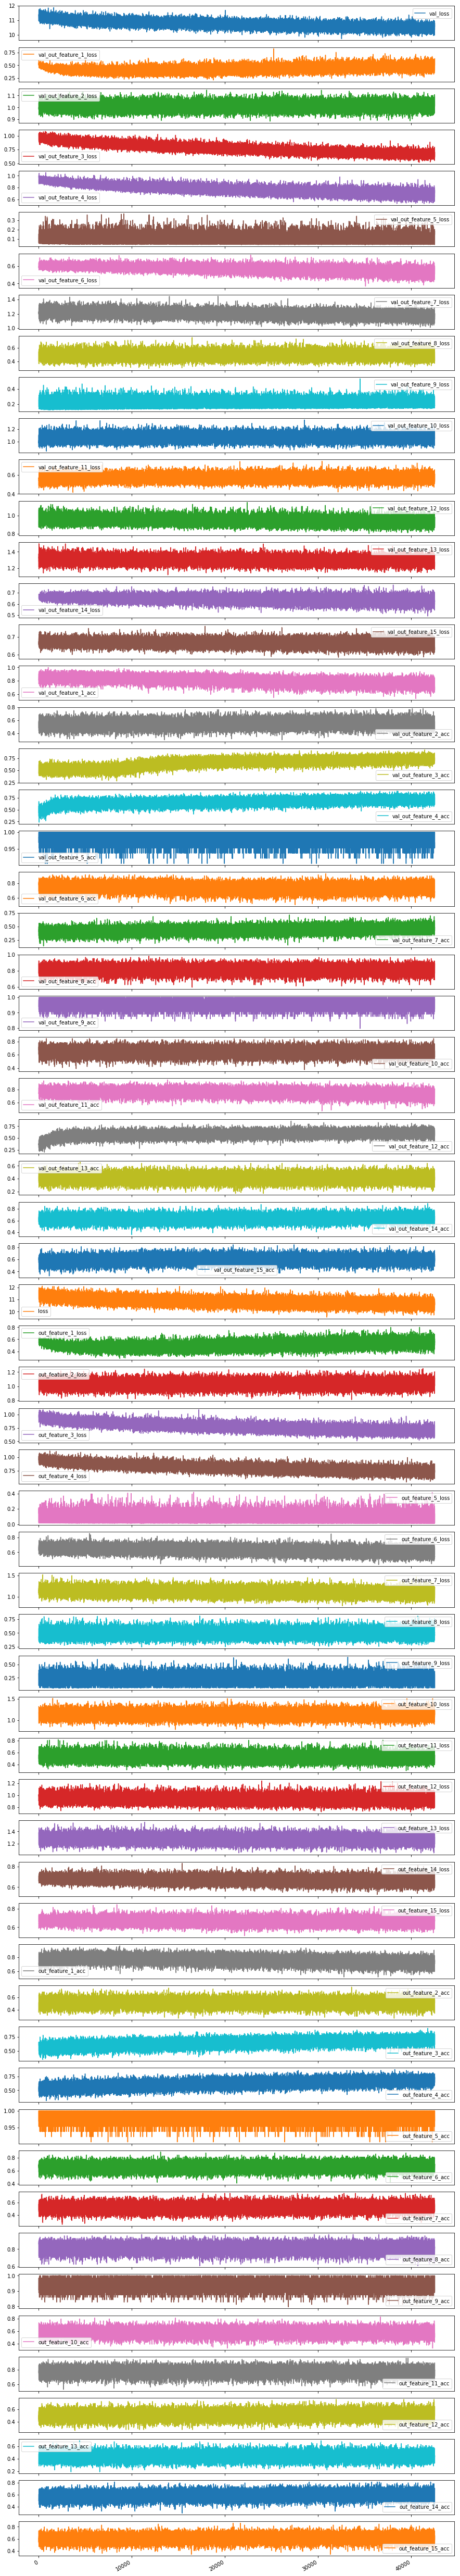

In [144]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<9.75]

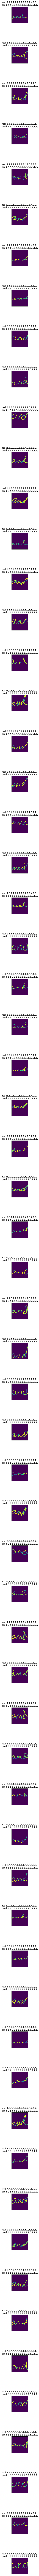

In [63]:
# human_features.load_weights('human_features_weights_v2.h5')
human_features.load_weights('15_human_features_weights_unseen_v1.h5')
vx,vo=next(vg)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
#     print(i, '\nPredicted:')
    
    real=''
    for f in range(15):
#         print(vo[i][f])
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
#     print(f_probs)
    pred=''
    for prob in f_probs:
#         print(prob)
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)
#     print('\n----------')
#     print('True:')
#     for op in o:
#         print(np.argmax(op[i]),end=',')
        
#     print('\n++++++',i,'++++++')

In [145]:
# print(df_hist.columns)
for i in range(1,16):
    print(df_hist['val_out_feature_{0}_acc'.format(i)].max())
# print(np.mean([df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max()]))
# df_hist[df_hist['val_acc']>10.2]

1.0
0.78125
0.921875
0.890625
1.0
0.9375
0.71875
0.984375
1.0
0.84375
0.953125
0.859375
0.65625
0.890625
0.84375


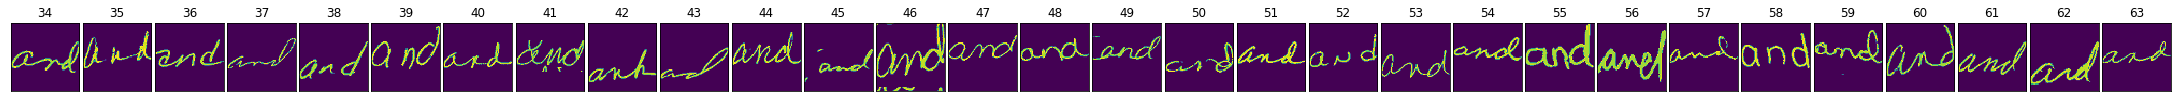

In [29]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    ax.imshow(inputs[64-30:64][i].reshape((64,64)))
    ax.set_title(i+34)

(64, 8, 8)
(64, 8, 8)
(64, 8, 8)
(64, 8, 8)
(64, 8, 8)
(64, 8, 8)
(64, 8, 8)
(64, 8, 8)


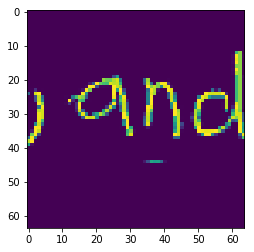

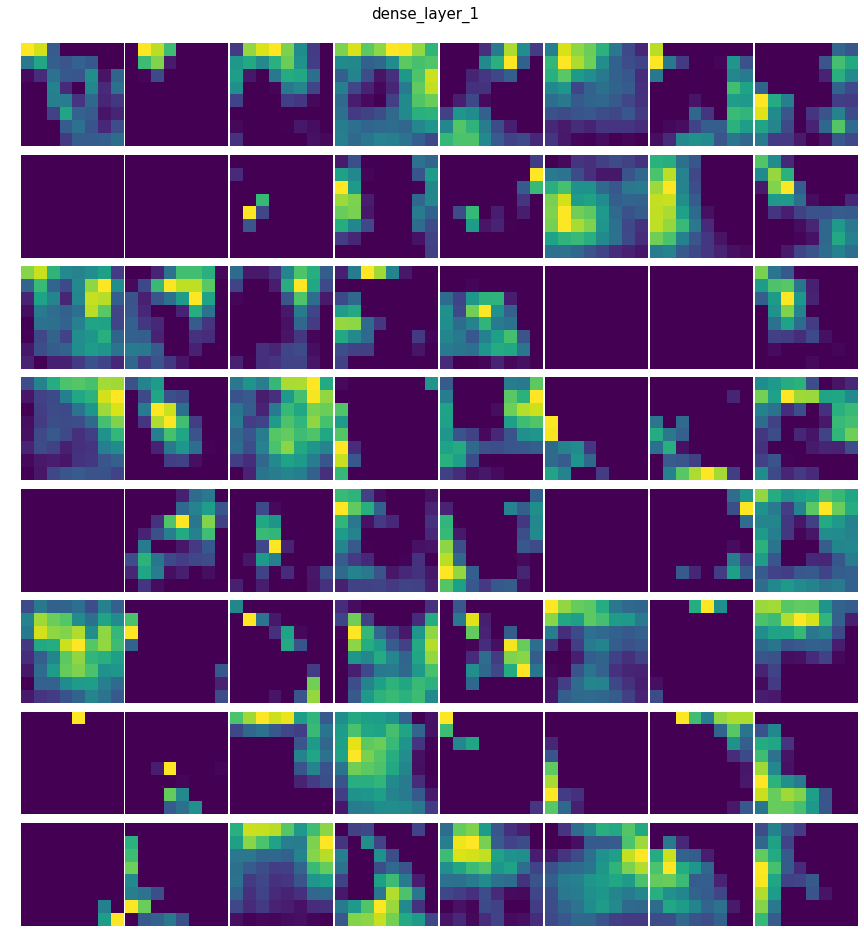

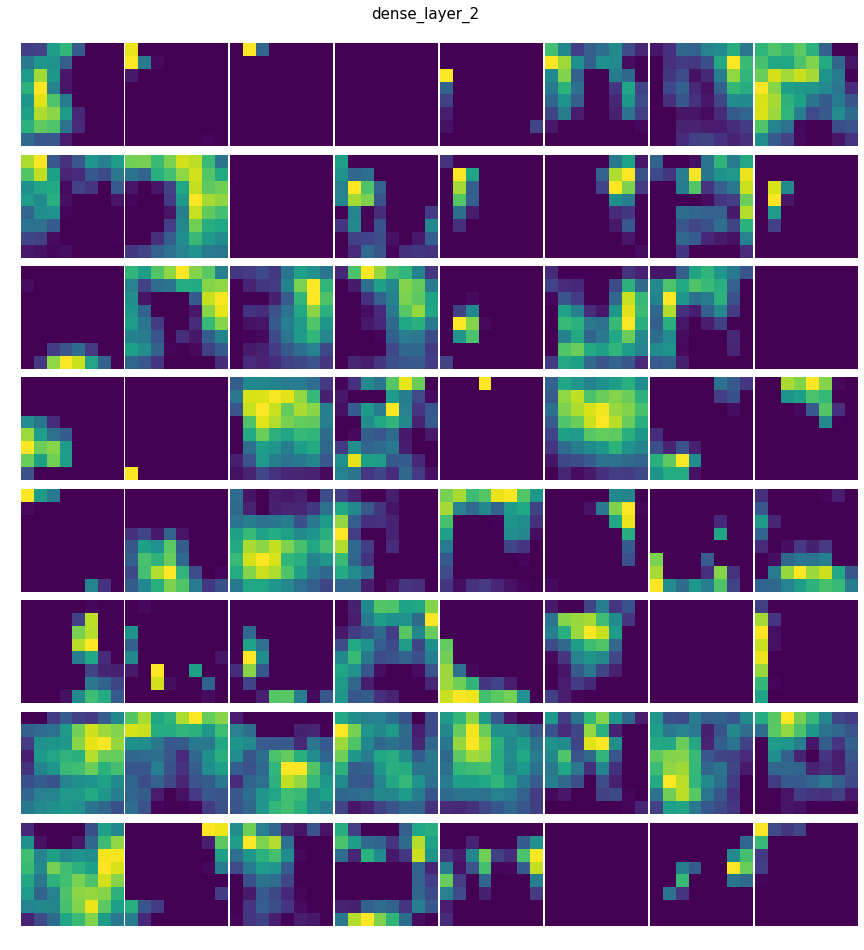

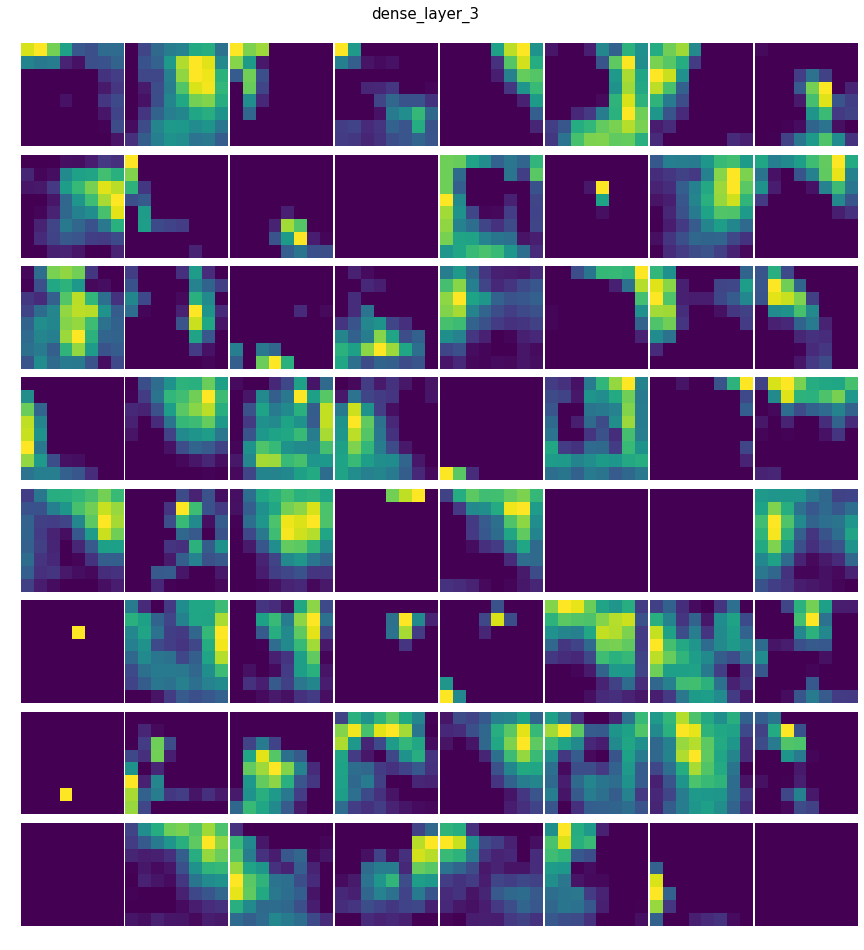

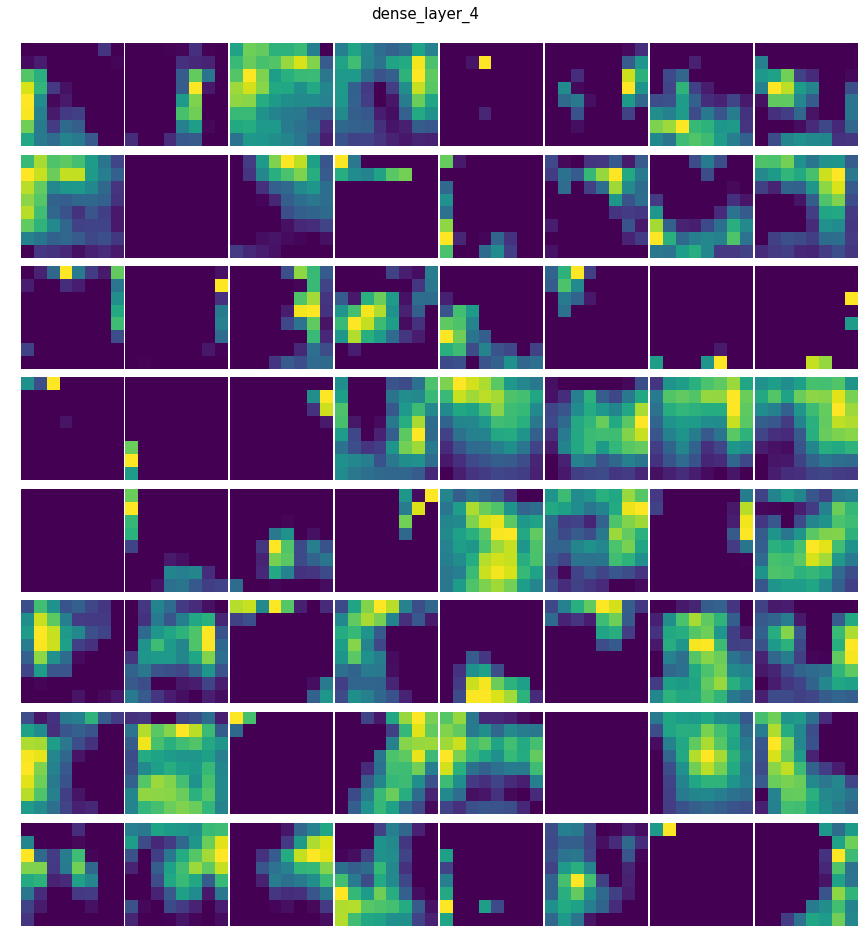

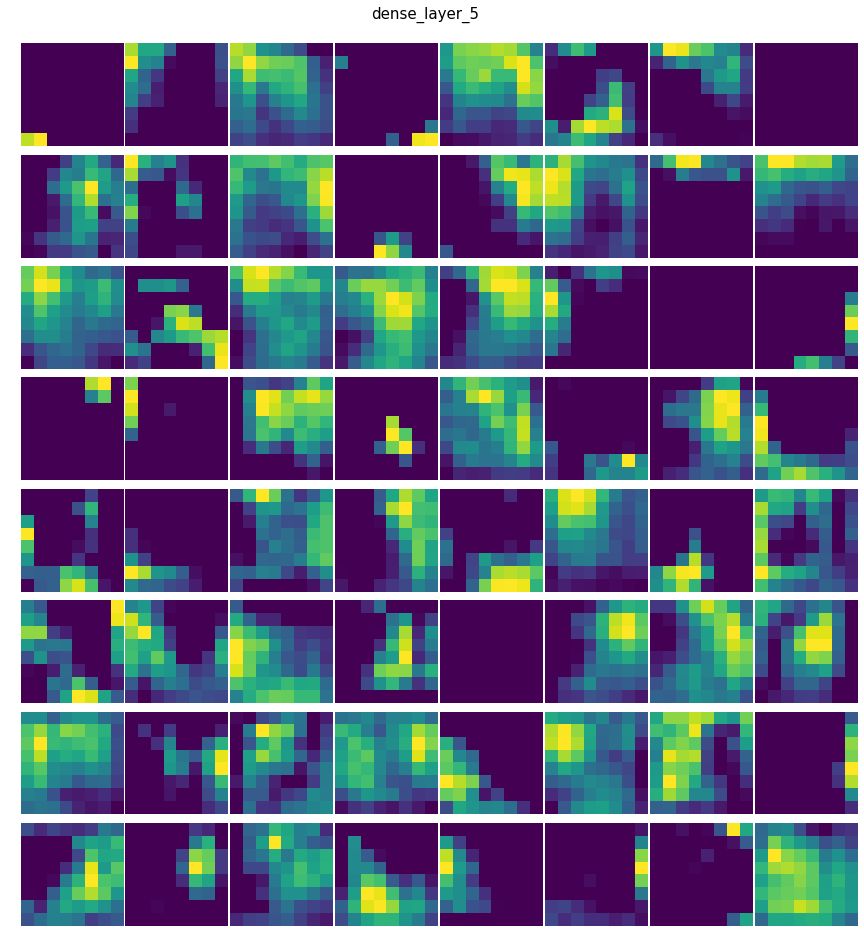

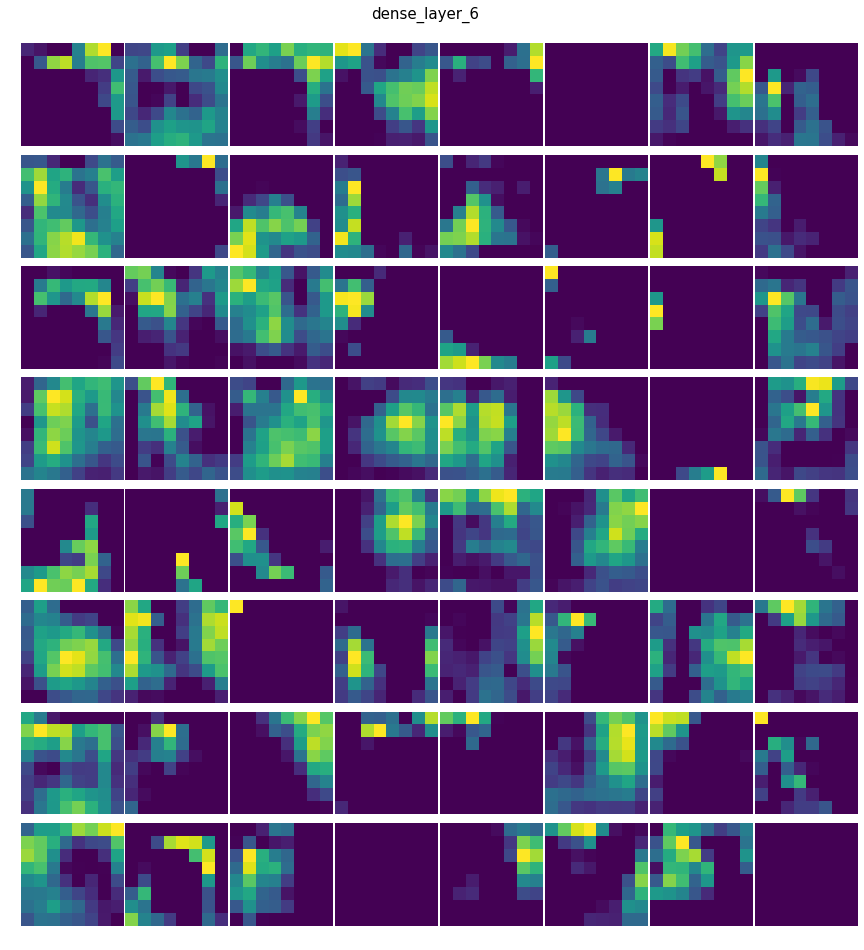

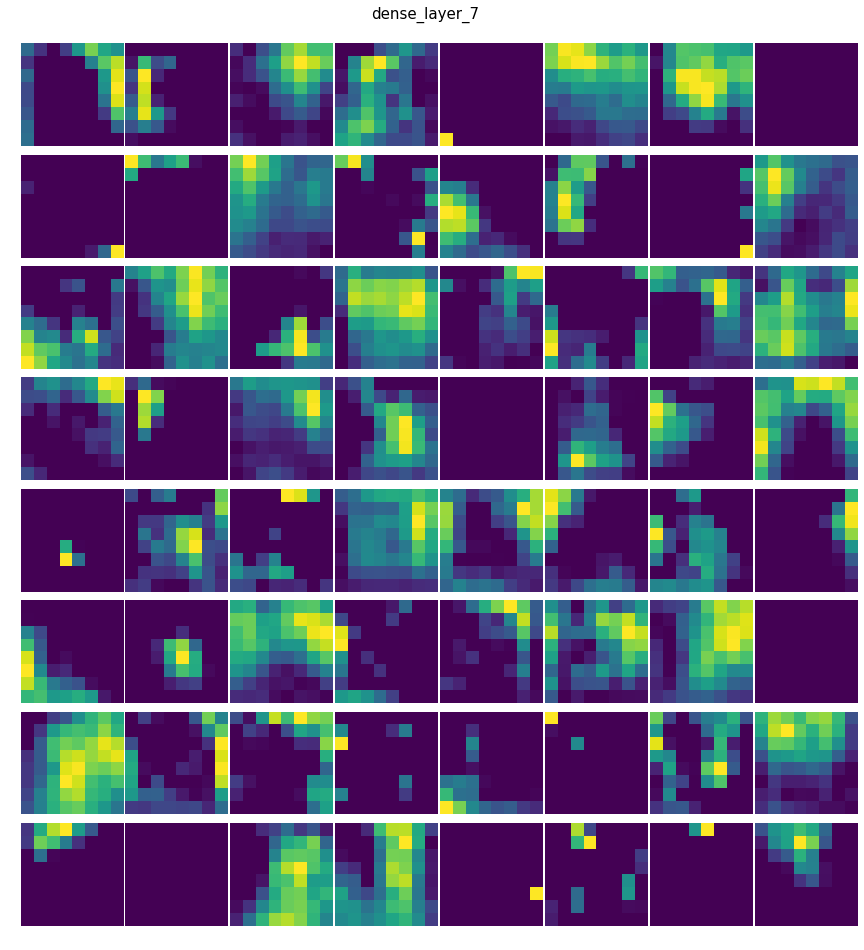

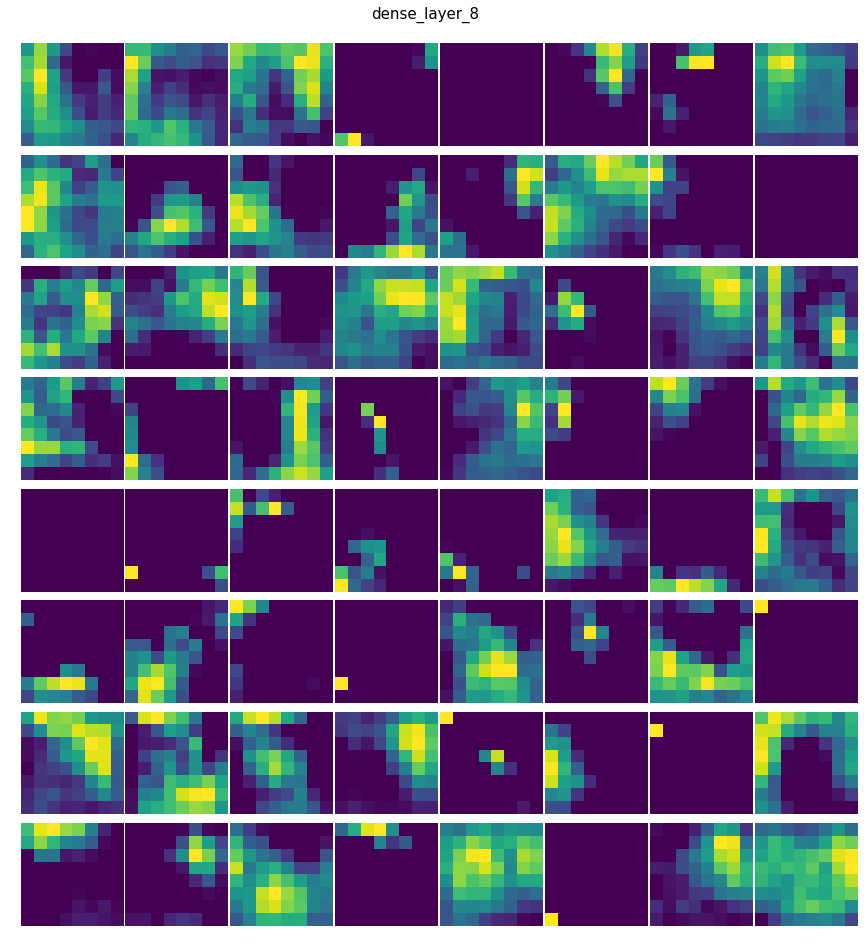

In [30]:
plt.imshow(inputs[10].reshape((64,64)))
plt.subplots_adjust(hspace = 0.1)
for i in range(1,9):
    visualize_model = Model(human_features.input, human_features.get_layer('dense_layer_'+str(i)).output)
    vis_out = visualize_model.predict(np.expand_dims(inputs[10],0))[0]
    vis_out = np.rollaxis(a=vis_out, start=0, axis=2)
    f,ax = plt.subplots(8,8)
    f.subplots_adjust(hspace = .00, wspace=.02, top=0.95)
    f.set_size_inches(15,15)
    f.suptitle('dense_layer_'+str(i), fontsize=15)
#     f.subplots_adjust(hspace = 0.1)
#     plt.title('dense_layer_'+str(i))
    print(vis_out.shape)
    for r in range(8):
        for c in range (8):
            ax[r,c].imshow(vis_out[c+r*8])
            ax[r,c].axis('off')
#     break

In [31]:
csv_data.var()

pen_pressure      0.241190
letter_spacing    0.481638
size              0.475689
dimension         0.464579
is_lowercase      0.014808
is_continuous     0.222378
slantness         0.866958
tilt              0.152430
entry_stroke_a    0.053592
staff_of_a        0.862689
formation_n       0.176950
staff_of_d        0.409782
exit_stroke_d     1.054210
word_formation    0.245240
constancy         0.239313
dtype: float64

# Evaluation

In [74]:
pred_flat = []
for i in range(1,len(feature_lengths)+1):
    pred_flat.append(human_features.get_layer('flatten_'+str(i)).output)
human_features_eval = Model(inputs=human_features.input, outputs=pred_flat)

In [77]:
test_g = datagen(len(val_images)*5,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)
test_x,test_y = next(test_g)

In [78]:
pred_y=human_features_eval.predict(test_x)

In [86]:
pred_y=np.array(pred_y)

In [89]:
pred_y[:,0,:].shape

(15, 4096)

Text(0.5, 1.0, 'Right Input')

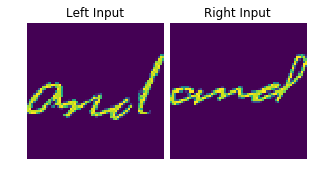

In [138]:
test_im_normal = test_x[0]#255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0301c_num2.png',0)
test_im_shifted = test_x[1]#255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/0301c_num1.png',0)
f,ax = plt.subplots(1,2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,1*3)
ax[0].imshow(test_im_normal.reshape((64,64)))
ax[0].axis('off')

ax[1].imshow(test_im_shifted.reshape((64,64)))
ax[1].axis('off')
ax[0].set_title('Left Input')
ax[1].set_title('Right Input')

In [139]:
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook

In [140]:
l = pred_y[:,0,:]
r = pred_y[:,1,:]

0.69937044

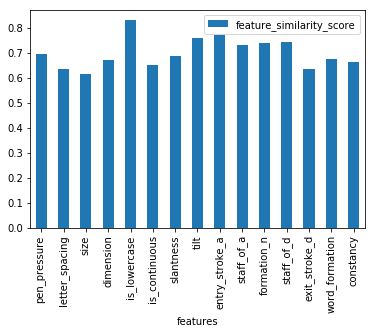

In [141]:
features = csv_data.keys()[1:]
feature_similarity_score=cosine_similarity(l,r).diagonal()
df_feat_sim_score = pd.DataFrame(columns=['features','feature_similarity_score'])
df_feat_sim_score['features']=features
df_feat_sim_score['feature_similarity_score']=feature_similarity_score
df_feat_sim_score.plot.bar(x='features')
df_feat_sim_score['feature_similarity_score'].mean()

In [103]:
class_preds = human_features.predict(test_x[:2])

In [137]:
for i in range(len(test_x[:2])):
    for f in range(15):
        print(np.argmax(class_preds[f][i]),end=',')
    print('')

1,1,1,1,1,1,0,0,0,1,1,1,1,0,1,
1,1,0,0,1,1,1,0,0,1,1,2,1,0,0,


In [113]:
csv_data.var()

pen_pressure      0.241190
letter_spacing    0.481638
size              0.475689
dimension         0.464579
is_lowercase      0.014808
is_continuous     0.222378
slantness         0.866958
tilt              0.152430
entry_stroke_a    0.053592
staff_of_a        0.862689
formation_n       0.176950
staff_of_d        0.409782
exit_stroke_d     1.054210
word_formation    0.245240
constancy         0.239313
dtype: float64